
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train n-step sarsa (n = 0, n = 2, n = 4, n = 10, n = 20)


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [266]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import nstep_sarsa_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [267]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [268]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [269]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254744,-80.462643,16.129793,2.749560,2.861671,"[[0.001348965917516196, 0.0004284138832875035,...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839508,6287200,AMGN,2,0.156756,42.707038,40.853188,51.060584,51.523108,10.432018,41.058033,40.603776,"[[0.001348965917516196, 0.0004284138832875035,...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580750,9625600,AXP,2,-0.935583,18.646868,12.660476,42.554847,-75.437681,25.776759,15.744065,17.616375,"[[0.001348965917516196, 0.0004284138832875035,...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279801,32.174382,28.867835,47.440231,156.994767,5.366299,30.327213,32.389915,"[[0.001348965917516196, 0.0004284138832875035,...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608652,6277400,CAT,2,0.655611,30.348091,25.455642,51.205304,98.374130,26.331746,26.689550,26.423591,"[[0.001348965917516196, 0.0004284138832875035,...",tic AAPL AMGN AXP ...


In [270]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [271]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [272]:
EPISODES = 500
TEST_TRIALS = 1000

In [273]:
two_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [274]:
two_step_sarsa_post_training_env, two_step_sarsa_training_episodes, two_step_sarsa_Q = nstep_sarsa_single_stock(two_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, aggressive=True)

Episode:   0%|          | 1/500 [00:03<30:27,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4514132.715064831
Sharpe:  0.764517443493335


Episode:   0%|          | 2/500 [00:07<29:54,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4839248.561522848
Sharpe:  0.7735949681611243


Episode:   1%|          | 3/500 [00:10<30:28,  3.68s/it]

begin_total_asset:1000000
end_total_asset:4402124.521068047
Sharpe:  0.7861453257419038


Episode:   1%|          | 4/500 [00:14<30:12,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7031972.07683783
Sharpe:  0.9221652020652614


Episode:   1%|          | 5/500 [00:18<30:41,  3.72s/it]

begin_total_asset:1000000
end_total_asset:4875340.558611911
Sharpe:  0.7917086967867066


Episode:   1%|          | 6/500 [00:22<30:28,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7266783.348257016
Sharpe:  0.9829040292997151


Episode:   1%|▏         | 7/500 [00:25<30:25,  3.70s/it]

begin_total_asset:1000000
end_total_asset:4946606.414323928
Sharpe:  0.7866426767287545


Episode:   2%|▏         | 8/500 [00:29<30:07,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3241841.072775423
Sharpe:  0.6076965736884188


Episode:   2%|▏         | 9/500 [00:33<29:53,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5565758.232736899
Sharpe:  0.8611539023632824


Episode:   2%|▏         | 10/500 [00:36<30:00,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3335035.75063746
Sharpe:  0.6270440121957777


Episode:   2%|▏         | 11/500 [00:40<30:09,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6725357.092376119
Sharpe:  0.9771730723025462


Episode:   2%|▏         | 12/500 [00:44<30:00,  3.69s/it]

begin_total_asset:1000000
end_total_asset:22261208.513581496
Sharpe:  1.4394214270078014


Episode:   3%|▎         | 13/500 [00:47<29:58,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7998440.646391325
Sharpe:  0.9788204958348368


Episode:   3%|▎         | 14/500 [00:51<29:57,  3.70s/it]

begin_total_asset:1000000
end_total_asset:3733536.171771811
Sharpe:  0.6384986981564497


Episode:   3%|▎         | 15/500 [00:55<29:35,  3.66s/it]

begin_total_asset:1000000
end_total_asset:3903823.945469165
Sharpe:  0.674183594128955


Episode:   3%|▎         | 16/500 [00:58<29:33,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4801173.775615308
Sharpe:  0.7826862951810302


Episode:   3%|▎         | 17/500 [01:02<30:32,  3.79s/it]

begin_total_asset:1000000
end_total_asset:10500959.523639452
Sharpe:  1.1021995519073042


Episode:   4%|▎         | 18/500 [01:06<30:10,  3.76s/it]

begin_total_asset:1000000
end_total_asset:2665481.5961898947
Sharpe:  0.5098993473846927


Episode:   4%|▍         | 19/500 [01:10<29:57,  3.74s/it]

begin_total_asset:1000000
end_total_asset:3581692.827666383
Sharpe:  0.6308189355291158


Episode:   4%|▍         | 20/500 [01:14<29:56,  3.74s/it]

begin_total_asset:1000000
end_total_asset:5444273.029805242
Sharpe:  0.8586434849545908


Episode:   4%|▍         | 21/500 [01:17<29:36,  3.71s/it]

begin_total_asset:1000000
end_total_asset:3529063.6849334356
Sharpe:  0.6487753014871577


Episode:   4%|▍         | 22/500 [01:21<29:10,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6658096.999533132
Sharpe:  0.8948146518369172


Episode:   5%|▍         | 23/500 [01:24<29:01,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4691341.272076524
Sharpe:  0.7802087052524713


Episode:   5%|▍         | 24/500 [01:28<28:54,  3.64s/it]

begin_total_asset:1000000
end_total_asset:4730167.304285087
Sharpe:  0.768983265033192


Episode:   5%|▌         | 25/500 [01:32<28:52,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4406862.05582738
Sharpe:  0.7500132740272824


Episode:   5%|▌         | 26/500 [01:35<29:02,  3.68s/it]

begin_total_asset:1000000
end_total_asset:3611871.824439913
Sharpe:  0.6665398902131285


Episode:   5%|▌         | 27/500 [01:39<28:49,  3.66s/it]

begin_total_asset:1000000
end_total_asset:10190640.708542261
Sharpe:  1.0845870075818391


Episode:   6%|▌         | 28/500 [01:43<28:51,  3.67s/it]

begin_total_asset:1000000
end_total_asset:13027368.524812836
Sharpe:  1.2388859174617493


Episode:   6%|▌         | 29/500 [01:46<28:45,  3.66s/it]

begin_total_asset:1000000
end_total_asset:10749614.472766472
Sharpe:  1.0760479996123327


Episode:   6%|▌         | 30/500 [01:50<28:36,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4030100.5885167136
Sharpe:  0.685245355948429


Episode:   6%|▌         | 31/500 [01:54<28:29,  3.64s/it]

begin_total_asset:1000000
end_total_asset:11785659.681439174
Sharpe:  1.2322465578121022


Episode:   6%|▋         | 32/500 [01:57<28:29,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5280530.132127854
Sharpe:  0.7992278959728945


Episode:   7%|▋         | 33/500 [02:01<28:29,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7394473.316409022
Sharpe:  0.9719825709159209


Episode:   7%|▋         | 34/500 [02:05<28:21,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7900910.869287337
Sharpe:  1.0316064302737598


Episode:   7%|▋         | 35/500 [02:08<28:32,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6202356.911185585
Sharpe:  0.9079948108899646


Episode:   7%|▋         | 36/500 [02:12<28:56,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9067034.122894565
Sharpe:  1.119274053731074


Episode:   7%|▋         | 37/500 [02:16<28:51,  3.74s/it]

begin_total_asset:1000000
end_total_asset:2274483.431107799
Sharpe:  0.4603755579136085


Episode:   8%|▊         | 38/500 [02:20<30:02,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5855294.36620346
Sharpe:  0.8953737053354266


Episode:   8%|▊         | 39/500 [02:24<29:31,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5151360.642971781
Sharpe:  0.7983421565213634


Episode:   8%|▊         | 40/500 [02:28<29:12,  3.81s/it]

begin_total_asset:1000000
end_total_asset:4904024.859414276
Sharpe:  0.8388927736297579


Episode:   8%|▊         | 41/500 [02:31<29:00,  3.79s/it]

begin_total_asset:1000000
end_total_asset:3751107.398607934
Sharpe:  0.6705427907897336


Episode:   8%|▊         | 42/500 [02:35<28:43,  3.76s/it]

begin_total_asset:1000000
end_total_asset:3422018.1035787007
Sharpe:  0.6564783577635014


Episode:   9%|▊         | 43/500 [02:39<28:31,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8956963.883266548
Sharpe:  1.0848387393221395


Episode:   9%|▉         | 44/500 [02:43<28:33,  3.76s/it]

begin_total_asset:1000000
end_total_asset:2997410.798671386
Sharpe:  0.5937148216955234


Episode:   9%|▉         | 45/500 [02:46<28:26,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3286546.800171547
Sharpe:  0.6191512367588613


Episode:   9%|▉         | 46/500 [02:50<28:36,  3.78s/it]

begin_total_asset:1000000
end_total_asset:5083769.419287293
Sharpe:  0.8245828577569267


Episode:   9%|▉         | 47/500 [02:54<28:31,  3.78s/it]

begin_total_asset:1000000
end_total_asset:16345272.719763886
Sharpe:  1.4032880935897194


Episode:  10%|▉         | 48/500 [02:58<28:24,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4490480.92113132
Sharpe:  0.7415800991491349


Episode:  10%|▉         | 49/500 [03:01<28:20,  3.77s/it]

begin_total_asset:1000000
end_total_asset:5417397.940919219
Sharpe:  0.8424743407531651


Episode:  10%|█         | 50/500 [03:05<28:16,  3.77s/it]

begin_total_asset:1000000
end_total_asset:5993166.836024802
Sharpe:  0.9005495321335728


Episode:  10%|█         | 51/500 [03:09<28:14,  3.77s/it]

begin_total_asset:1000000
end_total_asset:7007895.646956451
Sharpe:  0.9363164495701324


Episode:  10%|█         | 52/500 [03:13<28:19,  3.79s/it]

begin_total_asset:1000000
end_total_asset:8137305.019919853
Sharpe:  1.0282342480126723


Episode:  11%|█         | 53/500 [03:17<28:00,  3.76s/it]

begin_total_asset:1000000
end_total_asset:6306244.606810047
Sharpe:  0.9126085847995292


Episode:  11%|█         | 54/500 [03:20<27:51,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7822908.693475147
Sharpe:  1.0435089876275525


Episode:  11%|█         | 55/500 [03:25<29:11,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4522097.224287387
Sharpe:  0.7327322828075139


Episode:  11%|█         | 56/500 [03:28<28:46,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4273424.100505597
Sharpe:  0.7330020272680535


Episode:  11%|█▏        | 57/500 [03:32<28:28,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5275751.294166115
Sharpe:  0.8319103409980247


Episode:  12%|█▏        | 58/500 [03:36<28:09,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5174604.345016972
Sharpe:  0.8432100358362158


Episode:  12%|█▏        | 59/500 [03:40<27:53,  3.79s/it]

begin_total_asset:1000000
end_total_asset:6564714.751969379
Sharpe:  0.9153264878878045


Episode:  12%|█▏        | 60/500 [03:44<28:19,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5142629.13481109
Sharpe:  0.7922894859847586


Episode:  12%|█▏        | 61/500 [03:48<29:26,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2084821.8939467743
Sharpe:  0.4091788875234434


Episode:  12%|█▏        | 62/500 [03:52<28:57,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3598149.000057838
Sharpe:  0.6492663658650734


Episode:  13%|█▎        | 63/500 [03:56<28:33,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3469724.322936318
Sharpe:  0.648794359524466


Episode:  13%|█▎        | 64/500 [04:00<28:13,  3.88s/it]

begin_total_asset:1000000
end_total_asset:10567962.649679782
Sharpe:  1.1132467960214534


Episode:  13%|█▎        | 65/500 [04:03<28:03,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3659087.2792578465
Sharpe:  0.6495445917563033


Episode:  13%|█▎        | 66/500 [04:07<28:14,  3.90s/it]

begin_total_asset:1000000
end_total_asset:8682274.688918442
Sharpe:  0.9919843455927205


Episode:  13%|█▎        | 67/500 [04:11<28:03,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2955853.9851813917
Sharpe:  0.5604254431830399


Episode:  14%|█▎        | 68/500 [04:15<28:00,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2797551.509619612
Sharpe:  0.5408057539916962


Episode:  14%|█▍        | 69/500 [04:19<27:36,  3.84s/it]

begin_total_asset:1000000
end_total_asset:14006255.464669622
Sharpe:  1.2265641906418736


Episode:  14%|█▍        | 70/500 [04:23<27:23,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5293603.348789677
Sharpe:  0.8579703100817603


Episode:  14%|█▍        | 71/500 [04:26<27:23,  3.83s/it]

begin_total_asset:1000000
end_total_asset:1379317.8323414666
Sharpe:  0.24042969022320498


Episode:  14%|█▍        | 72/500 [04:30<27:24,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7310868.978553807
Sharpe:  0.9714262973055487


Episode:  15%|█▍        | 73/500 [04:34<27:19,  3.84s/it]

begin_total_asset:1000000
end_total_asset:6545285.741938203
Sharpe:  0.9287285673597047


Episode:  15%|█▍        | 74/500 [04:38<27:35,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8087365.226370888
Sharpe:  1.0638449770596328


Episode:  15%|█▌        | 75/500 [04:42<27:21,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4362560.098467353
Sharpe:  0.7113026280770874


Episode:  15%|█▌        | 76/500 [04:46<27:13,  3.85s/it]

begin_total_asset:1000000
end_total_asset:6149278.373806162
Sharpe:  0.8812432971319996


Episode:  15%|█▌        | 77/500 [04:50<27:05,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3512115.9127532016
Sharpe:  0.6438090016700925


Episode:  16%|█▌        | 78/500 [04:53<27:03,  3.85s/it]

begin_total_asset:1000000
end_total_asset:11483426.027234828
Sharpe:  1.1760154262399345


Episode:  16%|█▌        | 79/500 [04:57<27:05,  3.86s/it]

begin_total_asset:1000000
end_total_asset:8876182.40271172
Sharpe:  1.0421074866477653


Episode:  16%|█▌        | 80/500 [05:01<26:57,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3940856.7508587264
Sharpe:  0.7167384527604982


Episode:  16%|█▌        | 81/500 [05:05<26:37,  3.81s/it]

begin_total_asset:1000000
end_total_asset:6377203.874904099
Sharpe:  0.8745969724906798


Episode:  16%|█▋        | 82/500 [05:09<27:01,  3.88s/it]

begin_total_asset:1000000
end_total_asset:8934819.81886341
Sharpe:  1.0760002781690783


Episode:  17%|█▋        | 83/500 [05:13<26:44,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4534695.160969461
Sharpe:  0.7612718167990004


Episode:  17%|█▋        | 84/500 [05:17<26:32,  3.83s/it]

begin_total_asset:1000000
end_total_asset:10786751.163098786
Sharpe:  1.1197093156675828


Episode:  17%|█▋        | 85/500 [05:20<26:27,  3.83s/it]

begin_total_asset:1000000
end_total_asset:13842119.924872387
Sharpe:  1.2934805520019266


Episode:  17%|█▋        | 86/500 [05:24<26:28,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5950424.08288566
Sharpe:  0.8799428240226445


Episode:  17%|█▋        | 87/500 [05:29<28:12,  4.10s/it]

begin_total_asset:1000000
end_total_asset:5590993.006614822
Sharpe:  0.8498023121466998


Episode:  18%|█▊        | 88/500 [05:33<27:42,  4.03s/it]

begin_total_asset:1000000
end_total_asset:12313267.06723671
Sharpe:  1.1926691261578748


Episode:  18%|█▊        | 89/500 [05:37<27:27,  4.01s/it]

begin_total_asset:1000000
end_total_asset:4231383.612042342
Sharpe:  0.751611978539087


Episode:  18%|█▊        | 90/500 [05:41<27:13,  3.98s/it]

begin_total_asset:1000000
end_total_asset:9235098.682383766
Sharpe:  1.059497373730079


Episode:  18%|█▊        | 91/500 [05:45<27:10,  3.99s/it]

begin_total_asset:1000000
end_total_asset:6553648.893376088
Sharpe:  0.8923999450674863


Episode:  18%|█▊        | 92/500 [05:49<27:02,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4126779.6803156924
Sharpe:  0.7250785947174797


Episode:  19%|█▊        | 93/500 [05:52<26:39,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3992344.034366357
Sharpe:  0.7100151933482706


Episode:  19%|█▉        | 94/500 [05:56<26:34,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4112451.809776729
Sharpe:  0.7410208447241805


Episode:  19%|█▉        | 95/500 [06:00<26:21,  3.90s/it]

begin_total_asset:1000000
end_total_asset:13358739.199118698
Sharpe:  1.2622497663611305


Episode:  19%|█▉        | 96/500 [06:04<26:12,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5063244.633596632
Sharpe:  0.7816274488757115


Episode:  19%|█▉        | 97/500 [06:08<26:16,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4289862.974133686
Sharpe:  0.7236584113238682


Episode:  20%|█▉        | 98/500 [06:12<26:25,  3.94s/it]

begin_total_asset:1000000
end_total_asset:6931360.834164192
Sharpe:  0.9580257964073333


Episode:  20%|█▉        | 99/500 [06:16<26:11,  3.92s/it]

begin_total_asset:1000000
end_total_asset:9018040.393483886
Sharpe:  1.0672999241394863


Episode:  20%|██        | 100/500 [06:20<25:58,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6540374.258276626
Sharpe:  0.9298279375742187


Episode:  20%|██        | 101/500 [06:24<25:47,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4981967.545457045
Sharpe:  0.8136331514351841


Episode:  20%|██        | 102/500 [06:28<25:56,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4057352.6348555274
Sharpe:  0.7052222560226545


Episode:  21%|██        | 103/500 [06:31<25:43,  3.89s/it]

begin_total_asset:1000000
end_total_asset:13148209.68486287
Sharpe:  1.2581562277835987


Episode:  21%|██        | 104/500 [06:35<25:41,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5592404.470430024
Sharpe:  0.8385254072949736


Episode:  21%|██        | 105/500 [06:39<25:51,  3.93s/it]

begin_total_asset:1000000
end_total_asset:9810490.287120413
Sharpe:  1.123104572743249


Episode:  21%|██        | 106/500 [06:43<25:35,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7083354.761225909
Sharpe:  0.9610286569439663


Episode:  21%|██▏       | 107/500 [06:47<25:25,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6684087.340923278
Sharpe:  0.9940634833068767


Episode:  22%|██▏       | 108/500 [06:51<25:07,  3.85s/it]

begin_total_asset:1000000
end_total_asset:7934616.284314654
Sharpe:  1.0050487789189286


Episode:  22%|██▏       | 109/500 [06:55<25:04,  3.85s/it]

begin_total_asset:1000000
end_total_asset:5508536.237170199
Sharpe:  0.843142155124837


Episode:  22%|██▏       | 110/500 [06:58<24:59,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4173092.071334307
Sharpe:  0.7061210409038198


Episode:  22%|██▏       | 111/500 [07:02<24:57,  3.85s/it]

begin_total_asset:1000000
end_total_asset:10492450.775213197
Sharpe:  1.151737953193257


Episode:  22%|██▏       | 112/500 [07:06<24:49,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4206714.322123887
Sharpe:  0.71462794863488


Episode:  23%|██▎       | 113/500 [07:10<25:19,  3.93s/it]

begin_total_asset:1000000
end_total_asset:11665738.009069558
Sharpe:  1.1362290955041117


Episode:  23%|██▎       | 114/500 [07:14<25:09,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2837337.66785165
Sharpe:  0.5445875945881495


Episode:  23%|██▎       | 115/500 [07:19<26:23,  4.11s/it]

begin_total_asset:1000000
end_total_asset:5115002.297047623
Sharpe:  0.8089548622022269


Episode:  23%|██▎       | 116/500 [07:23<25:51,  4.04s/it]

begin_total_asset:1000000
end_total_asset:6707334.682182074
Sharpe:  0.9027194445068373


Episode:  23%|██▎       | 117/500 [07:26<25:27,  3.99s/it]

begin_total_asset:1000000
end_total_asset:5745800.064778264
Sharpe:  0.9174329943644871


Episode:  24%|██▎       | 118/500 [07:30<25:08,  3.95s/it]

begin_total_asset:1000000
end_total_asset:7658542.478887137
Sharpe:  1.007400477646284


Episode:  24%|██▍       | 119/500 [07:34<24:57,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3758650.2091796133
Sharpe:  0.6669115734830183


Episode:  24%|██▍       | 120/500 [07:38<25:03,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5977968.109649165
Sharpe:  0.8398983377702782


Episode:  24%|██▍       | 121/500 [07:42<24:49,  3.93s/it]

begin_total_asset:1000000
end_total_asset:9170714.596573634
Sharpe:  1.0365446214807628


Episode:  24%|██▍       | 122/500 [07:47<26:52,  4.27s/it]

begin_total_asset:1000000
end_total_asset:7853482.407712349
Sharpe:  0.9898416271709105


Episode:  25%|██▍       | 123/500 [07:51<26:09,  4.16s/it]

begin_total_asset:1000000
end_total_asset:4139115.6290686396
Sharpe:  0.6950220123712226


Episode:  25%|██▍       | 124/500 [07:55<25:27,  4.06s/it]

begin_total_asset:1000000
end_total_asset:5636923.716891452
Sharpe:  0.8383378472947244


Episode:  25%|██▌       | 125/500 [07:59<24:52,  3.98s/it]

begin_total_asset:1000000
end_total_asset:6047564.983267773
Sharpe:  0.8830003529772377


Episode:  25%|██▌       | 126/500 [08:03<25:05,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3995263.4315592404
Sharpe:  0.6964889819841058


Episode:  25%|██▌       | 127/500 [08:07<24:46,  3.98s/it]

begin_total_asset:1000000
end_total_asset:13157119.664553313
Sharpe:  1.246074535609594


Episode:  26%|██▌       | 128/500 [08:11<24:46,  4.00s/it]

begin_total_asset:1000000
end_total_asset:4708438.556448063
Sharpe:  0.7862657653018404


Episode:  26%|██▌       | 129/500 [08:15<24:27,  3.96s/it]

begin_total_asset:1000000
end_total_asset:11554921.430824952
Sharpe:  1.1301263516617466


Episode:  26%|██▌       | 130/500 [08:18<24:12,  3.93s/it]

begin_total_asset:1000000
end_total_asset:12494935.887509359
Sharpe:  1.1435662899825878


Episode:  26%|██▌       | 131/500 [08:22<24:05,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3795612.872287919
Sharpe:  0.6805854865581495


Episode:  26%|██▋       | 132/500 [08:26<23:54,  3.90s/it]

begin_total_asset:1000000
end_total_asset:10545195.024843242
Sharpe:  1.067571482075605


Episode:  27%|██▋       | 133/500 [08:30<23:46,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8886816.710489215
Sharpe:  1.0452086133248826


Episode:  27%|██▋       | 134/500 [08:34<23:40,  3.88s/it]

begin_total_asset:1000000
end_total_asset:7943766.093017516
Sharpe:  0.9914444394786155


Episode:  27%|██▋       | 135/500 [08:38<23:52,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4498282.240943785
Sharpe:  0.767451281446266


Episode:  27%|██▋       | 136/500 [08:42<23:32,  3.88s/it]

begin_total_asset:1000000
end_total_asset:7524984.63939176
Sharpe:  0.9808865768764722


Episode:  27%|██▋       | 137/500 [08:46<23:26,  3.87s/it]

begin_total_asset:1000000
end_total_asset:7869342.56829973
Sharpe:  0.9927890453026793


Episode:  28%|██▊       | 138/500 [08:49<23:22,  3.87s/it]

begin_total_asset:1000000
end_total_asset:5106439.367884058
Sharpe:  0.8093028610205646


Episode:  28%|██▊       | 139/500 [08:53<23:19,  3.88s/it]

begin_total_asset:1000000
end_total_asset:5892271.744707772
Sharpe:  0.9003564599578404


Episode:  28%|██▊       | 140/500 [08:57<23:13,  3.87s/it]

begin_total_asset:1000000
end_total_asset:7686115.96141523
Sharpe:  0.9463696523698818


Episode:  28%|██▊       | 141/500 [09:01<22:58,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5248325.838168151
Sharpe:  0.8222349719821739


Episode:  28%|██▊       | 142/500 [09:05<23:12,  3.89s/it]

begin_total_asset:1000000
end_total_asset:9867202.793907577
Sharpe:  1.1321757065077547


Episode:  29%|██▊       | 143/500 [09:09<23:05,  3.88s/it]

begin_total_asset:1000000
end_total_asset:7006334.970519943
Sharpe:  0.963747366147048


Episode:  29%|██▉       | 144/500 [09:13<22:49,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4250725.639531903
Sharpe:  0.726696071160254


Episode:  29%|██▉       | 145/500 [09:18<25:11,  4.26s/it]

begin_total_asset:1000000
end_total_asset:11044625.372852996
Sharpe:  1.185736174446156


Episode:  29%|██▉       | 146/500 [09:22<24:27,  4.15s/it]

begin_total_asset:1000000
end_total_asset:5183147.107499328
Sharpe:  0.8089689560335731


Episode:  29%|██▉       | 147/500 [09:26<23:57,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4340700.450572706
Sharpe:  0.7465542867228282


Episode:  30%|██▉       | 148/500 [09:29<23:36,  4.02s/it]

begin_total_asset:1000000
end_total_asset:6193676.254767223
Sharpe:  0.8903507081370424


Episode:  30%|██▉       | 149/500 [09:33<23:16,  3.98s/it]

begin_total_asset:1000000
end_total_asset:7394526.974007338
Sharpe:  0.9658912955592381


Episode:  30%|███       | 150/500 [09:37<23:05,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4843596.715968268
Sharpe:  0.8248160008647274


Episode:  30%|███       | 151/500 [09:41<22:45,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4292743.031552729
Sharpe:  0.7315011684071465


Episode:  30%|███       | 152/500 [09:45<22:34,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2963984.148190075
Sharpe:  0.5753035992666037


Episode:  31%|███       | 153/500 [09:49<22:41,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3451890.8217477337
Sharpe:  0.6794333395287957


Episode:  31%|███       | 154/500 [09:53<22:38,  3.93s/it]

begin_total_asset:1000000
end_total_asset:9693666.063508112
Sharpe:  1.1322706817894772


Episode:  31%|███       | 155/500 [09:57<22:32,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4079459.42897551
Sharpe:  0.7397146355318109


Episode:  31%|███       | 156/500 [10:01<22:22,  3.90s/it]

begin_total_asset:1000000
end_total_asset:17093453.021371774
Sharpe:  1.2559370527069722


Episode:  31%|███▏      | 157/500 [10:04<22:14,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6811722.972317433
Sharpe:  0.9228601961457492


Episode:  32%|███▏      | 158/500 [10:08<22:13,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6209478.670431874
Sharpe:  0.9141483972869594


Episode:  32%|███▏      | 159/500 [10:12<21:59,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6820329.709888866
Sharpe:  0.9650874685291622


Episode:  32%|███▏      | 160/500 [10:16<21:49,  3.85s/it]

begin_total_asset:1000000
end_total_asset:8170328.757473002
Sharpe:  1.070809572186559


Episode:  32%|███▏      | 161/500 [10:20<21:44,  3.85s/it]

begin_total_asset:1000000
end_total_asset:8835950.692032885
Sharpe:  1.0553526226633596


Episode:  32%|███▏      | 162/500 [10:24<22:04,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7427252.348819621
Sharpe:  0.9662190099880513


Episode:  33%|███▎      | 163/500 [10:28<22:10,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4234922.015436189
Sharpe:  0.7279127223584541


Episode:  33%|███▎      | 164/500 [10:32<21:53,  3.91s/it]

begin_total_asset:1000000
end_total_asset:5031113.212839053
Sharpe:  0.823528144556008


Episode:  33%|███▎      | 165/500 [10:36<21:47,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5852852.743024362
Sharpe:  0.8912902724727855


Episode:  33%|███▎      | 166/500 [10:40<21:42,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6838589.421723726
Sharpe:  0.9124990785622409


Episode:  33%|███▎      | 167/500 [10:43<21:34,  3.89s/it]

begin_total_asset:1000000
end_total_asset:7131751.059283002
Sharpe:  0.9414307294016289


Episode:  34%|███▎      | 168/500 [10:47<21:24,  3.87s/it]

begin_total_asset:1000000
end_total_asset:8618603.053050686
Sharpe:  1.0758177816157573


Episode:  34%|███▍      | 169/500 [10:51<21:28,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3142535.1562295756
Sharpe:  0.5946869685710985


Episode:  34%|███▍      | 170/500 [10:55<21:14,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6881595.930501943
Sharpe:  0.896890646576827


Episode:  34%|███▍      | 171/500 [10:59<21:08,  3.86s/it]

begin_total_asset:1000000
end_total_asset:10281428.677911472
Sharpe:  1.0978071368303164


Episode:  34%|███▍      | 172/500 [11:03<21:01,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4320103.06401335
Sharpe:  0.7410162281532843


Episode:  35%|███▍      | 173/500 [11:07<21:01,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6583265.994132368
Sharpe:  0.9394023222740814


Episode:  35%|███▍      | 174/500 [11:10<21:01,  3.87s/it]

begin_total_asset:1000000
end_total_asset:9347390.653721096
Sharpe:  1.056795424940884


Episode:  35%|███▌      | 175/500 [11:14<20:54,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6334888.3288099915
Sharpe:  0.9342098190190147


Episode:  35%|███▌      | 176/500 [11:18<21:02,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6849293.763588629
Sharpe:  0.9378699256268211


Episode:  35%|███▌      | 177/500 [11:22<20:49,  3.87s/it]

begin_total_asset:1000000
end_total_asset:10258503.139196629
Sharpe:  1.1263907772247779


Episode:  36%|███▌      | 178/500 [11:26<20:40,  3.85s/it]

begin_total_asset:1000000
end_total_asset:8028248.896555111
Sharpe:  0.9756169775683415


Episode:  36%|███▌      | 179/500 [11:31<21:56,  4.10s/it]

begin_total_asset:1000000
end_total_asset:6221007.60712213
Sharpe:  0.9427421977586182


Episode:  36%|███▌      | 180/500 [11:34<21:37,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4477789.706040477
Sharpe:  0.7382287638821646


Episode:  36%|███▌      | 181/500 [11:38<21:19,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3594994.383885193
Sharpe:  0.6445552686017211


Episode:  36%|███▋      | 182/500 [11:42<20:56,  3.95s/it]

begin_total_asset:1000000
end_total_asset:6329526.6311055
Sharpe:  0.9626497594247572


Episode:  37%|███▋      | 183/500 [11:46<20:54,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3260926.119736483
Sharpe:  0.6223136338073069


Episode:  37%|███▋      | 184/500 [11:50<20:43,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5965222.582891625
Sharpe:  0.8817323746264869


Episode:  37%|███▋      | 185/500 [11:54<20:26,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2777059.6588946898
Sharpe:  0.551394797887412


Episode:  37%|███▋      | 186/500 [11:58<20:18,  3.88s/it]

begin_total_asset:1000000
end_total_asset:11862027.539230518
Sharpe:  1.1248426015338624


Episode:  37%|███▋      | 187/500 [12:02<20:08,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5499297.270099796
Sharpe:  0.8316810847877524


Episode:  38%|███▊      | 188/500 [12:05<20:10,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3445551.7046297584
Sharpe:  0.6445041106673981


Episode:  38%|███▊      | 189/500 [12:09<20:09,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5173267.17777964
Sharpe:  0.8305249613450094


Episode:  38%|███▊      | 190/500 [12:13<20:09,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6105549.305137599
Sharpe:  0.9004464936482335


Episode:  38%|███▊      | 191/500 [12:17<19:58,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6651011.3920167545
Sharpe:  0.961602053318756


Episode:  38%|███▊      | 192/500 [12:21<19:47,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2675016.35841541
Sharpe:  0.5522752387827231


Episode:  39%|███▊      | 193/500 [12:25<19:40,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3235939.377631083
Sharpe:  0.6080879124734665


Episode:  39%|███▉      | 194/500 [12:29<19:34,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7848228.787618849
Sharpe:  0.9778002370902059


Episode:  39%|███▉      | 195/500 [12:32<19:28,  3.83s/it]

begin_total_asset:1000000
end_total_asset:14774831.427731436
Sharpe:  1.291296157616747


Episode:  39%|███▉      | 196/500 [12:36<19:27,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5677307.196970811
Sharpe:  0.8485861054883195


Episode:  39%|███▉      | 197/500 [12:40<19:35,  3.88s/it]

begin_total_asset:1000000
end_total_asset:9224738.165692065
Sharpe:  1.0748459552216265


Episode:  40%|███▉      | 198/500 [12:44<19:30,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3329783.6043526544
Sharpe:  0.6272069750065231


Episode:  40%|███▉      | 199/500 [12:48<19:29,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8899364.310956499
Sharpe:  1.0710737568080833


Episode:  40%|████      | 200/500 [12:52<19:20,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3501761.7350235474
Sharpe:  0.6593715215663998


Episode:  40%|████      | 201/500 [12:56<19:17,  3.87s/it]

begin_total_asset:1000000
end_total_asset:18440743.552004863
Sharpe:  1.3514501805777235


Episode:  40%|████      | 202/500 [13:00<19:19,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3842395.872748901
Sharpe:  0.6821603016172288


Episode:  41%|████      | 203/500 [13:04<19:15,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4227756.798887816
Sharpe:  0.7491549495084251


Episode:  41%|████      | 204/500 [13:07<19:17,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3885805.115374636
Sharpe:  0.6754269315498548


Episode:  41%|████      | 205/500 [13:11<19:17,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4607812.27644945
Sharpe:  0.7809095617613488


Episode:  41%|████      | 206/500 [13:15<19:08,  3.91s/it]

begin_total_asset:1000000
end_total_asset:7884116.786189326
Sharpe:  1.0348151627311915


Episode:  41%|████▏     | 207/500 [13:19<19:01,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4280784.980779633
Sharpe:  0.7268224579480925


Episode:  42%|████▏     | 208/500 [13:23<18:58,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5932581.220286403
Sharpe:  0.8828911931894029


Episode:  42%|████▏     | 209/500 [13:27<18:45,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6526632.774133832
Sharpe:  0.9118730398401274


Episode:  42%|████▏     | 210/500 [13:31<18:36,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3691125.274772113
Sharpe:  0.6535951160728242


Episode:  42%|████▏     | 211/500 [13:35<18:43,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5083446.6226965925
Sharpe:  0.7999886585582009


Episode:  42%|████▏     | 212/500 [13:39<18:44,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6272392.825714953
Sharpe:  0.9036269405940689


Episode:  43%|████▎     | 213/500 [13:42<18:35,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4629498.716109569
Sharpe:  0.7866573674490455


Episode:  43%|████▎     | 214/500 [13:47<18:46,  3.94s/it]

begin_total_asset:1000000
end_total_asset:5399089.405201921
Sharpe:  0.8367598199948973


Episode:  43%|████▎     | 215/500 [13:51<20:12,  4.25s/it]

begin_total_asset:1000000
end_total_asset:15714397.259401472
Sharpe:  1.2825854412031956


Episode:  43%|████▎     | 216/500 [13:55<19:39,  4.15s/it]

begin_total_asset:1000000
end_total_asset:1821834.3693713427
Sharpe:  0.36932389382446096


Episode:  43%|████▎     | 217/500 [13:59<19:15,  4.08s/it]

begin_total_asset:1000000
end_total_asset:2875283.0682231234
Sharpe:  0.5738733223413567


Episode:  44%|████▎     | 218/500 [14:03<19:02,  4.05s/it]

begin_total_asset:1000000
end_total_asset:5827616.7434575055
Sharpe:  0.857915533952485


Episode:  44%|████▍     | 219/500 [14:07<18:42,  3.99s/it]

begin_total_asset:1000000
end_total_asset:7339708.121690052
Sharpe:  0.9858098047961712


Episode:  44%|████▍     | 220/500 [14:11<18:30,  3.97s/it]

begin_total_asset:1000000
end_total_asset:7157912.528217147
Sharpe:  0.966666447734928


Episode:  44%|████▍     | 221/500 [14:15<18:14,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4725856.085508832
Sharpe:  0.7662998271825022


Episode:  44%|████▍     | 222/500 [14:19<18:01,  3.89s/it]

begin_total_asset:1000000
end_total_asset:14798011.109912498
Sharpe:  1.229259680969696


Episode:  45%|████▍     | 223/500 [14:23<18:01,  3.90s/it]

begin_total_asset:1000000
end_total_asset:17939393.6322734
Sharpe:  1.3634625684154713


Episode:  45%|████▍     | 224/500 [14:27<17:57,  3.90s/it]

begin_total_asset:1000000
end_total_asset:8253701.849949373
Sharpe:  1.0385350315913058


Episode:  45%|████▌     | 225/500 [14:30<17:53,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7462578.530248477
Sharpe:  0.9727917489946782


Episode:  45%|████▌     | 226/500 [14:34<17:47,  3.89s/it]

begin_total_asset:1000000
end_total_asset:9455075.74471416
Sharpe:  1.0847824996082482


Episode:  45%|████▌     | 227/500 [14:38<17:48,  3.91s/it]

begin_total_asset:1000000
end_total_asset:5522186.48872355
Sharpe:  0.8836894605010313


Episode:  46%|████▌     | 228/500 [14:42<17:40,  3.90s/it]

begin_total_asset:1000000
end_total_asset:12070292.941823354
Sharpe:  1.1612416444205165


Episode:  46%|████▌     | 229/500 [14:46<17:33,  3.89s/it]

begin_total_asset:1000000
end_total_asset:9100274.679367015
Sharpe:  1.0888720322965404


Episode:  46%|████▌     | 230/500 [14:50<17:37,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7282686.8606541
Sharpe:  0.9560340107983812


Episode:  46%|████▌     | 231/500 [14:54<17:24,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6317471.42299247
Sharpe:  0.8987843861684467


Episode:  46%|████▋     | 232/500 [14:58<17:14,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2730161.341061585
Sharpe:  0.5366331621580982


Episode:  47%|████▋     | 233/500 [15:01<17:13,  3.87s/it]

begin_total_asset:1000000
end_total_asset:9560836.594854506
Sharpe:  1.0980444122204387


Episode:  47%|████▋     | 234/500 [15:05<17:06,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3244462.8416379592
Sharpe:  0.609035385073311


Episode:  47%|████▋     | 235/500 [15:09<17:12,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4158225.4222764233
Sharpe:  0.7544091665050667


Episode:  47%|████▋     | 236/500 [15:13<17:08,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6838369.268540932
Sharpe:  0.9577512304104268


Episode:  47%|████▋     | 237/500 [15:17<17:32,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3612189.7602683366
Sharpe:  0.6554423278372962


Episode:  48%|████▊     | 238/500 [15:21<17:28,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5506354.663711482
Sharpe:  0.8476508340504201


Episode:  48%|████▊     | 239/500 [15:26<17:33,  4.04s/it]

begin_total_asset:1000000
end_total_asset:4910438.172452874
Sharpe:  0.789810759855978


Episode:  48%|████▊     | 240/500 [15:29<17:19,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5977487.036054506
Sharpe:  0.8805800089172958


Episode:  48%|████▊     | 241/500 [15:33<17:07,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4894457.066064076
Sharpe:  0.7941927544389057


Episode:  48%|████▊     | 242/500 [15:37<17:08,  3.99s/it]

begin_total_asset:1000000
end_total_asset:2959991.0716945943
Sharpe:  0.5832101942591279


Episode:  49%|████▊     | 243/500 [15:41<17:00,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3085974.4613888636
Sharpe:  0.5902672846562366


Episode:  49%|████▉     | 244/500 [15:45<17:01,  3.99s/it]

begin_total_asset:1000000
end_total_asset:7795397.519133134
Sharpe:  0.9695934725551358


Episode:  49%|████▉     | 245/500 [15:49<16:55,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2402368.864630856
Sharpe:  0.47601034962384764


Episode:  49%|████▉     | 246/500 [15:53<16:42,  3.95s/it]

begin_total_asset:1000000
end_total_asset:9443925.716603765
Sharpe:  1.1061839154645674


Episode:  49%|████▉     | 247/500 [15:57<16:34,  3.93s/it]

begin_total_asset:1000000
end_total_asset:8585593.568507703
Sharpe:  1.0505282876081419


Episode:  50%|████▉     | 248/500 [16:01<16:26,  3.92s/it]

begin_total_asset:1000000
end_total_asset:6762191.739366579
Sharpe:  0.9755636173702894


Episode:  50%|████▉     | 249/500 [16:05<16:13,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3586289.9477894926
Sharpe:  0.6971174117822002


Episode:  50%|█████     | 250/500 [16:09<16:07,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3748987.2569607557
Sharpe:  0.6784700080626495


Episode:  50%|█████     | 251/500 [16:13<16:13,  3.91s/it]

begin_total_asset:1000000
end_total_asset:9263646.381131848
Sharpe:  1.0695250815972877


Episode:  50%|█████     | 252/500 [16:16<16:05,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4314355.677233607
Sharpe:  0.7355054432525403


Episode:  51%|█████     | 253/500 [16:20<16:04,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4149814.9790398697
Sharpe:  0.7110861717559651


Episode:  51%|█████     | 254/500 [16:24<15:58,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4814008.889514406
Sharpe:  0.7694612198560649


Episode:  51%|█████     | 255/500 [16:30<17:57,  4.40s/it]

begin_total_asset:1000000
end_total_asset:6634914.555144082
Sharpe:  0.9011840940370586


Episode:  51%|█████     | 256/500 [16:34<17:40,  4.35s/it]

begin_total_asset:1000000
end_total_asset:6749861.19303728
Sharpe:  0.9473752875144401


Episode:  51%|█████▏    | 257/500 [16:38<17:10,  4.24s/it]

begin_total_asset:1000000
end_total_asset:2568933.4804362278
Sharpe:  0.528993871910544


Episode:  52%|█████▏    | 258/500 [16:42<16:42,  4.14s/it]

begin_total_asset:1000000
end_total_asset:5726380.359707624
Sharpe:  0.8380034639391273


Episode:  52%|█████▏    | 259/500 [16:46<16:18,  4.06s/it]

begin_total_asset:1000000
end_total_asset:7103778.488921658
Sharpe:  0.9506126642501582


Episode:  52%|█████▏    | 260/500 [16:50<16:00,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3912647.344988883
Sharpe:  0.6773041635126557


Episode:  52%|█████▏    | 261/500 [16:54<15:40,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3675342.900451526
Sharpe:  0.6497365770153749


Episode:  52%|█████▏    | 262/500 [16:57<15:30,  3.91s/it]

begin_total_asset:1000000
end_total_asset:11825483.644085027
Sharpe:  1.1608010809991487


Episode:  53%|█████▎    | 263/500 [17:01<15:21,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8143223.513076193
Sharpe:  0.9817426795133082


Episode:  53%|█████▎    | 264/500 [17:05<15:09,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4645112.06042281
Sharpe:  0.7528375744871052


Episode:  53%|█████▎    | 265/500 [17:09<14:58,  3.82s/it]

begin_total_asset:1000000
end_total_asset:11131244.541788153
Sharpe:  1.1603890198505102


Episode:  53%|█████▎    | 266/500 [17:13<15:03,  3.86s/it]

begin_total_asset:1000000
end_total_asset:9077607.677100403
Sharpe:  1.0402215793345984


Episode:  53%|█████▎    | 267/500 [17:17<14:58,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2587324.2617678386
Sharpe:  0.5133179835058098


Episode:  54%|█████▎    | 268/500 [17:21<15:04,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5970100.89457872
Sharpe:  0.8431821161293186


Episode:  54%|█████▍    | 269/500 [17:24<14:53,  3.87s/it]

begin_total_asset:1000000
end_total_asset:7209304.291853172
Sharpe:  0.9456787276261153


Episode:  54%|█████▍    | 270/500 [17:28<14:45,  3.85s/it]

begin_total_asset:1000000
end_total_asset:6032375.06309113
Sharpe:  0.8979620929473432


Episode:  54%|█████▍    | 271/500 [17:32<14:42,  3.85s/it]

begin_total_asset:1000000
end_total_asset:2682501.7555071283
Sharpe:  0.5120461717229504


Episode:  54%|█████▍    | 272/500 [17:36<14:37,  3.85s/it]

begin_total_asset:1000000
end_total_asset:20864152.83026841
Sharpe:  1.421789963057069


Episode:  55%|█████▍    | 273/500 [17:40<14:33,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4400206.940032899
Sharpe:  0.7561381428517325


Episode:  55%|█████▍    | 274/500 [17:44<14:32,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6426431.800315887
Sharpe:  0.9051162421984478


Episode:  55%|█████▌    | 275/500 [17:47<14:28,  3.86s/it]

begin_total_asset:1000000
end_total_asset:13886126.623628413
Sharpe:  1.2356576770460106


Episode:  55%|█████▌    | 276/500 [17:52<14:41,  3.94s/it]

begin_total_asset:1000000
end_total_asset:7519158.4989551585
Sharpe:  0.9556755795177171


Episode:  55%|█████▌    | 277/500 [17:55<14:30,  3.90s/it]

begin_total_asset:1000000
end_total_asset:14973790.631452348
Sharpe:  1.315002090579538


Episode:  56%|█████▌    | 278/500 [17:59<14:18,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4594207.550545345
Sharpe:  0.7706411996296042


Episode:  56%|█████▌    | 279/500 [18:03<14:12,  3.86s/it]

begin_total_asset:1000000
end_total_asset:15651677.241304448
Sharpe:  1.2933565122683917


Episode:  56%|█████▌    | 280/500 [18:07<14:02,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7193801.770250022
Sharpe:  0.9650561279201662


Episode:  56%|█████▌    | 281/500 [18:11<13:59,  3.83s/it]

begin_total_asset:1000000
end_total_asset:9289621.276164971
Sharpe:  1.0938236986501841


Episode:  56%|█████▋    | 282/500 [18:14<13:52,  3.82s/it]

begin_total_asset:1000000
end_total_asset:4941072.341418087
Sharpe:  0.8223480002368364


Episode:  57%|█████▋    | 283/500 [18:18<13:48,  3.82s/it]

begin_total_asset:1000000
end_total_asset:7042200.806298391
Sharpe:  0.9272556203722379


Episode:  57%|█████▋    | 284/500 [18:22<13:53,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4932963.39464755
Sharpe:  0.8173751926958084


Episode:  57%|█████▋    | 285/500 [18:26<13:45,  3.84s/it]

begin_total_asset:1000000
end_total_asset:6899808.086696122
Sharpe:  0.9500681393487863


Episode:  57%|█████▋    | 286/500 [18:30<13:39,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3158965.4116966375
Sharpe:  0.5858588555993581


Episode:  57%|█████▋    | 287/500 [18:34<13:37,  3.84s/it]

begin_total_asset:1000000
end_total_asset:6436817.971961942
Sharpe:  0.9275552816510181


Episode:  58%|█████▊    | 288/500 [18:37<13:35,  3.85s/it]

begin_total_asset:1000000
end_total_asset:6131105.182903753
Sharpe:  0.9201665772045179


Episode:  58%|█████▊    | 289/500 [18:43<15:20,  4.36s/it]

begin_total_asset:1000000
end_total_asset:4071272.700565459
Sharpe:  0.725421966289383


Episode:  58%|█████▊    | 290/500 [18:47<14:45,  4.22s/it]

begin_total_asset:1000000
end_total_asset:9665749.5101404
Sharpe:  1.0515382381547012


Episode:  58%|█████▊    | 291/500 [18:51<14:10,  4.07s/it]

begin_total_asset:1000000
end_total_asset:5193058.008781329
Sharpe:  0.8062133932788037


Episode:  58%|█████▊    | 292/500 [18:54<13:37,  3.93s/it]

begin_total_asset:1000000
end_total_asset:7955552.220003765
Sharpe:  0.9818414597625885


Episode:  59%|█████▊    | 293/500 [18:58<13:12,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6617914.869085264
Sharpe:  0.9340653760862875


Episode:  59%|█████▉    | 294/500 [19:01<12:58,  3.78s/it]

begin_total_asset:1000000
end_total_asset:4031208.1971996026
Sharpe:  0.7300936192358229


Episode:  59%|█████▉    | 295/500 [19:05<12:45,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4685655.019678344
Sharpe:  0.7842637058252061


Episode:  59%|█████▉    | 296/500 [19:09<12:34,  3.70s/it]

begin_total_asset:1000000
end_total_asset:4149735.7296146285
Sharpe:  0.736923081021193


Episode:  59%|█████▉    | 297/500 [19:12<12:25,  3.67s/it]

begin_total_asset:1000000
end_total_asset:17442176.046613365
Sharpe:  1.3823942605182007


Episode:  60%|█████▉    | 298/500 [19:19<15:29,  4.60s/it]

begin_total_asset:1000000
end_total_asset:1979757.558748397
Sharpe:  0.3956485535811208


Episode:  60%|█████▉    | 299/500 [19:23<14:17,  4.27s/it]

begin_total_asset:1000000
end_total_asset:3146161.5526633016
Sharpe:  0.589783299383795


Episode:  60%|██████    | 300/500 [19:26<13:33,  4.07s/it]

begin_total_asset:1000000
end_total_asset:3961996.147260479
Sharpe:  0.7033271102576968


Episode:  60%|██████    | 301/500 [19:30<12:58,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4904460.964912978
Sharpe:  0.8060464478284699


Episode:  60%|██████    | 302/500 [19:33<12:35,  3.82s/it]

begin_total_asset:1000000
end_total_asset:12631907.561940098
Sharpe:  1.2364132780024915


Episode:  61%|██████    | 303/500 [19:37<12:20,  3.76s/it]

begin_total_asset:1000000
end_total_asset:10430302.68090086
Sharpe:  1.1222247684345994


Episode:  61%|██████    | 304/500 [19:40<12:02,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11955716.567772308
Sharpe:  1.1897184493648185


Episode:  61%|██████    | 305/500 [19:44<11:52,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4340680.2820107285
Sharpe:  0.7566530746320534


Episode:  61%|██████    | 306/500 [19:48<11:45,  3.64s/it]

begin_total_asset:1000000
end_total_asset:15320998.793603202
Sharpe:  1.2958997366183134


Episode:  61%|██████▏   | 307/500 [19:51<11:44,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6183821.501342631
Sharpe:  0.8972625809146504


Episode:  62%|██████▏   | 308/500 [19:55<11:35,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3652751.634498451
Sharpe:  0.6636220166098006


Episode:  62%|██████▏   | 309/500 [19:58<11:24,  3.59s/it]

begin_total_asset:1000000
end_total_asset:1923054.6642048021
Sharpe:  0.3836828628263503


Episode:  62%|██████▏   | 310/500 [20:02<11:21,  3.59s/it]

begin_total_asset:1000000
end_total_asset:6831101.305323973
Sharpe:  0.9805860420833129


Episode:  62%|██████▏   | 311/500 [20:06<11:16,  3.58s/it]

begin_total_asset:1000000
end_total_asset:8953924.997532822
Sharpe:  1.0296250383006116


Episode:  62%|██████▏   | 312/500 [20:09<11:15,  3.59s/it]

begin_total_asset:1000000
end_total_asset:6290781.030103083
Sharpe:  0.9167200798463484


Episode:  63%|██████▎   | 313/500 [20:13<11:10,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4922830.051079393
Sharpe:  0.7998877495135613


Episode:  63%|██████▎   | 314/500 [20:16<11:03,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3741208.1352319415
Sharpe:  0.6678134223674904


Episode:  63%|██████▎   | 315/500 [20:20<11:07,  3.61s/it]

begin_total_asset:1000000
end_total_asset:7568180.194282977
Sharpe:  0.9949547919441397


Episode:  63%|██████▎   | 316/500 [20:24<11:01,  3.60s/it]

begin_total_asset:1000000
end_total_asset:6390497.115198932
Sharpe:  0.9016831091969023


Episode:  63%|██████▎   | 317/500 [20:27<10:57,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3700485.046536147
Sharpe:  0.6971567127145967


Episode:  64%|██████▎   | 318/500 [20:31<10:47,  3.56s/it]

begin_total_asset:1000000
end_total_asset:7033299.726139468
Sharpe:  0.9542429153283474


Episode:  64%|██████▍   | 319/500 [20:34<10:48,  3.59s/it]

begin_total_asset:1000000
end_total_asset:4310342.83173461
Sharpe:  0.7366703610056876


Episode:  64%|██████▍   | 320/500 [20:38<10:47,  3.60s/it]

begin_total_asset:1000000
end_total_asset:8121954.748831243
Sharpe:  0.9698236136336467


Episode:  64%|██████▍   | 321/500 [20:41<10:41,  3.58s/it]

begin_total_asset:1000000
end_total_asset:8308254.730734399
Sharpe:  1.0239407695911915


Episode:  64%|██████▍   | 322/500 [20:45<10:37,  3.58s/it]

begin_total_asset:1000000
end_total_asset:10005167.568538725
Sharpe:  1.1170526105829646


Episode:  65%|██████▍   | 323/500 [20:48<10:27,  3.55s/it]

begin_total_asset:1000000
end_total_asset:1814849.6350090592
Sharpe:  0.34930232887084023


Episode:  65%|██████▍   | 324/500 [20:52<10:32,  3.59s/it]

begin_total_asset:1000000
end_total_asset:8788342.461131237
Sharpe:  1.0107224931122976


Episode:  65%|██████▌   | 325/500 [20:56<10:26,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4632107.662473604
Sharpe:  0.7908329580072583


Episode:  65%|██████▌   | 326/500 [20:59<10:21,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4155682.4735292504
Sharpe:  0.721557751841074


Episode:  65%|██████▌   | 327/500 [21:03<10:17,  3.57s/it]

begin_total_asset:1000000
end_total_asset:5066072.007155355
Sharpe:  0.8077984247088577


Episode:  66%|██████▌   | 328/500 [21:06<10:13,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4481065.872300498
Sharpe:  0.7388503184853159


Episode:  66%|██████▌   | 329/500 [21:10<10:16,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3402439.623739996
Sharpe:  0.6435213309096284


Episode:  66%|██████▌   | 330/500 [21:14<10:15,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3685630.2588123744
Sharpe:  0.6739499064282536


Episode:  66%|██████▌   | 331/500 [21:17<10:10,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4824041.191715124
Sharpe:  0.7921157350760538


Episode:  66%|██████▋   | 332/500 [21:21<10:08,  3.62s/it]

begin_total_asset:1000000
end_total_asset:18662043.646259136
Sharpe:  1.4528697250334845


Episode:  67%|██████▋   | 333/500 [21:24<09:59,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3910564.639282985
Sharpe:  0.6965146357555531


Episode:  67%|██████▋   | 334/500 [21:28<10:06,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5584577.017735007
Sharpe:  0.8371555877600476


Episode:  67%|██████▋   | 335/500 [21:32<09:59,  3.63s/it]

begin_total_asset:1000000
end_total_asset:8046247.110349731
Sharpe:  0.9910222657250966


Episode:  67%|██████▋   | 336/500 [21:36<09:54,  3.63s/it]

begin_total_asset:1000000
end_total_asset:5028923.300580929
Sharpe:  0.7889661925591379


Episode:  67%|██████▋   | 337/500 [21:39<09:49,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4800926.141494597
Sharpe:  0.778716513791706


Episode:  68%|██████▊   | 338/500 [21:43<09:44,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3699935.540325226
Sharpe:  0.6868532469426993


Episode:  68%|██████▊   | 339/500 [21:46<09:39,  3.60s/it]

begin_total_asset:1000000
end_total_asset:2577282.264087386
Sharpe:  0.5087146888152202


Episode:  68%|██████▊   | 340/500 [21:50<09:37,  3.61s/it]

begin_total_asset:1000000
end_total_asset:1997306.2257770202
Sharpe:  0.3988537379218873


Episode:  68%|██████▊   | 341/500 [21:54<09:39,  3.64s/it]

begin_total_asset:1000000
end_total_asset:7294397.627683486
Sharpe:  0.9743480707641867


Episode:  68%|██████▊   | 342/500 [21:57<09:36,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7663837.728856366
Sharpe:  0.9687795392809073


Episode:  69%|██████▊   | 343/500 [22:01<09:32,  3.64s/it]

begin_total_asset:1000000
end_total_asset:5360665.6005895585
Sharpe:  0.8481904990210563


Episode:  69%|██████▉   | 344/500 [22:04<09:24,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5571023.575406749
Sharpe:  0.846846790628134


Episode:  69%|██████▉   | 345/500 [22:09<10:16,  3.98s/it]

begin_total_asset:1000000
end_total_asset:7011422.855051828
Sharpe:  0.9513925228570547


Episode:  69%|██████▉   | 346/500 [22:13<09:52,  3.85s/it]

begin_total_asset:1000000
end_total_asset:7292226.882244127
Sharpe:  0.964901003689455


Episode:  69%|██████▉   | 347/500 [22:16<09:33,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7885149.497048753
Sharpe:  1.0075583262641554


Episode:  70%|██████▉   | 348/500 [22:20<09:21,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6365790.026788258
Sharpe:  0.9065981196677422


Episode:  70%|██████▉   | 349/500 [22:24<09:17,  3.69s/it]

begin_total_asset:1000000
end_total_asset:3849212.383533685
Sharpe:  0.7019538556023506


Episode:  70%|███████   | 350/500 [22:27<09:09,  3.66s/it]

begin_total_asset:1000000
end_total_asset:21441223.314611554
Sharpe:  1.5012061828780663


Episode:  70%|███████   | 351/500 [22:31<08:58,  3.61s/it]

begin_total_asset:1000000
end_total_asset:6847571.801842327
Sharpe:  0.9537472990113546


Episode:  70%|███████   | 352/500 [22:34<08:52,  3.60s/it]

begin_total_asset:1000000
end_total_asset:11388372.18942432
Sharpe:  1.1801187086741562


Episode:  71%|███████   | 353/500 [22:38<08:49,  3.60s/it]

begin_total_asset:1000000
end_total_asset:7412115.968453824
Sharpe:  0.9716781369963594


Episode:  71%|███████   | 354/500 [22:41<08:44,  3.59s/it]

begin_total_asset:1000000
end_total_asset:5980463.754054976
Sharpe:  0.879229717279667


Episode:  71%|███████   | 355/500 [22:45<08:39,  3.59s/it]

begin_total_asset:1000000
end_total_asset:6444215.203217921
Sharpe:  0.8834865914290584


Episode:  71%|███████   | 356/500 [22:49<08:32,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4262505.368314168
Sharpe:  0.7231036696122192


Episode:  71%|███████▏  | 357/500 [22:52<08:35,  3.61s/it]

begin_total_asset:1000000
end_total_asset:9764143.197228268
Sharpe:  1.1110553400380374


Episode:  72%|███████▏  | 358/500 [22:56<08:31,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4189007.4446668723
Sharpe:  0.7030990468916457


Episode:  72%|███████▏  | 359/500 [22:59<08:25,  3.58s/it]

begin_total_asset:1000000
end_total_asset:5558395.250467929
Sharpe:  0.8809062673262537


Episode:  72%|███████▏  | 360/500 [23:03<08:23,  3.60s/it]

begin_total_asset:1000000
end_total_asset:10665584.456609614
Sharpe:  1.0775914413535934


Episode:  72%|███████▏  | 361/500 [23:07<08:16,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7513589.866290301
Sharpe:  0.9659133175733143


Episode:  72%|███████▏  | 362/500 [23:10<08:13,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4084964.4441496073
Sharpe:  0.6973705147225553


Episode:  73%|███████▎  | 363/500 [23:14<08:12,  3.59s/it]

begin_total_asset:1000000
end_total_asset:8288246.091883399
Sharpe:  0.9876446596088717


Episode:  73%|███████▎  | 364/500 [23:17<08:10,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4550289.626945885
Sharpe:  0.7954796775743522


Episode:  73%|███████▎  | 365/500 [23:21<08:10,  3.63s/it]

begin_total_asset:1000000
end_total_asset:2540972.3921393147
Sharpe:  0.5126214363484121


Episode:  73%|███████▎  | 366/500 [23:25<08:03,  3.61s/it]

begin_total_asset:1000000
end_total_asset:5324826.8826193875
Sharpe:  0.8463486863496048


Episode:  73%|███████▎  | 367/500 [23:28<07:58,  3.59s/it]

begin_total_asset:1000000
end_total_asset:7538590.4480825085
Sharpe:  0.976657252531697


Episode:  74%|███████▎  | 368/500 [23:32<07:54,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2814534.9677706067
Sharpe:  0.5425471991577868


Episode:  74%|███████▍  | 369/500 [23:35<07:51,  3.60s/it]

begin_total_asset:1000000
end_total_asset:2668319.0479789996
Sharpe:  0.5381529025358024


Episode:  74%|███████▍  | 370/500 [23:39<07:45,  3.58s/it]

begin_total_asset:1000000
end_total_asset:7633986.704825882
Sharpe:  0.9994650114990115


Episode:  74%|███████▍  | 371/500 [23:42<07:39,  3.56s/it]

begin_total_asset:1000000
end_total_asset:5828565.578965295
Sharpe:  0.899955807755401


Episode:  74%|███████▍  | 372/500 [23:46<07:36,  3.57s/it]

begin_total_asset:1000000
end_total_asset:6605022.866141412
Sharpe:  0.8914059706753631


Episode:  75%|███████▍  | 373/500 [23:50<07:37,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4650588.027429248
Sharpe:  0.778921928530484


Episode:  75%|███████▍  | 374/500 [23:53<07:33,  3.60s/it]

begin_total_asset:1000000
end_total_asset:11068941.927740138
Sharpe:  1.154023993935714


Episode:  75%|███████▌  | 375/500 [23:57<07:25,  3.57s/it]

begin_total_asset:1000000
end_total_asset:10196523.097923288
Sharpe:  1.1083414351500438


Episode:  75%|███████▌  | 376/500 [24:00<07:20,  3.56s/it]

begin_total_asset:1000000
end_total_asset:7332923.345715202
Sharpe:  0.9889411707547624


Episode:  75%|███████▌  | 377/500 [24:04<07:19,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3749961.2400886966
Sharpe:  0.6749875916781919


Episode:  76%|███████▌  | 378/500 [24:07<07:16,  3.57s/it]

begin_total_asset:1000000
end_total_asset:6254368.585740988
Sharpe:  0.913668173138451


Episode:  76%|███████▌  | 379/500 [24:11<07:11,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4497116.421922806
Sharpe:  0.7333555737060949


Episode:  76%|███████▌  | 380/500 [24:15<07:08,  3.57s/it]

begin_total_asset:1000000
end_total_asset:6720850.529485749
Sharpe:  0.9473378544575769


Episode:  76%|███████▌  | 381/500 [24:18<07:09,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3587741.5532584745
Sharpe:  0.6798585295922189


Episode:  76%|███████▋  | 382/500 [24:22<07:03,  3.59s/it]

begin_total_asset:1000000
end_total_asset:8448768.719135787
Sharpe:  1.047929568316451


Episode:  77%|███████▋  | 383/500 [24:25<06:59,  3.59s/it]

begin_total_asset:1000000
end_total_asset:5781510.622688645
Sharpe:  0.8403368843731844


Episode:  77%|███████▋  | 384/500 [24:29<06:56,  3.59s/it]

begin_total_asset:1000000
end_total_asset:5256395.923555909
Sharpe:  0.8342089408186087


Episode:  77%|███████▋  | 385/500 [24:32<06:48,  3.55s/it]

begin_total_asset:1000000
end_total_asset:5865769.778016029
Sharpe:  0.8690515539116765


Episode:  77%|███████▋  | 386/500 [24:36<06:47,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7144709.255396646
Sharpe:  0.996160837663451


Episode:  77%|███████▋  | 387/500 [24:40<06:44,  3.58s/it]

begin_total_asset:1000000
end_total_asset:6717894.983257559
Sharpe:  0.9296105200402135


Episode:  78%|███████▊  | 388/500 [24:43<06:41,  3.59s/it]

begin_total_asset:1000000
end_total_asset:4378401.046258507
Sharpe:  0.7716395754648412


Episode:  78%|███████▊  | 389/500 [24:47<06:40,  3.61s/it]

begin_total_asset:1000000
end_total_asset:5178017.241076052
Sharpe:  0.8336862726341158


Episode:  78%|███████▊  | 390/500 [24:50<06:32,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3352814.9467849163
Sharpe:  0.6194651472993326


Episode:  78%|███████▊  | 391/500 [24:54<06:29,  3.57s/it]

begin_total_asset:1000000
end_total_asset:10117141.370318368
Sharpe:  1.1150040949845703


Episode:  78%|███████▊  | 392/500 [24:58<06:27,  3.58s/it]

begin_total_asset:1000000
end_total_asset:2505878.049535795
Sharpe:  0.5178877001821399


Episode:  79%|███████▊  | 393/500 [25:01<06:23,  3.58s/it]

begin_total_asset:1000000
end_total_asset:6041440.695630125
Sharpe:  0.8875826427511918


Episode:  79%|███████▉  | 394/500 [25:05<06:19,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4667793.725079727
Sharpe:  0.7438700535019191


Episode:  79%|███████▉  | 395/500 [25:08<06:15,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4205119.549595682
Sharpe:  0.7698398040847876


Episode:  79%|███████▉  | 396/500 [25:13<07:00,  4.04s/it]

begin_total_asset:1000000
end_total_asset:6762282.260196842
Sharpe:  0.9513909920940818


Episode:  79%|███████▉  | 397/500 [25:17<06:44,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3600367.0207810197
Sharpe:  0.6749783892932469


Episode:  80%|███████▉  | 398/500 [25:21<06:27,  3.80s/it]

begin_total_asset:1000000
end_total_asset:7711304.3276987905
Sharpe:  0.9952820189183198


Episode:  80%|███████▉  | 399/500 [25:24<06:17,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9345432.47123807
Sharpe:  1.0719605252721067


Episode:  80%|████████  | 400/500 [25:28<06:10,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8233184.5347240735
Sharpe:  0.9998661717100352


Episode:  80%|████████  | 401/500 [25:32<06:04,  3.68s/it]

begin_total_asset:1000000
end_total_asset:2316561.326444001
Sharpe:  0.47874376553476655


Episode:  80%|████████  | 402/500 [25:35<06:00,  3.68s/it]

begin_total_asset:1000000
end_total_asset:3783645.7407576838
Sharpe:  0.6905278509995032


Episode:  81%|████████  | 403/500 [25:39<05:54,  3.66s/it]

begin_total_asset:1000000
end_total_asset:3686267.6427944396
Sharpe:  0.6702472936288523


Episode:  81%|████████  | 404/500 [25:43<05:53,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8467413.929419948
Sharpe:  1.0373306020774296


Episode:  81%|████████  | 405/500 [25:46<05:47,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4638508.714445094
Sharpe:  0.7679820682521665


Episode:  81%|████████  | 406/500 [25:50<05:40,  3.62s/it]

begin_total_asset:1000000
end_total_asset:9239457.695865748
Sharpe:  1.0469011339984782


Episode:  81%|████████▏ | 407/500 [25:53<05:36,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8883402.633035362
Sharpe:  1.0451776542405424


Episode:  82%|████████▏ | 408/500 [25:57<05:31,  3.61s/it]

begin_total_asset:1000000
end_total_asset:12149658.49755883
Sharpe:  1.216006775365601


Episode:  82%|████████▏ | 409/500 [26:00<05:25,  3.58s/it]

begin_total_asset:1000000
end_total_asset:5139277.266918329
Sharpe:  0.8129586783672498


Episode:  82%|████████▏ | 410/500 [26:04<05:22,  3.59s/it]

begin_total_asset:1000000
end_total_asset:9862134.911764199
Sharpe:  1.0989790846021046


Episode:  82%|████████▏ | 411/500 [26:08<05:21,  3.62s/it]

begin_total_asset:1000000
end_total_asset:10208105.634078542
Sharpe:  1.1265207489850773


Episode:  82%|████████▏ | 412/500 [26:11<05:17,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3160084.516685333
Sharpe:  0.6193297589020328


Episode:  83%|████████▎ | 413/500 [26:15<05:10,  3.57s/it]

begin_total_asset:1000000
end_total_asset:11520137.057201834
Sharpe:  1.1862477508719607


Episode:  83%|████████▎ | 414/500 [26:18<05:05,  3.56s/it]

begin_total_asset:1000000
end_total_asset:6806925.965266693
Sharpe:  0.945880970564383


Episode:  83%|████████▎ | 415/500 [26:22<05:01,  3.55s/it]

begin_total_asset:1000000
end_total_asset:3104841.1599700344
Sharpe:  0.6049391843511126


Episode:  83%|████████▎ | 416/500 [26:25<04:59,  3.56s/it]

begin_total_asset:1000000
end_total_asset:9938952.500091685
Sharpe:  1.141817552113908


Episode:  83%|████████▎ | 417/500 [26:29<04:55,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3932573.8675830723
Sharpe:  0.7062652146297579


Episode:  84%|████████▎ | 418/500 [26:32<04:50,  3.54s/it]

begin_total_asset:1000000
end_total_asset:12115389.843265912
Sharpe:  1.15300550262714


Episode:  84%|████████▍ | 419/500 [26:36<04:50,  3.59s/it]

begin_total_asset:1000000
end_total_asset:10395457.965311754
Sharpe:  1.136278963598824


Episode:  84%|████████▍ | 420/500 [26:40<04:46,  3.59s/it]

begin_total_asset:1000000
end_total_asset:7337230.969572426
Sharpe:  0.9352389342336771


Episode:  84%|████████▍ | 421/500 [26:43<04:43,  3.58s/it]

begin_total_asset:1000000
end_total_asset:2172702.4919969
Sharpe:  0.4402822411775574


Episode:  84%|████████▍ | 422/500 [26:47<04:39,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3381806.5654552532
Sharpe:  0.6205556117950795


Episode:  85%|████████▍ | 423/500 [26:50<04:33,  3.55s/it]

begin_total_asset:1000000
end_total_asset:10138555.778972663
Sharpe:  1.0663749549189458


Episode:  85%|████████▍ | 424/500 [26:54<04:32,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3625265.4723460455
Sharpe:  0.6501544248842597


Episode:  85%|████████▌ | 425/500 [26:58<04:28,  3.58s/it]

begin_total_asset:1000000
end_total_asset:5941783.3817432765
Sharpe:  0.891067867657255


Episode:  85%|████████▌ | 426/500 [27:01<04:26,  3.60s/it]

begin_total_asset:1000000
end_total_asset:7092320.777924937
Sharpe:  0.9342624971381768


Episode:  85%|████████▌ | 427/500 [27:05<04:20,  3.57s/it]

begin_total_asset:1000000
end_total_asset:5649451.888742733
Sharpe:  0.8665863081596619


Episode:  86%|████████▌ | 428/500 [27:08<04:17,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4639618.039564919
Sharpe:  0.7830672286241526


Episode:  86%|████████▌ | 429/500 [27:12<04:14,  3.58s/it]

begin_total_asset:1000000
end_total_asset:5362459.546954243
Sharpe:  0.8545780803108299


Episode:  86%|████████▌ | 430/500 [27:15<04:10,  3.58s/it]

begin_total_asset:1000000
end_total_asset:6983218.991297512
Sharpe:  0.9411934029422121


Episode:  86%|████████▌ | 431/500 [27:19<04:07,  3.58s/it]

begin_total_asset:1000000
end_total_asset:7143672.517265865
Sharpe:  0.9458479099432963


Episode:  86%|████████▋ | 432/500 [27:23<04:01,  3.55s/it]

begin_total_asset:1000000
end_total_asset:8564098.04034712
Sharpe:  1.0509612762915912


Episode:  87%|████████▋ | 433/500 [27:26<03:59,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4183693.6629563374
Sharpe:  0.7494840922601759


Episode:  87%|████████▋ | 434/500 [27:30<03:57,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2915452.7056263057
Sharpe:  0.5721482211171997


Episode:  87%|████████▋ | 435/500 [27:33<03:53,  3.59s/it]

begin_total_asset:1000000
end_total_asset:6790925.334116758
Sharpe:  0.9017580963281269


Episode:  87%|████████▋ | 436/500 [27:37<03:51,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4808935.855053608
Sharpe:  0.7752163187074794


Episode:  87%|████████▋ | 437/500 [27:41<03:46,  3.59s/it]

begin_total_asset:1000000
end_total_asset:5815277.090054685
Sharpe:  0.8875875775855604


Episode:  88%|████████▊ | 438/500 [27:44<03:43,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3675975.3044480802
Sharpe:  0.6674363505549731


Episode:  88%|████████▊ | 439/500 [27:48<03:40,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5256897.727597685
Sharpe:  0.830246898491313


Episode:  88%|████████▊ | 440/500 [27:51<03:36,  3.60s/it]

begin_total_asset:1000000
end_total_asset:2263141.306897467
Sharpe:  0.4499518800959997


Episode:  88%|████████▊ | 441/500 [27:55<03:35,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5485586.370236217
Sharpe:  0.8817948323606625


Episode:  88%|████████▊ | 442/500 [27:59<03:29,  3.60s/it]

begin_total_asset:1000000
end_total_asset:5330378.51309994
Sharpe:  0.8266750667769188


Episode:  89%|████████▊ | 443/500 [28:02<03:26,  3.62s/it]

begin_total_asset:1000000
end_total_asset:2736764.1776520084
Sharpe:  0.5332621771989621


Episode:  89%|████████▉ | 444/500 [28:06<03:22,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4186972.930506807
Sharpe:  0.7435240776273595


Episode:  89%|████████▉ | 445/500 [28:10<03:18,  3.61s/it]

begin_total_asset:1000000
end_total_asset:11516173.384457853
Sharpe:  1.1060448514102084


Episode:  89%|████████▉ | 446/500 [28:13<03:14,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3201597.5440608137
Sharpe:  0.6049327506280439


Episode:  89%|████████▉ | 447/500 [28:17<03:08,  3.56s/it]

begin_total_asset:1000000
end_total_asset:12566021.944912294
Sharpe:  1.2138706358725053


Episode:  90%|████████▉ | 448/500 [28:20<03:07,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3121376.8381856764
Sharpe:  0.5782171693768248


Episode:  90%|████████▉ | 449/500 [28:24<03:03,  3.59s/it]

begin_total_asset:1000000
end_total_asset:7416915.615806891
Sharpe:  0.996745647304481


Episode:  90%|█████████ | 450/500 [28:27<02:58,  3.58s/it]

begin_total_asset:1000000
end_total_asset:7602800.064126395
Sharpe:  1.0049474177402775


Episode:  90%|█████████ | 451/500 [28:31<02:54,  3.56s/it]

begin_total_asset:1000000
end_total_asset:5474634.395330006
Sharpe:  0.8467473117144834


Episode:  90%|█████████ | 452/500 [28:34<02:50,  3.56s/it]

begin_total_asset:1000000
end_total_asset:15489672.19035502
Sharpe:  1.3477500559899696


Episode:  91%|█████████ | 453/500 [28:39<03:07,  4.00s/it]

begin_total_asset:1000000
end_total_asset:11138327.584618704
Sharpe:  1.135537229251976


Episode:  91%|█████████ | 454/500 [28:43<02:58,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4873466.679980784
Sharpe:  0.8018234186081274


Episode:  91%|█████████ | 455/500 [28:47<02:51,  3.80s/it]

begin_total_asset:1000000
end_total_asset:9369160.320148716
Sharpe:  1.068926039035078


Episode:  91%|█████████ | 456/500 [28:50<02:44,  3.74s/it]

begin_total_asset:1000000
end_total_asset:4889811.6530157905
Sharpe:  0.7949504306059509


Episode:  91%|█████████▏| 457/500 [28:54<02:39,  3.71s/it]

begin_total_asset:1000000
end_total_asset:5191873.739076326
Sharpe:  0.8302325546155973


Episode:  92%|█████████▏| 458/500 [28:58<02:34,  3.67s/it]

begin_total_asset:1000000
end_total_asset:4139795.5059573003
Sharpe:  0.7344703823489814


Episode:  92%|█████████▏| 459/500 [29:01<02:29,  3.64s/it]

begin_total_asset:1000000
end_total_asset:5980280.619440868
Sharpe:  0.8851675358584347


Episode:  92%|█████████▏| 460/500 [29:05<02:23,  3.60s/it]

begin_total_asset:1000000
end_total_asset:11442521.53535128
Sharpe:  1.1578790171182463


Episode:  92%|█████████▏| 461/500 [29:08<02:20,  3.60s/it]

begin_total_asset:1000000
end_total_asset:5415739.855716742
Sharpe:  0.7930674382324837


Episode:  92%|█████████▏| 462/500 [29:12<02:17,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3763946.979927891
Sharpe:  0.675402481620298


Episode:  93%|█████████▎| 463/500 [29:15<02:13,  3.61s/it]

begin_total_asset:1000000
end_total_asset:2729432.6295680683
Sharpe:  0.5441605383912185


Episode:  93%|█████████▎| 464/500 [29:19<02:09,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3396249.620046151
Sharpe:  0.6245673047764185


Episode:  93%|█████████▎| 465/500 [29:23<02:05,  3.58s/it]

begin_total_asset:1000000
end_total_asset:10150950.336017102
Sharpe:  1.1262392799797636


Episode:  93%|█████████▎| 466/500 [29:26<02:01,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4371915.888826858
Sharpe:  0.7619567280123043


Episode:  93%|█████████▎| 467/500 [29:30<01:58,  3.58s/it]

begin_total_asset:1000000
end_total_asset:8210637.519461595
Sharpe:  1.0149336197382628


Episode:  94%|█████████▎| 468/500 [29:33<01:55,  3.61s/it]

begin_total_asset:1000000
end_total_asset:7079039.362601497
Sharpe:  0.9560283946087823


Episode:  94%|█████████▍| 469/500 [29:37<01:52,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6473686.88520744
Sharpe:  0.9092751666434288


Episode:  94%|█████████▍| 470/500 [29:41<01:47,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4909919.795585872
Sharpe:  0.7654849557708805


Episode:  94%|█████████▍| 471/500 [29:44<01:44,  3.59s/it]

begin_total_asset:1000000
end_total_asset:7026216.116804001
Sharpe:  0.9004398127771122


Episode:  94%|█████████▍| 472/500 [29:48<01:40,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3820349.6741386605
Sharpe:  0.6679262736666899


Episode:  95%|█████████▍| 473/500 [29:51<01:36,  3.58s/it]

begin_total_asset:1000000
end_total_asset:9988750.888670063
Sharpe:  1.0966916476787103


Episode:  95%|█████████▍| 474/500 [29:55<01:32,  3.57s/it]

begin_total_asset:1000000
end_total_asset:6933787.258968174
Sharpe:  0.9374929242070117


Episode:  95%|█████████▌| 475/500 [29:59<01:29,  3.60s/it]

begin_total_asset:1000000
end_total_asset:6214776.345277857
Sharpe:  0.9288905058690721


Episode:  95%|█████████▌| 476/500 [30:02<01:26,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3495043.0874076015
Sharpe:  0.6445545071769456


Episode:  95%|█████████▌| 477/500 [30:06<01:22,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3893123.4694104716
Sharpe:  0.7128088938473585


Episode:  96%|█████████▌| 478/500 [30:09<01:19,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4700502.641924485
Sharpe:  0.7800683771758599


Episode:  96%|█████████▌| 479/500 [30:13<01:16,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4203191.0478681475
Sharpe:  0.7356320445981696


Episode:  96%|█████████▌| 480/500 [30:17<01:11,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3526544.912513445
Sharpe:  0.6385842788978383


Episode:  96%|█████████▌| 481/500 [30:20<01:08,  3.59s/it]

begin_total_asset:1000000
end_total_asset:1346839.1322727217
Sharpe:  0.23025245850884962


Episode:  96%|█████████▋| 482/500 [30:24<01:05,  3.62s/it]

begin_total_asset:1000000
end_total_asset:9315097.616164794
Sharpe:  1.0643757917603696


Episode:  97%|█████████▋| 483/500 [30:27<01:01,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3356407.440060394
Sharpe:  0.6383774011438375


Episode:  97%|█████████▋| 484/500 [30:31<00:57,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4482912.397592686
Sharpe:  0.79592097090365


Episode:  97%|█████████▋| 485/500 [30:35<00:53,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3250166.3393066074
Sharpe:  0.601884727533131


Episode:  97%|█████████▋| 486/500 [30:38<00:50,  3.62s/it]

begin_total_asset:1000000
end_total_asset:6701229.122757714
Sharpe:  0.9571270943122981


Episode:  97%|█████████▋| 487/500 [30:42<00:47,  3.66s/it]

begin_total_asset:1000000
end_total_asset:3972118.372459853
Sharpe:  0.7006398630496689


Episode:  98%|█████████▊| 488/500 [30:47<00:50,  4.19s/it]

begin_total_asset:1000000
end_total_asset:6355807.383394293
Sharpe:  0.8799155081597845


Episode:  98%|█████████▊| 489/500 [30:52<00:46,  4.20s/it]

begin_total_asset:1000000
end_total_asset:3881267.2303940044
Sharpe:  0.6805524958907148


Episode:  98%|█████████▊| 490/500 [30:55<00:40,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3962436.6744499467
Sharpe:  0.7048953110649248


Episode:  98%|█████████▊| 491/500 [30:59<00:35,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4814421.923553827
Sharpe:  0.7980826457571635


Episode:  98%|█████████▊| 492/500 [31:03<00:30,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3068018.280678507
Sharpe:  0.5888431080282908


Episode:  99%|█████████▊| 493/500 [31:06<00:26,  3.77s/it]

begin_total_asset:1000000
end_total_asset:6550098.7413571635
Sharpe:  0.9297460909777004


Episode:  99%|█████████▉| 494/500 [31:10<00:22,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3050473.9451784994
Sharpe:  0.597673492795664


Episode:  99%|█████████▉| 495/500 [31:15<00:20,  4.19s/it]

begin_total_asset:1000000
end_total_asset:4098130.3935150234
Sharpe:  0.7421375836601584


Episode:  99%|█████████▉| 496/500 [31:19<00:16,  4.16s/it]

begin_total_asset:1000000
end_total_asset:11619656.590412186
Sharpe:  1.1202430477249612


Episode:  99%|█████████▉| 497/500 [31:23<00:12,  4.00s/it]

begin_total_asset:1000000
end_total_asset:2912141.750365143
Sharpe:  0.5658635584933379


Episode: 100%|█████████▉| 498/500 [31:26<00:07,  3.89s/it]

begin_total_asset:1000000
end_total_asset:10466735.132783502
Sharpe:  1.0785768601254595


Episode: 100%|█████████▉| 499/500 [31:30<00:03,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7867067.0222009225
Sharpe:  1.022872637739019


begin_total_asset:1000000
end_total_asset:4598114.968963808
Sharpe:  0.7965064738982515


In [275]:
two_step_sarsa_test_values = []
two_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    two_step_sarsa_test_post_training_env, two_step_sarsa_test_episode, two_step_sarsa_test_Q  = nstep_sarsa_single_stock(two_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, q=two_step_sarsa_Q, aggressive=True)
    two_step_sarsa_test_values.append(two_step_sarsa_test_post_training_env.asset_memory)
avg_two_step_sarsa_test_values = np.mean(two_step_sarsa_test_values, axis=0)

Episode:   0%|          | 0/1 [00:00<?, ?it/s]

begin_total_asset:1000000
end_total_asset:1376321.365345959
Sharpe:  1.0953290186429037


begin_total_asset:1000000
end_total_asset:1337311.5474290387
Sharpe:  1.1451249185727312


begin_total_asset:1000000
end_total_asset:1344976.2248533014
Sharpe:  1.1017306978294843


begin_total_asset:1000000
end_total_asset:1261224.9220151203
Sharpe:  0.9225551355789707


begin_total_asset:1000000
end_total_asset:1705338.6283645283
Sharpe:  1.8703807972392033


begin_total_asset:1000000
end_total_asset:1178972.9522219326
Sharpe:  0.6687322359862848


begin_total_asset:1000000
end_total_asset:1181514.1761808705
Sharpe:  0.6617184915125031


begin_total_asset:1000000
end_total_asset:1395658.0148324287
Sharpe:  1.4128834851940224


begin_total_asset:1000000
end_total_asset:1648897.4886188891
Sharpe:  1.9212794284123411


begin_total_asset:1000000
end_total_asset:1194349.6750937842
Sharpe:  0.8047730578693023


begin_total_asset:1000000
end_total_asset:1517290.2507186367
Sharpe:  1.6007944249208785


begin_total_asset:1000000
end_total_asset:1160694.04723009
Sharpe:  0.5795450104422802


begin_total_asset:1000000
end_total_asset:1230203.5694386617
Sharpe:  0.7739723892193534


begin_total_asset:1000000
end_total_asset:1476111.8795307418
Sharpe:  1.3333289503078325


begin_total_asset:1000000
end_total_asset:1009890.5414900978
Sharpe:  0.14196767130403704


begin_total_asset:1000000
end_total_asset:1141274.9197284223
Sharpe:  0.53562871449937


begin_total_asset:1000000
end_total_asset:966510.5879790124
Sharpe:  -0.0034491406457634135


begin_total_asset:1000000
end_total_asset:908250.0569747194
Sharpe:  -0.25321410660743937


begin_total_asset:1000000
end_total_asset:998338.9588302174
Sharpe:  0.10764000020233837


begin_total_asset:1000000
end_total_asset:1183498.06418302
Sharpe:  0.7412537295924841


begin_total_asset:1000000
end_total_asset:1667094.0027498722
Sharpe:  2.053698762175491


begin_total_asset:1000000
end_total_asset:849233.8789410271
Sharpe:  -0.3811606458591392


begin_total_asset:1000000
end_total_asset:1103016.370939791
Sharpe:  0.44455324729499973


begin_total_asset:1000000
end_total_asset:1730375.6304770142
Sharpe:  2.2353864438271542


begin_total_asset:1000000
end_total_asset:1674844.9300391783
Sharpe:  1.827065859524576


begin_total_asset:1000000
end_total_asset:1271538.8698807855
Sharpe:  0.9508948039869525


begin_total_asset:1000000
end_total_asset:1045562.1930404503
Sharpe:  0.2631776526342164


begin_total_asset:1000000
end_total_asset:1516618.7610026812
Sharpe:  1.5060114616606073


begin_total_asset:1000000
end_total_asset:1209218.9828256469
Sharpe:  0.7109150299158747


begin_total_asset:1000000
end_total_asset:1207574.113578782
Sharpe:  0.6895364500045952


begin_total_asset:1000000
end_total_asset:1545486.328566549
Sharpe:  1.649869317419458


begin_total_asset:1000000
end_total_asset:1086408.684171118
Sharpe:  0.4131113138289492


begin_total_asset:1000000
end_total_asset:1303745.9463378952
Sharpe:  1.0375129500322902


begin_total_asset:1000000
end_total_asset:1277290.5561312765
Sharpe:  0.9872086129197754


begin_total_asset:1000000
end_total_asset:1275526.2521321971
Sharpe:  0.9526241547573165


begin_total_asset:1000000
end_total_asset:1394713.6002880137
Sharpe:  1.2071483110620864


begin_total_asset:1000000
end_total_asset:954742.3098543683
Sharpe:  -0.024507775711766325


begin_total_asset:1000000
end_total_asset:1172934.4756986087
Sharpe:  0.6120151750716418


begin_total_asset:1000000
end_total_asset:1191554.1992014346
Sharpe:  0.72442676750234


begin_total_asset:1000000
end_total_asset:1756242.0306543128
Sharpe:  2.3457935923777233


begin_total_asset:1000000
end_total_asset:1800334.1692223065
Sharpe:  2.036237285756568


begin_total_asset:1000000
end_total_asset:1513120.3203221739
Sharpe:  1.5230278024610853


begin_total_asset:1000000
end_total_asset:1755512.7289628205
Sharpe:  2.0453744853731948


begin_total_asset:1000000
end_total_asset:1282987.8117737698
Sharpe:  0.9522459658144854


begin_total_asset:1000000
end_total_asset:1313336.6618929906
Sharpe:  0.98051795805878


begin_total_asset:1000000
end_total_asset:1202152.374303313
Sharpe:  0.8529082014157511


begin_total_asset:1000000
end_total_asset:1278789.0396034687
Sharpe:  0.9373504619669113


begin_total_asset:1000000
end_total_asset:1392000.6015232026
Sharpe:  1.2435667221635156


begin_total_asset:1000000
end_total_asset:1035379.9386650994
Sharpe:  0.22880401553314766


begin_total_asset:1000000
end_total_asset:1523016.8806583479
Sharpe:  1.7716881130373978


begin_total_asset:1000000
end_total_asset:1323490.0339810264
Sharpe:  1.0042782147511335


begin_total_asset:1000000
end_total_asset:980251.4257658493
Sharpe:  0.050340329175351174


begin_total_asset:1000000
end_total_asset:1302599.0154972388
Sharpe:  1.022554528443872


begin_total_asset:1000000
end_total_asset:1077434.5390949342
Sharpe:  0.35016869103622467


begin_total_asset:1000000
end_total_asset:961832.0161708941
Sharpe:  -0.04509072397698367


begin_total_asset:1000000
end_total_asset:836061.4476017127
Sharpe:  -0.5624193559042647


begin_total_asset:1000000
end_total_asset:1429964.2531728223
Sharpe:  1.4714140049017934


begin_total_asset:1000000
end_total_asset:1437946.9157162122
Sharpe:  1.2581577435141902


begin_total_asset:1000000
end_total_asset:1534083.9202741957
Sharpe:  1.4858698525575742


begin_total_asset:1000000
end_total_asset:1287458.7909181453
Sharpe:  0.9250922003450506


begin_total_asset:1000000
end_total_asset:1201324.1340839353
Sharpe:  0.7604941142066016


begin_total_asset:1000000
end_total_asset:783577.4274484185
Sharpe:  -0.8431641989147506


begin_total_asset:1000000
end_total_asset:1732441.8000172821
Sharpe:  2.013627452058579


begin_total_asset:1000000
end_total_asset:1308206.549759438
Sharpe:  0.9990693288193501


begin_total_asset:1000000
end_total_asset:818346.5565205493
Sharpe:  -0.5646672649895047


begin_total_asset:1000000
end_total_asset:1356671.6660332223
Sharpe:  1.1259288501805371


begin_total_asset:1000000
end_total_asset:1313502.3901931238
Sharpe:  1.0634897727986157


begin_total_asset:1000000
end_total_asset:1037431.4103314021
Sharpe:  0.2343934069304714


begin_total_asset:1000000
end_total_asset:1307684.6048995561
Sharpe:  1.0640219906179385


begin_total_asset:1000000
end_total_asset:1339554.8016081087
Sharpe:  1.0033021743766297


begin_total_asset:1000000
end_total_asset:1557037.7337947597
Sharpe:  1.7013846562327628


begin_total_asset:1000000
end_total_asset:1355936.9370952712
Sharpe:  1.1105946340519115


begin_total_asset:1000000
end_total_asset:1217913.8285808011
Sharpe:  0.7252017183376457


begin_total_asset:1000000
end_total_asset:1512686.42746015
Sharpe:  1.4950517312743907


begin_total_asset:1000000
end_total_asset:1557272.651672773
Sharpe:  1.5853150772801743


begin_total_asset:1000000
end_total_asset:1498498.8158379616
Sharpe:  1.3872584406697006


begin_total_asset:1000000
end_total_asset:1076845.2082118576
Sharpe:  0.40483406075518935


begin_total_asset:1000000
end_total_asset:1099143.8341471388
Sharpe:  0.4317584688522717


begin_total_asset:1000000
end_total_asset:1128952.164433447
Sharpe:  0.47927879467678186


begin_total_asset:1000000
end_total_asset:964047.2173989125
Sharpe:  -0.04229990474211662


begin_total_asset:1000000
end_total_asset:1551081.154601509
Sharpe:  1.4614571615063214


begin_total_asset:1000000
end_total_asset:1723639.8510369072
Sharpe:  1.9901620291776345


begin_total_asset:1000000
end_total_asset:1378532.76399706
Sharpe:  1.2695918824060086


begin_total_asset:1000000
end_total_asset:1376726.3995669265
Sharpe:  1.1770821232200679


begin_total_asset:1000000
end_total_asset:1380734.151010024
Sharpe:  1.1834051295788928


begin_total_asset:1000000
end_total_asset:1501734.0853150475
Sharpe:  1.4568867443620481


begin_total_asset:1000000
end_total_asset:1196169.6345296742
Sharpe:  0.6806957189432005


begin_total_asset:1000000
end_total_asset:1378012.8505823915
Sharpe:  1.1520187765448036


begin_total_asset:1000000
end_total_asset:916686.5003668118
Sharpe:  -0.2605603040447519


begin_total_asset:1000000
end_total_asset:1523501.8125711482
Sharpe:  1.4755578747976905


begin_total_asset:1000000
end_total_asset:1385698.9369830817
Sharpe:  1.2425312229554288


begin_total_asset:1000000
end_total_asset:958043.7306637343
Sharpe:  -0.05306369700282499


begin_total_asset:1000000
end_total_asset:1655403.3941763267
Sharpe:  1.7322982477860065


begin_total_asset:1000000
end_total_asset:1281731.5209843756
Sharpe:  0.8783010708396182


begin_total_asset:1000000
end_total_asset:1274138.0302770121
Sharpe:  0.896584865849743


begin_total_asset:1000000
end_total_asset:1644167.8377014385
Sharpe:  1.5622122620382024


begin_total_asset:1000000
end_total_asset:954115.1460581155
Sharpe:  -0.061096309802055784


begin_total_asset:1000000
end_total_asset:1256750.980070943
Sharpe:  0.8477068163219299


begin_total_asset:1000000
end_total_asset:1308674.0587263873
Sharpe:  0.9787140235694238


begin_total_asset:1000000
end_total_asset:1622992.056337235
Sharpe:  1.854739285664202


begin_total_asset:1000000
end_total_asset:1387026.2687557274
Sharpe:  1.2319594914329588


begin_total_asset:1000000
end_total_asset:1004448.4386235074
Sharpe:  0.11265891000581403


begin_total_asset:1000000
end_total_asset:1086739.9076780938
Sharpe:  0.37411839531409347


begin_total_asset:1000000
end_total_asset:1091161.7148149016
Sharpe:  0.42342826691759117


begin_total_asset:1000000
end_total_asset:1166679.1291113377
Sharpe:  0.5844628640419987


begin_total_asset:1000000
end_total_asset:1268596.6256972582
Sharpe:  0.9639624176562556


begin_total_asset:1000000
end_total_asset:1084861.2274577587
Sharpe:  0.4044787367155163


begin_total_asset:1000000
end_total_asset:1026194.0007718899
Sharpe:  0.19683444806155737


begin_total_asset:1000000
end_total_asset:1828280.0480504532
Sharpe:  1.8951583201410163


begin_total_asset:1000000
end_total_asset:1247247.446628133
Sharpe:  0.8345215886527141


begin_total_asset:1000000
end_total_asset:1522748.7803898058
Sharpe:  1.6501758265320159


begin_total_asset:1000000
end_total_asset:1117402.6858461234
Sharpe:  0.4756967539247846


begin_total_asset:1000000
end_total_asset:908321.5431383209
Sharpe:  -0.23890900621024738


begin_total_asset:1000000
end_total_asset:1320733.9710691588
Sharpe:  1.0109310872626718


begin_total_asset:1000000
end_total_asset:1218069.4527404562
Sharpe:  0.762060921720011


begin_total_asset:1000000
end_total_asset:1416083.4971451515
Sharpe:  1.4021738086794424


begin_total_asset:1000000
end_total_asset:1695203.0345006099
Sharpe:  1.7503189876566654


begin_total_asset:1000000
end_total_asset:1599568.5875256157
Sharpe:  1.6075912404385604


begin_total_asset:1000000
end_total_asset:1077570.3811574865
Sharpe:  0.3617001204101858


begin_total_asset:1000000
end_total_asset:1085843.137694114
Sharpe:  0.40469046201608155


begin_total_asset:1000000
end_total_asset:1586358.8622392465
Sharpe:  1.8196649240078688


begin_total_asset:1000000
end_total_asset:1270851.0667745133
Sharpe:  0.9274226861762397


begin_total_asset:1000000
end_total_asset:1276645.7667501795
Sharpe:  0.9260341104577683


begin_total_asset:1000000
end_total_asset:1036367.3538240986
Sharpe:  0.23163125496811535


begin_total_asset:1000000
end_total_asset:963173.5934575531
Sharpe:  -0.00582893522403633


begin_total_asset:1000000
end_total_asset:1411502.4654429338
Sharpe:  1.1627312655956223


begin_total_asset:1000000
end_total_asset:1317947.2834406393
Sharpe:  1.0464181231487981


begin_total_asset:1000000
end_total_asset:1195627.8209131383
Sharpe:  0.6504893754112333


begin_total_asset:1000000
end_total_asset:1293813.0538847297
Sharpe:  1.0735083658883153


begin_total_asset:1000000
end_total_asset:1703950.5199760804
Sharpe:  1.796305805798807


begin_total_asset:1000000
end_total_asset:1457183.865781111
Sharpe:  1.2928313712076094


begin_total_asset:1000000
end_total_asset:1510739.4907634575
Sharpe:  1.6210401381309172


begin_total_asset:1000000
end_total_asset:1132096.9101189517
Sharpe:  0.5015824945479258


begin_total_asset:1000000
end_total_asset:1166428.0321186963
Sharpe:  0.651762480071453


begin_total_asset:1000000
end_total_asset:1510885.1869531195
Sharpe:  1.470798903818959


begin_total_asset:1000000
end_total_asset:1430451.921432513
Sharpe:  1.2263799722493471


begin_total_asset:1000000
end_total_asset:1817052.3213925057
Sharpe:  2.165016758914312


begin_total_asset:1000000
end_total_asset:1168497.0647048173
Sharpe:  0.5850748369138106


begin_total_asset:1000000
end_total_asset:1246801.4033589002
Sharpe:  0.8571815043259515


begin_total_asset:1000000
end_total_asset:1240149.7641055544
Sharpe:  0.812912468571999


begin_total_asset:1000000
end_total_asset:1229427.0757439462
Sharpe:  0.7565192367659931


begin_total_asset:1000000
end_total_asset:1313979.7535482468
Sharpe:  1.0316159451283058


begin_total_asset:1000000
end_total_asset:1632780.0975394747
Sharpe:  1.8584151215175113


begin_total_asset:1000000
end_total_asset:1626924.6034510357
Sharpe:  1.8157850096714123


begin_total_asset:1000000
end_total_asset:1681649.3599821841
Sharpe:  1.810514560790834


begin_total_asset:1000000
end_total_asset:1304503.5876897427
Sharpe:  1.1844338614616967


begin_total_asset:1000000
end_total_asset:1148938.5375596015
Sharpe:  0.630321321649762


begin_total_asset:1000000
end_total_asset:1092506.4431626112
Sharpe:  0.43117062287896496


begin_total_asset:1000000
end_total_asset:1241289.8056356101
Sharpe:  0.7997722969529826


begin_total_asset:1000000
end_total_asset:1266146.7638824186
Sharpe:  1.0211643166064466


begin_total_asset:1000000
end_total_asset:1634704.882338891
Sharpe:  1.7908227980130977


begin_total_asset:1000000
end_total_asset:1161171.7580177274
Sharpe:  0.6161183538386776


begin_total_asset:1000000
end_total_asset:1454119.265723595
Sharpe:  1.3332970132744344


begin_total_asset:1000000
end_total_asset:1273102.210492686
Sharpe:  0.9716708056185784


begin_total_asset:1000000
end_total_asset:980785.0088226439
Sharpe:  0.05933821945421623


begin_total_asset:1000000
end_total_asset:1229481.3969941814
Sharpe:  0.8003979108818972


begin_total_asset:1000000
end_total_asset:1468615.9671032622
Sharpe:  1.2734168941630502


begin_total_asset:1000000
end_total_asset:1494848.3686823864
Sharpe:  1.6396819302920242


begin_total_asset:1000000
end_total_asset:1005940.3494302068
Sharpe:  0.13393074108390166


begin_total_asset:1000000
end_total_asset:1173784.2257254056
Sharpe:  0.6091144209949372


begin_total_asset:1000000
end_total_asset:1318794.3610975062
Sharpe:  1.0121573789317095


begin_total_asset:1000000
end_total_asset:1320738.5129518085
Sharpe:  1.2175613424143934


begin_total_asset:1000000
end_total_asset:1287652.2447687641
Sharpe:  0.8603024933659073


begin_total_asset:1000000
end_total_asset:1285582.056728856
Sharpe:  0.9211404550608542


begin_total_asset:1000000
end_total_asset:1392587.5823178145
Sharpe:  1.1433731919891066


begin_total_asset:1000000
end_total_asset:1614390.801018473
Sharpe:  1.8060472872274493


begin_total_asset:1000000
end_total_asset:1192396.6817591705
Sharpe:  0.7120174040428143


begin_total_asset:1000000
end_total_asset:2076202.2517554972
Sharpe:  2.4030372120358794


begin_total_asset:1000000
end_total_asset:1219350.7296417074
Sharpe:  0.7507080137636087


begin_total_asset:1000000
end_total_asset:1379056.513147436
Sharpe:  1.1806322197824222


begin_total_asset:1000000
end_total_asset:1551086.150860558
Sharpe:  1.6180504926148773


begin_total_asset:1000000
end_total_asset:1358387.267814624
Sharpe:  1.082439885311032


begin_total_asset:1000000
end_total_asset:1337813.9881697148
Sharpe:  1.119717120149958


begin_total_asset:1000000
end_total_asset:1268785.142760109
Sharpe:  0.8569823215516935


begin_total_asset:1000000
end_total_asset:1141678.4494507557
Sharpe:  0.5592796699442735


begin_total_asset:1000000
end_total_asset:1241983.486176556
Sharpe:  0.8512492526244058


begin_total_asset:1000000
end_total_asset:1012354.8889107094
Sharpe:  0.1427390276138851


begin_total_asset:1000000
end_total_asset:1614877.4836106529
Sharpe:  1.6725206304455016


begin_total_asset:1000000
end_total_asset:1326764.9971326315
Sharpe:  1.0693632273368079


begin_total_asset:1000000
end_total_asset:1551565.9164055958
Sharpe:  1.6994556205078806


begin_total_asset:1000000
end_total_asset:1226255.3470474426
Sharpe:  0.7633566363576618


begin_total_asset:1000000
end_total_asset:1628479.6778624924
Sharpe:  1.691569932501478


begin_total_asset:1000000
end_total_asset:976086.5141063732
Sharpe:  -0.0025197283826044747


begin_total_asset:1000000
end_total_asset:1586384.3023585288
Sharpe:  1.677749069882855


begin_total_asset:1000000
end_total_asset:1009756.5338922854
Sharpe:  0.14660486821829471


begin_total_asset:1000000
end_total_asset:942572.2342603507
Sharpe:  -0.10775391212343642


begin_total_asset:1000000
end_total_asset:1207469.9264443826
Sharpe:  0.7719072524446878


begin_total_asset:1000000
end_total_asset:1478818.6692396835
Sharpe:  1.6662084111927655


begin_total_asset:1000000
end_total_asset:1127401.6612877133
Sharpe:  0.5261482401995605


begin_total_asset:1000000
end_total_asset:1569089.5219916624
Sharpe:  1.5966726924280181


begin_total_asset:1000000
end_total_asset:1223722.4602450265
Sharpe:  0.7759696595626968


begin_total_asset:1000000
end_total_asset:1335976.2939871333
Sharpe:  1.1181437789773736


begin_total_asset:1000000
end_total_asset:1081863.3936728677
Sharpe:  0.3725483241767895


begin_total_asset:1000000
end_total_asset:1169363.6796625953
Sharpe:  0.6216954169213941


begin_total_asset:1000000
end_total_asset:1262643.3899633018
Sharpe:  0.8350561392754293


begin_total_asset:1000000
end_total_asset:1096285.4173310145
Sharpe:  0.43938819101933757


begin_total_asset:1000000
end_total_asset:1258344.6095906915
Sharpe:  0.9192371494876538


begin_total_asset:1000000
end_total_asset:1519778.9517379324
Sharpe:  1.5188496971948087


begin_total_asset:1000000
end_total_asset:1048735.3524298547
Sharpe:  0.2764385451593324


begin_total_asset:1000000
end_total_asset:1185068.9704521338
Sharpe:  0.6595459031040919


begin_total_asset:1000000
end_total_asset:1181614.9128674134
Sharpe:  0.7070763004028838


begin_total_asset:1000000
end_total_asset:1132831.3979345504
Sharpe:  0.53170491034195


begin_total_asset:1000000
end_total_asset:1359592.7678289656
Sharpe:  1.216468125089443


begin_total_asset:1000000
end_total_asset:1255098.91201165
Sharpe:  0.9199770771744122


begin_total_asset:1000000
end_total_asset:1392679.0293281847
Sharpe:  1.2526340064398207


begin_total_asset:1000000
end_total_asset:1654340.5764308688
Sharpe:  1.8797649261653495


begin_total_asset:1000000
end_total_asset:1028731.5249002995
Sharpe:  0.2072613583498544


begin_total_asset:1000000
end_total_asset:1383826.5739219824
Sharpe:  1.2195340363938025


begin_total_asset:1000000
end_total_asset:1411455.8396296704
Sharpe:  1.2430084115787574


begin_total_asset:1000000
end_total_asset:1430415.408342899
Sharpe:  1.3379487014680451


begin_total_asset:1000000
end_total_asset:1089731.8039680182
Sharpe:  0.4262771320582574


begin_total_asset:1000000
end_total_asset:1073774.6631225513
Sharpe:  0.34850524354741413


begin_total_asset:1000000
end_total_asset:1676737.6949580917
Sharpe:  1.8053048249249144


begin_total_asset:1000000
end_total_asset:1221116.8347733433
Sharpe:  0.8293034433720085


begin_total_asset:1000000
end_total_asset:1494711.7147481204
Sharpe:  1.6210537962947893


begin_total_asset:1000000
end_total_asset:1577756.3181481855
Sharpe:  1.6162950172114718


begin_total_asset:1000000
end_total_asset:1375930.760318193
Sharpe:  1.1843412199315428


begin_total_asset:1000000
end_total_asset:1286736.2138696685
Sharpe:  1.10162551714059


begin_total_asset:1000000
end_total_asset:1339338.6828297544
Sharpe:  1.139052032680241


begin_total_asset:1000000
end_total_asset:1200544.325816768
Sharpe:  0.7328339832292873


begin_total_asset:1000000
end_total_asset:1408402.4863306433
Sharpe:  1.2098621082333054


begin_total_asset:1000000
end_total_asset:1152721.6534864511
Sharpe:  0.6119979327828634


begin_total_asset:1000000
end_total_asset:1131919.734947057
Sharpe:  0.5284821948445921


begin_total_asset:1000000
end_total_asset:1115635.136852754
Sharpe:  0.47314607736513825


begin_total_asset:1000000
end_total_asset:1118344.9512513827
Sharpe:  0.47850208317287946


begin_total_asset:1000000
end_total_asset:1301700.1413988743
Sharpe:  0.954970446822484


begin_total_asset:1000000
end_total_asset:1372918.6261206944
Sharpe:  1.2884930605701632


begin_total_asset:1000000
end_total_asset:1208182.2031982422
Sharpe:  0.7206051178100794


begin_total_asset:1000000
end_total_asset:1046293.8077544511
Sharpe:  0.27291060313567483


begin_total_asset:1000000
end_total_asset:1161474.2763581665
Sharpe:  0.655651737125079


begin_total_asset:1000000
end_total_asset:1087683.388250087
Sharpe:  0.39766772511195864


begin_total_asset:1000000
end_total_asset:1546398.5697225234
Sharpe:  1.390558289667702


begin_total_asset:1000000
end_total_asset:1464575.8365089595
Sharpe:  1.4822826943921892


begin_total_asset:1000000
end_total_asset:1186208.1678164315
Sharpe:  0.6912665036381842


begin_total_asset:1000000
end_total_asset:1462152.3116805356
Sharpe:  1.5178284681475924


begin_total_asset:1000000
end_total_asset:1023941.9891781432
Sharpe:  0.18951844919121336


begin_total_asset:1000000
end_total_asset:1194857.0267666085
Sharpe:  0.7521100557311652


begin_total_asset:1000000
end_total_asset:1155930.8189429843
Sharpe:  0.6108611406686776


begin_total_asset:1000000
end_total_asset:973382.4590647081
Sharpe:  0.02999075645070818


begin_total_asset:1000000
end_total_asset:1210250.0818418514
Sharpe:  0.7603527572540466


begin_total_asset:1000000
end_total_asset:1308073.4068973884
Sharpe:  1.1018656546028058


begin_total_asset:1000000
end_total_asset:902755.1001811225
Sharpe:  -0.24859232017284244


begin_total_asset:1000000
end_total_asset:1172549.3159780272
Sharpe:  0.67466561577411


begin_total_asset:1000000
end_total_asset:1118045.3768727332
Sharpe:  0.490955290283254


begin_total_asset:1000000
end_total_asset:1289445.7268550792
Sharpe:  1.07784992922607


begin_total_asset:1000000
end_total_asset:1216301.9818286903
Sharpe:  0.7322580484039184


begin_total_asset:1000000
end_total_asset:1265917.3787599294
Sharpe:  0.9621211268087058


begin_total_asset:1000000
end_total_asset:1390364.2113618061
Sharpe:  1.1128744390026326


begin_total_asset:1000000
end_total_asset:1377126.629820469
Sharpe:  1.2176973709791832


begin_total_asset:1000000
end_total_asset:1177637.8761111386
Sharpe:  0.7307503668605899


begin_total_asset:1000000
end_total_asset:1716566.4439683743
Sharpe:  1.7743792682417232


begin_total_asset:1000000
end_total_asset:1441742.2866947788
Sharpe:  1.4130463222047853


begin_total_asset:1000000
end_total_asset:1511150.0945281931
Sharpe:  1.5986234710224791


begin_total_asset:1000000
end_total_asset:1360092.2041273508
Sharpe:  1.4719832904071806


begin_total_asset:1000000
end_total_asset:1261828.61010664
Sharpe:  0.8378176823711864


begin_total_asset:1000000
end_total_asset:1304317.9548275485
Sharpe:  1.0173825651944832


begin_total_asset:1000000
end_total_asset:1027026.6031808578
Sharpe:  0.201169471847995


begin_total_asset:1000000
end_total_asset:1265237.4154861993
Sharpe:  0.8208020048323548


begin_total_asset:1000000
end_total_asset:1215782.9328954744
Sharpe:  0.7812056160874148


begin_total_asset:1000000
end_total_asset:1327590.0012714001
Sharpe:  1.0820820439059782


begin_total_asset:1000000
end_total_asset:1339201.7049152313
Sharpe:  1.1877354791116868


begin_total_asset:1000000
end_total_asset:1092072.0630919342
Sharpe:  0.39701967215569656


begin_total_asset:1000000
end_total_asset:931844.4307827987
Sharpe:  -0.16351230122820992


begin_total_asset:1000000
end_total_asset:1351430.1500704337
Sharpe:  1.1368210138514854


begin_total_asset:1000000
end_total_asset:1285443.083218456
Sharpe:  1.0057430605814754


begin_total_asset:1000000
end_total_asset:1002544.6198348532
Sharpe:  0.12343039572031099


begin_total_asset:1000000
end_total_asset:1245405.6553650694
Sharpe:  0.9173574608762989


begin_total_asset:1000000
end_total_asset:1455420.5354538846
Sharpe:  1.2991112175842725


begin_total_asset:1000000
end_total_asset:1398500.6068716962
Sharpe:  1.3889453319793463


begin_total_asset:1000000
end_total_asset:1113677.4610951066
Sharpe:  0.45573942046549826


begin_total_asset:1000000
end_total_asset:896321.5589059353
Sharpe:  -0.3193127172436355


begin_total_asset:1000000
end_total_asset:1462770.9468766286
Sharpe:  1.3399172448005412


begin_total_asset:1000000
end_total_asset:1735069.613292085
Sharpe:  1.9968757279036713


begin_total_asset:1000000
end_total_asset:1487241.893455474
Sharpe:  1.3521047702619609


begin_total_asset:1000000
end_total_asset:945130.9285476049
Sharpe:  -0.09916083676863142


begin_total_asset:1000000
end_total_asset:1250741.5857296984
Sharpe:  0.8521282169647815


begin_total_asset:1000000
end_total_asset:1077170.7498539826
Sharpe:  0.35732258110560494


begin_total_asset:1000000
end_total_asset:1104132.4441282763
Sharpe:  0.4383999915027978


begin_total_asset:1000000
end_total_asset:1095537.7877395486
Sharpe:  0.4259849567766846


begin_total_asset:1000000
end_total_asset:1181264.1878145724
Sharpe:  0.6451883980655458


begin_total_asset:1000000
end_total_asset:1467978.8412777744
Sharpe:  1.3955125096268917


begin_total_asset:1000000
end_total_asset:1737446.927229988
Sharpe:  1.9290334905584796


begin_total_asset:1000000
end_total_asset:1107139.0529494944
Sharpe:  0.45983685980499217


begin_total_asset:1000000
end_total_asset:1613131.845293769
Sharpe:  1.5452952215047313


begin_total_asset:1000000
end_total_asset:1343221.551440023
Sharpe:  1.005365287583523


begin_total_asset:1000000
end_total_asset:1236857.3002619508
Sharpe:  0.8556916115117035


begin_total_asset:1000000
end_total_asset:1495209.6883129724
Sharpe:  1.492314922573993


begin_total_asset:1000000
end_total_asset:1266175.9213788386
Sharpe:  0.8817459563787932


begin_total_asset:1000000
end_total_asset:1319616.5844146917
Sharpe:  1.0997364728139738


begin_total_asset:1000000
end_total_asset:1328923.3422263297
Sharpe:  1.0181263951307955


begin_total_asset:1000000
end_total_asset:1271289.593008662
Sharpe:  1.0088294200079404


begin_total_asset:1000000
end_total_asset:1061096.785375571
Sharpe:  0.33779293180737746


begin_total_asset:1000000
end_total_asset:1228069.8364362027
Sharpe:  0.8048896468309437


begin_total_asset:1000000
end_total_asset:1434982.160303134
Sharpe:  1.3822831812731555


begin_total_asset:1000000
end_total_asset:1191092.6721860925
Sharpe:  0.7169954625248012


begin_total_asset:1000000
end_total_asset:1498526.5715777082
Sharpe:  1.3645455485381421


begin_total_asset:1000000
end_total_asset:1285462.7202289198
Sharpe:  0.8977493432057213


begin_total_asset:1000000
end_total_asset:1832934.5831613354
Sharpe:  2.1015897954884024


begin_total_asset:1000000
end_total_asset:1202758.4530998578
Sharpe:  0.6918896555808844


begin_total_asset:1000000
end_total_asset:1533946.0431447758
Sharpe:  1.6815355552165752


begin_total_asset:1000000
end_total_asset:963595.3013464507
Sharpe:  0.004582688128117102


begin_total_asset:1000000
end_total_asset:917842.4454634123
Sharpe:  -0.16375043036752113


begin_total_asset:1000000
end_total_asset:1483791.324834278
Sharpe:  1.6274967554438005


begin_total_asset:1000000
end_total_asset:1017581.2745266745
Sharpe:  0.17179742485484883


begin_total_asset:1000000
end_total_asset:1494064.4801778018
Sharpe:  1.4566790227492545


begin_total_asset:1000000
end_total_asset:1423674.450163227
Sharpe:  1.2829830792832428


begin_total_asset:1000000
end_total_asset:1519318.9304018319
Sharpe:  1.5275443187422848


begin_total_asset:1000000
end_total_asset:1112327.257325454
Sharpe:  0.4844002192684226


begin_total_asset:1000000
end_total_asset:1345876.9840184443
Sharpe:  1.1640191802168633


begin_total_asset:1000000
end_total_asset:1203965.4966412194
Sharpe:  0.6897095704195154


begin_total_asset:1000000
end_total_asset:1384635.738482596
Sharpe:  1.2602122922922243


begin_total_asset:1000000
end_total_asset:959325.7085155885
Sharpe:  -0.037899625500210636


begin_total_asset:1000000
end_total_asset:1228621.829788408
Sharpe:  0.8800771400718791


begin_total_asset:1000000
end_total_asset:1576873.921136334
Sharpe:  1.8818448818130125


begin_total_asset:1000000
end_total_asset:1456825.8566761976
Sharpe:  1.257601050258538


begin_total_asset:1000000
end_total_asset:800339.9498344811
Sharpe:  -0.6372296868642574


begin_total_asset:1000000
end_total_asset:1956473.4257934568
Sharpe:  2.377710173052697


begin_total_asset:1000000
end_total_asset:1483354.021440241
Sharpe:  1.4669206308622618


begin_total_asset:1000000
end_total_asset:1117548.6051538617
Sharpe:  0.48033131905682075


begin_total_asset:1000000
end_total_asset:1288658.8677850796
Sharpe:  0.9544824869226076


begin_total_asset:1000000
end_total_asset:1511023.8644891847
Sharpe:  1.4045799898650533


begin_total_asset:1000000
end_total_asset:1462001.89518149
Sharpe:  1.4445670002762623


begin_total_asset:1000000
end_total_asset:1655400.1299114134
Sharpe:  1.7043805483512642


begin_total_asset:1000000
end_total_asset:1573785.1724142444
Sharpe:  1.5283642657511474


begin_total_asset:1000000
end_total_asset:1259432.9608887848
Sharpe:  0.8620860559178694


begin_total_asset:1000000
end_total_asset:1371958.656940343
Sharpe:  1.1142962142127217


begin_total_asset:1000000
end_total_asset:1340059.8958640448
Sharpe:  1.1548630478554471


begin_total_asset:1000000
end_total_asset:1476343.4689842088
Sharpe:  1.4877374225584596


begin_total_asset:1000000
end_total_asset:1281855.0178441252
Sharpe:  0.9559008561619484


begin_total_asset:1000000
end_total_asset:1236017.5465297182
Sharpe:  0.865505451350818


begin_total_asset:1000000
end_total_asset:1027340.3110399425
Sharpe:  0.20126223930035592


begin_total_asset:1000000
end_total_asset:1397182.3061264968
Sharpe:  1.2786058947868355


begin_total_asset:1000000
end_total_asset:1219146.4786611795
Sharpe:  0.7441815950138949


begin_total_asset:1000000
end_total_asset:910607.0775788849
Sharpe:  -0.26112945772305657


begin_total_asset:1000000
end_total_asset:1531476.112683763
Sharpe:  1.534570580369336


begin_total_asset:1000000
end_total_asset:1129558.008098456
Sharpe:  0.5134476944739046


begin_total_asset:1000000
end_total_asset:1260591.6840790883
Sharpe:  0.9443676810020357


begin_total_asset:1000000
end_total_asset:1345711.5752373373
Sharpe:  1.205364670341383


begin_total_asset:1000000
end_total_asset:1052937.3515750696
Sharpe:  0.2794242234644162


begin_total_asset:1000000
end_total_asset:1465973.823526883
Sharpe:  1.4247408711196907


begin_total_asset:1000000
end_total_asset:994200.2109933294
Sharpe:  0.09453011409662282


begin_total_asset:1000000
end_total_asset:1265043.415554804
Sharpe:  0.8755028607164358


begin_total_asset:1000000
end_total_asset:1020222.9391963928
Sharpe:  0.1800310834063782


begin_total_asset:1000000
end_total_asset:1128426.9813219442
Sharpe:  0.497205747798228


begin_total_asset:1000000
end_total_asset:1624897.2380037971
Sharpe:  1.5909075241288775


begin_total_asset:1000000
end_total_asset:1198445.0245023118
Sharpe:  0.7305666077718611


begin_total_asset:1000000
end_total_asset:1045586.4017895636
Sharpe:  0.2687182284346109


begin_total_asset:1000000
end_total_asset:1264289.3871040565
Sharpe:  0.9916465792996788


begin_total_asset:1000000
end_total_asset:1404188.6546800786
Sharpe:  1.4415667387945916


begin_total_asset:1000000
end_total_asset:1190109.6782222735
Sharpe:  0.8154408606629316


begin_total_asset:1000000
end_total_asset:1006926.3527164576
Sharpe:  0.1304776489373192


begin_total_asset:1000000
end_total_asset:1275864.6726888958
Sharpe:  0.9659142183681119


begin_total_asset:1000000
end_total_asset:976385.6243804296
Sharpe:  -0.0015770764852302871


begin_total_asset:1000000
end_total_asset:1145636.276030374
Sharpe:  0.6031729401438307


begin_total_asset:1000000
end_total_asset:1635617.7239988837
Sharpe:  1.8460266472163704


begin_total_asset:1000000
end_total_asset:1177637.7824205963
Sharpe:  0.6305349964063305


begin_total_asset:1000000
end_total_asset:1444110.6205735237
Sharpe:  1.264636430916591


begin_total_asset:1000000
end_total_asset:1622572.0544103791
Sharpe:  1.7274280229834496


begin_total_asset:1000000
end_total_asset:1176600.9958986337
Sharpe:  0.6812006075690938


begin_total_asset:1000000
end_total_asset:1127856.9691862322
Sharpe:  0.5380612244691104


begin_total_asset:1000000
end_total_asset:1301595.7015382734
Sharpe:  0.9421062507396875


begin_total_asset:1000000
end_total_asset:1436042.7532454461
Sharpe:  1.238484297225305


begin_total_asset:1000000
end_total_asset:1462234.8505523312
Sharpe:  1.4205752385628934


begin_total_asset:1000000
end_total_asset:1255700.1186092945
Sharpe:  0.82957447934147


begin_total_asset:1000000
end_total_asset:1652829.2911323898
Sharpe:  1.9273792857228542


begin_total_asset:1000000
end_total_asset:1378981.3463152228
Sharpe:  1.1356192187204863


begin_total_asset:1000000
end_total_asset:1235154.741723493
Sharpe:  0.8785080536866938


begin_total_asset:1000000
end_total_asset:1189156.8791795403
Sharpe:  0.7381413639950203


begin_total_asset:1000000
end_total_asset:1434825.7946074982
Sharpe:  1.327074347801402


begin_total_asset:1000000
end_total_asset:1123133.8288938303
Sharpe:  0.5003776205559554


begin_total_asset:1000000
end_total_asset:1553251.9460341753
Sharpe:  1.541027290648955


begin_total_asset:1000000
end_total_asset:1068552.9984340342
Sharpe:  0.33341309596359925


begin_total_asset:1000000
end_total_asset:957176.1063906822
Sharpe:  -0.04944528394974363


begin_total_asset:1000000
end_total_asset:1440132.890689209
Sharpe:  1.2130486820345898


begin_total_asset:1000000
end_total_asset:1323044.6727737593
Sharpe:  1.0685081422567075


begin_total_asset:1000000
end_total_asset:1435054.9971132702
Sharpe:  1.2071586027877863


begin_total_asset:1000000
end_total_asset:1921917.3010272293
Sharpe:  2.1529364897966645


begin_total_asset:1000000
end_total_asset:1509147.888657842
Sharpe:  1.512127603141177


begin_total_asset:1000000
end_total_asset:1152928.6834333776
Sharpe:  0.5902537067453031


begin_total_asset:1000000
end_total_asset:1456532.9913376973
Sharpe:  1.4188299390441013


begin_total_asset:1000000
end_total_asset:939690.0165253547
Sharpe:  -0.09370262201492098


begin_total_asset:1000000
end_total_asset:1709860.0027351493
Sharpe:  1.8723907067627277


begin_total_asset:1000000
end_total_asset:1332268.7715822074
Sharpe:  1.0848615052938437


begin_total_asset:1000000
end_total_asset:1693113.902023308
Sharpe:  2.207688158905323


begin_total_asset:1000000
end_total_asset:1043964.28116745
Sharpe:  0.2531209157603595


begin_total_asset:1000000
end_total_asset:1537445.1207569048
Sharpe:  1.5172995017552025


begin_total_asset:1000000
end_total_asset:1302119.430888435
Sharpe:  0.947629530973582


begin_total_asset:1000000
end_total_asset:1097438.2383271079
Sharpe:  0.4398907034174928


begin_total_asset:1000000
end_total_asset:1181553.307617003
Sharpe:  0.678966825838919


begin_total_asset:1000000
end_total_asset:1492209.243160543
Sharpe:  1.389074474453231


begin_total_asset:1000000
end_total_asset:933334.2939170483
Sharpe:  -0.10968609185596274


begin_total_asset:1000000
end_total_asset:1500755.3846611425
Sharpe:  1.4345583042323449


begin_total_asset:1000000
end_total_asset:1487247.0716923864
Sharpe:  1.5597397411148088


begin_total_asset:1000000
end_total_asset:1289744.4766105455
Sharpe:  1.0541691994324047


begin_total_asset:1000000
end_total_asset:1584358.5167687344
Sharpe:  1.6504223868361925


begin_total_asset:1000000
end_total_asset:1244478.3007646098
Sharpe:  0.765464716058422


begin_total_asset:1000000
end_total_asset:1509517.8443125288
Sharpe:  1.5359875231270779


begin_total_asset:1000000
end_total_asset:1872134.7776346982
Sharpe:  2.3412106492893203


begin_total_asset:1000000
end_total_asset:1570607.8416259144
Sharpe:  1.8525813518023408


begin_total_asset:1000000
end_total_asset:1155681.1732252361
Sharpe:  0.5445247375292881


begin_total_asset:1000000
end_total_asset:986484.9050026758
Sharpe:  0.07165781998363534


begin_total_asset:1000000
end_total_asset:1144254.1499951994
Sharpe:  0.6090885147364594


begin_total_asset:1000000
end_total_asset:1564771.270168491
Sharpe:  1.638647636667835


begin_total_asset:1000000
end_total_asset:1156626.7556123908
Sharpe:  0.569856899390373


begin_total_asset:1000000
end_total_asset:1301582.8243634368
Sharpe:  0.9917248855802364


begin_total_asset:1000000
end_total_asset:1199518.5597819511
Sharpe:  0.7087053673889232


begin_total_asset:1000000
end_total_asset:1492789.8736982266
Sharpe:  1.4651460814094726


begin_total_asset:1000000
end_total_asset:1508038.847273286
Sharpe:  1.4346794387928192


begin_total_asset:1000000
end_total_asset:1545504.3314417459
Sharpe:  1.4947938928065159


begin_total_asset:1000000
end_total_asset:950994.4127404569
Sharpe:  -0.06706351679443653


begin_total_asset:1000000
end_total_asset:1505296.675966696
Sharpe:  1.4985905471410723


begin_total_asset:1000000
end_total_asset:1610128.8712039744
Sharpe:  1.7002883918191718


begin_total_asset:1000000
end_total_asset:1854790.3902454656
Sharpe:  2.3189713429113175


begin_total_asset:1000000
end_total_asset:1007058.349888993
Sharpe:  0.13157513459317735


begin_total_asset:1000000
end_total_asset:1168316.5913165945
Sharpe:  0.7332952345052471


begin_total_asset:1000000
end_total_asset:1444080.8726969208
Sharpe:  1.3355739145668466


begin_total_asset:1000000
end_total_asset:1443225.4874648938
Sharpe:  1.2899368424294821


begin_total_asset:1000000
end_total_asset:1307728.0158139209
Sharpe:  1.0210701239686664


begin_total_asset:1000000
end_total_asset:1720184.8043696801
Sharpe:  1.8454400856899624


begin_total_asset:1000000
end_total_asset:1524408.4078103676
Sharpe:  1.4219258921861782


begin_total_asset:1000000
end_total_asset:1380317.8584561879
Sharpe:  1.2244877165394286


begin_total_asset:1000000
end_total_asset:1275945.769986306
Sharpe:  0.902015599860405


begin_total_asset:1000000
end_total_asset:1153726.7872771553
Sharpe:  0.6054857386892794


begin_total_asset:1000000
end_total_asset:1006035.2457608657
Sharpe:  0.13164224707070576


begin_total_asset:1000000
end_total_asset:1121208.9951450692
Sharpe:  0.5141267811748703


begin_total_asset:1000000
end_total_asset:1778332.0637625211
Sharpe:  1.9946882495339335


begin_total_asset:1000000
end_total_asset:1606780.9976912881
Sharpe:  1.6854677534100477


begin_total_asset:1000000
end_total_asset:1444781.5245143005
Sharpe:  1.3065985871045591


begin_total_asset:1000000
end_total_asset:1067885.1975867269
Sharpe:  0.32756386151397715


begin_total_asset:1000000
end_total_asset:1463024.4482284747
Sharpe:  1.3398762572826097


begin_total_asset:1000000
end_total_asset:1351703.6276880926
Sharpe:  1.1902976969501375


begin_total_asset:1000000
end_total_asset:1373129.3241414991
Sharpe:  1.1948845736062133


begin_total_asset:1000000
end_total_asset:1161329.7551913029
Sharpe:  0.6136668964430259


begin_total_asset:1000000
end_total_asset:819728.7367799694
Sharpe:  -0.5642784256834048


begin_total_asset:1000000
end_total_asset:1524502.5192081463
Sharpe:  1.5685688884895495


begin_total_asset:1000000
end_total_asset:1013882.8753938162
Sharpe:  0.1535010324576015


begin_total_asset:1000000
end_total_asset:1151116.894429698
Sharpe:  0.5542400794483141


begin_total_asset:1000000
end_total_asset:1361371.9825318563
Sharpe:  1.1397254000429655


begin_total_asset:1000000
end_total_asset:963421.3725667035
Sharpe:  -0.002762619012764934


begin_total_asset:1000000
end_total_asset:943101.8407861796
Sharpe:  -0.10756297128351189


begin_total_asset:1000000
end_total_asset:984007.6695967714
Sharpe:  0.04639586852323329


begin_total_asset:1000000
end_total_asset:917413.2718249471
Sharpe:  -0.2038996406925207


begin_total_asset:1000000
end_total_asset:1348156.2952401054
Sharpe:  1.089220801209369


begin_total_asset:1000000
end_total_asset:1653637.618754163
Sharpe:  2.128996525113733


begin_total_asset:1000000
end_total_asset:1399480.8589281056
Sharpe:  1.2013599231278551


begin_total_asset:1000000
end_total_asset:1311886.1929100195
Sharpe:  1.1175651230023496


begin_total_asset:1000000
end_total_asset:1104708.5228540564
Sharpe:  0.42275048743508203


begin_total_asset:1000000
end_total_asset:1128957.2981376578
Sharpe:  0.5360929002632976


begin_total_asset:1000000
end_total_asset:1116606.580737338
Sharpe:  0.46693723850403124


begin_total_asset:1000000
end_total_asset:1320248.1647870115
Sharpe:  1.022060897801718


begin_total_asset:1000000
end_total_asset:1157508.8686128207
Sharpe:  0.6190491501513616


begin_total_asset:1000000
end_total_asset:1333643.4556918305
Sharpe:  1.0880297802189163


begin_total_asset:1000000
end_total_asset:823543.2888323447
Sharpe:  -0.5909841349419377


begin_total_asset:1000000
end_total_asset:1093080.0224362095
Sharpe:  0.4198785047518896


begin_total_asset:1000000
end_total_asset:1026488.0358903962
Sharpe:  0.19781723161869166


begin_total_asset:1000000
end_total_asset:1181990.0683018237
Sharpe:  0.6607896296812735


begin_total_asset:1000000
end_total_asset:1224940.994298776
Sharpe:  0.7803969516746332


begin_total_asset:1000000
end_total_asset:1329849.5186233714
Sharpe:  1.1512664590681763


begin_total_asset:1000000
end_total_asset:955384.217936163
Sharpe:  -0.05973126288310903


begin_total_asset:1000000
end_total_asset:1051780.2781257113
Sharpe:  0.28070152325484443


begin_total_asset:1000000
end_total_asset:1391202.6304885293
Sharpe:  1.216213599780444


begin_total_asset:1000000
end_total_asset:1811651.893040794
Sharpe:  2.082320356915908


begin_total_asset:1000000
end_total_asset:1423277.066026405
Sharpe:  1.2623297647525802


begin_total_asset:1000000
end_total_asset:1181168.8915718154
Sharpe:  0.679799490439332


begin_total_asset:1000000
end_total_asset:1124232.5499488595
Sharpe:  0.5527225988000407


begin_total_asset:1000000
end_total_asset:1168720.7568360365
Sharpe:  0.6192638718506683


begin_total_asset:1000000
end_total_asset:1265688.5531810322
Sharpe:  0.9086067997551484


begin_total_asset:1000000
end_total_asset:1460882.2198295791
Sharpe:  1.3065551934012198


begin_total_asset:1000000
end_total_asset:1630210.5520240874
Sharpe:  1.7038357369276074


begin_total_asset:1000000
end_total_asset:1186012.7955369046
Sharpe:  0.6854610141015199


begin_total_asset:1000000
end_total_asset:1298178.344288427
Sharpe:  1.0654050259692114


begin_total_asset:1000000
end_total_asset:1035629.8781558836
Sharpe:  0.22923955938285953


begin_total_asset:1000000
end_total_asset:925557.0562521257
Sharpe:  -0.16090761402320217


begin_total_asset:1000000
end_total_asset:1355535.1053694272
Sharpe:  1.0803413935955317


begin_total_asset:1000000
end_total_asset:1192874.7476162997
Sharpe:  0.7876124376325297


begin_total_asset:1000000
end_total_asset:1658415.8538690968
Sharpe:  1.7380507644142154


begin_total_asset:1000000
end_total_asset:1151119.338325881
Sharpe:  0.5663521152997206


begin_total_asset:1000000
end_total_asset:1219910.5920885527
Sharpe:  0.8049773129903733


begin_total_asset:1000000
end_total_asset:1414718.431065245
Sharpe:  1.165992727099525


begin_total_asset:1000000
end_total_asset:1635585.0015433037
Sharpe:  1.7454926166892963


begin_total_asset:1000000
end_total_asset:1491819.193827181
Sharpe:  1.4174706639061583


begin_total_asset:1000000
end_total_asset:1615818.0068841202
Sharpe:  1.7938847151623436


begin_total_asset:1000000
end_total_asset:1422506.3374730211
Sharpe:  1.4048262136522611


begin_total_asset:1000000
end_total_asset:1330137.7652150823
Sharpe:  1.151380476110722


begin_total_asset:1000000
end_total_asset:1729409.1924878715
Sharpe:  1.9986375864802164


begin_total_asset:1000000
end_total_asset:1337797.0789172102
Sharpe:  1.1852130894454111


begin_total_asset:1000000
end_total_asset:1008414.2041116499
Sharpe:  0.1402374004882942


begin_total_asset:1000000
end_total_asset:1518714.5615965833
Sharpe:  1.508168164819801


begin_total_asset:1000000
end_total_asset:1122133.7168098395
Sharpe:  0.5059540029473311


begin_total_asset:1000000
end_total_asset:1317421.8468625182
Sharpe:  1.0824358224635033


begin_total_asset:1000000
end_total_asset:982334.5709543352
Sharpe:  0.02925722543604407


begin_total_asset:1000000
end_total_asset:1373289.6959854078
Sharpe:  1.1308670172477748


begin_total_asset:1000000
end_total_asset:1592823.5544580629
Sharpe:  1.6940336673496126


begin_total_asset:1000000
end_total_asset:1568386.753678315
Sharpe:  1.7311750615294574


begin_total_asset:1000000
end_total_asset:1383787.9514699948
Sharpe:  1.136948536692134


begin_total_asset:1000000
end_total_asset:1142961.8506179305
Sharpe:  0.6060450991400196


begin_total_asset:1000000
end_total_asset:1335164.5850902393
Sharpe:  1.1228612877505795


begin_total_asset:1000000
end_total_asset:1317299.1872626257
Sharpe:  1.0199366039526867


begin_total_asset:1000000
end_total_asset:903287.7247433529
Sharpe:  -0.24176403315995965


begin_total_asset:1000000
end_total_asset:1258722.3130411976
Sharpe:  0.9274449951009084


begin_total_asset:1000000
end_total_asset:1196454.0099103516
Sharpe:  0.6845376734337558


begin_total_asset:1000000
end_total_asset:980472.4412023871
Sharpe:  0.03748162237693338


begin_total_asset:1000000
end_total_asset:1109423.3172825186
Sharpe:  0.430342537093492


begin_total_asset:1000000
end_total_asset:1219651.7189633176
Sharpe:  0.8247083762688016


begin_total_asset:1000000
end_total_asset:1215059.6640889677
Sharpe:  0.8094062865970201


begin_total_asset:1000000
end_total_asset:1450792.143132576
Sharpe:  1.333074294555182


begin_total_asset:1000000
end_total_asset:1403264.4999180848
Sharpe:  1.220601855346099


begin_total_asset:1000000
end_total_asset:1424286.029337911
Sharpe:  1.4740271173169859


begin_total_asset:1000000
end_total_asset:1215564.618570773
Sharpe:  0.7488839196813329


begin_total_asset:1000000
end_total_asset:987471.3725405785
Sharpe:  0.03799933516885176


begin_total_asset:1000000
end_total_asset:986834.1162375485
Sharpe:  0.05662297025442866


begin_total_asset:1000000
end_total_asset:1525885.289203929
Sharpe:  1.4590481079293862


begin_total_asset:1000000
end_total_asset:1446695.7097679614
Sharpe:  1.2743520988951973


begin_total_asset:1000000
end_total_asset:1111855.0626399738
Sharpe:  0.4634221462218174


begin_total_asset:1000000
end_total_asset:1173886.740244336
Sharpe:  0.6439156247681017


begin_total_asset:1000000
end_total_asset:1153577.1797916854
Sharpe:  0.5839868194222716


begin_total_asset:1000000
end_total_asset:1078177.574965403
Sharpe:  0.38222695120500566


begin_total_asset:1000000
end_total_asset:1289504.0942164082
Sharpe:  0.9236797703536537


begin_total_asset:1000000
end_total_asset:1031415.0125432819
Sharpe:  0.215189531960144


begin_total_asset:1000000
end_total_asset:1338308.6942877532
Sharpe:  1.1011016838884404


begin_total_asset:1000000
end_total_asset:1078240.5006661776
Sharpe:  0.4027469396245319


begin_total_asset:1000000
end_total_asset:1233622.6651081212
Sharpe:  0.812403803106932


begin_total_asset:1000000
end_total_asset:1312001.9343396178
Sharpe:  1.0388967673502176


begin_total_asset:1000000
end_total_asset:1111574.1873584443
Sharpe:  0.4588951255643669


begin_total_asset:1000000
end_total_asset:1548743.944146496
Sharpe:  1.5910584648377186


begin_total_asset:1000000
end_total_asset:1026711.1053537248
Sharpe:  0.19951411656249426


begin_total_asset:1000000
end_total_asset:1401249.3668897392
Sharpe:  1.2006445158382977


begin_total_asset:1000000
end_total_asset:1325305.142456892
Sharpe:  1.1308661240958209


begin_total_asset:1000000
end_total_asset:1163472.3269465168
Sharpe:  0.5774703751525192


begin_total_asset:1000000
end_total_asset:1455381.4155739825
Sharpe:  1.4201025542601582


begin_total_asset:1000000
end_total_asset:1550076.407261391
Sharpe:  1.6591975115889563


begin_total_asset:1000000
end_total_asset:1373434.5298310565
Sharpe:  1.1384374240306494


begin_total_asset:1000000
end_total_asset:1011555.4758852387
Sharpe:  0.15224185580672803


begin_total_asset:1000000
end_total_asset:1229638.713614716
Sharpe:  0.7611756344214542


begin_total_asset:1000000
end_total_asset:1232992.483914476
Sharpe:  0.8332882520572898


begin_total_asset:1000000
end_total_asset:1237301.5548597623
Sharpe:  0.771048060635006


begin_total_asset:1000000
end_total_asset:1160345.356710186
Sharpe:  0.5657444265872618


begin_total_asset:1000000
end_total_asset:1007634.8605620615
Sharpe:  0.13417341821376827


begin_total_asset:1000000
end_total_asset:1712150.1014222787
Sharpe:  1.8933665610082655


begin_total_asset:1000000
end_total_asset:1296849.827708758
Sharpe:  0.8967999587641727


begin_total_asset:1000000
end_total_asset:1636975.3919412328
Sharpe:  1.6444908798286801


begin_total_asset:1000000
end_total_asset:1263430.1776509373
Sharpe:  0.8727219336438613


begin_total_asset:1000000
end_total_asset:1724053.3756446766
Sharpe:  1.8555988600781734


begin_total_asset:1000000
end_total_asset:971877.985804202
Sharpe:  0.004099067112156833


begin_total_asset:1000000
end_total_asset:1046618.5854813389
Sharpe:  0.26270690345627645


begin_total_asset:1000000
end_total_asset:941181.1284803802
Sharpe:  -0.08688152717331812


begin_total_asset:1000000
end_total_asset:1818270.610732747
Sharpe:  2.2558676849979427


begin_total_asset:1000000
end_total_asset:1273177.9885001814
Sharpe:  0.8505415766970604


begin_total_asset:1000000
end_total_asset:1256978.2364902305
Sharpe:  0.9125877356663297


begin_total_asset:1000000
end_total_asset:1216449.0650665401
Sharpe:  0.7476925234717037


begin_total_asset:1000000
end_total_asset:1102590.4299465637
Sharpe:  0.4159285314025341


begin_total_asset:1000000
end_total_asset:1906952.7544958384
Sharpe:  2.288874024188052


begin_total_asset:1000000
end_total_asset:1483273.3406175799
Sharpe:  1.4769451860073675


begin_total_asset:1000000
end_total_asset:1183523.5600019062
Sharpe:  0.66405483129463


begin_total_asset:1000000
end_total_asset:1166532.2398454456
Sharpe:  0.6670059404191471


begin_total_asset:1000000
end_total_asset:1341803.4396169963
Sharpe:  1.0421191208642493


begin_total_asset:1000000
end_total_asset:1537570.3091269948
Sharpe:  1.5271780838576479


begin_total_asset:1000000
end_total_asset:1818254.4248584942
Sharpe:  2.2713225137309934


begin_total_asset:1000000
end_total_asset:1082409.6268159999
Sharpe:  0.362380118343564


begin_total_asset:1000000
end_total_asset:1328246.7538198181
Sharpe:  1.0837808202060295


begin_total_asset:1000000
end_total_asset:1211926.6194930344
Sharpe:  0.7339701773170519


begin_total_asset:1000000
end_total_asset:1147053.3305069953
Sharpe:  0.5746383780396374


begin_total_asset:1000000
end_total_asset:1055019.9734550116
Sharpe:  0.29914045919447513


begin_total_asset:1000000
end_total_asset:1301678.2239188342
Sharpe:  1.0606383754359467


begin_total_asset:1000000
end_total_asset:978058.8654494826
Sharpe:  -0.005438064553574719


begin_total_asset:1000000
end_total_asset:1210641.6531759307
Sharpe:  0.8022013478470522


begin_total_asset:1000000
end_total_asset:1189085.414593908
Sharpe:  0.8370527690581885


begin_total_asset:1000000
end_total_asset:1362286.571272454
Sharpe:  1.1102858735241463


begin_total_asset:1000000
end_total_asset:1253161.2288941033
Sharpe:  0.8698555404659613


begin_total_asset:1000000
end_total_asset:926439.9875618947
Sharpe:  -0.14848760934673064


begin_total_asset:1000000
end_total_asset:1757613.8433552964
Sharpe:  1.8289588274104296


begin_total_asset:1000000
end_total_asset:1102933.8974742002
Sharpe:  0.47018440997338123


begin_total_asset:1000000
end_total_asset:1261180.3020627408
Sharpe:  0.8960680460432409


begin_total_asset:1000000
end_total_asset:1325242.5450466715
Sharpe:  0.9947673475856101


begin_total_asset:1000000
end_total_asset:1417781.1037710127
Sharpe:  1.245422675430268


begin_total_asset:1000000
end_total_asset:1164777.4049051905
Sharpe:  0.6039677329430547


begin_total_asset:1000000
end_total_asset:1278107.8088224074
Sharpe:  0.9537323610833918


begin_total_asset:1000000
end_total_asset:1255290.4115991993
Sharpe:  0.890097732375647


begin_total_asset:1000000
end_total_asset:933002.2413723802
Sharpe:  -0.1310176463103815


begin_total_asset:1000000
end_total_asset:1004912.7981294869
Sharpe:  0.11366611463922892


begin_total_asset:1000000
end_total_asset:1181701.9793957383
Sharpe:  0.6830499530749017


begin_total_asset:1000000
end_total_asset:1633594.866375261
Sharpe:  1.778978816105571


begin_total_asset:1000000
end_total_asset:1291292.766395257
Sharpe:  0.9307821110867631


begin_total_asset:1000000
end_total_asset:1498399.1957854424
Sharpe:  1.4358527476395633


begin_total_asset:1000000
end_total_asset:1414901.3408188717
Sharpe:  1.4421005322361526


begin_total_asset:1000000
end_total_asset:1448390.1980333617
Sharpe:  1.4152257800031554


begin_total_asset:1000000
end_total_asset:1292998.7629079048
Sharpe:  0.9216657869266645


begin_total_asset:1000000
end_total_asset:1135049.5108964161
Sharpe:  0.5146038290094567


begin_total_asset:1000000
end_total_asset:1311974.7563624235
Sharpe:  1.0609047727503718


begin_total_asset:1000000
end_total_asset:1355167.5128729863
Sharpe:  1.3036837108496762


begin_total_asset:1000000
end_total_asset:1382875.2707165354
Sharpe:  1.1917840232925874


begin_total_asset:1000000
end_total_asset:1192260.4839861426
Sharpe:  0.7068615771996754


begin_total_asset:1000000
end_total_asset:1189599.6600173586
Sharpe:  0.7367166994601331


begin_total_asset:1000000
end_total_asset:1465068.4909102207
Sharpe:  1.3559281951605102


begin_total_asset:1000000
end_total_asset:1543475.7123709514
Sharpe:  1.6893214094920648


begin_total_asset:1000000
end_total_asset:1565727.6414115198
Sharpe:  1.5929648840109238


begin_total_asset:1000000
end_total_asset:1398784.6251785601
Sharpe:  1.340318530922661


begin_total_asset:1000000
end_total_asset:1160171.320603862
Sharpe:  0.5842812657191264


begin_total_asset:1000000
end_total_asset:1558700.96396006
Sharpe:  1.5895505589064653


begin_total_asset:1000000
end_total_asset:1201819.5549695452
Sharpe:  0.7546478564762983


begin_total_asset:1000000
end_total_asset:944584.5982644612
Sharpe:  -0.06960671695241527


begin_total_asset:1000000
end_total_asset:1567072.222008169
Sharpe:  1.695758202742744


begin_total_asset:1000000
end_total_asset:1135978.5528130482
Sharpe:  0.5348660871006091


begin_total_asset:1000000
end_total_asset:1417135.6585842373
Sharpe:  1.3093150086765064


begin_total_asset:1000000
end_total_asset:1164155.591294653
Sharpe:  0.6178802456159073


begin_total_asset:1000000
end_total_asset:904218.1699164071
Sharpe:  -0.23493553572908527


begin_total_asset:1000000
end_total_asset:1165827.1174990989
Sharpe:  0.6248032649588813


begin_total_asset:1000000
end_total_asset:1599048.949147497
Sharpe:  1.623448019183761


begin_total_asset:1000000
end_total_asset:1033790.1669981964
Sharpe:  0.22360208036391402


begin_total_asset:1000000
end_total_asset:1434990.0807967684
Sharpe:  1.3290618078954206


begin_total_asset:1000000
end_total_asset:1135315.3604664868
Sharpe:  0.533431366569101


begin_total_asset:1000000
end_total_asset:1074244.046527377
Sharpe:  0.3545530267827387


begin_total_asset:1000000
end_total_asset:1461387.8662710907
Sharpe:  1.3217601029281016


begin_total_asset:1000000
end_total_asset:1505771.2620869945
Sharpe:  1.4767613706603346


begin_total_asset:1000000
end_total_asset:1346829.666074159
Sharpe:  1.1080519611142952


begin_total_asset:1000000
end_total_asset:1236585.1241816564
Sharpe:  0.7470902895284699


begin_total_asset:1000000
end_total_asset:1115979.822564552
Sharpe:  0.4688745661640045


begin_total_asset:1000000
end_total_asset:1143315.6259808186
Sharpe:  0.5477882271466314


begin_total_asset:1000000
end_total_asset:1394104.2482710867
Sharpe:  1.2162019024752677


begin_total_asset:1000000
end_total_asset:973418.1711370214
Sharpe:  0.006317838697858874


begin_total_asset:1000000
end_total_asset:946376.8865455164
Sharpe:  -0.07606114676713743


begin_total_asset:1000000
end_total_asset:1539819.147389249
Sharpe:  1.7776089195619451


begin_total_asset:1000000
end_total_asset:1187239.1303552755
Sharpe:  0.750788886699158


begin_total_asset:1000000
end_total_asset:1885934.7079758674
Sharpe:  2.289596237717429


begin_total_asset:1000000
end_total_asset:1161654.1799821067
Sharpe:  0.6027432501838322


begin_total_asset:1000000
end_total_asset:1438059.160774496
Sharpe:  1.5343395582236232


begin_total_asset:1000000
end_total_asset:1201799.6000786778
Sharpe:  0.78005337298639


begin_total_asset:1000000
end_total_asset:1130202.8930008577
Sharpe:  0.5155263592944107


begin_total_asset:1000000
end_total_asset:1341747.4456180516
Sharpe:  1.1077661252763848


begin_total_asset:1000000
end_total_asset:1242875.4814328935
Sharpe:  0.8309723553818316


begin_total_asset:1000000
end_total_asset:1491547.4288511847
Sharpe:  1.411946938451276


begin_total_asset:1000000
end_total_asset:1546625.494882884
Sharpe:  1.7322557552339726


begin_total_asset:1000000
end_total_asset:1687895.7299282544
Sharpe:  1.8071639249494553


begin_total_asset:1000000
end_total_asset:1531731.094666228
Sharpe:  1.5258370848985905


begin_total_asset:1000000
end_total_asset:1864422.8146474396
Sharpe:  2.1255185534160472


begin_total_asset:1000000
end_total_asset:1267799.0515289642
Sharpe:  0.923548186898353


begin_total_asset:1000000
end_total_asset:1382457.3853993604
Sharpe:  1.2031548158720151


begin_total_asset:1000000
end_total_asset:1734386.1786072438
Sharpe:  1.9010394031416624


begin_total_asset:1000000
end_total_asset:1517659.3675102403
Sharpe:  1.4985003271935988


begin_total_asset:1000000
end_total_asset:1191334.4004879794
Sharpe:  0.7960833398921021


begin_total_asset:1000000
end_total_asset:898705.469240957
Sharpe:  -0.28418268479485825


begin_total_asset:1000000
end_total_asset:1131473.5287914246
Sharpe:  0.5083222621233151


begin_total_asset:1000000
end_total_asset:1098945.630865776
Sharpe:  0.40931868680536637


begin_total_asset:1000000
end_total_asset:1295777.505176739
Sharpe:  0.9256108832743045


begin_total_asset:1000000
end_total_asset:1501443.4889188968
Sharpe:  1.2795985027896444


begin_total_asset:1000000
end_total_asset:1034358.7513169897
Sharpe:  0.22514918803911216


begin_total_asset:1000000
end_total_asset:1403951.2215454155
Sharpe:  1.2302691810604902


begin_total_asset:1000000
end_total_asset:1067608.5162137537
Sharpe:  0.33431568013347046


begin_total_asset:1000000
end_total_asset:1331129.934421266
Sharpe:  1.0392135660692174


begin_total_asset:1000000
end_total_asset:988435.906356391
Sharpe:  0.09769401397939577


begin_total_asset:1000000
end_total_asset:1272574.645225215
Sharpe:  0.8902226118708314


begin_total_asset:1000000
end_total_asset:1379054.2216945281
Sharpe:  1.111302366513358


begin_total_asset:1000000
end_total_asset:985097.8504310208
Sharpe:  0.057797490276827436


begin_total_asset:1000000
end_total_asset:1150155.5148496307
Sharpe:  0.6275336272853663


begin_total_asset:1000000
end_total_asset:1071061.9216662007
Sharpe:  0.33682116449382865


begin_total_asset:1000000
end_total_asset:1397870.8091965937
Sharpe:  1.4021310283775792


begin_total_asset:1000000
end_total_asset:1553809.1119107085
Sharpe:  1.5467191386257435


begin_total_asset:1000000
end_total_asset:1648027.3812271066
Sharpe:  1.7062788534191722


begin_total_asset:1000000
end_total_asset:819297.4322428366
Sharpe:  -0.6318494294114457


begin_total_asset:1000000
end_total_asset:1235602.062090528
Sharpe:  0.8654562305165155


begin_total_asset:1000000
end_total_asset:1431549.0477795806
Sharpe:  1.4703487733951157


begin_total_asset:1000000
end_total_asset:1252996.0901528404
Sharpe:  0.9660153052873047


begin_total_asset:1000000
end_total_asset:1608014.0508258075
Sharpe:  1.6080887030936468


begin_total_asset:1000000
end_total_asset:1003962.3231300317
Sharpe:  0.11624048934826493


begin_total_asset:1000000
end_total_asset:933995.6367980036
Sharpe:  -0.09196895650948014


begin_total_asset:1000000
end_total_asset:1407597.6016853189
Sharpe:  1.3445168602563018


begin_total_asset:1000000
end_total_asset:846735.7694597158
Sharpe:  -0.5136983378441007


begin_total_asset:1000000
end_total_asset:1222746.82030709
Sharpe:  0.789622490507704


begin_total_asset:1000000
end_total_asset:1439840.698715744
Sharpe:  1.2985025115694262


begin_total_asset:1000000
end_total_asset:1244257.9436862594
Sharpe:  0.8352205982189673


begin_total_asset:1000000
end_total_asset:1204305.6057555915
Sharpe:  0.6833865346906111


begin_total_asset:1000000
end_total_asset:1474667.1292328618
Sharpe:  1.382824821837356


begin_total_asset:1000000
end_total_asset:1379589.516912958
Sharpe:  1.1837559894501064


begin_total_asset:1000000
end_total_asset:1283792.9313052972
Sharpe:  0.9158576397437527


begin_total_asset:1000000
end_total_asset:1604205.0580118697
Sharpe:  1.8492758168070456


begin_total_asset:1000000
end_total_asset:1277034.2103699036
Sharpe:  0.9105122994393248


begin_total_asset:1000000
end_total_asset:1078817.3788048383
Sharpe:  0.3754149546247886


begin_total_asset:1000000
end_total_asset:1187352.6175424866
Sharpe:  0.7206905079091954


begin_total_asset:1000000
end_total_asset:1371082.1956947597
Sharpe:  1.1632835217916722


begin_total_asset:1000000
end_total_asset:1354695.6025911113
Sharpe:  1.049093805469391


begin_total_asset:1000000
end_total_asset:1158266.3411686262
Sharpe:  0.5873435989315126


begin_total_asset:1000000
end_total_asset:1222487.065200229
Sharpe:  0.7718030869615509


begin_total_asset:1000000
end_total_asset:1438447.3497843998
Sharpe:  1.2470573254812136


begin_total_asset:1000000
end_total_asset:1629490.302469126
Sharpe:  1.5975282321216409


begin_total_asset:1000000
end_total_asset:1238832.5729538715
Sharpe:  0.8443565457772825


begin_total_asset:1000000
end_total_asset:1861895.5434588436
Sharpe:  1.9410303472239956


begin_total_asset:1000000
end_total_asset:1582232.5470406257
Sharpe:  1.9175097376975345


begin_total_asset:1000000
end_total_asset:1291961.7025262702
Sharpe:  0.9688104580091561


begin_total_asset:1000000
end_total_asset:1030704.409771795
Sharpe:  0.21343730243538772


begin_total_asset:1000000
end_total_asset:1252086.7784852157
Sharpe:  0.8124724171972911


begin_total_asset:1000000
end_total_asset:1145029.993491814
Sharpe:  0.5590568077734265


begin_total_asset:1000000
end_total_asset:1084228.2826549003
Sharpe:  0.4121687201278362


begin_total_asset:1000000
end_total_asset:1069923.0106793076
Sharpe:  0.3472669832867282


begin_total_asset:1000000
end_total_asset:1014126.0271717656
Sharpe:  0.1528321479126553


begin_total_asset:1000000
end_total_asset:1055887.4580021203
Sharpe:  0.2942959749747484


begin_total_asset:1000000
end_total_asset:1320225.751338859
Sharpe:  1.1623614733505125


begin_total_asset:1000000
end_total_asset:1259342.393417
Sharpe:  0.8464296698164322


begin_total_asset:1000000
end_total_asset:1328425.835856122
Sharpe:  1.0144667849480997


begin_total_asset:1000000
end_total_asset:855317.2476267183
Sharpe:  -0.48554832385768787


begin_total_asset:1000000
end_total_asset:1440853.2975825218
Sharpe:  1.4049809433815548


begin_total_asset:1000000
end_total_asset:1549908.7409065308
Sharpe:  1.4634553181554482


begin_total_asset:1000000
end_total_asset:1567141.0483435015
Sharpe:  1.6557648880681488


begin_total_asset:1000000
end_total_asset:1100626.6362534545
Sharpe:  0.4468640269997572


begin_total_asset:1000000
end_total_asset:1153126.7603158976
Sharpe:  0.5585570707348747


begin_total_asset:1000000
end_total_asset:1297797.655484909
Sharpe:  0.9453409014808909


begin_total_asset:1000000
end_total_asset:1272552.0533743936
Sharpe:  0.9563986085170612


begin_total_asset:1000000
end_total_asset:1313301.9592804702
Sharpe:  1.028153006754363


begin_total_asset:1000000
end_total_asset:1065539.6623723402
Sharpe:  0.32235558239836914


begin_total_asset:1000000
end_total_asset:1227020.1660804043
Sharpe:  0.8045604301720152


begin_total_asset:1000000
end_total_asset:1545763.4416732534
Sharpe:  1.618354774368686


begin_total_asset:1000000
end_total_asset:1114595.2464153618
Sharpe:  0.4856367571486764


begin_total_asset:1000000
end_total_asset:1873040.5815865325
Sharpe:  2.1552258547151437


begin_total_asset:1000000
end_total_asset:1288364.9049260546
Sharpe:  1.0013684923734252


begin_total_asset:1000000
end_total_asset:1184334.8226164833
Sharpe:  0.6518495865136912


begin_total_asset:1000000
end_total_asset:1271489.5335215237
Sharpe:  0.997318897620046


begin_total_asset:1000000
end_total_asset:1260107.312567269
Sharpe:  0.9177380719167226


begin_total_asset:1000000
end_total_asset:1211195.9607294735
Sharpe:  0.72555062509684


begin_total_asset:1000000
end_total_asset:1366875.7304486474
Sharpe:  1.2376327806704115


begin_total_asset:1000000
end_total_asset:1276943.4362450924
Sharpe:  0.8941203669098948


begin_total_asset:1000000
end_total_asset:1142630.4472990404
Sharpe:  0.5486155063822764


begin_total_asset:1000000
end_total_asset:1225906.781252457
Sharpe:  0.833717689265684


begin_total_asset:1000000
end_total_asset:895691.3999012935
Sharpe:  -0.2987781652726936


begin_total_asset:1000000
end_total_asset:1048589.9312776232
Sharpe:  0.26630355224610236


begin_total_asset:1000000
end_total_asset:1382008.4166236199
Sharpe:  1.1782733046232525


begin_total_asset:1000000
end_total_asset:1404018.0684970615
Sharpe:  1.2197634695901942


begin_total_asset:1000000
end_total_asset:1065469.400769586
Sharpe:  0.327294594293888


begin_total_asset:1000000
end_total_asset:1370192.1746739682
Sharpe:  1.3095767849345592


begin_total_asset:1000000
end_total_asset:1459065.6521796319
Sharpe:  1.2812317350441182


begin_total_asset:1000000
end_total_asset:1768821.912404761
Sharpe:  2.051694107244705


begin_total_asset:1000000
end_total_asset:1441934.0701011906
Sharpe:  1.2602405881741965


begin_total_asset:1000000
end_total_asset:920295.5682022584
Sharpe:  -0.1620270712073252


begin_total_asset:1000000
end_total_asset:1185596.982013305
Sharpe:  0.7187401546321


begin_total_asset:1000000
end_total_asset:1685849.679906209
Sharpe:  1.7774448335930937


begin_total_asset:1000000
end_total_asset:825408.0152398936
Sharpe:  -0.5909733817982129


begin_total_asset:1000000
end_total_asset:939896.5224924993
Sharpe:  -0.15681395991335123


begin_total_asset:1000000
end_total_asset:1106266.332870766
Sharpe:  0.4499812187566384


begin_total_asset:1000000
end_total_asset:1140603.292798128
Sharpe:  0.5485231733617971


begin_total_asset:1000000
end_total_asset:1217131.3131092004
Sharpe:  0.7711637307837226


begin_total_asset:1000000
end_total_asset:1233013.6123324167
Sharpe:  0.8454026638722038


begin_total_asset:1000000
end_total_asset:1723312.8436305502
Sharpe:  1.9726870437230803


begin_total_asset:1000000
end_total_asset:1482852.1768686667
Sharpe:  1.457439964275362


begin_total_asset:1000000
end_total_asset:1131153.8972415354
Sharpe:  0.51879345403336


begin_total_asset:1000000
end_total_asset:1403180.724037931
Sharpe:  1.2763739860918892


begin_total_asset:1000000
end_total_asset:1470092.9841232067
Sharpe:  1.3958943517707627


begin_total_asset:1000000
end_total_asset:1504313.2438723263
Sharpe:  1.3568631833523064


begin_total_asset:1000000
end_total_asset:1261460.4801299993
Sharpe:  0.899807918570558


begin_total_asset:1000000
end_total_asset:914590.8516375376
Sharpe:  -0.19584038660141562


begin_total_asset:1000000
end_total_asset:1332168.7164178772
Sharpe:  1.0467836298395943


begin_total_asset:1000000
end_total_asset:1852520.462704775
Sharpe:  2.165483225645225


begin_total_asset:1000000
end_total_asset:1392869.008430182
Sharpe:  1.1514608897166914


begin_total_asset:1000000
end_total_asset:1293915.7169836033
Sharpe:  1.1420378507741062


begin_total_asset:1000000
end_total_asset:1336633.1185552804
Sharpe:  1.0434468846013842


begin_total_asset:1000000
end_total_asset:1167496.224341298
Sharpe:  0.6240386340300434


begin_total_asset:1000000
end_total_asset:943782.7800325027
Sharpe:  -0.08624036518796499


begin_total_asset:1000000
end_total_asset:1120819.3948772284
Sharpe:  0.5419178078391553


begin_total_asset:1000000
end_total_asset:1108877.760715174
Sharpe:  0.46416689074138917


begin_total_asset:1000000
end_total_asset:1145967.1266878268
Sharpe:  0.5685730769433437


begin_total_asset:1000000
end_total_asset:1153305.4014691247
Sharpe:  0.6215218158172009


begin_total_asset:1000000
end_total_asset:1528271.8723967692
Sharpe:  1.5212117412442043


begin_total_asset:1000000
end_total_asset:1159591.6724497478
Sharpe:  0.6075543119146471


begin_total_asset:1000000
end_total_asset:1065232.7742956285
Sharpe:  0.3160409524794545


begin_total_asset:1000000
end_total_asset:1076066.671492781
Sharpe:  0.3680202929919504


begin_total_asset:1000000
end_total_asset:1149314.3690318535
Sharpe:  0.550504835312324


begin_total_asset:1000000
end_total_asset:1372590.2682905218
Sharpe:  1.2556123755986675


begin_total_asset:1000000
end_total_asset:1050486.181360451
Sharpe:  0.2769725250278267


begin_total_asset:1000000
end_total_asset:1060540.96393254
Sharpe:  0.3161062189048867


begin_total_asset:1000000
end_total_asset:1251150.5479593263
Sharpe:  0.8447923402652462


begin_total_asset:1000000
end_total_asset:1176480.6641392596
Sharpe:  0.6209679729092846


begin_total_asset:1000000
end_total_asset:851266.8409311173
Sharpe:  -0.4825737441749602


begin_total_asset:1000000
end_total_asset:1071573.6406293386
Sharpe:  0.3676797647189401


begin_total_asset:1000000
end_total_asset:972539.0024225503
Sharpe:  0.02771030822495322


begin_total_asset:1000000
end_total_asset:1334705.692276751
Sharpe:  1.0477689939519486


begin_total_asset:1000000
end_total_asset:1411173.6917330853
Sharpe:  1.1513915341991592


begin_total_asset:1000000
end_total_asset:1585336.3876921227
Sharpe:  1.7611882529794476


begin_total_asset:1000000
end_total_asset:1541233.427569283
Sharpe:  1.7431288122541857


begin_total_asset:1000000
end_total_asset:1140500.843991214
Sharpe:  0.5598244421578433


begin_total_asset:1000000
end_total_asset:1375979.899373736
Sharpe:  1.328545194188516


begin_total_asset:1000000
end_total_asset:1145998.1262208195
Sharpe:  0.5811505112887395


begin_total_asset:1000000
end_total_asset:1222316.0281837473
Sharpe:  0.7784404353638461


begin_total_asset:1000000
end_total_asset:1221527.63247054
Sharpe:  0.7149927968003843


begin_total_asset:1000000
end_total_asset:1475050.8826882506
Sharpe:  1.3777176798833173


begin_total_asset:1000000
end_total_asset:1486154.2152835056
Sharpe:  1.4050729324799647


begin_total_asset:1000000
end_total_asset:1064990.3163958816
Sharpe:  0.31755487984174297


begin_total_asset:1000000
end_total_asset:1458984.1773451362
Sharpe:  1.391412017451087


begin_total_asset:1000000
end_total_asset:1054879.4029548035
Sharpe:  0.294340667635611


begin_total_asset:1000000
end_total_asset:1200711.9149923606
Sharpe:  0.8434140306271952


begin_total_asset:1000000
end_total_asset:1673635.3462041535
Sharpe:  1.7714917831620935


begin_total_asset:1000000
end_total_asset:1559913.7602077692
Sharpe:  1.6271095308949617


begin_total_asset:1000000
end_total_asset:1220673.486004474
Sharpe:  0.766525402852626


begin_total_asset:1000000
end_total_asset:1238903.2868990775
Sharpe:  0.8657352777130854


begin_total_asset:1000000
end_total_asset:1178909.924533363
Sharpe:  0.6757040262628489


begin_total_asset:1000000
end_total_asset:940966.7900750953
Sharpe:  -0.10536523787213808


begin_total_asset:1000000
end_total_asset:1592918.6034247316
Sharpe:  1.5205943546866476


begin_total_asset:1000000
end_total_asset:1314982.4953553032
Sharpe:  1.0550025855309462


begin_total_asset:1000000
end_total_asset:1083407.0537909823
Sharpe:  0.37889824403938066


begin_total_asset:1000000
end_total_asset:1569661.066976511
Sharpe:  1.825641272757614


begin_total_asset:1000000
end_total_asset:1341523.278815053
Sharpe:  1.0269173817307977


begin_total_asset:1000000
end_total_asset:1468939.8346187759
Sharpe:  1.3035385817972893


begin_total_asset:1000000
end_total_asset:1837777.8031592928
Sharpe:  2.139022035429284


begin_total_asset:1000000
end_total_asset:1448736.9487879002
Sharpe:  1.2771374547967755


begin_total_asset:1000000
end_total_asset:1426960.1813821497
Sharpe:  1.2572774101745865


begin_total_asset:1000000
end_total_asset:1666703.5365252353
Sharpe:  1.7086967465536602


begin_total_asset:1000000
end_total_asset:1306630.88715083
Sharpe:  0.9675931851835556


begin_total_asset:1000000
end_total_asset:945619.3421519168
Sharpe:  -0.06743746542367945


begin_total_asset:1000000
end_total_asset:1392190.6587182663
Sharpe:  1.2296054166422803


begin_total_asset:1000000
end_total_asset:992806.8349887754
Sharpe:  0.08252035156950845


begin_total_asset:1000000
end_total_asset:1352973.4995984451
Sharpe:  1.0392069143915244


begin_total_asset:1000000
end_total_asset:1268173.00050763
Sharpe:  0.9873336043492182


begin_total_asset:1000000
end_total_asset:1238051.16695304
Sharpe:  0.7812968069845333


begin_total_asset:1000000
end_total_asset:1704778.862533486
Sharpe:  1.7846029801827101


begin_total_asset:1000000
end_total_asset:1249439.4728504166
Sharpe:  0.7958304780302425


begin_total_asset:1000000
end_total_asset:968458.8385520414
Sharpe:  0.029774587829950492


begin_total_asset:1000000
end_total_asset:1274955.339076764
Sharpe:  0.9607806386855408


begin_total_asset:1000000
end_total_asset:1341417.6729104037
Sharpe:  1.0566684420561547


begin_total_asset:1000000
end_total_asset:1641446.9620866897
Sharpe:  1.6595170805282302


begin_total_asset:1000000
end_total_asset:1192724.666116843
Sharpe:  0.7118944153045287


begin_total_asset:1000000
end_total_asset:1605234.1115763423
Sharpe:  1.689869340111247


begin_total_asset:1000000
end_total_asset:1367363.7410923983
Sharpe:  1.0376918941874407


begin_total_asset:1000000
end_total_asset:1570520.2519730858
Sharpe:  1.491347035007659


begin_total_asset:1000000
end_total_asset:974926.8979116867
Sharpe:  0.01821097787643918


begin_total_asset:1000000
end_total_asset:985917.6653171208
Sharpe:  0.048842257200758146


begin_total_asset:1000000
end_total_asset:1579028.9785016172
Sharpe:  1.5350459236759675


begin_total_asset:1000000
end_total_asset:1016836.2458911141
Sharpe:  0.17216780717912644


begin_total_asset:1000000
end_total_asset:1278956.0116861223
Sharpe:  0.9063211527108148


begin_total_asset:1000000
end_total_asset:879876.6693503283
Sharpe:  -0.3367444733510655


begin_total_asset:1000000
end_total_asset:1293443.8192186095
Sharpe:  0.9694579107838862


begin_total_asset:1000000
end_total_asset:1025107.0252072457
Sharpe:  0.19255155002728908


begin_total_asset:1000000
end_total_asset:1501514.8448648676
Sharpe:  1.620972087972375


begin_total_asset:1000000
end_total_asset:1102914.2329641515
Sharpe:  0.44724696515846635


begin_total_asset:1000000
end_total_asset:1613870.4602911386
Sharpe:  1.7053271013192883


begin_total_asset:1000000
end_total_asset:1242738.3074787185
Sharpe:  0.8163942409334135


begin_total_asset:1000000
end_total_asset:1383523.4478718236
Sharpe:  1.2094545511140735


begin_total_asset:1000000
end_total_asset:1384216.076431104
Sharpe:  1.1996692727210216


begin_total_asset:1000000
end_total_asset:1174364.9449018177
Sharpe:  0.6449498135684689


begin_total_asset:1000000
end_total_asset:1295552.1007244706
Sharpe:  0.9330476942098083


begin_total_asset:1000000
end_total_asset:1008249.1020070704
Sharpe:  0.1360039720215489


begin_total_asset:1000000
end_total_asset:1141650.8723055755
Sharpe:  0.6794315269719045


begin_total_asset:1000000
end_total_asset:1006171.4306364421
Sharpe:  0.1366569380802263


begin_total_asset:1000000
end_total_asset:1304471.645178306
Sharpe:  0.9282947622934639


begin_total_asset:1000000
end_total_asset:1320000.8797852043
Sharpe:  1.0473559637650744


begin_total_asset:1000000
end_total_asset:1564192.7863914662
Sharpe:  1.5450308529098178


begin_total_asset:1000000
end_total_asset:906917.1003431061
Sharpe:  -0.20833145487846816


begin_total_asset:1000000
end_total_asset:1187082.1229809092
Sharpe:  0.6891268721890047


begin_total_asset:1000000
end_total_asset:1557671.513165257
Sharpe:  1.8863617933081893


begin_total_asset:1000000
end_total_asset:1151357.3584536149
Sharpe:  0.635614469324809


begin_total_asset:1000000
end_total_asset:1193217.3243624165
Sharpe:  0.7551224297349924


begin_total_asset:1000000
end_total_asset:1125355.4812021311
Sharpe:  0.5154010976674677


begin_total_asset:1000000
end_total_asset:1069220.9828849942
Sharpe:  0.3370828261679405


begin_total_asset:1000000
end_total_asset:1289066.8026053319
Sharpe:  0.9194401117297246


begin_total_asset:1000000
end_total_asset:1381315.024438041
Sharpe:  1.198264277410915


begin_total_asset:1000000
end_total_asset:1252771.8231696319
Sharpe:  0.8624813245045839


begin_total_asset:1000000
end_total_asset:1082833.3854386131
Sharpe:  0.37972585438716394


begin_total_asset:1000000
end_total_asset:1186047.0255643628
Sharpe:  0.8116405363656264


begin_total_asset:1000000
end_total_asset:1386769.2977850311
Sharpe:  1.1530901963051816


begin_total_asset:1000000
end_total_asset:1689451.1346685102
Sharpe:  1.7195914826980832


begin_total_asset:1000000
end_total_asset:1591990.4862115833
Sharpe:  1.6711814109585965


begin_total_asset:1000000
end_total_asset:1162247.9369793206
Sharpe:  0.5584308945771382


begin_total_asset:1000000
end_total_asset:1226305.5217850292
Sharpe:  0.8187808699659125


begin_total_asset:1000000
end_total_asset:1172675.4298259157
Sharpe:  0.6791577224206655


begin_total_asset:1000000
end_total_asset:1609078.602288842
Sharpe:  1.5703274749652962


begin_total_asset:1000000
end_total_asset:1324603.7563053125
Sharpe:  1.143941114004446


begin_total_asset:1000000
end_total_asset:1120908.574597664
Sharpe:  0.48606174610050107


begin_total_asset:1000000
end_total_asset:1318704.8457700622
Sharpe:  1.0084527039183349


begin_total_asset:1000000
end_total_asset:1354942.432134426
Sharpe:  1.2001970585801882


begin_total_asset:1000000
end_total_asset:1181408.2168199618
Sharpe:  0.634578156416005


begin_total_asset:1000000
end_total_asset:1427638.5336283052
Sharpe:  1.3908515696660548


begin_total_asset:1000000
end_total_asset:976705.46845823
Sharpe:  0.046433440508167584


begin_total_asset:1000000
end_total_asset:1002841.4714390361
Sharpe:  0.12333762129887252


begin_total_asset:1000000
end_total_asset:1151774.702092726
Sharpe:  0.601415151947584


begin_total_asset:1000000
end_total_asset:1397088.1987626115
Sharpe:  1.3776306252539756


begin_total_asset:1000000
end_total_asset:956889.6370803954
Sharpe:  -0.057813502723100825


begin_total_asset:1000000
end_total_asset:1451339.5431926749
Sharpe:  1.5790987040306852


begin_total_asset:1000000
end_total_asset:837784.1922825878
Sharpe:  -0.5113042062884298


begin_total_asset:1000000
end_total_asset:1555762.528342893
Sharpe:  1.6028569913713426


begin_total_asset:1000000
end_total_asset:1505086.8902921707
Sharpe:  1.343205050163833


begin_total_asset:1000000
end_total_asset:1167678.7286851795
Sharpe:  0.6328784305644466


begin_total_asset:1000000
end_total_asset:1047818.7706612645
Sharpe:  0.2756614975373339


begin_total_asset:1000000
end_total_asset:1479061.8158221855
Sharpe:  1.4324329303175207


begin_total_asset:1000000
end_total_asset:828717.6208964367
Sharpe:  -0.5332181697153963


begin_total_asset:1000000
end_total_asset:984419.6954911677
Sharpe:  0.04624823508578254


begin_total_asset:1000000
end_total_asset:1122791.3818658367
Sharpe:  0.46378147438158135


begin_total_asset:1000000
end_total_asset:1268301.4529999094
Sharpe:  0.9742842068475543


begin_total_asset:1000000
end_total_asset:1434854.4183854337
Sharpe:  1.3387818336156592


begin_total_asset:1000000
end_total_asset:1612140.2052633613
Sharpe:  1.7813408533386859


begin_total_asset:1000000
end_total_asset:1256704.9293945574
Sharpe:  0.9270753154746832


begin_total_asset:1000000
end_total_asset:1238405.5533870752
Sharpe:  0.7739750897723428


begin_total_asset:1000000
end_total_asset:1190131.498513234
Sharpe:  0.6654703859229274


begin_total_asset:1000000
end_total_asset:821939.2492893733
Sharpe:  -0.5533236239205908


begin_total_asset:1000000
end_total_asset:1401098.3987986527
Sharpe:  1.2119696831626618


begin_total_asset:1000000
end_total_asset:986684.3562808922
Sharpe:  0.055093857828223014


begin_total_asset:1000000
end_total_asset:1518529.6498543974
Sharpe:  1.4941193451314134


begin_total_asset:1000000
end_total_asset:1211299.3092363882
Sharpe:  0.7646923441794727


begin_total_asset:1000000
end_total_asset:1411734.7048432531
Sharpe:  1.182065683884237


begin_total_asset:1000000
end_total_asset:1446003.543687541
Sharpe:  1.3273797363082145


begin_total_asset:1000000
end_total_asset:1186188.4368921192
Sharpe:  0.6616221412170399


begin_total_asset:1000000
end_total_asset:1208950.6675792877
Sharpe:  0.7240828805582233


begin_total_asset:1000000
end_total_asset:1246121.5330777604
Sharpe:  0.9570682868803274


begin_total_asset:1000000
end_total_asset:1331436.5526440793
Sharpe:  0.9932581587175046


begin_total_asset:1000000
end_total_asset:1061281.4895031704
Sharpe:  0.3208545120861712


begin_total_asset:1000000
end_total_asset:1258014.465235327
Sharpe:  0.9714305375488531


begin_total_asset:1000000
end_total_asset:1532834.402088866
Sharpe:  1.6759546630977098


begin_total_asset:1000000
end_total_asset:1352957.0172747187
Sharpe:  1.081590350433187


begin_total_asset:1000000
end_total_asset:1592297.7550918194
Sharpe:  1.9231006039063852


begin_total_asset:1000000
end_total_asset:1210129.4861531733
Sharpe:  0.71816679916412


begin_total_asset:1000000
end_total_asset:1074735.1359366358
Sharpe:  0.3763877977818969


begin_total_asset:1000000
end_total_asset:1106739.6127767276
Sharpe:  0.45924281029668784


begin_total_asset:1000000
end_total_asset:1224581.3931081037
Sharpe:  0.863031338138657


begin_total_asset:1000000
end_total_asset:1440917.28481477
Sharpe:  1.3613636947662737


begin_total_asset:1000000
end_total_asset:1199010.6329377734
Sharpe:  0.7218424499909857


begin_total_asset:1000000
end_total_asset:970531.2547898887
Sharpe:  0.0032504729464503386


begin_total_asset:1000000
end_total_asset:1278031.9994696383
Sharpe:  0.9143010127461599


begin_total_asset:1000000
end_total_asset:1030457.8206594904
Sharpe:  0.2122706303197977


begin_total_asset:1000000
end_total_asset:1260752.0863235947
Sharpe:  0.9026539418190727


begin_total_asset:1000000
end_total_asset:1687363.983923237
Sharpe:  2.0420922678380773


begin_total_asset:1000000
end_total_asset:1324070.6471331122
Sharpe:  1.1071651731768999


begin_total_asset:1000000
end_total_asset:1277611.075167407
Sharpe:  0.9999456927782462


begin_total_asset:1000000
end_total_asset:1164832.1848387956
Sharpe:  0.6284467288347186


begin_total_asset:1000000
end_total_asset:1418248.9506006911
Sharpe:  1.3067616094939558


begin_total_asset:1000000
end_total_asset:1193157.3150602048
Sharpe:  0.6926555994884186


begin_total_asset:1000000
end_total_asset:1548006.061860142
Sharpe:  1.4698321148704243


begin_total_asset:1000000
end_total_asset:1437578.0897049415
Sharpe:  1.3958462679191481


begin_total_asset:1000000
end_total_asset:780170.4448013053
Sharpe:  -0.849611304716335


begin_total_asset:1000000
end_total_asset:1077449.1877652598
Sharpe:  0.3681980029423919


begin_total_asset:1000000
end_total_asset:1092381.679488103
Sharpe:  0.40215722841780543


begin_total_asset:1000000
end_total_asset:863512.2765036252
Sharpe:  -0.5008776784103749


begin_total_asset:1000000
end_total_asset:1149159.4866111367
Sharpe:  0.6071129822031024


begin_total_asset:1000000
end_total_asset:1345546.3317317928
Sharpe:  1.1746232512433978


begin_total_asset:1000000
end_total_asset:1158234.5526682897
Sharpe:  0.5972862270485538


begin_total_asset:1000000
end_total_asset:1120447.608413328
Sharpe:  0.500210386244931


begin_total_asset:1000000
end_total_asset:1085045.7477752469
Sharpe:  0.4036413651517919


begin_total_asset:1000000
end_total_asset:1163255.313481738
Sharpe:  0.582908137857935


begin_total_asset:1000000
end_total_asset:1749900.0806763624
Sharpe:  1.8848158449034105


begin_total_asset:1000000
end_total_asset:1453728.8438429842
Sharpe:  1.2752872070003525


begin_total_asset:1000000
end_total_asset:1295594.5703917288
Sharpe:  1.0485892315922556


begin_total_asset:1000000
end_total_asset:962932.5467238318
Sharpe:  -0.028321461020010128


begin_total_asset:1000000
end_total_asset:1201025.8512249528
Sharpe:  0.7659788954220802


begin_total_asset:1000000
end_total_asset:1147258.4715108317
Sharpe:  0.5914323206118527


begin_total_asset:1000000
end_total_asset:1331158.1464730513
Sharpe:  1.0580266910205


begin_total_asset:1000000
end_total_asset:1254497.940716238
Sharpe:  0.8874145294281922


begin_total_asset:1000000
end_total_asset:1013157.6148225497
Sharpe:  0.1538116149231751


begin_total_asset:1000000
end_total_asset:1166300.4672769262
Sharpe:  0.6295416886265295


begin_total_asset:1000000
end_total_asset:1169625.2714261313
Sharpe:  0.6765263974709949


begin_total_asset:1000000
end_total_asset:1458835.1962022365
Sharpe:  1.3862441237587566


begin_total_asset:1000000
end_total_asset:1096204.1979378804
Sharpe:  0.410497388754281


begin_total_asset:1000000
end_total_asset:1124935.070572957
Sharpe:  0.49223381107401626


begin_total_asset:1000000
end_total_asset:1055063.2437246793
Sharpe:  0.28635715643097787


begin_total_asset:1000000
end_total_asset:912219.3210250487
Sharpe:  -0.21198643330833258


begin_total_asset:1000000
end_total_asset:1325248.676496733
Sharpe:  1.2018606618072485


begin_total_asset:1000000
end_total_asset:1227711.6653456052
Sharpe:  0.817070851767752


begin_total_asset:1000000
end_total_asset:1310874.1917724193
Sharpe:  1.0207465652615206


begin_total_asset:1000000
end_total_asset:1145009.4890591858
Sharpe:  0.5634277083755157


begin_total_asset:1000000
end_total_asset:1173624.0389839583
Sharpe:  0.6256616899874191


begin_total_asset:1000000
end_total_asset:1085306.8851369359
Sharpe:  0.3850840784222047


begin_total_asset:1000000
end_total_asset:1351244.1895920013
Sharpe:  1.0835261267162448


begin_total_asset:1000000
end_total_asset:1021492.9608152008
Sharpe:  0.1816832371802011


begin_total_asset:1000000
end_total_asset:1712994.0463655365
Sharpe:  1.9125799257964455


begin_total_asset:1000000
end_total_asset:1440382.0805037585
Sharpe:  1.345938878718446


begin_total_asset:1000000
end_total_asset:1728070.9600926305
Sharpe:  1.8256207039589474


begin_total_asset:1000000
end_total_asset:1229395.6410910524
Sharpe:  0.9566777703866446


begin_total_asset:1000000
end_total_asset:1262205.1374271053
Sharpe:  0.8502793521738262


begin_total_asset:1000000
end_total_asset:945177.2125998463
Sharpe:  -0.10144318594811062


begin_total_asset:1000000
end_total_asset:1055185.9267245324
Sharpe:  0.31762030117588536


begin_total_asset:1000000
end_total_asset:1005580.8320184001
Sharpe:  0.12956917979869512


begin_total_asset:1000000
end_total_asset:1492549.6284944012
Sharpe:  1.589314784986069


begin_total_asset:1000000
end_total_asset:1265166.4860231995
Sharpe:  0.8755640071079649


begin_total_asset:1000000
end_total_asset:1069431.2529663737
Sharpe:  0.3303093515540265


begin_total_asset:1000000
end_total_asset:1155206.2064344995
Sharpe:  0.6110749924446155


begin_total_asset:1000000
end_total_asset:1109889.4229260571
Sharpe:  0.47810503530568577


begin_total_asset:1000000
end_total_asset:1000358.3857144791
Sharpe:  0.11540539964156397


begin_total_asset:1000000
end_total_asset:1825116.6251432057
Sharpe:  2.12603657571141


begin_total_asset:1000000
end_total_asset:1596680.2690400798
Sharpe:  1.6589267161781904


begin_total_asset:1000000
end_total_asset:1095092.987735568
Sharpe:  0.40807913111185545


begin_total_asset:1000000
end_total_asset:1427089.8981477907
Sharpe:  1.3187517549099488


begin_total_asset:1000000
end_total_asset:998996.8712841854
Sharpe:  0.09869103686617284


begin_total_asset:1000000
end_total_asset:1099177.8821327563
Sharpe:  0.4187584237597267


begin_total_asset:1000000
end_total_asset:1052242.8194931217
Sharpe:  0.2820187779350616


begin_total_asset:1000000
end_total_asset:1217652.481348195
Sharpe:  0.7295446738799798


begin_total_asset:1000000
end_total_asset:1519621.6453610465
Sharpe:  1.5778465400672677


begin_total_asset:1000000
end_total_asset:1695418.8980545865
Sharpe:  1.6549651053758563


begin_total_asset:1000000
end_total_asset:1432494.8176722727
Sharpe:  1.3336459928659283


begin_total_asset:1000000
end_total_asset:1492032.810985862
Sharpe:  1.4737375091455955


begin_total_asset:1000000
end_total_asset:1142597.7325091686
Sharpe:  0.5592687576257404


begin_total_asset:1000000
end_total_asset:1325628.7541992753
Sharpe:  1.0590962137856947


begin_total_asset:1000000
end_total_asset:1431047.11179303
Sharpe:  1.3020480032029067


begin_total_asset:1000000
end_total_asset:1181971.295573742
Sharpe:  0.6087621729545091


begin_total_asset:1000000
end_total_asset:993940.7061359481
Sharpe:  0.08297350118716632


begin_total_asset:1000000
end_total_asset:1383484.8951357026
Sharpe:  1.2315156946091799


begin_total_asset:1000000
end_total_asset:1394453.1442461286
Sharpe:  1.2492981163390873


begin_total_asset:1000000
end_total_asset:1306568.455120837
Sharpe:  1.1113045564668445


begin_total_asset:1000000
end_total_asset:1165206.9715072424
Sharpe:  0.6654848727707944


begin_total_asset:1000000
end_total_asset:1137808.5189131733
Sharpe:  0.5593194698028322


begin_total_asset:1000000
end_total_asset:1264018.1288653584
Sharpe:  0.8616880769852899


begin_total_asset:1000000
end_total_asset:1119099.6773954334
Sharpe:  0.47397571558612506


begin_total_asset:1000000
end_total_asset:1410131.151623183
Sharpe:  1.2163039957717503


begin_total_asset:1000000
end_total_asset:1527159.4748195352
Sharpe:  1.652242918739104


begin_total_asset:1000000
end_total_asset:1233092.1218322904
Sharpe:  0.8079567163236033


begin_total_asset:1000000
end_total_asset:1315846.474916811
Sharpe:  0.9519340277064207


begin_total_asset:1000000
end_total_asset:1724405.4256985574
Sharpe:  1.7856578121594402


begin_total_asset:1000000
end_total_asset:1415738.3382828026
Sharpe:  1.3191427672232843


begin_total_asset:1000000
end_total_asset:1354651.0836140781
Sharpe:  1.1914626023778792


In [276]:
# two-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
two_step_sarsa_all_episode_rewards = []
for episode in two_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    two_step_sarsa_all_episode_rewards.append(episode_rewards)
two_step_sarsa_final_amounts = [rewards[-1] for rewards in two_step_sarsa_all_episode_rewards]

In [277]:
five_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [278]:
five_step_sarsa_post_training_env, five_step_sarsa_training_episodes, five_step_sarsa_Q = nstep_sarsa_single_stock(five_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, aggressive=True)

Episode:   0%|          | 1/500 [00:04<33:33,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3267997.753350626
Sharpe:  0.619342475431697


Episode:   0%|          | 2/500 [00:07<31:48,  3.83s/it]

begin_total_asset:1000000
end_total_asset:8850333.012096735
Sharpe:  1.063114284648425


Episode:   1%|          | 3/500 [00:11<30:36,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9894022.73269649
Sharpe:  1.116529907969492


Episode:   1%|          | 4/500 [00:14<30:15,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5841255.220337561
Sharpe:  0.8557554433448881


Episode:   1%|          | 5/500 [00:18<29:53,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8957045.858093621
Sharpe:  1.0589463915150052


Episode:   1%|          | 6/500 [00:22<29:47,  3.62s/it]

begin_total_asset:1000000
end_total_asset:7307424.774331861
Sharpe:  0.9569907268514359


Episode:   1%|▏         | 7/500 [00:25<29:50,  3.63s/it]

begin_total_asset:1000000
end_total_asset:9968067.716679582
Sharpe:  1.120736428830844


Episode:   2%|▏         | 8/500 [00:29<29:35,  3.61s/it]

begin_total_asset:1000000
end_total_asset:13574289.35787037
Sharpe:  1.2754964057481288


Episode:   2%|▏         | 9/500 [00:32<29:27,  3.60s/it]

begin_total_asset:1000000
end_total_asset:6834506.641967146
Sharpe:  0.9576171664908465


Episode:   2%|▏         | 10/500 [00:36<29:19,  3.59s/it]

begin_total_asset:1000000
end_total_asset:7004300.59820715
Sharpe:  0.9603340431373053


Episode:   2%|▏         | 11/500 [00:40<29:30,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8786826.039416162
Sharpe:  1.0712414394401653


Episode:   2%|▏         | 12/500 [00:43<29:33,  3.63s/it]

begin_total_asset:1000000
end_total_asset:10436413.301481899
Sharpe:  1.1327176582884955


Episode:   3%|▎         | 13/500 [00:47<29:16,  3.61s/it]

begin_total_asset:1000000
end_total_asset:17504513.109606326
Sharpe:  1.3741031971902842


Episode:   3%|▎         | 14/500 [00:50<29:11,  3.60s/it]

begin_total_asset:1000000
end_total_asset:14860998.92569842
Sharpe:  1.329993131719435


Episode:   3%|▎         | 15/500 [00:54<29:32,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5933627.711188162
Sharpe:  0.8764542555811073


Episode:   3%|▎         | 16/500 [00:58<29:25,  3.65s/it]

begin_total_asset:1000000
end_total_asset:10027021.806369204
Sharpe:  1.1128680006713034


Episode:   3%|▎         | 17/500 [01:01<29:16,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6359873.108687194
Sharpe:  0.918289216353412


Episode:   4%|▎         | 18/500 [01:05<29:11,  3.63s/it]

begin_total_asset:1000000
end_total_asset:10801117.40177046
Sharpe:  1.1668766897699985


Episode:   4%|▍         | 19/500 [01:09<29:30,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5522650.702653509
Sharpe:  0.8552754952054968


Episode:   4%|▍         | 20/500 [01:12<29:23,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9630357.850895975
Sharpe:  1.122689949201028


Episode:   4%|▍         | 21/500 [01:16<29:10,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9417807.139160397
Sharpe:  1.0873550897853992


Episode:   4%|▍         | 22/500 [01:20<29:11,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11484383.572045635
Sharpe:  1.2255881870880363


Episode:   5%|▍         | 23/500 [01:23<29:09,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10610965.1251661
Sharpe:  1.1231318437216777


Episode:   5%|▍         | 24/500 [01:27<29:06,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6413739.647206568
Sharpe:  0.9237185959752626


Episode:   5%|▌         | 25/500 [01:31<28:47,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6162818.892463487
Sharpe:  0.8950361744810239


Episode:   5%|▌         | 26/500 [01:34<28:48,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6966834.872295036
Sharpe:  0.961908724620956


Episode:   5%|▌         | 27/500 [01:38<28:39,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6634462.855198701
Sharpe:  0.950783326490257


Episode:   6%|▌         | 28/500 [01:42<28:41,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13254631.601442976
Sharpe:  1.2810322354328885


Episode:   6%|▌         | 29/500 [01:45<28:53,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11150572.425814178
Sharpe:  1.1637523015813127


Episode:   6%|▌         | 30/500 [01:49<28:32,  3.64s/it]

begin_total_asset:1000000
end_total_asset:7103875.865807199
Sharpe:  0.9899718411668258


Episode:   6%|▌         | 31/500 [01:54<31:26,  4.02s/it]

begin_total_asset:1000000
end_total_asset:7947039.0895233285
Sharpe:  1.0291851409919712


Episode:   6%|▋         | 32/500 [01:58<31:20,  4.02s/it]

begin_total_asset:1000000
end_total_asset:23019020.268645495
Sharpe:  1.509027256016065


Episode:   7%|▋         | 33/500 [02:02<30:23,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6628353.8100578
Sharpe:  0.9073440316888771


Episode:   7%|▋         | 34/500 [02:05<29:37,  3.81s/it]

begin_total_asset:1000000
end_total_asset:12176176.504711566
Sharpe:  1.207654160750491


Episode:   7%|▋         | 35/500 [02:09<29:12,  3.77s/it]

begin_total_asset:1000000
end_total_asset:6906071.1130555915
Sharpe:  0.9620132887354026


Episode:   7%|▋         | 36/500 [02:12<28:49,  3.73s/it]

begin_total_asset:1000000
end_total_asset:9810911.62706213
Sharpe:  1.1077866861872383


Episode:   7%|▋         | 37/500 [02:16<28:29,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9027966.68427602
Sharpe:  1.0651502835253326


Episode:   8%|▊         | 38/500 [02:20<28:25,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8768811.767465245
Sharpe:  1.0615741504005034


Episode:   8%|▊         | 39/500 [02:23<28:13,  3.67s/it]

begin_total_asset:1000000
end_total_asset:13392759.59168716
Sharpe:  1.2510291336102137


Episode:   8%|▊         | 40/500 [02:27<27:47,  3.63s/it]

begin_total_asset:1000000
end_total_asset:13514583.171896122
Sharpe:  1.261711004308369


Episode:   8%|▊         | 41/500 [02:31<27:49,  3.64s/it]

begin_total_asset:1000000
end_total_asset:11367333.05506509
Sharpe:  1.1592318288405272


Episode:   8%|▊         | 42/500 [02:34<27:41,  3.63s/it]

begin_total_asset:1000000
end_total_asset:8164325.097708307
Sharpe:  1.067336645561405


Episode:   9%|▊         | 43/500 [02:38<27:59,  3.68s/it]

begin_total_asset:1000000
end_total_asset:12908858.26668843
Sharpe:  1.2296388614700027


Episode:   9%|▉         | 44/500 [02:42<28:02,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11638729.693135627
Sharpe:  1.247991331293624


Episode:   9%|▉         | 45/500 [02:45<27:54,  3.68s/it]

begin_total_asset:1000000
end_total_asset:17061048.962017383
Sharpe:  1.372355619433495


Episode:   9%|▉         | 46/500 [02:49<27:37,  3.65s/it]

begin_total_asset:1000000
end_total_asset:21687083.47212146
Sharpe:  1.4808886080660746


Episode:   9%|▉         | 47/500 [02:53<27:49,  3.68s/it]

begin_total_asset:1000000
end_total_asset:12040143.83194191
Sharpe:  1.1853856015432462


Episode:  10%|▉         | 48/500 [02:56<27:41,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5841540.118536594
Sharpe:  0.8944194775915698


Episode:  10%|▉         | 49/500 [03:00<27:29,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9464843.094776113
Sharpe:  1.0989137826423068


Episode:  10%|█         | 50/500 [03:04<27:21,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6309677.110999846
Sharpe:  0.9267432663776318


Episode:  10%|█         | 51/500 [03:07<27:14,  3.64s/it]

begin_total_asset:1000000
end_total_asset:16731031.596521813
Sharpe:  1.352718795897929


Episode:  10%|█         | 52/500 [03:11<27:14,  3.65s/it]

begin_total_asset:1000000
end_total_asset:12517041.116493527
Sharpe:  1.2202850967432026


Episode:  11%|█         | 53/500 [03:15<27:18,  3.67s/it]

begin_total_asset:1000000
end_total_asset:17600358.655931637
Sharpe:  1.3782453552953466


Episode:  11%|█         | 54/500 [03:18<27:08,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5648502.231463967
Sharpe:  0.8895286473242124


Episode:  11%|█         | 55/500 [03:22<27:04,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13010854.822320024
Sharpe:  1.2331314907958426


Episode:  11%|█         | 56/500 [03:26<27:08,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8327911.727614814
Sharpe:  1.0591207410617869


Episode:  11%|█▏        | 57/500 [03:29<27:16,  3.69s/it]

begin_total_asset:1000000
end_total_asset:13997973.316044213
Sharpe:  1.306771733945079


Episode:  12%|█▏        | 58/500 [03:33<26:53,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8318948.59135559
Sharpe:  1.0349291591693035


Episode:  12%|█▏        | 59/500 [03:36<26:48,  3.65s/it]

begin_total_asset:1000000
end_total_asset:12531179.222238975
Sharpe:  1.2597207048022407


Episode:  12%|█▏        | 60/500 [03:40<26:55,  3.67s/it]

begin_total_asset:1000000
end_total_asset:13399154.48043564
Sharpe:  1.2452559071635674


Episode:  12%|█▏        | 61/500 [03:44<26:48,  3.66s/it]

begin_total_asset:1000000
end_total_asset:14722669.161629628
Sharpe:  1.2834493219233396


Episode:  12%|█▏        | 62/500 [03:47<26:40,  3.65s/it]

begin_total_asset:1000000
end_total_asset:10091179.983059978
Sharpe:  1.1570059480236474


Episode:  13%|█▎        | 63/500 [03:51<26:30,  3.64s/it]

begin_total_asset:1000000
end_total_asset:12434962.477576632
Sharpe:  1.2201174984638792


Episode:  13%|█▎        | 64/500 [03:55<26:32,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8158564.721891089
Sharpe:  1.0282700184218672


Episode:  13%|█▎        | 65/500 [03:58<26:27,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5717009.681193128
Sharpe:  0.8810942553208472


Episode:  13%|█▎        | 66/500 [04:02<26:16,  3.63s/it]

begin_total_asset:1000000
end_total_asset:8806346.501049424
Sharpe:  1.071311436527437


Episode:  13%|█▎        | 67/500 [04:06<26:14,  3.64s/it]

begin_total_asset:1000000
end_total_asset:10999334.56747032
Sharpe:  1.1880691728772768


Episode:  14%|█▎        | 68/500 [04:09<26:20,  3.66s/it]

begin_total_asset:1000000
end_total_asset:14769297.109997757
Sharpe:  1.2702183647053298


Episode:  14%|█▍        | 69/500 [04:13<25:56,  3.61s/it]

begin_total_asset:1000000
end_total_asset:9913070.658407459
Sharpe:  1.12153151642026


Episode:  14%|█▍        | 70/500 [04:16<25:56,  3.62s/it]

begin_total_asset:1000000
end_total_asset:11960608.269515716
Sharpe:  1.1861051059150114


Episode:  14%|█▍        | 71/500 [04:20<25:49,  3.61s/it]

begin_total_asset:1000000
end_total_asset:7177652.855637146
Sharpe:  0.9364381971798407


Episode:  14%|█▍        | 72/500 [04:24<26:02,  3.65s/it]

begin_total_asset:1000000
end_total_asset:11126157.345992826
Sharpe:  1.1770602513788824


Episode:  15%|█▍        | 73/500 [04:27<26:01,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11757392.941960337
Sharpe:  1.1917559124991004


Episode:  15%|█▍        | 74/500 [04:31<25:43,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8311626.943094239
Sharpe:  1.033574315866546


Episode:  15%|█▌        | 75/500 [04:35<25:39,  3.62s/it]

begin_total_asset:1000000
end_total_asset:9628616.001989108
Sharpe:  1.111546303271148


Episode:  15%|█▌        | 76/500 [04:38<25:46,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4403158.22852238
Sharpe:  0.7587473790326857


Episode:  15%|█▌        | 77/500 [04:42<25:35,  3.63s/it]

begin_total_asset:1000000
end_total_asset:8091745.501350447
Sharpe:  1.02699882055568


Episode:  16%|█▌        | 78/500 [04:46<25:35,  3.64s/it]

begin_total_asset:1000000
end_total_asset:8273033.353425627
Sharpe:  1.0761407336713902


Episode:  16%|█▌        | 79/500 [04:49<25:23,  3.62s/it]

begin_total_asset:1000000
end_total_asset:13277000.588071642
Sharpe:  1.2505124372113294


Episode:  16%|█▌        | 80/500 [04:53<25:22,  3.63s/it]

begin_total_asset:1000000
end_total_asset:8583553.021354107
Sharpe:  1.0292392863344033


Episode:  16%|█▌        | 81/500 [04:56<25:23,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6971808.003037161
Sharpe:  0.9733227429286045


Episode:  16%|█▋        | 82/500 [05:00<25:35,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6010289.904594492
Sharpe:  0.9290477511953165


Episode:  17%|█▋        | 83/500 [05:04<25:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10154220.933748294
Sharpe:  1.1273644699828096


Episode:  17%|█▋        | 84/500 [05:08<25:28,  3.67s/it]

begin_total_asset:1000000
end_total_asset:14054971.753354117
Sharpe:  1.2529630417289053


Episode:  17%|█▋        | 85/500 [05:11<25:12,  3.64s/it]

begin_total_asset:1000000
end_total_asset:7243076.750450132
Sharpe:  0.9727185237651941


Episode:  17%|█▋        | 86/500 [05:15<25:16,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9518345.546850935
Sharpe:  1.1252095270006515


Episode:  17%|█▋        | 87/500 [05:19<25:21,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8284447.082663954
Sharpe:  1.0118047385763937


Episode:  18%|█▊        | 88/500 [05:22<25:04,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8068028.121279857
Sharpe:  1.0254872261212267


Episode:  18%|█▊        | 89/500 [05:26<25:00,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9875913.224333141
Sharpe:  1.118586078067443


Episode:  18%|█▊        | 90/500 [05:30<24:59,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11939331.126053128
Sharpe:  1.1889226944560356


Episode:  18%|█▊        | 91/500 [05:33<25:14,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7019301.164011737
Sharpe:  1.0073429860431509


Episode:  18%|█▊        | 92/500 [05:37<24:53,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7405855.817143871
Sharpe:  1.0019611761916727


Episode:  19%|█▊        | 93/500 [05:41<24:45,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9555918.877474971
Sharpe:  1.1000255746868617


Episode:  19%|█▉        | 94/500 [05:44<24:42,  3.65s/it]

begin_total_asset:1000000
end_total_asset:17023326.964548223
Sharpe:  1.371448899884458


Episode:  19%|█▉        | 95/500 [05:48<24:52,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7478988.305715892
Sharpe:  1.0089911041050161


Episode:  19%|█▉        | 96/500 [05:52<24:43,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9663098.148811055
Sharpe:  1.1070874697588786


Episode:  19%|█▉        | 97/500 [05:55<24:38,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9478965.502931934
Sharpe:  1.0659135988339612


Episode:  20%|█▉        | 98/500 [05:59<24:27,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7000516.192651656
Sharpe:  0.9956023131776394


Episode:  20%|█▉        | 99/500 [06:03<24:38,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7906098.879293018
Sharpe:  1.0214403237676


Episode:  20%|██        | 100/500 [06:06<24:35,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8040574.323150527
Sharpe:  1.022318079815419


Episode:  20%|██        | 101/500 [06:10<24:31,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6980946.635730608
Sharpe:  0.9743706573513765


Episode:  20%|██        | 102/500 [06:14<24:39,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7856007.3549555605
Sharpe:  1.011554092708997


Episode:  21%|██        | 103/500 [06:18<24:44,  3.74s/it]

begin_total_asset:1000000
end_total_asset:12359528.998200532
Sharpe:  1.2195697603787323


Episode:  21%|██        | 104/500 [06:21<24:34,  3.72s/it]

begin_total_asset:1000000
end_total_asset:11060634.393305127
Sharpe:  1.1927721173759633


Episode:  21%|██        | 105/500 [06:25<24:16,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9435062.083200347
Sharpe:  1.0703008418424431


Episode:  21%|██        | 106/500 [06:29<24:23,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5630160.54923046
Sharpe:  0.89874908939509


Episode:  21%|██▏       | 107/500 [06:32<24:15,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8383788.023126392
Sharpe:  1.0351238240759588


Episode:  22%|██▏       | 108/500 [06:37<25:17,  3.87s/it]

begin_total_asset:1000000
end_total_asset:11507738.914045218
Sharpe:  1.219370541046379


Episode:  22%|██▏       | 109/500 [06:40<25:04,  3.85s/it]

begin_total_asset:1000000
end_total_asset:11043229.134840315
Sharpe:  1.167243344910483


Episode:  22%|██▏       | 110/500 [06:57<49:35,  7.63s/it]

begin_total_asset:1000000
end_total_asset:9525043.368898971
Sharpe:  1.094189869844261


Episode:  22%|██▏       | 111/500 [07:00<41:30,  6.40s/it]

begin_total_asset:1000000
end_total_asset:12056985.487404536
Sharpe:  1.1911126200322244


Episode:  22%|██▏       | 112/500 [07:04<35:53,  5.55s/it]

begin_total_asset:1000000
end_total_asset:12626426.669977162
Sharpe:  1.2376764113031933


Episode:  23%|██▎       | 113/500 [07:08<32:09,  4.99s/it]

begin_total_asset:1000000
end_total_asset:15795679.604947029
Sharpe:  1.3687882186076574


Episode:  23%|██▎       | 114/500 [07:11<29:12,  4.54s/it]

begin_total_asset:1000000
end_total_asset:18571353.272030387
Sharpe:  1.4023923089176311


Episode:  23%|██▎       | 115/500 [07:15<27:09,  4.23s/it]

begin_total_asset:1000000
end_total_asset:7287189.8087073
Sharpe:  1.0252862703895538


Episode:  23%|██▎       | 116/500 [07:18<26:00,  4.06s/it]

begin_total_asset:1000000
end_total_asset:8294049.954595731
Sharpe:  1.0263378164828605


Episode:  23%|██▎       | 117/500 [07:22<24:57,  3.91s/it]

begin_total_asset:1000000
end_total_asset:7826373.849549084
Sharpe:  0.9991287434190399


Episode:  24%|██▎       | 118/500 [07:25<24:13,  3.80s/it]

begin_total_asset:1000000
end_total_asset:12793148.944768358
Sharpe:  1.2275444883312623


Episode:  24%|██▍       | 119/500 [07:29<23:41,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7653214.589287608
Sharpe:  1.0138656764763494


Episode:  24%|██▍       | 120/500 [07:32<23:17,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7539329.866447644
Sharpe:  0.9738346745826956


Episode:  24%|██▍       | 121/500 [07:36<23:01,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13980044.783184418
Sharpe:  1.283932606729838


Episode:  24%|██▍       | 122/500 [07:40<22:53,  3.63s/it]

begin_total_asset:1000000
end_total_asset:9687309.183332443
Sharpe:  1.0889120533359609


Episode:  25%|██▍       | 123/500 [07:43<22:42,  3.61s/it]

begin_total_asset:1000000
end_total_asset:13649002.785733517
Sharpe:  1.2657225594991437


Episode:  25%|██▍       | 124/500 [07:47<22:21,  3.57s/it]

begin_total_asset:1000000
end_total_asset:11640502.297236497
Sharpe:  1.196939311362689


Episode:  25%|██▌       | 125/500 [07:50<22:24,  3.58s/it]

begin_total_asset:1000000
end_total_asset:7724454.748062878
Sharpe:  1.0165707802845556


Episode:  25%|██▌       | 126/500 [07:54<22:16,  3.57s/it]

begin_total_asset:1000000
end_total_asset:12848186.244926633
Sharpe:  1.264020007467167


Episode:  25%|██▌       | 127/500 [07:58<22:23,  3.60s/it]

begin_total_asset:1000000
end_total_asset:5991752.173113407
Sharpe:  0.8946220116230257


Episode:  26%|██▌       | 128/500 [08:01<22:05,  3.56s/it]

begin_total_asset:1000000
end_total_asset:15655404.425753152
Sharpe:  1.3159125199449075


Episode:  26%|██▌       | 129/500 [08:05<21:59,  3.56s/it]

begin_total_asset:1000000
end_total_asset:5777233.618674248
Sharpe:  0.8819307606973311


Episode:  26%|██▌       | 130/500 [08:08<22:04,  3.58s/it]

begin_total_asset:1000000
end_total_asset:6546679.386127525
Sharpe:  0.914541211699979


Episode:  26%|██▌       | 131/500 [08:12<21:57,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7237228.151006447
Sharpe:  0.9812211336066672


Episode:  26%|██▋       | 132/500 [08:15<21:52,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7772549.260678013
Sharpe:  1.0140157214471979


Episode:  27%|██▋       | 133/500 [08:19<21:45,  3.56s/it]

begin_total_asset:1000000
end_total_asset:8215277.986993961
Sharpe:  1.072431960570635


Episode:  27%|██▋       | 134/500 [08:22<21:40,  3.55s/it]

begin_total_asset:1000000
end_total_asset:8062426.029906617
Sharpe:  1.0580577068707002


Episode:  27%|██▋       | 135/500 [08:26<21:37,  3.56s/it]

begin_total_asset:1000000
end_total_asset:12168664.612914765
Sharpe:  1.2437067823700692


Episode:  27%|██▋       | 136/500 [08:30<21:48,  3.59s/it]

begin_total_asset:1000000
end_total_asset:12073627.691959266
Sharpe:  1.198817851000911


Episode:  27%|██▋       | 137/500 [08:33<21:43,  3.59s/it]

begin_total_asset:1000000
end_total_asset:12454242.479199013
Sharpe:  1.2123793401276979


Episode:  28%|██▊       | 138/500 [08:37<21:29,  3.56s/it]

begin_total_asset:1000000
end_total_asset:17764648.343140453
Sharpe:  1.366112919079043


Episode:  28%|██▊       | 139/500 [08:41<22:01,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8282060.578135288
Sharpe:  1.0577403505864893


Episode:  28%|██▊       | 140/500 [08:45<23:31,  3.92s/it]

begin_total_asset:1000000
end_total_asset:5866190.643675758
Sharpe:  0.897429479931491


Episode:  28%|██▊       | 141/500 [08:49<22:41,  3.79s/it]

begin_total_asset:1000000
end_total_asset:9981171.662992558
Sharpe:  1.1268367519802323


Episode:  28%|██▊       | 142/500 [08:52<22:18,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8064615.162917256
Sharpe:  1.0052099683210098


Episode:  29%|██▊       | 143/500 [08:56<21:56,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7022813.962507564
Sharpe:  0.9776487171153263


Episode:  29%|██▉       | 144/500 [08:59<21:41,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8007111.145848142
Sharpe:  1.0576320219395021


Episode:  29%|██▉       | 145/500 [09:03<21:17,  3.60s/it]

begin_total_asset:1000000
end_total_asset:9747026.091362594
Sharpe:  1.0968896455487058


Episode:  29%|██▉       | 146/500 [09:07<21:21,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8730321.911815245
Sharpe:  1.0895198757746585


Episode:  29%|██▉       | 147/500 [09:10<21:04,  3.58s/it]

begin_total_asset:1000000
end_total_asset:11992398.658766527
Sharpe:  1.220093087636858


Episode:  30%|██▉       | 148/500 [09:13<20:50,  3.55s/it]

begin_total_asset:1000000
end_total_asset:11452487.288232053
Sharpe:  1.191008822098138


Episode:  30%|██▉       | 149/500 [09:17<20:37,  3.53s/it]

begin_total_asset:1000000
end_total_asset:11407014.033167195
Sharpe:  1.1938981146004826


Episode:  30%|███       | 150/500 [09:20<20:24,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8895186.947308611
Sharpe:  1.0518276243637077


Episode:  30%|███       | 151/500 [09:24<20:18,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8561936.17296413
Sharpe:  1.0621029197049392


Episode:  30%|███       | 152/500 [09:28<20:51,  3.60s/it]

begin_total_asset:1000000
end_total_asset:11822705.790456012
Sharpe:  1.2294938348999112


Episode:  31%|███       | 153/500 [09:31<20:31,  3.55s/it]

begin_total_asset:1000000
end_total_asset:7757762.446246512
Sharpe:  0.9994186241359838


Episode:  31%|███       | 154/500 [09:35<20:11,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11041123.004239332
Sharpe:  1.2049784710162421


Episode:  31%|███       | 155/500 [09:38<20:05,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11466473.440265182
Sharpe:  1.186285513855904


Episode:  31%|███       | 156/500 [09:42<20:06,  3.51s/it]

begin_total_asset:1000000
end_total_asset:11623723.895090004
Sharpe:  1.1862937779039218


Episode:  31%|███▏      | 157/500 [09:45<20:04,  3.51s/it]

begin_total_asset:1000000
end_total_asset:11208874.327373367
Sharpe:  1.1825069100380279


Episode:  32%|███▏      | 158/500 [09:48<19:48,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9725193.883428069
Sharpe:  1.1335542580064346


Episode:  32%|███▏      | 159/500 [09:52<19:45,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12528997.196487397
Sharpe:  1.282175153825322


Episode:  32%|███▏      | 160/500 [09:56<19:54,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8260925.681044455
Sharpe:  1.0180720868624236


Episode:  32%|███▏      | 161/500 [09:59<19:40,  3.48s/it]

begin_total_asset:1000000
end_total_asset:14266803.818649929
Sharpe:  1.3053571951656744


Episode:  32%|███▏      | 162/500 [10:02<19:34,  3.47s/it]

begin_total_asset:1000000
end_total_asset:9053240.388433712
Sharpe:  1.1201937512366942


Episode:  33%|███▎      | 163/500 [10:06<19:30,  3.47s/it]

begin_total_asset:1000000
end_total_asset:9432471.724345287
Sharpe:  1.067278180242803


Episode:  33%|███▎      | 164/500 [10:09<19:37,  3.51s/it]

begin_total_asset:1000000
end_total_asset:10546638.896191077
Sharpe:  1.192188841390178


Episode:  33%|███▎      | 165/500 [10:13<19:20,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7514252.829865744
Sharpe:  0.9844123605531624


Episode:  33%|███▎      | 166/500 [10:16<19:15,  3.46s/it]

begin_total_asset:1000000
end_total_asset:6838201.688916347
Sharpe:  0.9652812463839727


Episode:  33%|███▎      | 167/500 [10:20<19:23,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9274926.99869558
Sharpe:  1.1120185294962626


Episode:  34%|███▎      | 168/500 [10:23<19:27,  3.52s/it]

begin_total_asset:1000000
end_total_asset:10728583.250873175
Sharpe:  1.1534793230764158


Episode:  34%|███▍      | 169/500 [10:27<19:13,  3.48s/it]

begin_total_asset:1000000
end_total_asset:6922144.7176807765
Sharpe:  0.9523685216312106


Episode:  34%|███▍      | 170/500 [10:30<19:08,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9062303.644901602
Sharpe:  1.0790105345736676


Episode:  34%|███▍      | 171/500 [10:34<19:11,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11338577.747974653
Sharpe:  1.1990443984446404


Episode:  34%|███▍      | 172/500 [10:37<19:03,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11135437.23409103
Sharpe:  1.1674254794453591


Episode:  35%|███▍      | 173/500 [10:42<20:31,  3.77s/it]

begin_total_asset:1000000
end_total_asset:9992674.339383408
Sharpe:  1.1139389995228282


Episode:  35%|███▍      | 174/500 [10:45<19:56,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5843432.869013221
Sharpe:  0.8598191409786828


Episode:  35%|███▌      | 175/500 [10:49<19:26,  3.59s/it]

begin_total_asset:1000000
end_total_asset:11085693.028301304
Sharpe:  1.1616202372734385


Episode:  35%|███▌      | 176/500 [10:52<19:08,  3.55s/it]

begin_total_asset:1000000
end_total_asset:10054269.379762582
Sharpe:  1.112376692768359


Episode:  35%|███▌      | 177/500 [10:56<19:06,  3.55s/it]

begin_total_asset:1000000
end_total_asset:11810169.18512421
Sharpe:  1.1827012948776447


Episode:  36%|███▌      | 178/500 [10:59<19:02,  3.55s/it]

begin_total_asset:1000000
end_total_asset:14660504.015083274
Sharpe:  1.3505262787476628


Episode:  36%|███▌      | 179/500 [11:02<18:43,  3.50s/it]

begin_total_asset:1000000
end_total_asset:13178881.325775424
Sharpe:  1.2397418620483274


Episode:  36%|███▌      | 180/500 [11:06<18:47,  3.52s/it]

begin_total_asset:1000000
end_total_asset:11559174.662263712
Sharpe:  1.2071925901070883


Episode:  36%|███▌      | 181/500 [11:10<18:41,  3.52s/it]

begin_total_asset:1000000
end_total_asset:10340023.809417147
Sharpe:  1.1207101957861312


Episode:  36%|███▋      | 182/500 [11:13<18:22,  3.47s/it]

begin_total_asset:1000000
end_total_asset:6509681.4603387
Sharpe:  0.9338963551219212


Episode:  37%|███▋      | 183/500 [11:16<18:16,  3.46s/it]

begin_total_asset:1000000
end_total_asset:8155174.315518733
Sharpe:  1.0410894723009931


Episode:  37%|███▋      | 184/500 [11:20<18:26,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11307817.690137945
Sharpe:  1.2248898738436735


Episode:  37%|███▋      | 185/500 [11:23<18:19,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9932629.066691209
Sharpe:  1.1102063808674727


Episode:  37%|███▋      | 186/500 [11:27<18:05,  3.46s/it]

begin_total_asset:1000000
end_total_asset:6298046.469248118
Sharpe:  0.9097947732417584


Episode:  37%|███▋      | 187/500 [11:30<18:04,  3.46s/it]

begin_total_asset:1000000
end_total_asset:12291540.998103559
Sharpe:  1.238168391925952


Episode:  38%|███▊      | 188/500 [11:34<18:15,  3.51s/it]

begin_total_asset:1000000
end_total_asset:5072675.430457333
Sharpe:  0.81922365450647


Episode:  38%|███▊      | 189/500 [11:37<18:07,  3.50s/it]

begin_total_asset:1000000
end_total_asset:10137571.70143464
Sharpe:  1.1069534090293998


Episode:  38%|███▊      | 190/500 [11:41<17:51,  3.46s/it]

begin_total_asset:1000000
end_total_asset:9590496.067411112
Sharpe:  1.111794568364257


Episode:  38%|███▊      | 191/500 [11:44<17:56,  3.49s/it]

begin_total_asset:1000000
end_total_asset:12056603.69799234
Sharpe:  1.24776901852508


Episode:  38%|███▊      | 192/500 [11:48<17:51,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9851681.329729358
Sharpe:  1.1393474711333742


Episode:  39%|███▊      | 193/500 [11:51<17:39,  3.45s/it]

begin_total_asset:1000000
end_total_asset:7427102.789198601
Sharpe:  1.0040200199050524


Episode:  39%|███▉      | 194/500 [11:55<17:31,  3.43s/it]

begin_total_asset:1000000
end_total_asset:6858976.289804459
Sharpe:  0.9467869516458748


Episode:  39%|███▉      | 195/500 [11:58<17:40,  3.48s/it]

begin_total_asset:1000000
end_total_asset:5597603.99880221
Sharpe:  0.8831031996938158


Episode:  39%|███▉      | 196/500 [12:02<17:35,  3.47s/it]

begin_total_asset:1000000
end_total_asset:17837583.23109359
Sharpe:  1.3644894324943477


Episode:  39%|███▉      | 197/500 [12:05<17:24,  3.45s/it]

begin_total_asset:1000000
end_total_asset:6952045.360391976
Sharpe:  0.9655096386304806


Episode:  40%|███▉      | 198/500 [12:09<17:29,  3.48s/it]

begin_total_asset:1000000
end_total_asset:10005023.035935713
Sharpe:  1.1262247778694412


Episode:  40%|███▉      | 199/500 [12:12<17:22,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7278853.262226762
Sharpe:  0.9750589103880702


Episode:  40%|████      | 200/500 [12:15<17:21,  3.47s/it]

begin_total_asset:1000000
end_total_asset:17057335.685588386
Sharpe:  1.3722492971059124


Episode:  40%|████      | 201/500 [12:19<17:16,  3.47s/it]

begin_total_asset:1000000
end_total_asset:18926355.566705886
Sharpe:  1.4956793913765933


Episode:  40%|████      | 202/500 [12:22<17:16,  3.48s/it]

begin_total_asset:1000000
end_total_asset:15078185.053948704
Sharpe:  1.297882822055503


Episode:  41%|████      | 203/500 [12:26<17:11,  3.47s/it]

begin_total_asset:1000000
end_total_asset:17534670.056485977
Sharpe:  1.3770177889379625


Episode:  41%|████      | 204/500 [12:29<17:19,  3.51s/it]

begin_total_asset:1000000
end_total_asset:19249179.64419523
Sharpe:  1.3808157459242334


Episode:  41%|████      | 205/500 [12:33<17:05,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13397680.98047015
Sharpe:  1.2864226543112673


Episode:  41%|████      | 206/500 [12:36<16:58,  3.46s/it]

begin_total_asset:1000000
end_total_asset:15147870.040189734
Sharpe:  1.341686363460853


Episode:  41%|████▏     | 207/500 [12:40<17:04,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12699351.831376899
Sharpe:  1.2524764340519552


Episode:  42%|████▏     | 208/500 [12:43<17:05,  3.51s/it]

begin_total_asset:1000000
end_total_asset:14564800.801250853
Sharpe:  1.295295796732948


Episode:  42%|████▏     | 209/500 [12:48<18:19,  3.78s/it]

begin_total_asset:1000000
end_total_asset:7787289.501680426
Sharpe:  1.040842994862798


Episode:  42%|████▏     | 210/500 [12:51<17:55,  3.71s/it]

begin_total_asset:1000000
end_total_asset:14702655.324657494
Sharpe:  1.374889510995837


Episode:  42%|████▏     | 211/500 [12:55<17:23,  3.61s/it]

begin_total_asset:1000000
end_total_asset:9679020.776755502
Sharpe:  1.1055635091908005


Episode:  42%|████▏     | 212/500 [12:58<17:19,  3.61s/it]

begin_total_asset:1000000
end_total_asset:5294543.544178972
Sharpe:  0.8429790937032484


Episode:  43%|████▎     | 213/500 [13:02<17:03,  3.57s/it]

begin_total_asset:1000000
end_total_asset:9223181.954136848
Sharpe:  1.080225298368052


Episode:  43%|████▎     | 214/500 [13:05<17:03,  3.58s/it]

begin_total_asset:1000000
end_total_asset:8791623.907395342
Sharpe:  1.0939810832738057


Episode:  43%|████▎     | 215/500 [13:09<16:44,  3.53s/it]

begin_total_asset:1000000
end_total_asset:12218679.936582234
Sharpe:  1.2386902040122896


Episode:  43%|████▎     | 216/500 [13:12<16:44,  3.54s/it]

begin_total_asset:1000000
end_total_asset:9736819.297037022
Sharpe:  1.0879234820187058


Episode:  43%|████▎     | 217/500 [13:16<16:36,  3.52s/it]

begin_total_asset:1000000
end_total_asset:8568651.367667604
Sharpe:  1.0663613841333621


Episode:  44%|████▎     | 218/500 [13:19<16:28,  3.51s/it]

begin_total_asset:1000000
end_total_asset:6530741.328592811
Sharpe:  0.9361535586371216


Episode:  44%|████▍     | 219/500 [13:23<16:24,  3.50s/it]

begin_total_asset:1000000
end_total_asset:5959076.840648587
Sharpe:  0.8960660842372594


Episode:  44%|████▍     | 220/500 [13:26<16:18,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10577542.788559772
Sharpe:  1.1334671322530772


Episode:  44%|████▍     | 221/500 [13:30<16:17,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12543849.273189157
Sharpe:  1.2248594126210481


Episode:  44%|████▍     | 222/500 [13:33<16:11,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10881041.107964335
Sharpe:  1.1397680157540002


Episode:  45%|████▍     | 223/500 [13:37<16:06,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7525619.3675235715
Sharpe:  0.9928828272194088


Episode:  45%|████▍     | 224/500 [13:40<16:01,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8766704.487425746
Sharpe:  1.0635763830597211


Episode:  45%|████▌     | 225/500 [13:44<16:03,  3.50s/it]

begin_total_asset:1000000
end_total_asset:16198957.392107729
Sharpe:  1.3481894624070274


Episode:  45%|████▌     | 226/500 [13:47<16:02,  3.51s/it]

begin_total_asset:1000000
end_total_asset:7078033.692345721
Sharpe:  0.9385470949929104


Episode:  45%|████▌     | 227/500 [13:51<15:49,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9582302.180958586
Sharpe:  1.0888996339337524


Episode:  46%|████▌     | 228/500 [13:54<15:45,  3.47s/it]

begin_total_asset:1000000
end_total_asset:7351319.40545663
Sharpe:  0.98808792646206


Episode:  46%|████▌     | 229/500 [13:58<15:50,  3.51s/it]

begin_total_asset:1000000
end_total_asset:7887020.70312369
Sharpe:  1.0345026051233146


Episode:  46%|████▌     | 230/500 [14:01<15:41,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7918067.413400422
Sharpe:  1.0207410858137709


Episode:  46%|████▌     | 231/500 [14:05<15:30,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7618527.145425032
Sharpe:  1.0017458503178134


Episode:  46%|████▋     | 232/500 [14:08<15:36,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7799095.896246639
Sharpe:  1.000213803604183


Episode:  47%|████▋     | 233/500 [14:12<15:31,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10649013.893431287
Sharpe:  1.1206265811297835


Episode:  47%|████▋     | 234/500 [14:15<15:23,  3.47s/it]

begin_total_asset:1000000
end_total_asset:8578428.584230958
Sharpe:  1.045622562504221


Episode:  47%|████▋     | 235/500 [14:19<15:23,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8127026.376979574
Sharpe:  1.0228064590866515


Episode:  47%|████▋     | 236/500 [14:22<15:19,  3.48s/it]

begin_total_asset:1000000
end_total_asset:14065542.63340639
Sharpe:  1.2576756572057113


Episode:  47%|████▋     | 237/500 [14:26<15:14,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12173904.350035798
Sharpe:  1.195616399574583


Episode:  48%|████▊     | 238/500 [14:29<15:20,  3.51s/it]

begin_total_asset:1000000
end_total_asset:7390117.713524387
Sharpe:  0.9713061403356182


Episode:  48%|████▊     | 239/500 [14:33<15:08,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11834457.570669305
Sharpe:  1.1895559538425875


Episode:  48%|████▊     | 240/500 [14:36<15:03,  3.47s/it]

begin_total_asset:1000000
end_total_asset:19050253.302921288
Sharpe:  1.461955459625295


Episode:  48%|████▊     | 241/500 [14:40<15:08,  3.51s/it]

begin_total_asset:1000000
end_total_asset:17256002.73158959
Sharpe:  1.3470682952014372


Episode:  48%|████▊     | 242/500 [14:43<14:57,  3.48s/it]

begin_total_asset:1000000
end_total_asset:10998980.05497826
Sharpe:  1.1814238509801904


Episode:  49%|████▊     | 243/500 [14:47<15:00,  3.50s/it]

begin_total_asset:1000000
end_total_asset:7064317.113143111
Sharpe:  0.9968437882625163


Episode:  49%|████▉     | 244/500 [14:50<14:54,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10971768.252384488
Sharpe:  1.1604113301699932


Episode:  49%|████▉     | 245/500 [14:54<14:49,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10217269.19015081
Sharpe:  1.1150155584548436


Episode:  49%|████▉     | 246/500 [14:57<14:43,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11748311.24826183
Sharpe:  1.1563750773327064


Episode:  49%|████▉     | 247/500 [15:01<14:48,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8885548.859348554
Sharpe:  1.0525944616393543


Episode:  50%|████▉     | 248/500 [15:05<16:02,  3.82s/it]

begin_total_asset:1000000
end_total_asset:7132450.433073401
Sharpe:  0.994261704247566


Episode:  50%|████▉     | 249/500 [15:09<15:35,  3.73s/it]

begin_total_asset:1000000
end_total_asset:9213076.978748774
Sharpe:  1.0718550554814597


Episode:  50%|█████     | 250/500 [15:12<15:14,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9213570.229927963
Sharpe:  1.073910416760662


Episode:  50%|█████     | 251/500 [15:16<14:56,  3.60s/it]

begin_total_asset:1000000
end_total_asset:5163932.53691176
Sharpe:  0.8385833441450857


Episode:  50%|█████     | 252/500 [15:19<14:37,  3.54s/it]

begin_total_asset:1000000
end_total_asset:8656093.495291691
Sharpe:  1.0657607928099506


Episode:  51%|█████     | 253/500 [15:23<14:38,  3.56s/it]

begin_total_asset:1000000
end_total_asset:9721202.36630638
Sharpe:  1.103772122705708


Episode:  51%|█████     | 254/500 [15:26<14:31,  3.54s/it]

begin_total_asset:1000000
end_total_asset:12382740.490407191
Sharpe:  1.239080991213486


Episode:  51%|█████     | 255/500 [15:30<14:24,  3.53s/it]

begin_total_asset:1000000
end_total_asset:7106980.772487082
Sharpe:  0.9999653490935484


Episode:  51%|█████     | 256/500 [15:33<14:10,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13701796.86537835
Sharpe:  1.2908582135272237


Episode:  51%|█████▏    | 257/500 [15:37<14:12,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8194032.210213296
Sharpe:  1.0218379580547445


Episode:  52%|█████▏    | 258/500 [15:40<14:06,  3.50s/it]

begin_total_asset:1000000
end_total_asset:10160953.577559404
Sharpe:  1.1297529547796243


Episode:  52%|█████▏    | 259/500 [15:43<14:02,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11547310.600894341
Sharpe:  1.2135394311040641


Episode:  52%|█████▏    | 260/500 [15:47<13:57,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11679294.846082356
Sharpe:  1.205497845181826


Episode:  52%|█████▏    | 261/500 [15:50<13:53,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11407860.96897295
Sharpe:  1.2026759340543194


Episode:  52%|█████▏    | 262/500 [15:54<13:50,  3.49s/it]

begin_total_asset:1000000
end_total_asset:13146465.537073068
Sharpe:  1.2311158536610118


Episode:  53%|█████▎    | 263/500 [15:57<13:46,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11066769.21383066
Sharpe:  1.2298483833732134


Episode:  53%|█████▎    | 264/500 [16:01<13:43,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11639892.33976301
Sharpe:  1.1956046788891792


Episode:  53%|█████▎    | 265/500 [16:04<13:38,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9964394.858462669
Sharpe:  1.1012834546551171


Episode:  53%|█████▎    | 266/500 [16:08<13:32,  3.47s/it]

begin_total_asset:1000000
end_total_asset:10539637.129547196
Sharpe:  1.1337678962298219


Episode:  53%|█████▎    | 267/500 [16:11<13:27,  3.47s/it]

begin_total_asset:1000000
end_total_asset:6019426.000192165
Sharpe:  0.8885724162148552


Episode:  54%|█████▎    | 268/500 [16:15<13:27,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12319088.846389921
Sharpe:  1.2444547616586081


Episode:  54%|█████▍    | 269/500 [16:18<13:26,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7129383.798394387
Sharpe:  1.0079447401242647


Episode:  54%|█████▍    | 270/500 [16:22<13:22,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8344514.497472401
Sharpe:  1.0637798328308679


Episode:  54%|█████▍    | 271/500 [16:25<13:20,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11807205.194683649
Sharpe:  1.229310036729071


Episode:  54%|█████▍    | 272/500 [16:29<13:16,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12566759.154631572
Sharpe:  1.2263128907148924


Episode:  55%|█████▍    | 273/500 [16:32<13:10,  3.48s/it]

begin_total_asset:1000000
end_total_asset:6382373.57453026
Sharpe:  0.9543381372066263


Episode:  55%|█████▍    | 274/500 [16:36<13:05,  3.48s/it]

begin_total_asset:1000000
end_total_asset:7979707.935648509
Sharpe:  1.0115337351181415


Episode:  55%|█████▌    | 275/500 [16:39<12:57,  3.45s/it]

begin_total_asset:1000000
end_total_asset:7480373.40730914
Sharpe:  1.0101824990120454


Episode:  55%|█████▌    | 276/500 [16:43<12:50,  3.44s/it]

begin_total_asset:1000000
end_total_asset:12316478.982000373
Sharpe:  1.2376829261991051


Episode:  55%|█████▌    | 277/500 [16:46<12:56,  3.48s/it]

begin_total_asset:1000000
end_total_asset:7397183.954812221
Sharpe:  0.9867902372851313


Episode:  56%|█████▌    | 278/500 [16:50<12:57,  3.50s/it]

begin_total_asset:1000000
end_total_asset:9024934.501021584
Sharpe:  1.0536584741375337


Episode:  56%|█████▌    | 279/500 [16:53<12:48,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8852853.985540789
Sharpe:  1.073808392019817


Episode:  56%|█████▌    | 280/500 [16:57<12:43,  3.47s/it]

begin_total_asset:1000000
end_total_asset:9776217.804615814
Sharpe:  1.109318688638163


Episode:  56%|█████▌    | 281/500 [17:00<12:39,  3.47s/it]

begin_total_asset:1000000
end_total_asset:7259807.128349015
Sharpe:  0.970144737203871


Episode:  56%|█████▋    | 282/500 [17:04<12:41,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11942963.680891138
Sharpe:  1.1980590411897805


Episode:  57%|█████▋    | 283/500 [17:07<12:30,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7767470.885965772
Sharpe:  0.9969749976936064


Episode:  57%|█████▋    | 284/500 [17:10<12:32,  3.48s/it]

begin_total_asset:1000000
end_total_asset:10735050.242075037
Sharpe:  1.1783384334004992


Episode:  57%|█████▋    | 285/500 [17:14<12:26,  3.47s/it]

begin_total_asset:1000000
end_total_asset:7191771.627416786
Sharpe:  0.9707128864060265


Episode:  57%|█████▋    | 286/500 [17:17<12:21,  3.47s/it]

begin_total_asset:1000000
end_total_asset:11042304.477720508
Sharpe:  1.166601807678333


Episode:  57%|█████▋    | 287/500 [17:21<12:14,  3.45s/it]

begin_total_asset:1000000
end_total_asset:8312677.7439022
Sharpe:  1.0454267119671998


Episode:  58%|█████▊    | 288/500 [17:24<12:18,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8945307.070316553
Sharpe:  1.0726145117254764


Episode:  58%|█████▊    | 289/500 [17:28<12:14,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11060627.46578732
Sharpe:  1.141333988836586


Episode:  58%|█████▊    | 290/500 [17:31<12:19,  3.52s/it]

begin_total_asset:1000000
end_total_asset:19284099.190267902
Sharpe:  1.389918334860226


Episode:  58%|█████▊    | 291/500 [17:36<13:21,  3.83s/it]

begin_total_asset:1000000
end_total_asset:8389335.842651367
Sharpe:  1.043647186887182


Episode:  58%|█████▊    | 292/500 [17:39<12:56,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5777446.793389034
Sharpe:  0.886924782605409


Episode:  59%|█████▊    | 293/500 [17:43<12:31,  3.63s/it]

begin_total_asset:1000000
end_total_asset:12935527.111899236
Sharpe:  1.251046984179681


Episode:  59%|█████▉    | 294/500 [17:46<12:17,  3.58s/it]

begin_total_asset:1000000
end_total_asset:6745717.921446533
Sharpe:  0.9271730287925355


Episode:  59%|█████▉    | 295/500 [17:50<12:10,  3.56s/it]

begin_total_asset:1000000
end_total_asset:11888014.838541146
Sharpe:  1.2130537541947792


Episode:  59%|█████▉    | 296/500 [17:53<12:00,  3.53s/it]

begin_total_asset:1000000
end_total_asset:6416109.106797969
Sharpe:  0.9297442123839247


Episode:  59%|█████▉    | 297/500 [17:57<11:48,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9054800.805343574
Sharpe:  1.0862995560023363


Episode:  60%|█████▉    | 298/500 [18:00<11:44,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10130202.966403933
Sharpe:  1.1482563992581643


Episode:  60%|█████▉    | 299/500 [18:04<11:39,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9339874.390733372
Sharpe:  1.0942138884827497


Episode:  60%|██████    | 300/500 [18:07<11:36,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11205861.270539675
Sharpe:  1.180699566384578


Episode:  60%|██████    | 301/500 [18:11<11:29,  3.46s/it]

begin_total_asset:1000000
end_total_asset:11171698.81561492
Sharpe:  1.1804403494729712


Episode:  60%|██████    | 302/500 [18:14<11:26,  3.47s/it]

begin_total_asset:1000000
end_total_asset:11806474.40008569
Sharpe:  1.2093447422683845


Episode:  61%|██████    | 303/500 [18:18<11:23,  3.47s/it]

begin_total_asset:1000000
end_total_asset:11888003.236505631
Sharpe:  1.1712025734960365


Episode:  61%|██████    | 304/500 [18:21<11:21,  3.48s/it]

begin_total_asset:1000000
end_total_asset:6634223.161977961
Sharpe:  0.9332743883572607


Episode:  61%|██████    | 305/500 [18:24<11:15,  3.46s/it]

begin_total_asset:1000000
end_total_asset:6914750.221893637
Sharpe:  0.9557087463203787


Episode:  61%|██████    | 306/500 [18:28<11:15,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8403694.20074239
Sharpe:  1.0272474075603837


Episode:  61%|██████▏   | 307/500 [18:31<11:12,  3.49s/it]

begin_total_asset:1000000
end_total_asset:12774753.782432338
Sharpe:  1.2211528080401826


Episode:  62%|██████▏   | 308/500 [18:35<11:03,  3.45s/it]

begin_total_asset:1000000
end_total_asset:7550727.656535532
Sharpe:  1.0014038973084147


Episode:  62%|██████▏   | 309/500 [18:38<11:05,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12507400.71780616
Sharpe:  1.217566065746994


Episode:  62%|██████▏   | 310/500 [18:42<11:01,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13708192.625084229
Sharpe:  1.2443152469295897


Episode:  62%|██████▏   | 311/500 [18:45<10:57,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12901195.80552723
Sharpe:  1.269729934256572


Episode:  62%|██████▏   | 312/500 [18:49<10:48,  3.45s/it]

begin_total_asset:1000000
end_total_asset:13737199.17643153
Sharpe:  1.254193914174495


Episode:  63%|██████▎   | 313/500 [18:52<10:51,  3.48s/it]

begin_total_asset:1000000
end_total_asset:10547359.245480765
Sharpe:  1.1180020038484066


Episode:  63%|██████▎   | 314/500 [18:56<10:46,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9978456.16144592
Sharpe:  1.1402403341734555


Episode:  63%|██████▎   | 315/500 [18:59<10:40,  3.46s/it]

begin_total_asset:1000000
end_total_asset:9369749.40026652
Sharpe:  1.077292068790452


Episode:  63%|██████▎   | 316/500 [19:03<10:39,  3.48s/it]

begin_total_asset:1000000
end_total_asset:6114551.040000623
Sharpe:  0.909213996048821


Episode:  63%|██████▎   | 317/500 [19:06<10:35,  3.47s/it]

begin_total_asset:1000000
end_total_asset:13335403.24100664
Sharpe:  1.21536222618651


Episode:  64%|██████▎   | 318/500 [19:10<10:36,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12344701.810684845
Sharpe:  1.2047801292356657


Episode:  64%|██████▍   | 319/500 [19:13<10:30,  3.48s/it]

begin_total_asset:1000000
end_total_asset:15772713.449389763
Sharpe:  1.3259695211333222


Episode:  64%|██████▍   | 320/500 [19:17<10:23,  3.47s/it]

begin_total_asset:1000000
end_total_asset:13808670.32171959
Sharpe:  1.2893812472528272


Episode:  64%|██████▍   | 321/500 [19:20<10:19,  3.46s/it]

begin_total_asset:1000000
end_total_asset:6716003.349969219
Sharpe:  0.9234281359546727


Episode:  64%|██████▍   | 322/500 [19:24<10:23,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8878856.215606967
Sharpe:  1.0825127202645275


Episode:  65%|██████▍   | 323/500 [19:27<10:17,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8158542.764046936
Sharpe:  1.024669657975799


Episode:  65%|██████▍   | 324/500 [19:31<10:13,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8591457.553676933
Sharpe:  1.0757066643078268


Episode:  65%|██████▌   | 325/500 [19:34<10:10,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9511334.819509637
Sharpe:  1.080770686690678


Episode:  65%|██████▌   | 326/500 [19:38<10:04,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9661781.95213026
Sharpe:  1.0844760128043485


Episode:  65%|██████▌   | 327/500 [19:41<09:56,  3.45s/it]

begin_total_asset:1000000
end_total_asset:12963803.978841957
Sharpe:  1.272762706068565


Episode:  66%|██████▌   | 328/500 [19:44<10:01,  3.50s/it]

begin_total_asset:1000000
end_total_asset:9545806.743260298
Sharpe:  1.1523989032526458


Episode:  66%|██████▌   | 329/500 [19:48<09:55,  3.48s/it]

begin_total_asset:1000000
end_total_asset:10362630.985483086
Sharpe:  1.1344152745533094


Episode:  66%|██████▌   | 330/500 [19:52<09:56,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8878957.324843973
Sharpe:  1.073390315380525


Episode:  66%|██████▌   | 331/500 [19:55<09:46,  3.47s/it]

begin_total_asset:1000000
end_total_asset:5445714.244674005
Sharpe:  0.8600967769803138


Episode:  66%|██████▋   | 332/500 [19:58<09:46,  3.49s/it]

begin_total_asset:1000000
end_total_asset:14576415.622823767
Sharpe:  1.3287389185730965


Episode:  67%|██████▋   | 333/500 [20:02<09:40,  3.48s/it]

begin_total_asset:1000000
end_total_asset:7328256.64807331
Sharpe:  1.001675943357038


Episode:  67%|██████▋   | 334/500 [20:05<09:41,  3.50s/it]

begin_total_asset:1000000
end_total_asset:10061717.795708306
Sharpe:  1.132513679519574


Episode:  67%|██████▋   | 335/500 [20:09<09:33,  3.47s/it]

begin_total_asset:1000000
end_total_asset:10283104.588898951
Sharpe:  1.1513396047602897


Episode:  67%|██████▋   | 336/500 [20:12<09:33,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8668943.429205734
Sharpe:  1.0758282787721225


Episode:  67%|██████▋   | 337/500 [20:16<09:28,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9457119.642175091
Sharpe:  1.1026350346492166


Episode:  68%|██████▊   | 338/500 [20:21<10:25,  3.86s/it]

begin_total_asset:1000000
end_total_asset:8198968.002453509
Sharpe:  1.051651389350747


Episode:  68%|██████▊   | 339/500 [20:24<10:03,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6296090.090736958
Sharpe:  0.917777885952959


Episode:  68%|██████▊   | 340/500 [20:28<09:47,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7467074.22896768
Sharpe:  0.994362560795496


Episode:  68%|██████▊   | 341/500 [20:31<09:31,  3.59s/it]

begin_total_asset:1000000
end_total_asset:11577196.772018751
Sharpe:  1.1726307803560512


Episode:  68%|██████▊   | 342/500 [20:35<09:28,  3.60s/it]

begin_total_asset:1000000
end_total_asset:7558806.555674884
Sharpe:  0.9831182147596835


Episode:  69%|██████▊   | 343/500 [20:38<09:17,  3.55s/it]

begin_total_asset:1000000
end_total_asset:12925080.429851487
Sharpe:  1.2182192376228969


Episode:  69%|██████▉   | 344/500 [20:42<09:14,  3.55s/it]

begin_total_asset:1000000
end_total_asset:10441605.150022132
Sharpe:  1.1526407858049128


Episode:  69%|██████▉   | 345/500 [20:45<09:03,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8311532.370568174
Sharpe:  1.0555017914802836


Episode:  69%|██████▉   | 346/500 [20:48<08:57,  3.49s/it]

begin_total_asset:1000000
end_total_asset:12017291.076279392
Sharpe:  1.2250434150585974


Episode:  69%|██████▉   | 347/500 [20:52<08:57,  3.51s/it]

begin_total_asset:1000000
end_total_asset:9014863.032095708
Sharpe:  1.1002565259486856


Episode:  70%|██████▉   | 348/500 [20:56<08:53,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8710750.960817587
Sharpe:  1.0554281794073956


Episode:  70%|██████▉   | 349/500 [20:59<08:49,  3.51s/it]

begin_total_asset:1000000
end_total_asset:11925484.343507405
Sharpe:  1.1855305401625118


Episode:  70%|███████   | 350/500 [21:02<08:44,  3.50s/it]

begin_total_asset:1000000
end_total_asset:7784748.05221909
Sharpe:  0.9814605559142213


Episode:  70%|███████   | 351/500 [21:06<08:38,  3.48s/it]

begin_total_asset:1000000
end_total_asset:7205645.039243652
Sharpe:  0.987914445371348


Episode:  70%|███████   | 352/500 [21:09<08:36,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11910649.519158121
Sharpe:  1.1929377878858747


Episode:  71%|███████   | 353/500 [21:13<08:28,  3.46s/it]

begin_total_asset:1000000
end_total_asset:11414814.030517945
Sharpe:  1.1654930909458987


Episode:  71%|███████   | 354/500 [21:16<08:29,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10917165.60697258
Sharpe:  1.1654334782458382


Episode:  71%|███████   | 355/500 [21:20<08:23,  3.47s/it]

begin_total_asset:1000000
end_total_asset:10378197.571322473
Sharpe:  1.1281562358878567


Episode:  71%|███████   | 356/500 [21:23<08:20,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8434909.534151396
Sharpe:  1.0476914300247548


Episode:  71%|███████▏  | 357/500 [21:27<08:14,  3.45s/it]

begin_total_asset:1000000
end_total_asset:8267173.274919114
Sharpe:  1.0207405465851798


Episode:  72%|███████▏  | 358/500 [21:30<08:15,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9763917.9550954
Sharpe:  1.1054706179261813


Episode:  72%|███████▏  | 359/500 [21:34<08:12,  3.50s/it]

begin_total_asset:1000000
end_total_asset:9755311.20922003
Sharpe:  1.1296151903309433


Episode:  72%|███████▏  | 360/500 [21:37<08:10,  3.50s/it]

begin_total_asset:1000000
end_total_asset:6690183.949047416
Sharpe:  0.938938717027652


Episode:  72%|███████▏  | 361/500 [21:41<08:01,  3.46s/it]

begin_total_asset:1000000
end_total_asset:8488648.513607236
Sharpe:  1.0557163308268365


Episode:  72%|███████▏  | 362/500 [21:44<07:58,  3.47s/it]

begin_total_asset:1000000
end_total_asset:8206646.096288026
Sharpe:  1.0034835998811829


Episode:  73%|███████▎  | 363/500 [21:48<07:53,  3.46s/it]

begin_total_asset:1000000
end_total_asset:12806742.304278934
Sharpe:  1.2287629413435799


Episode:  73%|███████▎  | 364/500 [21:51<07:51,  3.47s/it]

begin_total_asset:1000000
end_total_asset:14367946.07346691
Sharpe:  1.286754581080127


Episode:  73%|███████▎  | 365/500 [21:55<07:46,  3.46s/it]

begin_total_asset:1000000
end_total_asset:12828590.098872257
Sharpe:  1.2427363665447468


Episode:  73%|███████▎  | 366/500 [21:58<07:48,  3.50s/it]

begin_total_asset:1000000
end_total_asset:10193098.28086405
Sharpe:  1.1240428930976787


Episode:  73%|███████▎  | 367/500 [22:02<07:44,  3.49s/it]

begin_total_asset:1000000
end_total_asset:10636008.263587851
Sharpe:  1.1357503393651251


Episode:  74%|███████▎  | 368/500 [22:05<07:39,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11887496.786717273
Sharpe:  1.1887614083768292


Episode:  74%|███████▍  | 369/500 [22:09<07:37,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11897066.67456752
Sharpe:  1.193133082634702


Episode:  74%|███████▍  | 370/500 [22:12<07:32,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9884431.658248171
Sharpe:  1.1200245079310305


Episode:  74%|███████▍  | 371/500 [22:16<07:32,  3.51s/it]

begin_total_asset:1000000
end_total_asset:7949115.892695271
Sharpe:  1.0006640758846446


Episode:  74%|███████▍  | 372/500 [22:19<07:23,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7262175.6017631665
Sharpe:  1.0026250626256155


Episode:  75%|███████▍  | 373/500 [22:22<07:19,  3.46s/it]

begin_total_asset:1000000
end_total_asset:7349844.981351141
Sharpe:  0.9976236220721383


Episode:  75%|███████▍  | 374/500 [22:26<07:24,  3.53s/it]

begin_total_asset:1000000
end_total_asset:12927327.836647065
Sharpe:  1.240867368576348


Episode:  75%|███████▌  | 375/500 [22:30<07:22,  3.54s/it]

begin_total_asset:1000000
end_total_asset:9514237.072128657
Sharpe:  1.076626671618718


Episode:  75%|███████▌  | 376/500 [22:33<07:18,  3.54s/it]

begin_total_asset:1000000
end_total_asset:12053869.175359733
Sharpe:  1.2066385904970134


Episode:  75%|███████▌  | 377/500 [22:37<07:09,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7681153.116770625
Sharpe:  1.009955954026663


Episode:  76%|███████▌  | 378/500 [22:40<07:04,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9618940.061464746
Sharpe:  1.1066865126647802


Episode:  76%|███████▌  | 379/500 [22:44<07:03,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11333599.58655176
Sharpe:  1.1861282885584814


Episode:  76%|███████▌  | 380/500 [22:47<06:56,  3.47s/it]

begin_total_asset:1000000
end_total_asset:16503820.037064739
Sharpe:  1.3329379953557554


Episode:  76%|███████▌  | 381/500 [22:50<06:51,  3.46s/it]

begin_total_asset:1000000
end_total_asset:9815339.05801106
Sharpe:  1.1189181160527695


Episode:  76%|███████▋  | 382/500 [22:54<06:51,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8258717.874304315
Sharpe:  1.0130004163980098


Episode:  77%|███████▋  | 383/500 [22:57<06:49,  3.50s/it]

begin_total_asset:1000000
end_total_asset:4829917.2651300775
Sharpe:  0.8003070991433786


Episode:  77%|███████▋  | 384/500 [23:01<06:41,  3.46s/it]

begin_total_asset:1000000
end_total_asset:14750276.119044319
Sharpe:  1.2645860654047625


Episode:  77%|███████▋  | 385/500 [23:04<06:42,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8664135.51758768
Sharpe:  1.0617936546997286


Episode:  77%|███████▋  | 386/500 [23:08<06:37,  3.49s/it]

begin_total_asset:1000000
end_total_asset:7587652.041481495
Sharpe:  1.0133100266335775


Episode:  77%|███████▋  | 387/500 [23:11<06:33,  3.48s/it]

begin_total_asset:1000000
end_total_asset:14417461.422030304
Sharpe:  1.3307179400981033


Episode:  78%|███████▊  | 388/500 [23:15<06:28,  3.47s/it]

begin_total_asset:1000000
end_total_asset:13609976.374837328
Sharpe:  1.2576145277888349


Episode:  78%|███████▊  | 389/500 [23:20<07:10,  3.88s/it]

begin_total_asset:1000000
end_total_asset:15098131.080867233
Sharpe:  1.3001374977920361


Episode:  78%|███████▊  | 390/500 [23:23<06:52,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6754375.594810078
Sharpe:  0.9465164195269389


Episode:  78%|███████▊  | 391/500 [23:27<06:38,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7368238.620001271
Sharpe:  1.0166359082412404


Episode:  78%|███████▊  | 392/500 [23:30<06:28,  3.60s/it]

begin_total_asset:1000000
end_total_asset:11999222.250506984
Sharpe:  1.2338659594705592


Episode:  79%|███████▊  | 393/500 [23:34<06:25,  3.60s/it]

begin_total_asset:1000000
end_total_asset:13188306.052803036
Sharpe:  1.2301911751198615


Episode:  79%|███████▉  | 394/500 [23:37<06:16,  3.55s/it]

begin_total_asset:1000000
end_total_asset:8641812.296040183
Sharpe:  1.036961076590142


Episode:  79%|███████▉  | 395/500 [23:40<06:09,  3.52s/it]

begin_total_asset:1000000
end_total_asset:9631182.978977164
Sharpe:  1.1087768877867419


Episode:  79%|███████▉  | 396/500 [23:44<06:05,  3.52s/it]

begin_total_asset:1000000
end_total_asset:15169294.035806697
Sharpe:  1.3061261659723127


Episode:  79%|███████▉  | 397/500 [23:48<06:03,  3.53s/it]

begin_total_asset:1000000
end_total_asset:14993609.434279496
Sharpe:  1.2849122559313177


Episode:  80%|███████▉  | 398/500 [23:51<05:56,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9762928.869987503
Sharpe:  1.0624662634171165


Episode:  80%|███████▉  | 399/500 [23:54<05:53,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11315208.024165949
Sharpe:  1.1928865990227218


Episode:  80%|████████  | 400/500 [23:58<05:48,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8422404.689432539
Sharpe:  1.0186381744931168


Episode:  80%|████████  | 401/500 [24:01<05:47,  3.51s/it]

begin_total_asset:1000000
end_total_asset:6898834.33154824
Sharpe:  0.9430809717650818


Episode:  80%|████████  | 402/500 [24:05<05:41,  3.48s/it]

begin_total_asset:1000000
end_total_asset:20680347.398378853
Sharpe:  1.4613793364643233


Episode:  81%|████████  | 403/500 [24:08<05:37,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13137416.520554975
Sharpe:  1.2356998464387052


Episode:  81%|████████  | 404/500 [24:12<05:34,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12362663.66403579
Sharpe:  1.2230054608440908


Episode:  81%|████████  | 405/500 [24:15<05:33,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8620753.012298487
Sharpe:  1.0613240364103504


Episode:  81%|████████  | 406/500 [24:19<05:26,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8310881.245163452
Sharpe:  1.0394300025285794


Episode:  81%|████████▏ | 407/500 [24:22<05:23,  3.48s/it]

begin_total_asset:1000000
end_total_asset:7881187.34885371
Sharpe:  1.0107090047669574


Episode:  82%|████████▏ | 408/500 [24:26<05:20,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9005946.83974066
Sharpe:  1.0525802464620624


Episode:  82%|████████▏ | 409/500 [24:29<05:18,  3.50s/it]

begin_total_asset:1000000
end_total_asset:13531042.99683067
Sharpe:  1.2280038370038033


Episode:  82%|████████▏ | 410/500 [24:33<05:13,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13231358.364338638
Sharpe:  1.2275658035813188


Episode:  82%|████████▏ | 411/500 [24:36<05:10,  3.48s/it]

begin_total_asset:1000000
end_total_asset:12321881.806265334
Sharpe:  1.223270727765251


Episode:  82%|████████▏ | 412/500 [24:40<05:06,  3.48s/it]

begin_total_asset:1000000
end_total_asset:6442873.375023723
Sharpe:  0.904104791352127


Episode:  83%|████████▎ | 413/500 [24:43<05:04,  3.50s/it]

begin_total_asset:1000000
end_total_asset:3792649.837034185
Sharpe:  0.6963209628231596


Episode:  83%|████████▎ | 414/500 [24:47<04:58,  3.47s/it]

begin_total_asset:1000000
end_total_asset:11838160.436402889
Sharpe:  1.219564209364856


Episode:  83%|████████▎ | 415/500 [24:50<04:56,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9237232.285896545
Sharpe:  1.0616682469625487


Episode:  83%|████████▎ | 416/500 [24:54<04:52,  3.49s/it]

begin_total_asset:1000000
end_total_asset:6807569.772032474
Sharpe:  0.9176935045067373


Episode:  83%|████████▎ | 417/500 [24:57<04:52,  3.52s/it]

begin_total_asset:1000000
end_total_asset:11708091.81736859
Sharpe:  1.177626372752991


Episode:  84%|████████▎ | 418/500 [25:01<04:45,  3.48s/it]

begin_total_asset:1000000
end_total_asset:8793507.47494576
Sharpe:  1.0603023238692533


Episode:  84%|████████▍ | 419/500 [25:04<04:42,  3.49s/it]

begin_total_asset:1000000
end_total_asset:13758390.199819943
Sharpe:  1.275984843262532


Episode:  84%|████████▍ | 420/500 [25:08<04:38,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13496882.494212518
Sharpe:  1.273348767281949


Episode:  84%|████████▍ | 421/500 [25:11<04:37,  3.51s/it]

begin_total_asset:1000000
end_total_asset:18062965.63756245
Sharpe:  1.36574649599237


Episode:  84%|████████▍ | 422/500 [25:15<04:32,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9024714.57058311
Sharpe:  1.090098687525239


Episode:  85%|████████▍ | 423/500 [25:18<04:27,  3.48s/it]

begin_total_asset:1000000
end_total_asset:13489948.213711962
Sharpe:  1.245616140884992


Episode:  85%|████████▍ | 424/500 [25:22<04:26,  3.51s/it]

begin_total_asset:1000000
end_total_asset:14232118.555306721
Sharpe:  1.282439545937368


Episode:  85%|████████▌ | 425/500 [25:25<04:22,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12240421.37160561
Sharpe:  1.2186020876210515


Episode:  85%|████████▌ | 426/500 [25:29<04:19,  3.50s/it]

begin_total_asset:1000000
end_total_asset:13646315.987583037
Sharpe:  1.253259814427535


Episode:  85%|████████▌ | 427/500 [25:32<04:15,  3.50s/it]

begin_total_asset:1000000
end_total_asset:10885203.568195963
Sharpe:  1.1805314102782398


Episode:  86%|████████▌ | 428/500 [25:36<04:11,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11719154.815681772
Sharpe:  1.1794504108933066


Episode:  86%|████████▌ | 429/500 [25:39<04:07,  3.48s/it]

begin_total_asset:1000000
end_total_asset:11112256.864251552
Sharpe:  1.2080331910265973


Episode:  86%|████████▌ | 430/500 [25:44<04:23,  3.76s/it]

begin_total_asset:1000000
end_total_asset:6143245.904745943
Sharpe:  0.8850645129494312


Episode:  86%|████████▌ | 431/500 [25:47<04:14,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5813043.0646557
Sharpe:  0.8760193070262154


Episode:  86%|████████▋ | 432/500 [25:50<04:05,  3.61s/it]

begin_total_asset:1000000
end_total_asset:10998025.290012525
Sharpe:  1.1906245030655447


Episode:  87%|████████▋ | 433/500 [25:54<04:02,  3.62s/it]

begin_total_asset:1000000
end_total_asset:8988140.05560648
Sharpe:  1.0604345629345397


Episode:  87%|████████▋ | 434/500 [25:58<03:56,  3.58s/it]

begin_total_asset:1000000
end_total_asset:7935128.641238682
Sharpe:  1.0095134583914447


Episode:  87%|████████▋ | 435/500 [26:01<03:49,  3.53s/it]

begin_total_asset:1000000
end_total_asset:10813827.299896706
Sharpe:  1.1824024847662435


Episode:  87%|████████▋ | 436/500 [26:04<03:44,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8609296.54974273
Sharpe:  1.0446208043985838


Episode:  87%|████████▋ | 437/500 [26:08<03:41,  3.52s/it]

begin_total_asset:1000000
end_total_asset:10433998.927051539
Sharpe:  1.1556812108957937


Episode:  88%|████████▊ | 438/500 [26:12<03:36,  3.50s/it]

begin_total_asset:1000000
end_total_asset:6564964.662667209
Sharpe:  0.9394221257381137


Episode:  88%|████████▊ | 439/500 [26:15<03:34,  3.51s/it]

begin_total_asset:1000000
end_total_asset:9768185.248159042
Sharpe:  1.1077055306923647


Episode:  88%|████████▊ | 440/500 [26:19<03:30,  3.50s/it]

begin_total_asset:1000000
end_total_asset:8825349.434264785
Sharpe:  1.0661298283303535


Episode:  88%|████████▊ | 441/500 [26:22<03:26,  3.51s/it]

begin_total_asset:1000000
end_total_asset:7085539.7390175285
Sharpe:  0.9582450250467588


Episode:  88%|████████▊ | 442/500 [26:26<03:24,  3.53s/it]

begin_total_asset:1000000
end_total_asset:12743031.78315524
Sharpe:  1.2435006669445567


Episode:  89%|████████▊ | 443/500 [26:29<03:20,  3.52s/it]

begin_total_asset:1000000
end_total_asset:10555902.029610852
Sharpe:  1.1601355470022021


Episode:  89%|████████▉ | 444/500 [26:33<03:15,  3.49s/it]

begin_total_asset:1000000
end_total_asset:16635692.363378193
Sharpe:  1.339672486150563


Episode:  89%|████████▉ | 445/500 [26:38<03:37,  3.96s/it]

begin_total_asset:1000000
end_total_asset:8251190.12740927
Sharpe:  1.0609050024918547


Episode:  89%|████████▉ | 446/500 [26:41<03:25,  3.80s/it]

begin_total_asset:1000000
end_total_asset:12398899.896890296
Sharpe:  1.1951404020621852


Episode:  89%|████████▉ | 447/500 [26:44<03:15,  3.69s/it]

begin_total_asset:1000000
end_total_asset:15322328.277145373
Sharpe:  1.3277861045507482


Episode:  90%|████████▉ | 448/500 [26:48<03:09,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13547635.812445546
Sharpe:  1.2729670044125974


Episode:  90%|████████▉ | 449/500 [26:52<03:03,  3.60s/it]

begin_total_asset:1000000
end_total_asset:8804040.911472136
Sharpe:  1.0631173224516774


Episode:  90%|█████████ | 450/500 [26:55<02:58,  3.58s/it]

begin_total_asset:1000000
end_total_asset:8653957.80676115
Sharpe:  1.089884769286084


Episode:  90%|█████████ | 451/500 [26:58<02:53,  3.54s/it]

begin_total_asset:1000000
end_total_asset:5279463.340753367
Sharpe:  0.842067565319835


Episode:  90%|█████████ | 452/500 [27:02<02:50,  3.55s/it]

begin_total_asset:1000000
end_total_asset:9427511.062282965
Sharpe:  1.0929771944455406


Episode:  91%|█████████ | 453/500 [27:06<02:46,  3.55s/it]

begin_total_asset:1000000
end_total_asset:5143681.459360785
Sharpe:  0.8107174470225499


Episode:  91%|█████████ | 454/500 [27:09<02:41,  3.51s/it]

begin_total_asset:1000000
end_total_asset:10962687.160386438
Sharpe:  1.1814184372494185


Episode:  91%|█████████ | 455/500 [27:12<02:37,  3.49s/it]

begin_total_asset:1000000
end_total_asset:14394747.403269622
Sharpe:  1.272943488885253


Episode:  91%|█████████ | 456/500 [27:16<02:35,  3.53s/it]

begin_total_asset:1000000
end_total_asset:13246947.916397423
Sharpe:  1.2338405650813595


Episode:  91%|█████████▏| 457/500 [27:20<02:30,  3.51s/it]

begin_total_asset:1000000
end_total_asset:12880531.85354658
Sharpe:  1.222116851520714


Episode:  92%|█████████▏| 458/500 [27:23<02:26,  3.48s/it]

begin_total_asset:1000000
end_total_asset:9198555.872332223
Sharpe:  1.0888700984496558


Episode:  92%|█████████▏| 459/500 [27:27<02:24,  3.52s/it]

begin_total_asset:1000000
end_total_asset:8078819.423887344
Sharpe:  1.0109402614355578


Episode:  92%|█████████▏| 460/500 [27:30<02:20,  3.50s/it]

begin_total_asset:1000000
end_total_asset:12640433.27532108
Sharpe:  1.227655326652373


Episode:  92%|█████████▏| 461/500 [27:34<02:17,  3.52s/it]

begin_total_asset:1000000
end_total_asset:17932609.104632158
Sharpe:  1.3717622449759928


Episode:  92%|█████████▏| 462/500 [27:37<02:12,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11062022.458251204
Sharpe:  1.207661254539955


Episode:  93%|█████████▎| 463/500 [27:41<02:10,  3.52s/it]

begin_total_asset:1000000
end_total_asset:7965286.685627253
Sharpe:  1.0372586248401476


Episode:  93%|█████████▎| 464/500 [27:44<02:06,  3.52s/it]

begin_total_asset:1000000
end_total_asset:24860969.92190512
Sharpe:  1.5432154771938933


Episode:  93%|█████████▎| 465/500 [27:48<02:02,  3.50s/it]

begin_total_asset:1000000
end_total_asset:7196074.202870752
Sharpe:  0.9571185298077106


Episode:  93%|█████████▎| 466/500 [27:52<02:03,  3.64s/it]

begin_total_asset:1000000
end_total_asset:10906878.318218706
Sharpe:  1.1301233791013068


Episode:  93%|█████████▎| 467/500 [27:55<01:59,  3.62s/it]

begin_total_asset:1000000
end_total_asset:9030420.427931644
Sharpe:  1.0708706640832122


Episode:  94%|█████████▎| 468/500 [27:59<01:54,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7166628.218910434
Sharpe:  0.9523048866100461


Episode:  94%|█████████▍| 469/500 [28:02<01:50,  3.56s/it]

begin_total_asset:1000000
end_total_asset:6346986.281838061
Sharpe:  0.9171815956646323


Episode:  94%|█████████▍| 470/500 [28:06<01:46,  3.55s/it]

begin_total_asset:1000000
end_total_asset:10017289.184532585
Sharpe:  1.1424196601978573


Episode:  94%|█████████▍| 471/500 [28:09<01:41,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8960988.967561318
Sharpe:  1.0818043407395632


Episode:  94%|█████████▍| 472/500 [28:13<01:37,  3.50s/it]

begin_total_asset:1000000
end_total_asset:9519815.885508467
Sharpe:  1.1294348751661265


Episode:  95%|█████████▍| 473/500 [28:16<01:35,  3.54s/it]

begin_total_asset:1000000
end_total_asset:13050705.194247946
Sharpe:  1.2400136613599058


Episode:  95%|█████████▍| 474/500 [28:20<01:32,  3.55s/it]

begin_total_asset:1000000
end_total_asset:18737205.319241125
Sharpe:  1.3881069816935312


Episode:  95%|█████████▌| 475/500 [28:23<01:28,  3.56s/it]

begin_total_asset:1000000
end_total_asset:11829809.865732832
Sharpe:  1.2099600584033496


Episode:  95%|█████████▌| 476/500 [28:27<01:24,  3.53s/it]

begin_total_asset:1000000
end_total_asset:27548773.127431873
Sharpe:  1.5546450031569095


Episode:  95%|█████████▌| 477/500 [28:30<01:20,  3.52s/it]

begin_total_asset:1000000
end_total_asset:9367209.872036207
Sharpe:  1.1135519540179004


Episode:  96%|█████████▌| 478/500 [28:34<01:17,  3.53s/it]

begin_total_asset:1000000
end_total_asset:10047070.605004327
Sharpe:  1.1318521124397165


Episode:  96%|█████████▌| 479/500 [28:37<01:14,  3.55s/it]

begin_total_asset:1000000
end_total_asset:7279440.61084255
Sharpe:  0.9531936669874678


Episode:  96%|█████████▌| 480/500 [28:41<01:10,  3.51s/it]

begin_total_asset:1000000
end_total_asset:11230820.40899805
Sharpe:  1.144562312467991


Episode:  96%|█████████▌| 481/500 [28:44<01:06,  3.50s/it]

begin_total_asset:1000000
end_total_asset:21680686.75759403
Sharpe:  1.4605311443274591


Episode:  96%|█████████▋| 482/500 [28:48<01:02,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11091152.164817706
Sharpe:  1.163751188659579


Episode:  97%|█████████▋| 483/500 [28:51<01:00,  3.55s/it]

begin_total_asset:1000000
end_total_asset:9008905.49116549
Sharpe:  1.0979394583270523


Episode:  97%|█████████▋| 484/500 [28:55<00:56,  3.51s/it]

begin_total_asset:1000000
end_total_asset:8770762.834422104
Sharpe:  1.0543781752570136


Episode:  97%|█████████▋| 485/500 [28:59<00:53,  3.55s/it]

begin_total_asset:1000000
end_total_asset:6616303.705623186
Sharpe:  0.9167924955527758


Episode:  97%|█████████▋| 486/500 [29:02<00:49,  3.52s/it]

begin_total_asset:1000000
end_total_asset:7080231.92714616
Sharpe:  0.9814201232002993


Episode:  97%|█████████▋| 487/500 [29:06<00:46,  3.55s/it]

begin_total_asset:1000000
end_total_asset:8287039.879995175
Sharpe:  1.0563449592266663


Episode:  98%|█████████▊| 488/500 [29:09<00:42,  3.53s/it]

begin_total_asset:1000000
end_total_asset:18403138.01782753
Sharpe:  1.3869540310435822


Episode:  98%|█████████▊| 489/500 [29:12<00:38,  3.49s/it]

begin_total_asset:1000000
end_total_asset:14039582.850118777
Sharpe:  1.260960383436904


Episode:  98%|█████████▊| 490/500 [29:16<00:34,  3.49s/it]

begin_total_asset:1000000
end_total_asset:9708903.552554293
Sharpe:  1.1440244301147549


Episode:  98%|█████████▊| 491/500 [29:20<00:31,  3.53s/it]

begin_total_asset:1000000
end_total_asset:19828378.76823258
Sharpe:  1.4862819232444486


Episode:  98%|█████████▊| 492/500 [29:23<00:27,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8325796.3719684
Sharpe:  1.0243493912791395


Episode:  99%|█████████▊| 493/500 [29:26<00:24,  3.49s/it]

begin_total_asset:1000000
end_total_asset:8654253.360984018
Sharpe:  1.07413568080631


Episode:  99%|█████████▉| 494/500 [29:30<00:21,  3.52s/it]

begin_total_asset:1000000
end_total_asset:16379529.793408226
Sharpe:  1.3242847055638036


Episode:  99%|█████████▉| 495/500 [29:34<00:17,  3.50s/it]

begin_total_asset:1000000
end_total_asset:7181510.616211391
Sharpe:  0.9805351927234485


Episode:  99%|█████████▉| 496/500 [29:37<00:14,  3.52s/it]

begin_total_asset:1000000
end_total_asset:16910775.152052082
Sharpe:  1.400866672683183


Episode:  99%|█████████▉| 497/500 [29:41<00:10,  3.50s/it]

begin_total_asset:1000000
end_total_asset:11620973.58117234
Sharpe:  1.2354294918632784


Episode: 100%|█████████▉| 498/500 [29:44<00:06,  3.49s/it]

begin_total_asset:1000000
end_total_asset:11903420.056562226
Sharpe:  1.2246276557005211


Episode: 100%|█████████▉| 499/500 [29:48<00:03,  3.53s/it]

begin_total_asset:1000000
end_total_asset:7692175.65438123
Sharpe:  0.9963776608814211


begin_total_asset:1000000
end_total_asset:9861392.507910008
Sharpe:  1.1612641062025224


In [279]:
five_step_sarsa_test_values = []
five_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    five_step_sarsa_test_post_training_env, five_step_sarsa_test_episode, five_step_sarsa_test_Q  = nstep_sarsa_single_stock(five_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, q=five_step_sarsa_Q, aggressive=True)
    five_step_sarsa_test_values.append(five_step_sarsa_test_post_training_env.asset_memory)
avg_five_step_sarsa_test_values = np.mean(five_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1096724.0077638002
Sharpe:  0.4432385054279195


begin_total_asset:1000000
end_total_asset:982499.8805376776
Sharpe:  0.06951589521190829


begin_total_asset:1000000
end_total_asset:826777.7269526334
Sharpe:  -0.5510446282177733


begin_total_asset:1000000
end_total_asset:1346774.9135814104
Sharpe:  1.2363471227074196


begin_total_asset:1000000
end_total_asset:1114964.0210639338
Sharpe:  0.5111005663126907


begin_total_asset:1000000
end_total_asset:1025151.7339787788
Sharpe:  0.19287242780823907


begin_total_asset:1000000
end_total_asset:991614.5782686356
Sharpe:  0.05210469005684477


begin_total_asset:1000000
end_total_asset:1033948.4483754829
Sharpe:  0.2256224279646296


begin_total_asset:1000000
end_total_asset:1148683.0154048828
Sharpe:  0.6729040554920326


begin_total_asset:1000000
end_total_asset:1193903.5829707491
Sharpe:  0.8554616961923033


begin_total_asset:1000000
end_total_asset:925779.7202022788
Sharpe:  -0.19737083953367487


begin_total_asset:1000000
end_total_asset:1172936.7093233727
Sharpe:  0.6533226140730747


begin_total_asset:1000000
end_total_asset:1106512.1901279874
Sharpe:  0.48599506907706974


begin_total_asset:1000000
end_total_asset:1029182.0445540096
Sharpe:  0.20655473495493906


begin_total_asset:1000000
end_total_asset:997147.4228091495
Sharpe:  0.1051113096287559


begin_total_asset:1000000
end_total_asset:1275373.079818599
Sharpe:  0.8961972020343475


begin_total_asset:1000000
end_total_asset:1240735.9075675248
Sharpe:  0.8705255264613649


begin_total_asset:1000000
end_total_asset:1215617.2519743347
Sharpe:  0.8002598231971734


begin_total_asset:1000000
end_total_asset:1403744.5225166387
Sharpe:  1.3336876631183294


begin_total_asset:1000000
end_total_asset:1367595.6225898073
Sharpe:  1.2235549742928937


begin_total_asset:1000000
end_total_asset:1512639.2443718323
Sharpe:  1.6688869913796351


begin_total_asset:1000000
end_total_asset:1242279.688520502
Sharpe:  0.8697707122319865


begin_total_asset:1000000
end_total_asset:1042639.72376894
Sharpe:  0.25076276080201215


begin_total_asset:1000000
end_total_asset:1159606.3291254016
Sharpe:  0.62333029607943


begin_total_asset:1000000
end_total_asset:1029945.9664175825
Sharpe:  0.20925194669609729


begin_total_asset:1000000
end_total_asset:1421989.7016139352
Sharpe:  1.3365788986077771


begin_total_asset:1000000
end_total_asset:1413045.3547771522
Sharpe:  1.3075753800312464


begin_total_asset:1000000
end_total_asset:1159050.6990181813
Sharpe:  0.6485376824793698


begin_total_asset:1000000
end_total_asset:1500888.87013742
Sharpe:  1.529288686243121


begin_total_asset:1000000
end_total_asset:1252222.5991789182
Sharpe:  0.8904625177365778


begin_total_asset:1000000
end_total_asset:1035162.9050141762
Sharpe:  0.22636315222004247


begin_total_asset:1000000
end_total_asset:1451870.7534181946
Sharpe:  1.4482649618933339


begin_total_asset:1000000
end_total_asset:1380513.0884614938
Sharpe:  1.263300409868401


begin_total_asset:1000000
end_total_asset:1393576.800788733
Sharpe:  1.253770369519539


begin_total_asset:1000000
end_total_asset:950789.4603771502
Sharpe:  -0.09970206378404137


begin_total_asset:1000000
end_total_asset:1347559.7707202332
Sharpe:  1.1933830300249844


begin_total_asset:1000000
end_total_asset:1093750.212972183
Sharpe:  0.4378741698990012


begin_total_asset:1000000
end_total_asset:1150366.8892889249
Sharpe:  0.6087802165199229


begin_total_asset:1000000
end_total_asset:1417816.790321595
Sharpe:  1.3172837586402848


begin_total_asset:1000000
end_total_asset:1398356.1190886002
Sharpe:  1.2904554717426167


begin_total_asset:1000000
end_total_asset:1025883.6988360975
Sharpe:  0.19620217856711078


begin_total_asset:1000000
end_total_asset:1228250.0675974747
Sharpe:  0.8166307011008462


begin_total_asset:1000000
end_total_asset:1000709.4999832478
Sharpe:  0.10480804613187056


begin_total_asset:1000000
end_total_asset:1162803.0415093498
Sharpe:  0.6103452004087566


begin_total_asset:1000000
end_total_asset:1015987.5099850609
Sharpe:  0.16240794813799336


begin_total_asset:1000000
end_total_asset:1029535.9595630119
Sharpe:  0.20799998913152046


begin_total_asset:1000000
end_total_asset:952551.804063619
Sharpe:  -0.06419574695107867


begin_total_asset:1000000
end_total_asset:1234571.3064719501
Sharpe:  0.7914557791315483


begin_total_asset:1000000
end_total_asset:1186463.9316842903
Sharpe:  0.6967397657865959


begin_total_asset:1000000
end_total_asset:970455.3153685344
Sharpe:  -0.0007435208539396726


begin_total_asset:1000000
end_total_asset:1298301.8525548694
Sharpe:  1.0619157834137178


begin_total_asset:1000000
end_total_asset:1274340.072580659
Sharpe:  0.9606582839802758


begin_total_asset:1000000
end_total_asset:1188410.7442128104
Sharpe:  0.716972274754831


begin_total_asset:1000000
end_total_asset:963979.5171353003
Sharpe:  -0.03930412780419808


begin_total_asset:1000000
end_total_asset:1528518.0488973656
Sharpe:  1.529756814582449


begin_total_asset:1000000
end_total_asset:1156812.386704532
Sharpe:  0.605123969503254


begin_total_asset:1000000
end_total_asset:1320942.2971480675
Sharpe:  1.0194587324493065


begin_total_asset:1000000
end_total_asset:1409234.4177941352
Sharpe:  1.2884927993824884


begin_total_asset:1000000
end_total_asset:1411204.5164750025
Sharpe:  1.3025980620008764


begin_total_asset:1000000
end_total_asset:1399799.271656865
Sharpe:  1.4113511326788142


begin_total_asset:1000000
end_total_asset:1648279.8870820864
Sharpe:  1.8675591664836935


begin_total_asset:1000000
end_total_asset:1497260.8065618123
Sharpe:  1.483204521015588


begin_total_asset:1000000
end_total_asset:1712449.091510647
Sharpe:  1.9586084375029846


begin_total_asset:1000000
end_total_asset:1574346.863672021
Sharpe:  1.6403028226945309


begin_total_asset:1000000
end_total_asset:1573842.3650211263
Sharpe:  1.6774554795057286


begin_total_asset:1000000
end_total_asset:1383761.8121204528
Sharpe:  1.1866139663830353


begin_total_asset:1000000
end_total_asset:1551852.4365007025
Sharpe:  1.6903930975996904


begin_total_asset:1000000
end_total_asset:1538536.7164780363
Sharpe:  1.618528529562615


begin_total_asset:1000000
end_total_asset:1603630.8150007697
Sharpe:  1.637607062875147


begin_total_asset:1000000
end_total_asset:1324749.411468548
Sharpe:  1.062690599650938


begin_total_asset:1000000
end_total_asset:1497037.2441482642
Sharpe:  1.4262013069549493


begin_total_asset:1000000
end_total_asset:1406157.4143464207
Sharpe:  1.219323353260536


begin_total_asset:1000000
end_total_asset:1354733.3422010553
Sharpe:  1.0942134593258623


begin_total_asset:1000000
end_total_asset:1686345.3632441172
Sharpe:  1.8733347999758956


begin_total_asset:1000000
end_total_asset:1452011.4472158484
Sharpe:  1.2779296170341208


begin_total_asset:1000000
end_total_asset:1428086.0276971583
Sharpe:  1.410843753844518


begin_total_asset:1000000
end_total_asset:1830390.3391277678
Sharpe:  2.0254901453488783


begin_total_asset:1000000
end_total_asset:1227825.0239423292
Sharpe:  0.7965881235287736


begin_total_asset:1000000
end_total_asset:1220640.054125771
Sharpe:  0.8315984424842197


begin_total_asset:1000000
end_total_asset:1555757.504145532
Sharpe:  1.6257270362793503


begin_total_asset:1000000
end_total_asset:1357076.7559303634
Sharpe:  1.1278340058736138


begin_total_asset:1000000
end_total_asset:1433774.413316087
Sharpe:  1.2279936042657662


begin_total_asset:1000000
end_total_asset:1276576.8880476672
Sharpe:  0.8933717249260582


begin_total_asset:1000000
end_total_asset:1162682.472654122
Sharpe:  0.6131857880707683


begin_total_asset:1000000
end_total_asset:1706881.2983372512
Sharpe:  1.8698801537418006


begin_total_asset:1000000
end_total_asset:1267971.7739311678
Sharpe:  0.9774232354128725


begin_total_asset:1000000
end_total_asset:983571.9443674311
Sharpe:  0.048533387791906975


begin_total_asset:1000000
end_total_asset:1332697.0056055195
Sharpe:  1.0547008635059552


begin_total_asset:1000000
end_total_asset:1239689.908830293
Sharpe:  0.7765365227547724


begin_total_asset:1000000
end_total_asset:1732545.9588245691
Sharpe:  1.9434248487334538


begin_total_asset:1000000
end_total_asset:1207578.303936805
Sharpe:  0.7054922368354622


begin_total_asset:1000000
end_total_asset:1829495.3211264173
Sharpe:  2.068704216661484


begin_total_asset:1000000
end_total_asset:1250853.694178728
Sharpe:  0.8819806265495024


begin_total_asset:1000000
end_total_asset:1225015.6523908917
Sharpe:  0.8433229061130393


begin_total_asset:1000000
end_total_asset:1557055.877198666
Sharpe:  1.6109566283754368


begin_total_asset:1000000
end_total_asset:1349300.8925289263
Sharpe:  1.1639898740925156


begin_total_asset:1000000
end_total_asset:1336363.7222567897
Sharpe:  1.0531388609930863


begin_total_asset:1000000
end_total_asset:1383776.3745339997
Sharpe:  1.1827239636733275


begin_total_asset:1000000
end_total_asset:1362834.2751373986
Sharpe:  1.1290213477352156


begin_total_asset:1000000
end_total_asset:1695599.7642371152
Sharpe:  1.746266325983188


begin_total_asset:1000000
end_total_asset:1143808.4211086994
Sharpe:  0.5680293144520984


begin_total_asset:1000000
end_total_asset:1067446.7696343863
Sharpe:  0.32479767450537494


begin_total_asset:1000000
end_total_asset:1096407.8445294283
Sharpe:  0.41047937448419286


begin_total_asset:1000000
end_total_asset:950427.6680282624
Sharpe:  -0.04565246139471763


begin_total_asset:1000000
end_total_asset:1066799.015733163
Sharpe:  0.32009258819933845


begin_total_asset:1000000
end_total_asset:1008173.4260665497
Sharpe:  0.14452291282664861


begin_total_asset:1000000
end_total_asset:1025246.2215034813
Sharpe:  0.1966506252557106


begin_total_asset:1000000
end_total_asset:1192695.4350082472
Sharpe:  0.6653663179850677


begin_total_asset:1000000
end_total_asset:1214833.4974851077
Sharpe:  0.750230109216298


begin_total_asset:1000000
end_total_asset:1190105.1663656146
Sharpe:  0.6577555352753229


begin_total_asset:1000000
end_total_asset:1233145.4157521415
Sharpe:  0.8029850045506953


begin_total_asset:1000000
end_total_asset:1172500.6687727754
Sharpe:  0.6127671019226973


begin_total_asset:1000000
end_total_asset:999985.3960329662
Sharpe:  0.1156109670265642


begin_total_asset:1000000
end_total_asset:1179547.3325156944
Sharpe:  0.6511604623414244


begin_total_asset:1000000
end_total_asset:1138839.722244664
Sharpe:  0.5307983143239524


begin_total_asset:1000000
end_total_asset:966205.0062777497
Sharpe:  -0.008807224551029431


begin_total_asset:1000000
end_total_asset:1443448.8815551996
Sharpe:  1.3378558379355978


begin_total_asset:1000000
end_total_asset:942979.3598894422
Sharpe:  -0.07446627488827443


begin_total_asset:1000000
end_total_asset:1203643.8586098752
Sharpe:  0.7415618541810185


begin_total_asset:1000000
end_total_asset:1247550.464944556
Sharpe:  0.8827997109110083


begin_total_asset:1000000
end_total_asset:1187592.3884608182
Sharpe:  0.6837390654295524


begin_total_asset:1000000
end_total_asset:936637.5304517718
Sharpe:  -0.15747349714178863


begin_total_asset:1000000
end_total_asset:1394453.34624872
Sharpe:  1.225910219181073


begin_total_asset:1000000
end_total_asset:1586069.6764232994
Sharpe:  1.6716730840684249


begin_total_asset:1000000
end_total_asset:1311366.6106499727
Sharpe:  0.9685419461007885


begin_total_asset:1000000
end_total_asset:1096906.1268801617
Sharpe:  0.4287843577683674


begin_total_asset:1000000
end_total_asset:1294434.270412931
Sharpe:  0.9496747482867327


begin_total_asset:1000000
end_total_asset:1411965.255244422
Sharpe:  1.26086806544261


begin_total_asset:1000000
end_total_asset:1384615.331947278
Sharpe:  1.1431790379871085


begin_total_asset:1000000
end_total_asset:1340431.8700496214
Sharpe:  1.207059396052419


begin_total_asset:1000000
end_total_asset:1271030.5173611257
Sharpe:  0.882079287279856


begin_total_asset:1000000
end_total_asset:1333438.8301203346
Sharpe:  1.0217528543952306


begin_total_asset:1000000
end_total_asset:1703072.1501348445
Sharpe:  1.8159840026721945


begin_total_asset:1000000
end_total_asset:967501.0323539139
Sharpe:  -0.0026849937670862015


begin_total_asset:1000000
end_total_asset:844883.1624502704
Sharpe:  -0.41086869955122424


begin_total_asset:1000000
end_total_asset:1104509.4588345997
Sharpe:  0.4380683021399816


begin_total_asset:1000000
end_total_asset:934362.8327754944
Sharpe:  -0.1228294504367733


begin_total_asset:1000000
end_total_asset:1204101.555870683
Sharpe:  0.7325355459554016


begin_total_asset:1000000
end_total_asset:980883.9926253035
Sharpe:  0.04293926810575345


begin_total_asset:1000000
end_total_asset:1343954.013211192
Sharpe:  1.087801873844464


begin_total_asset:1000000
end_total_asset:1284254.4170928074
Sharpe:  0.9138045929393162


begin_total_asset:1000000
end_total_asset:1186385.6406271728
Sharpe:  0.6687330528366033


begin_total_asset:1000000
end_total_asset:1224510.8343922233
Sharpe:  0.7903254849914982


begin_total_asset:1000000
end_total_asset:1115021.0044857366
Sharpe:  0.4618507644253066


begin_total_asset:1000000
end_total_asset:1046365.5630522881
Sharpe:  0.26337320156126276


begin_total_asset:1000000
end_total_asset:1115010.387417352
Sharpe:  0.4637079504014496


begin_total_asset:1000000
end_total_asset:1341713.284144273
Sharpe:  1.0521785609043668


begin_total_asset:1000000
end_total_asset:1327335.9755810923
Sharpe:  1.0243657822010985


begin_total_asset:1000000
end_total_asset:1140369.5846119612
Sharpe:  0.5278879795454432


begin_total_asset:1000000
end_total_asset:1077792.673514296
Sharpe:  0.3619613017518608


begin_total_asset:1000000
end_total_asset:1344054.0704393557
Sharpe:  1.1328144453493347


begin_total_asset:1000000
end_total_asset:1023361.8644543831
Sharpe:  0.18948105557470182


begin_total_asset:1000000
end_total_asset:1463088.8449615617
Sharpe:  1.295614487622157


begin_total_asset:1000000
end_total_asset:861778.8269153495
Sharpe:  -0.48540687069098404


begin_total_asset:1000000
end_total_asset:977786.1721212137
Sharpe:  0.024311604655670428


begin_total_asset:1000000
end_total_asset:1204041.9166139404
Sharpe:  0.743713185207692


begin_total_asset:1000000
end_total_asset:1173155.1864857855
Sharpe:  0.6320319472255571


begin_total_asset:1000000
end_total_asset:1369999.8597409525
Sharpe:  1.1444514379374144


begin_total_asset:1000000
end_total_asset:1396627.856460632
Sharpe:  1.202183443502165


begin_total_asset:1000000
end_total_asset:1373466.5435168394
Sharpe:  1.1382450130367854


begin_total_asset:1000000
end_total_asset:1359328.5349278417
Sharpe:  1.108464072078412


begin_total_asset:1000000
end_total_asset:871186.4424638378
Sharpe:  -0.3259387624090435


begin_total_asset:1000000
end_total_asset:1548288.7002419545
Sharpe:  1.4634164800290894


begin_total_asset:1000000
end_total_asset:1494504.736796036
Sharpe:  1.408583980818609


begin_total_asset:1000000
end_total_asset:1279529.3919623962
Sharpe:  0.9929145639977521


begin_total_asset:1000000
end_total_asset:1525227.6152140514
Sharpe:  1.3994370793588975


begin_total_asset:1000000
end_total_asset:1498397.0552624776
Sharpe:  1.3674722389166354


begin_total_asset:1000000
end_total_asset:1395448.4521149264
Sharpe:  1.2396357924594095


begin_total_asset:1000000
end_total_asset:1912317.4522570851
Sharpe:  2.2655645967344373


begin_total_asset:1000000
end_total_asset:1516495.2320097475
Sharpe:  1.5841999394968078


begin_total_asset:1000000
end_total_asset:1487985.415223079
Sharpe:  1.5201454379343358


begin_total_asset:1000000
end_total_asset:1879814.8692822766
Sharpe:  2.277557517273194


begin_total_asset:1000000
end_total_asset:1613229.0126637153
Sharpe:  1.7196883383658341


begin_total_asset:1000000
end_total_asset:1509082.253908793
Sharpe:  1.531881354602828


begin_total_asset:1000000
end_total_asset:1357703.631569486
Sharpe:  1.118484922864096


begin_total_asset:1000000
end_total_asset:1188588.525488453
Sharpe:  0.7547429836226874


begin_total_asset:1000000
end_total_asset:1403371.2941366814
Sharpe:  1.2594511018017955


begin_total_asset:1000000
end_total_asset:1958091.62017727
Sharpe:  2.2547128320453016


begin_total_asset:1000000
end_total_asset:1638839.2063744757
Sharpe:  1.6491073369508191


begin_total_asset:1000000
end_total_asset:1292482.678069034
Sharpe:  0.9091696175018562


begin_total_asset:1000000
end_total_asset:1328443.892727266
Sharpe:  1.0409665171179039


begin_total_asset:1000000
end_total_asset:1712774.1256224997
Sharpe:  1.8677456513929929


begin_total_asset:1000000
end_total_asset:1407739.251292297
Sharpe:  1.1786849860814046


begin_total_asset:1000000
end_total_asset:1897191.05371739
Sharpe:  2.0151139806931235


begin_total_asset:1000000
end_total_asset:1360609.6691595158
Sharpe:  1.0677542762607461


begin_total_asset:1000000
end_total_asset:1327915.5900432304
Sharpe:  1.0062392478994182


begin_total_asset:1000000
end_total_asset:1448843.747729093
Sharpe:  1.2956636157953394


begin_total_asset:1000000
end_total_asset:1546805.2437294477
Sharpe:  1.4397683254789706


begin_total_asset:1000000
end_total_asset:1503579.5222856028
Sharpe:  1.4892733121845914


begin_total_asset:1000000
end_total_asset:1722818.305558421
Sharpe:  1.9338351783902936


begin_total_asset:1000000
end_total_asset:1178947.4132408884
Sharpe:  0.6631617709455703


begin_total_asset:1000000
end_total_asset:1339989.1810394728
Sharpe:  1.1296869111858603


begin_total_asset:1000000
end_total_asset:1345265.3804252413
Sharpe:  1.1160253995300846


begin_total_asset:1000000
end_total_asset:1301481.6883129831
Sharpe:  0.9983740090149278


begin_total_asset:1000000
end_total_asset:1477433.4219187207
Sharpe:  1.5720312861617156


begin_total_asset:1000000
end_total_asset:1370307.9612293716
Sharpe:  1.2565853896602674


begin_total_asset:1000000
end_total_asset:1177629.2298248338
Sharpe:  0.7002002637565315


begin_total_asset:1000000
end_total_asset:1245651.2904098362
Sharpe:  0.8684378985636374


begin_total_asset:1000000
end_total_asset:1466739.7687743336
Sharpe:  1.3870668199835627


begin_total_asset:1000000
end_total_asset:1173175.7586699172
Sharpe:  0.6408625739809026


begin_total_asset:1000000
end_total_asset:1111377.235558647
Sharpe:  0.4798578974647868


begin_total_asset:1000000
end_total_asset:911510.3188308225
Sharpe:  -0.1981144403762448


begin_total_asset:1000000
end_total_asset:1269056.0975332356
Sharpe:  0.9094051953998945


begin_total_asset:1000000
end_total_asset:1513753.1633527207
Sharpe:  1.5877335539966935


begin_total_asset:1000000
end_total_asset:1374605.2505137823
Sharpe:  1.251694135373166


begin_total_asset:1000000
end_total_asset:1428413.4342344971
Sharpe:  1.3417847948939983


begin_total_asset:1000000
end_total_asset:1343490.2260062997
Sharpe:  1.224708285102903


begin_total_asset:1000000
end_total_asset:1019905.0581310972
Sharpe:  0.1788526075750898


begin_total_asset:1000000
end_total_asset:1331008.7344062966
Sharpe:  1.140595365200276


begin_total_asset:1000000
end_total_asset:1273307.8304739494
Sharpe:  0.9623992797629591


begin_total_asset:1000000
end_total_asset:1316578.8603817406
Sharpe:  1.0513253409343597


begin_total_asset:1000000
end_total_asset:1384341.6755656984
Sharpe:  1.305081897952205


begin_total_asset:1000000
end_total_asset:1703278.181592313
Sharpe:  1.8942791836267625


begin_total_asset:1000000
end_total_asset:1041460.4760691202
Sharpe:  0.2488392967679058


begin_total_asset:1000000
end_total_asset:1170084.7370834807
Sharpe:  0.6672587163822814


begin_total_asset:1000000
end_total_asset:1180182.9070786338
Sharpe:  0.7044155137835288


begin_total_asset:1000000
end_total_asset:1329753.9951791225
Sharpe:  1.0629152363762604


begin_total_asset:1000000
end_total_asset:1596489.47587968
Sharpe:  1.57496355967267


begin_total_asset:1000000
end_total_asset:1670253.44931927
Sharpe:  1.6695998216525127


begin_total_asset:1000000
end_total_asset:1621290.5720806087
Sharpe:  1.5940279096433623


begin_total_asset:1000000
end_total_asset:1424283.9516452744
Sharpe:  1.2101787116340055


begin_total_asset:1000000
end_total_asset:1486588.6379325066
Sharpe:  1.4238657578173608


begin_total_asset:1000000
end_total_asset:1578172.3101210115
Sharpe:  1.6096767091570683


begin_total_asset:1000000
end_total_asset:1341923.5519518515
Sharpe:  1.1020652868115621


begin_total_asset:1000000
end_total_asset:1759782.5236101921
Sharpe:  1.9088211682030531


begin_total_asset:1000000
end_total_asset:1486836.2347989446
Sharpe:  1.4359822066920427


begin_total_asset:1000000
end_total_asset:1385706.7688396089
Sharpe:  1.1480189853008669


begin_total_asset:1000000
end_total_asset:1274830.163155726
Sharpe:  0.9299355953244891


begin_total_asset:1000000
end_total_asset:1327724.2377706808
Sharpe:  1.0058861183357666


begin_total_asset:1000000
end_total_asset:1949896.9826221855
Sharpe:  2.399937003277644


begin_total_asset:1000000
end_total_asset:1429152.5066824595
Sharpe:  1.2634986154440517


begin_total_asset:1000000
end_total_asset:1358692.6356945296
Sharpe:  1.1091959602395893


begin_total_asset:1000000
end_total_asset:1397643.3241023042
Sharpe:  1.3075322293028075


begin_total_asset:1000000
end_total_asset:1492092.8431072833
Sharpe:  1.5233287518042913


begin_total_asset:1000000
end_total_asset:1338140.5608301149
Sharpe:  1.078191962015764


begin_total_asset:1000000
end_total_asset:1548492.0816488597
Sharpe:  1.6271672964552577


begin_total_asset:1000000
end_total_asset:1393869.6835765233
Sharpe:  1.305401009434973


begin_total_asset:1000000
end_total_asset:1316156.3040865446
Sharpe:  1.0865632671649315


begin_total_asset:1000000
end_total_asset:1582016.944722995
Sharpe:  1.7173840124689708


begin_total_asset:1000000
end_total_asset:1602516.1525606008
Sharpe:  1.6789530278877918


begin_total_asset:1000000
end_total_asset:1503527.6672910145
Sharpe:  1.4451586428151701


begin_total_asset:1000000
end_total_asset:1113147.551363384
Sharpe:  0.45799079599992254


begin_total_asset:1000000
end_total_asset:1287385.082981383
Sharpe:  0.9375570401194347


begin_total_asset:1000000
end_total_asset:1371235.6858927272
Sharpe:  1.1763995315939133


begin_total_asset:1000000
end_total_asset:1015917.5072712637
Sharpe:  0.16165361844621706


begin_total_asset:1000000
end_total_asset:1150097.2648482474
Sharpe:  0.5897171028113455


begin_total_asset:1000000
end_total_asset:1071265.519185699
Sharpe:  0.341806999425388


begin_total_asset:1000000
end_total_asset:1286811.8203591858
Sharpe:  0.9079133370157764


begin_total_asset:1000000
end_total_asset:1145914.1674641352
Sharpe:  0.5493814079951653


begin_total_asset:1000000
end_total_asset:1109506.9444481516
Sharpe:  0.435105091725681


begin_total_asset:1000000
end_total_asset:1166482.5917661586
Sharpe:  0.6441315854590054


begin_total_asset:1000000
end_total_asset:1270407.427661894
Sharpe:  0.8558760928601835


begin_total_asset:1000000
end_total_asset:1130414.8369571299
Sharpe:  0.5803779524069418


begin_total_asset:1000000
end_total_asset:1410482.7008566184
Sharpe:  1.3087407700827438


begin_total_asset:1000000
end_total_asset:1373711.0409549805
Sharpe:  1.1988939595069814


begin_total_asset:1000000
end_total_asset:1458080.5255812663
Sharpe:  1.3839583456097129


begin_total_asset:1000000
end_total_asset:1150340.1216127942
Sharpe:  0.5906442260604923


begin_total_asset:1000000
end_total_asset:1322429.8849781998
Sharpe:  1.0314717092454981


begin_total_asset:1000000
end_total_asset:1322835.4285692435
Sharpe:  1.1877792202086632


begin_total_asset:1000000
end_total_asset:1182251.70792377
Sharpe:  0.6672430147843598


begin_total_asset:1000000
end_total_asset:1373293.1926845626
Sharpe:  1.1928573288384605


begin_total_asset:1000000
end_total_asset:1207375.0435980572
Sharpe:  0.772081896653664


begin_total_asset:1000000
end_total_asset:1479496.557191431
Sharpe:  1.4665511236529043


begin_total_asset:1000000
end_total_asset:1044656.3023847485
Sharpe:  0.2619478786869383


begin_total_asset:1000000
end_total_asset:1645090.9190659625
Sharpe:  1.7721577655021579


begin_total_asset:1000000
end_total_asset:1823744.4760782411
Sharpe:  2.0636295011380414


begin_total_asset:1000000
end_total_asset:1710222.2636043266
Sharpe:  2.085642246050112


begin_total_asset:1000000
end_total_asset:1254036.8896108223
Sharpe:  0.9341095143536461


begin_total_asset:1000000
end_total_asset:1641193.6472453775
Sharpe:  1.9166819092295895


begin_total_asset:1000000
end_total_asset:1560816.2680197232
Sharpe:  1.6041435514160802


begin_total_asset:1000000
end_total_asset:1267740.334490265
Sharpe:  0.8998452643116233


begin_total_asset:1000000
end_total_asset:1460929.4704487731
Sharpe:  1.415393658038374


begin_total_asset:1000000
end_total_asset:1568199.6059368204
Sharpe:  1.6646971476858579


begin_total_asset:1000000
end_total_asset:1533815.526292816
Sharpe:  1.7111744358072813


begin_total_asset:1000000
end_total_asset:1399822.150950754
Sharpe:  1.35506360794869


begin_total_asset:1000000
end_total_asset:1523753.9594899358
Sharpe:  1.647474273375999


begin_total_asset:1000000
end_total_asset:1329351.7073816895
Sharpe:  1.1617429486680302


begin_total_asset:1000000
end_total_asset:1359897.2582825357
Sharpe:  1.2268912446797522


begin_total_asset:1000000
end_total_asset:1255507.580971455
Sharpe:  0.9303219548501108


begin_total_asset:1000000
end_total_asset:1188970.6346702569
Sharpe:  0.7199113605903347


begin_total_asset:1000000
end_total_asset:1682612.3940428523
Sharpe:  1.7777233845865155


begin_total_asset:1000000
end_total_asset:1638626.5972840316
Sharpe:  2.0774393408405096


begin_total_asset:1000000
end_total_asset:1622096.1235495887
Sharpe:  2.007177437294636


begin_total_asset:1000000
end_total_asset:1408002.6023992512
Sharpe:  1.3966479846890802


begin_total_asset:1000000
end_total_asset:1262738.0706039579
Sharpe:  1.0013167310876607


begin_total_asset:1000000
end_total_asset:1319139.6061942475
Sharpe:  1.0746520444434406


begin_total_asset:1000000
end_total_asset:1249070.72753097
Sharpe:  0.9277401231809111


begin_total_asset:1000000
end_total_asset:1278480.2097254458
Sharpe:  1.005130043768515


begin_total_asset:1000000
end_total_asset:1312157.920911672
Sharpe:  1.0724302914270825


begin_total_asset:1000000
end_total_asset:1501044.2973809892
Sharpe:  1.5362164540631296


begin_total_asset:1000000
end_total_asset:1533147.2852789683
Sharpe:  1.5881929152276937


begin_total_asset:1000000
end_total_asset:1310054.2841671642
Sharpe:  0.9934107008471933


begin_total_asset:1000000
end_total_asset:1157478.9924848548
Sharpe:  0.6052950430245272


begin_total_asset:1000000
end_total_asset:1488303.8606254798
Sharpe:  1.360773029358891


begin_total_asset:1000000
end_total_asset:1214810.5537572145
Sharpe:  0.7400635194555449


begin_total_asset:1000000
end_total_asset:1054296.07998347
Sharpe:  0.2849878470280294


begin_total_asset:1000000
end_total_asset:1216010.9914789742
Sharpe:  0.8314452720789706


begin_total_asset:1000000
end_total_asset:1674090.252255193
Sharpe:  1.8302758837594328


begin_total_asset:1000000
end_total_asset:1096549.166231975
Sharpe:  0.4131146960736617


begin_total_asset:1000000
end_total_asset:1303151.0046435667
Sharpe:  1.0823069925479976


begin_total_asset:1000000
end_total_asset:1399253.0550389262
Sharpe:  1.2595337484124032


begin_total_asset:1000000
end_total_asset:1183867.0789377494
Sharpe:  0.7292226683307502


begin_total_asset:1000000
end_total_asset:1549752.4895438997
Sharpe:  1.8464609652164512


begin_total_asset:1000000
end_total_asset:1582775.6206306159
Sharpe:  1.8896181195736852


begin_total_asset:1000000
end_total_asset:1465116.8296826356
Sharpe:  1.5770437721683115


begin_total_asset:1000000
end_total_asset:1303107.4413088518
Sharpe:  1.0226086055177634


begin_total_asset:1000000
end_total_asset:1420932.6224789592
Sharpe:  1.279745839163397


begin_total_asset:1000000
end_total_asset:1519706.080272221
Sharpe:  1.469579129231634


begin_total_asset:1000000
end_total_asset:1254764.3914784265
Sharpe:  0.8540313290565965


begin_total_asset:1000000
end_total_asset:1350541.2098963673
Sharpe:  1.037309226980658


begin_total_asset:1000000
end_total_asset:1767813.1332267264
Sharpe:  2.0900031464691002


begin_total_asset:1000000
end_total_asset:1190315.5710679428
Sharpe:  0.7101240568759428


begin_total_asset:1000000
end_total_asset:1522937.9217179657
Sharpe:  1.4271198652808703


begin_total_asset:1000000
end_total_asset:1429990.8633360507
Sharpe:  1.3389402764854337


begin_total_asset:1000000
end_total_asset:1456292.9139293774
Sharpe:  1.3113771725645704


begin_total_asset:1000000
end_total_asset:1648947.4974836314
Sharpe:  1.736991275933868


begin_total_asset:1000000
end_total_asset:1547962.5891601809
Sharpe:  1.51648532144576


begin_total_asset:1000000
end_total_asset:1299538.8966560806
Sharpe:  0.9051967523344742


begin_total_asset:1000000
end_total_asset:1480755.459453094
Sharpe:  1.3539458376000388


begin_total_asset:1000000
end_total_asset:1386834.195006748
Sharpe:  1.2166845430066517


begin_total_asset:1000000
end_total_asset:1757106.681473888
Sharpe:  1.9395924159130327


begin_total_asset:1000000
end_total_asset:1643368.3170456332
Sharpe:  1.6924149928191523


begin_total_asset:1000000
end_total_asset:1508062.8436520447
Sharpe:  1.375028429814026


begin_total_asset:1000000
end_total_asset:1409557.6857633803
Sharpe:  1.162631789029143


begin_total_asset:1000000
end_total_asset:1360211.0989469478
Sharpe:  1.072075261063128


begin_total_asset:1000000
end_total_asset:1805212.039818954
Sharpe:  1.922237673654918


begin_total_asset:1000000
end_total_asset:1263942.993964402
Sharpe:  0.8503641125987136


begin_total_asset:1000000
end_total_asset:1320096.1822637403
Sharpe:  1.0054997402688992


begin_total_asset:1000000
end_total_asset:1457234.5506824306
Sharpe:  1.30650567588497


begin_total_asset:1000000
end_total_asset:1537812.254740207
Sharpe:  1.4572209315475473


begin_total_asset:1000000
end_total_asset:1951096.6781374903
Sharpe:  2.177086906798576


begin_total_asset:1000000
end_total_asset:1713317.917910261
Sharpe:  1.7954568587414186


begin_total_asset:1000000
end_total_asset:1715587.7948570931
Sharpe:  1.770593109705053


begin_total_asset:1000000
end_total_asset:1430897.2127357267
Sharpe:  1.3673220273692586


begin_total_asset:1000000
end_total_asset:1751113.1641800036
Sharpe:  2.317955123545052


begin_total_asset:1000000
end_total_asset:1783078.6026332516
Sharpe:  2.2255998227038463


begin_total_asset:1000000
end_total_asset:1503710.5319239357
Sharpe:  1.5258238201408811


begin_total_asset:1000000
end_total_asset:1289296.7846510524
Sharpe:  1.0699050775741574


begin_total_asset:1000000
end_total_asset:1608668.6807127076
Sharpe:  1.913026807080859


begin_total_asset:1000000
end_total_asset:1511193.3702743691
Sharpe:  1.566586066562835


begin_total_asset:1000000
end_total_asset:1682564.6702658588
Sharpe:  1.8955950948426887


begin_total_asset:1000000
end_total_asset:1531091.7032305242
Sharpe:  1.6224779760501529


begin_total_asset:1000000
end_total_asset:1445122.506064627
Sharpe:  1.338741394194442


begin_total_asset:1000000
end_total_asset:1618646.4139628776
Sharpe:  1.7557907848583432


begin_total_asset:1000000
end_total_asset:1294482.2776648733
Sharpe:  0.999751583972394


begin_total_asset:1000000
end_total_asset:1467904.478941274
Sharpe:  1.3131619597487432


begin_total_asset:1000000
end_total_asset:1545351.0018835678
Sharpe:  1.5429335988633697


begin_total_asset:1000000
end_total_asset:1709881.0318143861
Sharpe:  1.8945387527826312


begin_total_asset:1000000
end_total_asset:1488036.7966984168
Sharpe:  1.4015291765042308


begin_total_asset:1000000
end_total_asset:1608105.4459374957
Sharpe:  1.6356602791888135


begin_total_asset:1000000
end_total_asset:1274593.8921000739
Sharpe:  0.9062398387774897


begin_total_asset:1000000
end_total_asset:1632273.8691627653
Sharpe:  1.8015978835480382


begin_total_asset:1000000
end_total_asset:1753741.8837173074
Sharpe:  1.9884233135120912


begin_total_asset:1000000
end_total_asset:1648853.5331788615
Sharpe:  1.8975445402970612


begin_total_asset:1000000
end_total_asset:1267133.5975175863
Sharpe:  0.9232704805111447


begin_total_asset:1000000
end_total_asset:2189279.1229972197
Sharpe:  2.5985907314112655


begin_total_asset:1000000
end_total_asset:1648144.2717939662
Sharpe:  1.80270650552716


begin_total_asset:1000000
end_total_asset:1555865.1690363016
Sharpe:  1.6747785174969374


begin_total_asset:1000000
end_total_asset:1948286.1105794688
Sharpe:  2.391534062939399


begin_total_asset:1000000
end_total_asset:1415811.2400392608
Sharpe:  1.209364282683409


begin_total_asset:1000000
end_total_asset:1601052.3664562225
Sharpe:  1.5601392825799894


begin_total_asset:1000000
end_total_asset:1670750.0344747247
Sharpe:  1.7452124746566777


begin_total_asset:1000000
end_total_asset:1437374.303305128
Sharpe:  1.4691559892118866


begin_total_asset:1000000
end_total_asset:1302685.8932041943
Sharpe:  0.9755891905458103


begin_total_asset:1000000
end_total_asset:1763619.9982442153
Sharpe:  1.9419263367974084


begin_total_asset:1000000
end_total_asset:1503527.8902924294
Sharpe:  1.3807030750115314


begin_total_asset:1000000
end_total_asset:1221826.5568128347
Sharpe:  0.761539251009688


begin_total_asset:1000000
end_total_asset:1369645.8402083032
Sharpe:  1.0930349045378536


begin_total_asset:1000000
end_total_asset:1343396.5633841406
Sharpe:  1.0843579444556848


begin_total_asset:1000000
end_total_asset:1445775.2702512445
Sharpe:  1.2853683815765533


begin_total_asset:1000000
end_total_asset:1011864.6114305333
Sharpe:  0.1548497426652379


begin_total_asset:1000000
end_total_asset:976409.3463164768
Sharpe:  0.04513723835550776


begin_total_asset:1000000
end_total_asset:1256976.2040999173
Sharpe:  0.8372502235476531


begin_total_asset:1000000
end_total_asset:1396841.7708923
Sharpe:  1.1392420171630517


begin_total_asset:1000000
end_total_asset:1320865.9107659291
Sharpe:  0.9882015670831956


begin_total_asset:1000000
end_total_asset:1350282.5626968874
Sharpe:  1.0871061505594304


begin_total_asset:1000000
end_total_asset:1134306.4965375387
Sharpe:  0.502982422087813


begin_total_asset:1000000
end_total_asset:1341204.0701459209
Sharpe:  1.0342295364843586


begin_total_asset:1000000
end_total_asset:1406210.0506481933
Sharpe:  1.1426577958595183


begin_total_asset:1000000
end_total_asset:1200815.8732042422
Sharpe:  0.6741076542755777


begin_total_asset:1000000
end_total_asset:1153913.9867182444
Sharpe:  0.5907926156656357


begin_total_asset:1000000
end_total_asset:1115872.0839105435
Sharpe:  0.4709411795906588


begin_total_asset:1000000
end_total_asset:1166265.0783769668
Sharpe:  0.5904112385201753


begin_total_asset:1000000
end_total_asset:1390017.9547897815
Sharpe:  1.1018193303301584


begin_total_asset:1000000
end_total_asset:1260651.6005021543
Sharpe:  0.8943168608027727


begin_total_asset:1000000
end_total_asset:1112808.1418220133
Sharpe:  0.4491720220358438


begin_total_asset:1000000
end_total_asset:1398798.0898962892
Sharpe:  1.1904877424445792


begin_total_asset:1000000
end_total_asset:1265370.7302663408
Sharpe:  0.8439366075219049


begin_total_asset:1000000
end_total_asset:1523424.3962936106
Sharpe:  1.4594667913081965


begin_total_asset:1000000
end_total_asset:1377047.2716053354
Sharpe:  1.1113589927169927


begin_total_asset:1000000
end_total_asset:1022227.0096616544
Sharpe:  0.1827651713340741


begin_total_asset:1000000
end_total_asset:1411952.8481380926
Sharpe:  1.2043485932846094


begin_total_asset:1000000
end_total_asset:1475783.011632803
Sharpe:  1.4024504876912467


begin_total_asset:1000000
end_total_asset:1185077.5633726553
Sharpe:  0.6936875920045834


begin_total_asset:1000000
end_total_asset:1406923.4819932517
Sharpe:  1.1899576867255206


begin_total_asset:1000000
end_total_asset:1562281.6123789405
Sharpe:  1.446182473277326


begin_total_asset:1000000
end_total_asset:1417949.9934880557
Sharpe:  1.2041016230632755


begin_total_asset:1000000
end_total_asset:1164266.3421179436
Sharpe:  0.5971147230887409


begin_total_asset:1000000
end_total_asset:1398134.8165748143
Sharpe:  1.1263602846703478


begin_total_asset:1000000
end_total_asset:1460779.4117990471
Sharpe:  1.375425428774892


begin_total_asset:1000000
end_total_asset:1287057.283965837
Sharpe:  0.8978001018374842


begin_total_asset:1000000
end_total_asset:1176192.194742979
Sharpe:  0.6902832990493315


begin_total_asset:1000000
end_total_asset:1613122.0029797477
Sharpe:  1.7564643588257378


begin_total_asset:1000000
end_total_asset:1277358.0936763275
Sharpe:  0.9006427737282624


begin_total_asset:1000000
end_total_asset:1341167.6200421976
Sharpe:  1.1927581361462658


begin_total_asset:1000000
end_total_asset:1622570.7807738343
Sharpe:  1.6379645061867207


begin_total_asset:1000000
end_total_asset:1872562.8217052792
Sharpe:  2.078499121947369


begin_total_asset:1000000
end_total_asset:1625767.010165952
Sharpe:  1.7986931254932417


begin_total_asset:1000000
end_total_asset:1733337.3599509583
Sharpe:  1.902089417886554


begin_total_asset:1000000
end_total_asset:1870200.0517374978
Sharpe:  2.2659139368400023


begin_total_asset:1000000
end_total_asset:1327170.4339754672
Sharpe:  1.1025023128207054


begin_total_asset:1000000
end_total_asset:1150196.4065482419
Sharpe:  0.581675129454477


begin_total_asset:1000000
end_total_asset:1475335.7552862156
Sharpe:  1.4198744405282


begin_total_asset:1000000
end_total_asset:1711986.4253379633
Sharpe:  1.8161673267934177


begin_total_asset:1000000
end_total_asset:1903280.8583540462
Sharpe:  2.290620134485435


begin_total_asset:1000000
end_total_asset:1376519.448940255
Sharpe:  1.1419424268684857


begin_total_asset:1000000
end_total_asset:1191199.6887962646
Sharpe:  0.6909735931998522


begin_total_asset:1000000
end_total_asset:1135906.9584551088
Sharpe:  0.5405139844026046


begin_total_asset:1000000
end_total_asset:1829220.9361855842
Sharpe:  1.9929010619790375


begin_total_asset:1000000
end_total_asset:1407816.8541357876
Sharpe:  1.2239873478859336


begin_total_asset:1000000
end_total_asset:1353659.7362035732
Sharpe:  1.1222769165429654


begin_total_asset:1000000
end_total_asset:1168213.9048729916
Sharpe:  0.6348403742132982


begin_total_asset:1000000
end_total_asset:1508006.167129895
Sharpe:  1.4762448658543594


begin_total_asset:1000000
end_total_asset:1223364.1008157742
Sharpe:  0.8157746839773519


begin_total_asset:1000000
end_total_asset:1448663.1257484292
Sharpe:  1.2396189651858847


begin_total_asset:1000000
end_total_asset:1267095.527550007
Sharpe:  0.8569940340725907


begin_total_asset:1000000
end_total_asset:1675203.8809496877
Sharpe:  1.7199096174288535


begin_total_asset:1000000
end_total_asset:1579033.5546161837
Sharpe:  1.4763877997080304


begin_total_asset:1000000
end_total_asset:1375952.8588615041
Sharpe:  1.0925720786323974


begin_total_asset:1000000
end_total_asset:1523038.8166429366
Sharpe:  1.420394094138058


begin_total_asset:1000000
end_total_asset:1483299.0657060437
Sharpe:  1.3927775379260856


begin_total_asset:1000000
end_total_asset:1410841.7427256985
Sharpe:  1.1479726388366152


begin_total_asset:1000000
end_total_asset:1882121.1390616389
Sharpe:  2.0682673103935687


begin_total_asset:1000000
end_total_asset:1393436.8375775486
Sharpe:  1.141474710060335


begin_total_asset:1000000
end_total_asset:1718584.419387145
Sharpe:  1.8211539402014867


begin_total_asset:1000000
end_total_asset:1746087.773704871
Sharpe:  1.8491826332641217


begin_total_asset:1000000
end_total_asset:1156762.8915464084
Sharpe:  0.573547817222534


begin_total_asset:1000000
end_total_asset:1289411.0928688892
Sharpe:  0.8894916550049602


begin_total_asset:1000000
end_total_asset:1448569.4629606162
Sharpe:  1.2446645819188629


begin_total_asset:1000000
end_total_asset:1209601.9354721366
Sharpe:  0.7504147916216738


begin_total_asset:1000000
end_total_asset:1873866.4234762678
Sharpe:  2.2303117941412545


begin_total_asset:1000000
end_total_asset:1666653.9873845235
Sharpe:  1.7597660011045864


begin_total_asset:1000000
end_total_asset:1487912.0059239909
Sharpe:  1.3575629321469427


begin_total_asset:1000000
end_total_asset:1527647.0652049263
Sharpe:  1.424308827964332


begin_total_asset:1000000
end_total_asset:1694744.107409513
Sharpe:  1.92286353062011


begin_total_asset:1000000
end_total_asset:1262736.501297538
Sharpe:  0.8976851960010838


begin_total_asset:1000000
end_total_asset:1883288.9312688538
Sharpe:  2.1800976241240972


begin_total_asset:1000000
end_total_asset:1434676.6341097031
Sharpe:  1.3811693534107656


begin_total_asset:1000000
end_total_asset:1283193.9429636258
Sharpe:  0.9227977798430337


begin_total_asset:1000000
end_total_asset:1154426.6556828732
Sharpe:  0.5825370249226989


begin_total_asset:1000000
end_total_asset:1421107.8347366957
Sharpe:  1.2778322212744726


begin_total_asset:1000000
end_total_asset:1579467.437835966
Sharpe:  1.5602799497380433


begin_total_asset:1000000
end_total_asset:1675995.3701805617
Sharpe:  2.0039749604696993


begin_total_asset:1000000
end_total_asset:1636339.5272761062
Sharpe:  1.6825896187292841


begin_total_asset:1000000
end_total_asset:1311965.3155218225
Sharpe:  1.0627479290736475


begin_total_asset:1000000
end_total_asset:1193912.669294717
Sharpe:  0.7534697253130224


begin_total_asset:1000000
end_total_asset:1645571.5376655483
Sharpe:  1.890817252106737


begin_total_asset:1000000
end_total_asset:1136171.6747890715
Sharpe:  0.5764031261909712


begin_total_asset:1000000
end_total_asset:1485961.9443277512
Sharpe:  1.4757198969188356


begin_total_asset:1000000
end_total_asset:1238753.6815852036
Sharpe:  0.8464722752772473


begin_total_asset:1000000
end_total_asset:1485027.2499920782
Sharpe:  1.4790293585714065


begin_total_asset:1000000
end_total_asset:1409363.1733269398
Sharpe:  1.3132787157960981


begin_total_asset:1000000
end_total_asset:1469575.1947031168
Sharpe:  1.4464022154763052


begin_total_asset:1000000
end_total_asset:1601992.5668457204
Sharpe:  1.7229095024582524


begin_total_asset:1000000
end_total_asset:1578015.5526769827
Sharpe:  1.806928813787179


begin_total_asset:1000000
end_total_asset:1326197.966155109
Sharpe:  1.0904742128041367


begin_total_asset:1000000
end_total_asset:1291006.7554678966
Sharpe:  1.0645258473237917


begin_total_asset:1000000
end_total_asset:1604806.5189231446
Sharpe:  1.7665638095979337


begin_total_asset:1000000
end_total_asset:1434724.553479199
Sharpe:  1.3583520473952195


begin_total_asset:1000000
end_total_asset:1929591.396005465
Sharpe:  2.2627734154752734


begin_total_asset:1000000
end_total_asset:1622853.710965313
Sharpe:  1.7518608652263623


begin_total_asset:1000000
end_total_asset:1370927.31286073
Sharpe:  1.1789196498197974


begin_total_asset:1000000
end_total_asset:1598787.969378628
Sharpe:  1.7031871869943256


begin_total_asset:1000000
end_total_asset:1658802.9545770574
Sharpe:  1.7880207543895381


begin_total_asset:1000000
end_total_asset:1959166.707982461
Sharpe:  2.3923160908292456


begin_total_asset:1000000
end_total_asset:1339721.2931464133
Sharpe:  1.0818908900871533


begin_total_asset:1000000
end_total_asset:1156338.8261500574
Sharpe:  0.5897766441507047


begin_total_asset:1000000
end_total_asset:1506757.1471549214
Sharpe:  1.5321675976911915


begin_total_asset:1000000
end_total_asset:1490870.7226123163
Sharpe:  1.480449647690365


begin_total_asset:1000000
end_total_asset:1476463.8221279376
Sharpe:  1.3369979930386096


begin_total_asset:1000000
end_total_asset:1924639.3361149866
Sharpe:  2.1614323907566906


begin_total_asset:1000000
end_total_asset:1281600.166198464
Sharpe:  0.8866220267295553


begin_total_asset:1000000
end_total_asset:1165783.8749337778
Sharpe:  0.6096317554225953


begin_total_asset:1000000
end_total_asset:1452630.253772643
Sharpe:  1.4306074374029145


begin_total_asset:1000000
end_total_asset:1672585.7728714666
Sharpe:  1.8840184820618588


begin_total_asset:1000000
end_total_asset:1610258.9528973717
Sharpe:  1.6972782046221955


begin_total_asset:1000000
end_total_asset:1459426.63093928
Sharpe:  1.3486500615256605


begin_total_asset:1000000
end_total_asset:1612396.276867466
Sharpe:  1.7364071050224041


begin_total_asset:1000000
end_total_asset:1396158.3197938316
Sharpe:  1.1969226919164508


begin_total_asset:1000000
end_total_asset:1487256.3165333495
Sharpe:  1.4210278613263265


begin_total_asset:1000000
end_total_asset:1199964.7444229752
Sharpe:  0.69888119211486


begin_total_asset:1000000
end_total_asset:1442421.1817764211
Sharpe:  1.3506455172770733


begin_total_asset:1000000
end_total_asset:1284261.4482038878
Sharpe:  1.0303433349778928


begin_total_asset:1000000
end_total_asset:1288206.8013060805
Sharpe:  0.9703818746402291


begin_total_asset:1000000
end_total_asset:1603403.6627957078
Sharpe:  1.6296988034728206


begin_total_asset:1000000
end_total_asset:1479118.5824825044
Sharpe:  1.3859594761570713


begin_total_asset:1000000
end_total_asset:1296711.9653367295
Sharpe:  0.9615983917089062


begin_total_asset:1000000
end_total_asset:1480811.0878097827
Sharpe:  1.2941652618241835


begin_total_asset:1000000
end_total_asset:1850098.2983853219
Sharpe:  2.0962236439457023


begin_total_asset:1000000
end_total_asset:1625253.736130434
Sharpe:  1.6721700774516524


begin_total_asset:1000000
end_total_asset:1340146.7466607422
Sharpe:  1.005557200307573


begin_total_asset:1000000
end_total_asset:1569049.436712229
Sharpe:  1.4957374977461062


begin_total_asset:1000000
end_total_asset:1387529.9992841429
Sharpe:  1.1560779929680696


begin_total_asset:1000000
end_total_asset:1590608.5205148368
Sharpe:  1.6244038904527613


begin_total_asset:1000000
end_total_asset:1304790.3862002096
Sharpe:  0.9571375876308923


begin_total_asset:1000000
end_total_asset:1778944.256824304
Sharpe:  2.063592817386956


begin_total_asset:1000000
end_total_asset:1612044.2279553525
Sharpe:  1.6273048226095594


begin_total_asset:1000000
end_total_asset:1214522.896080518
Sharpe:  0.7170541365990808


begin_total_asset:1000000
end_total_asset:1618149.4635594026
Sharpe:  1.708159316921738


begin_total_asset:1000000
end_total_asset:1102677.0818618156
Sharpe:  0.446798117556957


begin_total_asset:1000000
end_total_asset:1333501.8552754682
Sharpe:  0.9813624400965121


begin_total_asset:1000000
end_total_asset:1385487.6086740145
Sharpe:  1.126756364144377


begin_total_asset:1000000
end_total_asset:1389281.5408058292
Sharpe:  1.1606987285182777


begin_total_asset:1000000
end_total_asset:1664899.6564836453
Sharpe:  1.7740559305021604


begin_total_asset:1000000
end_total_asset:1439577.3969429606
Sharpe:  1.2947256702215297


begin_total_asset:1000000
end_total_asset:1131910.3317363656
Sharpe:  0.5517621001664035


begin_total_asset:1000000
end_total_asset:1641574.8421227462
Sharpe:  1.6582638780648074


begin_total_asset:1000000
end_total_asset:1522133.2096004242
Sharpe:  1.4732340575305798


begin_total_asset:1000000
end_total_asset:1490914.7887875899
Sharpe:  1.3872166186432793


begin_total_asset:1000000
end_total_asset:1259283.7072050902
Sharpe:  0.8601282100275741


begin_total_asset:1000000
end_total_asset:1534860.3012495905
Sharpe:  1.5193337168933332


begin_total_asset:1000000
end_total_asset:2021753.8366169326
Sharpe:  2.334049829344556


begin_total_asset:1000000
end_total_asset:1385346.2531554962
Sharpe:  1.1427943388129158


begin_total_asset:1000000
end_total_asset:1260865.6931296415
Sharpe:  0.949361018909185


begin_total_asset:1000000
end_total_asset:1255217.6508795863
Sharpe:  0.9120497928706162


begin_total_asset:1000000
end_total_asset:1543625.757679453
Sharpe:  1.550164620556653


begin_total_asset:1000000
end_total_asset:1243762.7934761657
Sharpe:  0.8453987118900143


begin_total_asset:1000000
end_total_asset:1742240.9982526752
Sharpe:  1.8957937788458146


begin_total_asset:1000000
end_total_asset:1468398.3408943452
Sharpe:  1.4110146605656604


begin_total_asset:1000000
end_total_asset:1269106.4584824531
Sharpe:  0.9422503023224336


begin_total_asset:1000000
end_total_asset:1672261.7985611935
Sharpe:  1.9763608212808603


begin_total_asset:1000000
end_total_asset:1387011.1183457435
Sharpe:  1.1304730712475124


begin_total_asset:1000000
end_total_asset:1401900.4114561246
Sharpe:  1.2590320253186205


begin_total_asset:1000000
end_total_asset:1599168.0209303307
Sharpe:  1.690489052859439


begin_total_asset:1000000
end_total_asset:1380913.1541074822
Sharpe:  1.1514381286168267


begin_total_asset:1000000
end_total_asset:1303578.0788141815
Sharpe:  0.9830027073272223


begin_total_asset:1000000
end_total_asset:1197018.3565728567
Sharpe:  0.6731493463053574


begin_total_asset:1000000
end_total_asset:1415726.7365070945
Sharpe:  1.2588881575012325


begin_total_asset:1000000
end_total_asset:1253913.971970178
Sharpe:  0.8190463658656869


begin_total_asset:1000000
end_total_asset:1222802.120145322
Sharpe:  0.7538180983732574


begin_total_asset:1000000
end_total_asset:1424785.3469432313
Sharpe:  1.3331637993083625


begin_total_asset:1000000
end_total_asset:1235388.6281045133
Sharpe:  0.8944662914565946


begin_total_asset:1000000
end_total_asset:1706279.5551855387
Sharpe:  1.8005743297266321


begin_total_asset:1000000
end_total_asset:1620842.1020511661
Sharpe:  1.7188806673029693


begin_total_asset:1000000
end_total_asset:1504174.4932928414
Sharpe:  1.5166097202985425


begin_total_asset:1000000
end_total_asset:1765932.4975512947
Sharpe:  1.97929515206358


begin_total_asset:1000000
end_total_asset:1657021.988761341
Sharpe:  1.7512446413619371


begin_total_asset:1000000
end_total_asset:1593950.9712272126
Sharpe:  1.6383603743715454


begin_total_asset:1000000
end_total_asset:1406054.7409460472
Sharpe:  1.1707375930279622


begin_total_asset:1000000
end_total_asset:1706693.2971113848
Sharpe:  1.925327432016382


begin_total_asset:1000000
end_total_asset:1543943.6010494358
Sharpe:  1.5175553154662649


begin_total_asset:1000000
end_total_asset:1228675.4198134968
Sharpe:  0.771173370744612


begin_total_asset:1000000
end_total_asset:1174304.36699266
Sharpe:  0.6175669292826111


begin_total_asset:1000000
end_total_asset:1387300.931418174
Sharpe:  1.2028168700792121


begin_total_asset:1000000
end_total_asset:1401610.168886408
Sharpe:  1.1740778140769348


begin_total_asset:1000000
end_total_asset:1536565.9034305413
Sharpe:  1.460775463923894


begin_total_asset:1000000
end_total_asset:1102545.1308728817
Sharpe:  0.4256619889144627


begin_total_asset:1000000
end_total_asset:1314761.8404408812
Sharpe:  0.9879272095009031


begin_total_asset:1000000
end_total_asset:1196534.4181595065
Sharpe:  0.6965203465677043


begin_total_asset:1000000
end_total_asset:1233568.1402027553
Sharpe:  0.8058180975165329


begin_total_asset:1000000
end_total_asset:1368965.5663283344
Sharpe:  1.1071795054397031


begin_total_asset:1000000
end_total_asset:1403396.859687847
Sharpe:  1.2735118646324752


begin_total_asset:1000000
end_total_asset:1292366.0866333218
Sharpe:  0.9613642326048459


begin_total_asset:1000000
end_total_asset:1241097.5933299072
Sharpe:  0.8267586771193641


begin_total_asset:1000000
end_total_asset:1427536.259360535
Sharpe:  1.3258022889819112


begin_total_asset:1000000
end_total_asset:1173711.765282392
Sharpe:  0.6550103956368302


begin_total_asset:1000000
end_total_asset:1346283.5419634809
Sharpe:  1.0709061190517728


begin_total_asset:1000000
end_total_asset:1103159.0244822565
Sharpe:  0.46508344245476213


begin_total_asset:1000000
end_total_asset:906331.2987462898
Sharpe:  -0.1936629928760041


begin_total_asset:1000000
end_total_asset:1215330.865049234
Sharpe:  0.8095007503600922


begin_total_asset:1000000
end_total_asset:1035555.7554337862
Sharpe:  0.22879876420424194


begin_total_asset:1000000
end_total_asset:1369614.4021733366
Sharpe:  1.2528920848878806


begin_total_asset:1000000
end_total_asset:1331651.9862735313
Sharpe:  1.2516611493655798


begin_total_asset:1000000
end_total_asset:1055714.573243934
Sharpe:  0.28777495323361224


begin_total_asset:1000000
end_total_asset:1407229.851636414
Sharpe:  1.2499133675233813


begin_total_asset:1000000
end_total_asset:1313093.7616978234
Sharpe:  1.057187795322969


begin_total_asset:1000000
end_total_asset:1300280.1772491327
Sharpe:  1.0272351958056145


begin_total_asset:1000000
end_total_asset:1639299.4001335192
Sharpe:  1.778605942385679


begin_total_asset:1000000
end_total_asset:1282114.3368080158
Sharpe:  1.0138583683376314


begin_total_asset:1000000
end_total_asset:1373614.6273902436
Sharpe:  1.1935926325899582


begin_total_asset:1000000
end_total_asset:1091306.2094409028
Sharpe:  0.4120684812711811


begin_total_asset:1000000
end_total_asset:1332928.8329860724
Sharpe:  1.0472212576591045


begin_total_asset:1000000
end_total_asset:1473492.433780615
Sharpe:  1.372653080910789


begin_total_asset:1000000
end_total_asset:1523387.5373746343
Sharpe:  1.4513947840558508


begin_total_asset:1000000
end_total_asset:1553264.0802119975
Sharpe:  1.4845415332979857


begin_total_asset:1000000
end_total_asset:1189722.72616726
Sharpe:  0.6592723672986686


begin_total_asset:1000000
end_total_asset:1569355.7474839224
Sharpe:  1.4593004193859758


begin_total_asset:1000000
end_total_asset:1379700.8505988568
Sharpe:  1.1466310949624332


begin_total_asset:1000000
end_total_asset:1440821.3628946522
Sharpe:  1.2316712090367583


begin_total_asset:1000000
end_total_asset:1298737.2526150786
Sharpe:  1.0079677732847367


begin_total_asset:1000000
end_total_asset:954443.8004440815
Sharpe:  -0.021920250755515566


begin_total_asset:1000000
end_total_asset:1419954.7132654516
Sharpe:  1.2682214851763174


begin_total_asset:1000000
end_total_asset:1347483.294730671
Sharpe:  1.1062442469183207


begin_total_asset:1000000
end_total_asset:1464642.1350088974
Sharpe:  1.4040330804938739


begin_total_asset:1000000
end_total_asset:1338348.1934527338
Sharpe:  1.009678306225517


begin_total_asset:1000000
end_total_asset:1372728.6819918284
Sharpe:  1.1308378938207626


begin_total_asset:1000000
end_total_asset:1151264.7382544996
Sharpe:  0.5651028787254423


begin_total_asset:1000000
end_total_asset:1255757.2012306028
Sharpe:  0.8408346737200417


begin_total_asset:1000000
end_total_asset:1646977.0349419601
Sharpe:  1.7638197988494628


begin_total_asset:1000000
end_total_asset:1352192.08739562
Sharpe:  1.2071775983161162


begin_total_asset:1000000
end_total_asset:1456399.347838752
Sharpe:  1.3990987192804492


begin_total_asset:1000000
end_total_asset:1612357.2063200574
Sharpe:  1.6914224543486067


begin_total_asset:1000000
end_total_asset:1309616.5197532577
Sharpe:  0.9737370243872348


begin_total_asset:1000000
end_total_asset:1430154.152431994
Sharpe:  1.2387772992932027


begin_total_asset:1000000
end_total_asset:1367285.545272308
Sharpe:  1.118995240679164


begin_total_asset:1000000
end_total_asset:1219691.0034089766
Sharpe:  0.8393996798383578


begin_total_asset:1000000
end_total_asset:1219564.8011971312
Sharpe:  0.7941336692116543


begin_total_asset:1000000
end_total_asset:1918188.9340789001
Sharpe:  2.252601657451675


begin_total_asset:1000000
end_total_asset:1488415.8295807508
Sharpe:  1.5915970820571397


begin_total_asset:1000000
end_total_asset:1694687.2348027355
Sharpe:  1.8473914476651765


begin_total_asset:1000000
end_total_asset:1812225.8936542778
Sharpe:  2.0194445000744805


begin_total_asset:1000000
end_total_asset:1799482.7272534852
Sharpe:  2.053247255514752


begin_total_asset:1000000
end_total_asset:1326108.5315186435
Sharpe:  1.0165215669959446


begin_total_asset:1000000
end_total_asset:1425688.8509290488
Sharpe:  1.213640653181474


begin_total_asset:1000000
end_total_asset:1661324.7046637537
Sharpe:  1.6537513271580941


begin_total_asset:1000000
end_total_asset:1805420.916393605
Sharpe:  2.015451018551806


begin_total_asset:1000000
end_total_asset:1634047.8972134385
Sharpe:  1.8078961056150005


begin_total_asset:1000000
end_total_asset:1757002.8601626738
Sharpe:  2.0293621484883957


begin_total_asset:1000000
end_total_asset:1329276.4682042508
Sharpe:  1.0139004724087286


begin_total_asset:1000000
end_total_asset:1517593.9056121192
Sharpe:  1.50598783006481


begin_total_asset:1000000
end_total_asset:1687695.2438115517
Sharpe:  1.9103251213623185


begin_total_asset:1000000
end_total_asset:1233380.8431873654
Sharpe:  0.8020461067295614


begin_total_asset:1000000
end_total_asset:1681205.9594281497
Sharpe:  1.7672270747247738


begin_total_asset:1000000
end_total_asset:1357757.463055981
Sharpe:  1.0690927282724056


begin_total_asset:1000000
end_total_asset:1759630.8230211614
Sharpe:  1.9889718829276115


begin_total_asset:1000000
end_total_asset:1555229.9669499574
Sharpe:  1.773991959259353


begin_total_asset:1000000
end_total_asset:1505914.9229423353
Sharpe:  1.437820367433686


begin_total_asset:1000000
end_total_asset:1820971.665152037
Sharpe:  2.030211718878076


begin_total_asset:1000000
end_total_asset:1259402.6168787116
Sharpe:  0.866420227841846


begin_total_asset:1000000
end_total_asset:1339457.286519669
Sharpe:  1.072604841538927


begin_total_asset:1000000
end_total_asset:1483719.0908025464
Sharpe:  1.6532269792075318


begin_total_asset:1000000
end_total_asset:1639763.864950747
Sharpe:  1.6898719441154946


begin_total_asset:1000000
end_total_asset:1492032.774535881
Sharpe:  1.4165491262369807


begin_total_asset:1000000
end_total_asset:1336154.4215199563
Sharpe:  1.038227137530762


begin_total_asset:1000000
end_total_asset:1470947.4139477236
Sharpe:  1.305374296893327


begin_total_asset:1000000
end_total_asset:1576033.1052835155
Sharpe:  1.5560263134186578


begin_total_asset:1000000
end_total_asset:1598311.0550176718
Sharpe:  1.6976243107332374


begin_total_asset:1000000
end_total_asset:1674780.1026423532
Sharpe:  1.7867319729952864


begin_total_asset:1000000
end_total_asset:1614338.3629298129
Sharpe:  1.7031101656234329


begin_total_asset:1000000
end_total_asset:1627450.560865648
Sharpe:  1.6959567359710765


begin_total_asset:1000000
end_total_asset:1121451.0405934043
Sharpe:  0.4911436097999206


begin_total_asset:1000000
end_total_asset:1648301.3804106442
Sharpe:  1.8145866996742515


begin_total_asset:1000000
end_total_asset:2022445.4718935003
Sharpe:  2.4401759815173905


begin_total_asset:1000000
end_total_asset:1540448.8524385504
Sharpe:  1.5476906880819257


begin_total_asset:1000000
end_total_asset:1631711.6615499232
Sharpe:  1.663065226387602


begin_total_asset:1000000
end_total_asset:1648948.2802828124
Sharpe:  1.8994842889530654


begin_total_asset:1000000
end_total_asset:1876041.6391070094
Sharpe:  2.0069413296821264


begin_total_asset:1000000
end_total_asset:1810168.04598231
Sharpe:  1.9278070209461193


begin_total_asset:1000000
end_total_asset:1619176.7685723205
Sharpe:  1.607793563863679


begin_total_asset:1000000
end_total_asset:1391321.7590617926
Sharpe:  1.1500756684081974


begin_total_asset:1000000
end_total_asset:1409235.1806518883
Sharpe:  1.2720748006850562


begin_total_asset:1000000
end_total_asset:1700921.174266941
Sharpe:  1.7129936786054423


begin_total_asset:1000000
end_total_asset:1951943.9307510238
Sharpe:  2.1710561693404866


begin_total_asset:1000000
end_total_asset:1656159.0481881113
Sharpe:  1.7206071128769294


begin_total_asset:1000000
end_total_asset:1563780.4497771084
Sharpe:  1.6488243750201876


begin_total_asset:1000000
end_total_asset:2045865.0526516237
Sharpe:  2.5377487011973043


begin_total_asset:1000000
end_total_asset:1849515.9239368006
Sharpe:  2.034254195042375


begin_total_asset:1000000
end_total_asset:2010063.0663074318
Sharpe:  2.37045588417818


begin_total_asset:1000000
end_total_asset:1314347.8354362901
Sharpe:  1.0049128149341722


begin_total_asset:1000000
end_total_asset:1312403.7190591376
Sharpe:  0.9884076657287358


begin_total_asset:1000000
end_total_asset:1517738.3835055789
Sharpe:  1.3918596959084273


begin_total_asset:1000000
end_total_asset:1446450.9442368778
Sharpe:  1.268861874830152


begin_total_asset:1000000
end_total_asset:1399056.8026017505
Sharpe:  1.1279039525571966


begin_total_asset:1000000
end_total_asset:1297160.9556021807
Sharpe:  0.9012750969388353


begin_total_asset:1000000
end_total_asset:1335434.7571705738
Sharpe:  1.0300622919336437


begin_total_asset:1000000
end_total_asset:942001.3274426737
Sharpe:  -0.06953174472778174


begin_total_asset:1000000
end_total_asset:1144690.4242941989
Sharpe:  0.5347413930822937


begin_total_asset:1000000
end_total_asset:1293470.2607849704
Sharpe:  0.8929702458664757


begin_total_asset:1000000
end_total_asset:1243031.8276953262
Sharpe:  0.7918997798951201


begin_total_asset:1000000
end_total_asset:1546163.5141286273
Sharpe:  1.539986634996045


begin_total_asset:1000000
end_total_asset:1435539.082169946
Sharpe:  1.273081842028972


begin_total_asset:1000000
end_total_asset:1374904.6011941251
Sharpe:  1.0616128866032926


begin_total_asset:1000000
end_total_asset:1441827.6991341396
Sharpe:  1.3539229332270788


begin_total_asset:1000000
end_total_asset:1811100.966671907
Sharpe:  2.068823357574759


begin_total_asset:1000000
end_total_asset:1869474.5825408108
Sharpe:  2.2987408145666066


begin_total_asset:1000000
end_total_asset:1612558.0817479922
Sharpe:  1.581757191759066


begin_total_asset:1000000
end_total_asset:1771400.1604132736
Sharpe:  1.8796749819043954


begin_total_asset:1000000
end_total_asset:1463945.9625956481
Sharpe:  1.4062274989081316


begin_total_asset:1000000
end_total_asset:1394386.7294371396
Sharpe:  1.1718727275550258


begin_total_asset:1000000
end_total_asset:1737242.5062499065
Sharpe:  1.79170316628008


begin_total_asset:1000000
end_total_asset:1523953.8680476719
Sharpe:  1.4045231209581708


begin_total_asset:1000000
end_total_asset:1611100.099173557
Sharpe:  1.5583590168450938


begin_total_asset:1000000
end_total_asset:1570170.9228971496
Sharpe:  1.4746567589517634


begin_total_asset:1000000
end_total_asset:1687002.1141452685
Sharpe:  1.7003954114479498


begin_total_asset:1000000
end_total_asset:1380573.3026732388
Sharpe:  1.1095070278597003


begin_total_asset:1000000
end_total_asset:1781640.5963177006
Sharpe:  1.8442907923455207


begin_total_asset:1000000
end_total_asset:1644660.1711411693
Sharpe:  1.636381367398423


begin_total_asset:1000000
end_total_asset:1338209.6127594088
Sharpe:  1.0024304044425696


begin_total_asset:1000000
end_total_asset:1083773.0925885167
Sharpe:  0.37796701293995827


begin_total_asset:1000000
end_total_asset:1214665.6337842392
Sharpe:  0.7107674785982309


begin_total_asset:1000000
end_total_asset:1364196.5343882204
Sharpe:  1.136963123883685


begin_total_asset:1000000
end_total_asset:1196522.221864679
Sharpe:  0.6619506172581878


begin_total_asset:1000000
end_total_asset:1369579.945936769
Sharpe:  1.1431410148067638


begin_total_asset:1000000
end_total_asset:1359934.6081665854
Sharpe:  1.0572504351095573


begin_total_asset:1000000
end_total_asset:1359822.2915660713
Sharpe:  1.1060302213376627


begin_total_asset:1000000
end_total_asset:1282965.953770123
Sharpe:  0.8417822259392829


begin_total_asset:1000000
end_total_asset:1268063.5844040285
Sharpe:  0.8997888399925447


begin_total_asset:1000000
end_total_asset:1153484.6794407412
Sharpe:  0.5975590234606843


begin_total_asset:1000000
end_total_asset:1387355.4790649945
Sharpe:  1.2241552736595962


begin_total_asset:1000000
end_total_asset:1388809.6402901586
Sharpe:  1.3539257641591784


begin_total_asset:1000000
end_total_asset:1096354.1523441293
Sharpe:  0.4133749878143122


begin_total_asset:1000000
end_total_asset:1508557.6462578196
Sharpe:  1.4445340247623804


begin_total_asset:1000000
end_total_asset:1292579.9435491029
Sharpe:  1.00390276040078


begin_total_asset:1000000
end_total_asset:1146459.0779244164
Sharpe:  0.572124085645546


begin_total_asset:1000000
end_total_asset:1435917.6178690277
Sharpe:  1.3631419257592678


begin_total_asset:1000000
end_total_asset:1405035.8414006468
Sharpe:  1.2787409064113742


begin_total_asset:1000000
end_total_asset:1739983.0201012022
Sharpe:  2.035726767322014


begin_total_asset:1000000
end_total_asset:1617885.3250600398
Sharpe:  1.7151796327712745


begin_total_asset:1000000
end_total_asset:1351540.761958428
Sharpe:  1.0238134537156776


begin_total_asset:1000000
end_total_asset:1395710.0613029008
Sharpe:  1.2614158594489764


begin_total_asset:1000000
end_total_asset:1138071.6286158077
Sharpe:  0.5170379719642225


begin_total_asset:1000000
end_total_asset:1586503.073866682
Sharpe:  1.5931696872550674


begin_total_asset:1000000
end_total_asset:1079547.50388293
Sharpe:  0.3613826554307927


begin_total_asset:1000000
end_total_asset:1715928.013180032
Sharpe:  2.1364813819632844


begin_total_asset:1000000
end_total_asset:1329530.1836130056
Sharpe:  1.1760979049353673


begin_total_asset:1000000
end_total_asset:1629150.872486043
Sharpe:  1.69877993191308


begin_total_asset:1000000
end_total_asset:1481501.1443014864
Sharpe:  1.502268369672294


begin_total_asset:1000000
end_total_asset:1193092.2827187274
Sharpe:  0.7132496485424852


begin_total_asset:1000000
end_total_asset:1342482.155505493
Sharpe:  1.119076041053042


begin_total_asset:1000000
end_total_asset:1397770.2582901502
Sharpe:  1.400155525435147


begin_total_asset:1000000
end_total_asset:1579165.5820508392
Sharpe:  1.7387757964436146


begin_total_asset:1000000
end_total_asset:1346813.444006338
Sharpe:  1.1561011586052772


begin_total_asset:1000000
end_total_asset:1244492.8268908756
Sharpe:  0.8906137375112965


begin_total_asset:1000000
end_total_asset:1097158.147288964
Sharpe:  0.42899357427343887


begin_total_asset:1000000
end_total_asset:1434029.2853904972
Sharpe:  1.406535540104789


begin_total_asset:1000000
end_total_asset:1421461.2184485523
Sharpe:  1.4077439035165114


begin_total_asset:1000000
end_total_asset:944144.0852500905
Sharpe:  -0.11089063284038918


begin_total_asset:1000000
end_total_asset:1926947.5833110372
Sharpe:  2.1310202672144274


begin_total_asset:1000000
end_total_asset:1147450.6896595533
Sharpe:  0.5533159911724672


begin_total_asset:1000000
end_total_asset:1303780.5825637325
Sharpe:  1.04264331115804


begin_total_asset:1000000
end_total_asset:1145724.4993346178
Sharpe:  0.5714956024026197


begin_total_asset:1000000
end_total_asset:1120792.8828122725
Sharpe:  0.5021799380284443


begin_total_asset:1000000
end_total_asset:1207783.4251830445
Sharpe:  0.7706539585730202


begin_total_asset:1000000
end_total_asset:1637941.6285022378
Sharpe:  1.7146677005845763


begin_total_asset:1000000
end_total_asset:1695415.0420543824
Sharpe:  2.212510280236212


begin_total_asset:1000000
end_total_asset:1578105.7330826016
Sharpe:  1.7332424410875125


begin_total_asset:1000000
end_total_asset:1455732.7576964118
Sharpe:  1.3434417533193999


begin_total_asset:1000000
end_total_asset:1599002.933042338
Sharpe:  1.6660198461095281


begin_total_asset:1000000
end_total_asset:1417616.9914619843
Sharpe:  1.3486694886478883


begin_total_asset:1000000
end_total_asset:1278127.5167682332
Sharpe:  0.9620933494225655


begin_total_asset:1000000
end_total_asset:1704963.310882335
Sharpe:  1.8015690250992327


begin_total_asset:1000000
end_total_asset:1493542.869192053
Sharpe:  1.3584970646030865


begin_total_asset:1000000
end_total_asset:1233648.6086670472
Sharpe:  0.8061430412678675


begin_total_asset:1000000
end_total_asset:1628573.6328537613
Sharpe:  1.7517741830866587


begin_total_asset:1000000
end_total_asset:1381664.1400875964
Sharpe:  1.1908862782145462


begin_total_asset:1000000
end_total_asset:1694781.3776347318
Sharpe:  1.709484162999086


begin_total_asset:1000000
end_total_asset:1345319.0662045688
Sharpe:  1.0607303364755405


begin_total_asset:1000000
end_total_asset:1271696.3754575737
Sharpe:  0.9285116939037646


begin_total_asset:1000000
end_total_asset:1479345.5272195085
Sharpe:  1.4661948173554553


begin_total_asset:1000000
end_total_asset:1330288.013305689
Sharpe:  1.1001184094754786


begin_total_asset:1000000
end_total_asset:1188113.7747925406
Sharpe:  0.7276631635253941


begin_total_asset:1000000
end_total_asset:1513864.5404864552
Sharpe:  1.5987631883718418


begin_total_asset:1000000
end_total_asset:1112169.2813072044
Sharpe:  0.4896367732659152


begin_total_asset:1000000
end_total_asset:1387753.2365262255
Sharpe:  1.2885494604710332


begin_total_asset:1000000
end_total_asset:1344744.919569627
Sharpe:  1.1247992465146


begin_total_asset:1000000
end_total_asset:1202287.0435203197
Sharpe:  0.828404558115143


begin_total_asset:1000000
end_total_asset:1306450.0615822983
Sharpe:  1.0295144978864135


begin_total_asset:1000000
end_total_asset:1095612.7207057108
Sharpe:  0.4362953853244806


begin_total_asset:1000000
end_total_asset:1403270.9771500598
Sharpe:  1.3201488431272055


begin_total_asset:1000000
end_total_asset:1360347.5330416106
Sharpe:  1.190419899211887


begin_total_asset:1000000
end_total_asset:1100308.7580089448
Sharpe:  0.47073430088345986


begin_total_asset:1000000
end_total_asset:1434260.3398030617
Sharpe:  1.4210873188981172


begin_total_asset:1000000
end_total_asset:1251581.0985818724
Sharpe:  0.8810535329879214


begin_total_asset:1000000
end_total_asset:1375260.8215994728
Sharpe:  1.1255309400756466


begin_total_asset:1000000
end_total_asset:1090094.9075589916
Sharpe:  0.3857774583675898


begin_total_asset:1000000
end_total_asset:1200432.237294939
Sharpe:  0.7188571967210374


begin_total_asset:1000000
end_total_asset:1614527.979348359
Sharpe:  1.5703255350111205


begin_total_asset:1000000
end_total_asset:1277230.2130271757
Sharpe:  0.8551759446980116


begin_total_asset:1000000
end_total_asset:1558021.1875297804
Sharpe:  1.4355649899363025


begin_total_asset:1000000
end_total_asset:1420740.2862665448
Sharpe:  1.21439482487678


begin_total_asset:1000000
end_total_asset:1393725.0734496538
Sharpe:  1.1929084164523585


begin_total_asset:1000000
end_total_asset:1252427.592626166
Sharpe:  0.8443594354588059


begin_total_asset:1000000
end_total_asset:1529310.0990463053
Sharpe:  1.4899292907109183


begin_total_asset:1000000
end_total_asset:1764398.5007777982
Sharpe:  1.8337719472591643


begin_total_asset:1000000
end_total_asset:1290977.7510961841
Sharpe:  0.8966918426935847


begin_total_asset:1000000
end_total_asset:1766618.3789914935
Sharpe:  1.8910535773891846


begin_total_asset:1000000
end_total_asset:1261617.8193801192
Sharpe:  0.8191809318437973


begin_total_asset:1000000
end_total_asset:1336578.5891247902
Sharpe:  1.0562493915047126


begin_total_asset:1000000
end_total_asset:1244006.7668603722
Sharpe:  0.8204534805299109


begin_total_asset:1000000
end_total_asset:1244978.8229509925
Sharpe:  0.829439539272012


begin_total_asset:1000000
end_total_asset:1384990.3320906206
Sharpe:  1.2177053239312363


begin_total_asset:1000000
end_total_asset:1394567.087138115
Sharpe:  1.149170284964618


begin_total_asset:1000000
end_total_asset:1501766.5090610168
Sharpe:  1.5349768658889158


begin_total_asset:1000000
end_total_asset:1144647.2529883527
Sharpe:  0.578393924887984


begin_total_asset:1000000
end_total_asset:1419525.572983531
Sharpe:  1.4011973269547875


begin_total_asset:1000000
end_total_asset:1626606.5624850127
Sharpe:  1.8730942764437675


begin_total_asset:1000000
end_total_asset:1045052.8140156692
Sharpe:  0.2642307028891294


begin_total_asset:1000000
end_total_asset:1229189.8534948106
Sharpe:  0.8036870971422526


begin_total_asset:1000000
end_total_asset:1081605.2200919907
Sharpe:  0.38474212183036605


begin_total_asset:1000000
end_total_asset:1401758.2892326147
Sharpe:  1.2545502111340179


begin_total_asset:1000000
end_total_asset:1349925.790163018
Sharpe:  1.1273353187860915


begin_total_asset:1000000
end_total_asset:1274239.7571302396
Sharpe:  0.9454119669312566


begin_total_asset:1000000
end_total_asset:1290121.2051577722
Sharpe:  0.9780249312854772


begin_total_asset:1000000
end_total_asset:1503298.3440992301
Sharpe:  1.5070158675040517


begin_total_asset:1000000
end_total_asset:1479683.6496819113
Sharpe:  1.3504189345661939


begin_total_asset:1000000
end_total_asset:1736862.1929159218
Sharpe:  1.8541472146934919


begin_total_asset:1000000
end_total_asset:1252835.936103434
Sharpe:  0.8465381325660934


begin_total_asset:1000000
end_total_asset:1351438.0177840525
Sharpe:  1.0350086131167258


begin_total_asset:1000000
end_total_asset:1337773.275659566
Sharpe:  1.0235792468589144


begin_total_asset:1000000
end_total_asset:1511022.3101963345
Sharpe:  1.4425583916405178


begin_total_asset:1000000
end_total_asset:1432977.2444502378
Sharpe:  1.272680802479149


begin_total_asset:1000000
end_total_asset:1721587.830647403
Sharpe:  1.8502525464889619


begin_total_asset:1000000
end_total_asset:1601019.5030216454
Sharpe:  1.6282953550067125


begin_total_asset:1000000
end_total_asset:1581999.8622670649
Sharpe:  1.7049016448570051


begin_total_asset:1000000
end_total_asset:1119467.6539801375
Sharpe:  0.4779758541672184


begin_total_asset:1000000
end_total_asset:1889224.9604622845
Sharpe:  2.2335563003391234


begin_total_asset:1000000
end_total_asset:1349102.6284481068
Sharpe:  1.0550616515544011


begin_total_asset:1000000
end_total_asset:1407534.0333156625
Sharpe:  1.143029682713166


begin_total_asset:1000000
end_total_asset:1215521.7984486464
Sharpe:  0.762953565600429


begin_total_asset:1000000
end_total_asset:1327193.5092054792
Sharpe:  1.1366796943885376


begin_total_asset:1000000
end_total_asset:1746866.5772543277
Sharpe:  1.8042943189685108


begin_total_asset:1000000
end_total_asset:1239768.6883145226
Sharpe:  0.8648236155866358


begin_total_asset:1000000
end_total_asset:1347332.5246921107
Sharpe:  1.1152092431435852


begin_total_asset:1000000
end_total_asset:1453815.0035711774
Sharpe:  1.4311042048555718


begin_total_asset:1000000
end_total_asset:1423666.475452692
Sharpe:  1.34400085320757


begin_total_asset:1000000
end_total_asset:1384152.8653888712
Sharpe:  1.2156003549168484


begin_total_asset:1000000
end_total_asset:1330766.83978097
Sharpe:  1.057002205761835


begin_total_asset:1000000
end_total_asset:1316540.1151307204
Sharpe:  1.0170923515125616


begin_total_asset:1000000
end_total_asset:1451834.266538843
Sharpe:  1.4189445773338711


begin_total_asset:1000000
end_total_asset:1167294.570396432
Sharpe:  0.6766898802979944


begin_total_asset:1000000
end_total_asset:1378579.9176263858
Sharpe:  1.1212062321796854


begin_total_asset:1000000
end_total_asset:1220954.3380787286
Sharpe:  0.7626536576075476


begin_total_asset:1000000
end_total_asset:1336291.1017902505
Sharpe:  1.031036743782617


begin_total_asset:1000000
end_total_asset:1494199.1957855152
Sharpe:  1.3550149904953308


begin_total_asset:1000000
end_total_asset:1364757.0941196596
Sharpe:  1.1246100983586504


begin_total_asset:1000000
end_total_asset:1598628.5610940678
Sharpe:  1.7085239540076185


begin_total_asset:1000000
end_total_asset:1584608.6501278444
Sharpe:  1.7361789192730397


begin_total_asset:1000000
end_total_asset:1086648.3472267734
Sharpe:  0.3924647640107003


begin_total_asset:1000000
end_total_asset:1387231.9290888975
Sharpe:  1.249146721342366


begin_total_asset:1000000
end_total_asset:1374792.3310735165
Sharpe:  1.2194295469421468


begin_total_asset:1000000
end_total_asset:1534517.5087193015
Sharpe:  1.6417972734655253


begin_total_asset:1000000
end_total_asset:1127896.4698792316
Sharpe:  0.5202386130806312


begin_total_asset:1000000
end_total_asset:1196531.4655410612
Sharpe:  0.7161391469450457


begin_total_asset:1000000
end_total_asset:1735723.2028380004
Sharpe:  1.9211969755467055


begin_total_asset:1000000
end_total_asset:1545915.9176362397
Sharpe:  1.47143755585515


begin_total_asset:1000000
end_total_asset:1445810.2999758965
Sharpe:  1.2759650717740811


begin_total_asset:1000000
end_total_asset:1577435.1339594058
Sharpe:  1.6148061243066347


begin_total_asset:1000000
end_total_asset:1780650.470326043
Sharpe:  2.0086603957764035


begin_total_asset:1000000
end_total_asset:1593071.9193652554
Sharpe:  1.5210868882335644


begin_total_asset:1000000
end_total_asset:1416040.617359634
Sharpe:  1.2165818052438198


begin_total_asset:1000000
end_total_asset:1800147.1467262637
Sharpe:  2.1426957262703534


begin_total_asset:1000000
end_total_asset:1661498.3333356108
Sharpe:  1.7583227218881015


begin_total_asset:1000000
end_total_asset:1477992.3468366843
Sharpe:  1.4403594944426845


begin_total_asset:1000000
end_total_asset:1733665.39381022
Sharpe:  1.9225587373510526


begin_total_asset:1000000
end_total_asset:1785108.1250440902
Sharpe:  2.04082138006282


begin_total_asset:1000000
end_total_asset:1412036.2603219075
Sharpe:  1.239664605034951


begin_total_asset:1000000
end_total_asset:1174501.3386476133
Sharpe:  0.6301341008577307


begin_total_asset:1000000
end_total_asset:2055244.1040722372
Sharpe:  2.593070681741202


begin_total_asset:1000000
end_total_asset:1699626.4566924244
Sharpe:  1.8710595547169824


begin_total_asset:1000000
end_total_asset:1654120.412666679
Sharpe:  1.7482213116317629


begin_total_asset:1000000
end_total_asset:1566173.7341634098
Sharpe:  1.481180761018374


begin_total_asset:1000000
end_total_asset:1601417.581008862
Sharpe:  1.6508117898322614


begin_total_asset:1000000
end_total_asset:1991404.9117158516
Sharpe:  2.337487358553544


begin_total_asset:1000000
end_total_asset:1606559.2274760564
Sharpe:  1.7379231080860942


begin_total_asset:1000000
end_total_asset:1447740.9339507152
Sharpe:  1.3655540814894804


begin_total_asset:1000000
end_total_asset:1564474.0007337944
Sharpe:  1.5552350132520865


begin_total_asset:1000000
end_total_asset:1210506.2411335614
Sharpe:  0.7457924296205837


begin_total_asset:1000000
end_total_asset:1640598.6639672155
Sharpe:  1.8792413467335782


begin_total_asset:1000000
end_total_asset:1772784.0865511918
Sharpe:  2.1001221211363803


begin_total_asset:1000000
end_total_asset:1048623.0131936118
Sharpe:  0.2721871943729511


begin_total_asset:1000000
end_total_asset:1549930.74617853
Sharpe:  1.481642242955424


begin_total_asset:1000000
end_total_asset:1388802.3588624506
Sharpe:  1.2288058668522137


begin_total_asset:1000000
end_total_asset:1171634.0903724981
Sharpe:  0.6600824012679156


begin_total_asset:1000000
end_total_asset:1038677.9193441407
Sharpe:  0.23724523742291945


begin_total_asset:1000000
end_total_asset:1489663.74605243
Sharpe:  1.2847774113658967


begin_total_asset:1000000
end_total_asset:1193831.8220705402
Sharpe:  0.6647957345284876


begin_total_asset:1000000
end_total_asset:1110655.8597890157
Sharpe:  0.44084394181122216


begin_total_asset:1000000
end_total_asset:1473913.5146157045
Sharpe:  1.4216177874519926


begin_total_asset:1000000
end_total_asset:1543545.9763815035
Sharpe:  1.4742355077871292


begin_total_asset:1000000
end_total_asset:1526598.2779851498
Sharpe:  1.5149745615783572


begin_total_asset:1000000
end_total_asset:1380088.715659919
Sharpe:  1.1650538976849736


begin_total_asset:1000000
end_total_asset:1558650.2124365354
Sharpe:  1.5244762782086956


begin_total_asset:1000000
end_total_asset:1417156.2968319822
Sharpe:  1.2544802877848247


begin_total_asset:1000000
end_total_asset:1263912.9662171246
Sharpe:  0.8592736390375455


begin_total_asset:1000000
end_total_asset:1171212.8626748787
Sharpe:  0.6627704748319955


begin_total_asset:1000000
end_total_asset:1302046.9372886054
Sharpe:  1.0441950863757439


begin_total_asset:1000000
end_total_asset:1300853.788053264
Sharpe:  0.9708876960818691


begin_total_asset:1000000
end_total_asset:1340019.3334711555
Sharpe:  1.1619810363897518


begin_total_asset:1000000
end_total_asset:1240568.7779864268
Sharpe:  0.9289369114035435


begin_total_asset:1000000
end_total_asset:1932558.2091955899
Sharpe:  2.450791966230055


begin_total_asset:1000000
end_total_asset:1310769.5605648863
Sharpe:  1.1390450574201632


begin_total_asset:1000000
end_total_asset:1282554.3255128588
Sharpe:  1.0672323900111456


begin_total_asset:1000000
end_total_asset:1343302.2794971974
Sharpe:  1.2242097572918076


begin_total_asset:1000000
end_total_asset:1266815.9737056093
Sharpe:  0.9577549822307004


begin_total_asset:1000000
end_total_asset:1216046.7148387725
Sharpe:  0.8582492592045572


begin_total_asset:1000000
end_total_asset:1125092.0341579835
Sharpe:  0.506223905540377


begin_total_asset:1000000
end_total_asset:929711.0675880477
Sharpe:  -0.0984216709641922


begin_total_asset:1000000
end_total_asset:1023850.2989665603
Sharpe:  0.1894945701199443


begin_total_asset:1000000
end_total_asset:1291541.1183232036
Sharpe:  0.9208306506888094


begin_total_asset:1000000
end_total_asset:891295.6922048472
Sharpe:  -0.29961083459621063


begin_total_asset:1000000
end_total_asset:1578426.7051156082
Sharpe:  1.6142333964582527


begin_total_asset:1000000
end_total_asset:990932.8097798185
Sharpe:  0.08074108548197474


begin_total_asset:1000000
end_total_asset:1138258.167895471
Sharpe:  0.5500192528349996


begin_total_asset:1000000
end_total_asset:1296246.1366907624
Sharpe:  1.0023791925096739


begin_total_asset:1000000
end_total_asset:1046603.5255828096
Sharpe:  0.2681927707137651


begin_total_asset:1000000
end_total_asset:1281091.777084465
Sharpe:  0.8867089676940939


begin_total_asset:1000000
end_total_asset:1196018.8378527227
Sharpe:  0.7102781756797306


begin_total_asset:1000000
end_total_asset:1380924.8061462576
Sharpe:  1.1595721862959865


begin_total_asset:1000000
end_total_asset:1216371.7210131728
Sharpe:  0.7985877352786284


begin_total_asset:1000000
end_total_asset:1177480.2331907703
Sharpe:  0.6721445798014057


begin_total_asset:1000000
end_total_asset:1046405.3712745069
Sharpe:  0.26297767440823794


begin_total_asset:1000000
end_total_asset:1299405.080349431
Sharpe:  0.9938678591464426


begin_total_asset:1000000
end_total_asset:1077405.4009842747
Sharpe:  0.3537694433933747


begin_total_asset:1000000
end_total_asset:1231043.523908853
Sharpe:  0.8676336612399987


begin_total_asset:1000000
end_total_asset:1054291.845700279
Sharpe:  0.28203536025710535


begin_total_asset:1000000
end_total_asset:1452780.5149649633
Sharpe:  1.3333034483074406


begin_total_asset:1000000
end_total_asset:1043152.9201173031
Sharpe:  0.2542169853907437


begin_total_asset:1000000
end_total_asset:1244613.9874649197
Sharpe:  0.8502700375054949


begin_total_asset:1000000
end_total_asset:1353562.8748681503
Sharpe:  1.12828930372801


begin_total_asset:1000000
end_total_asset:1091024.6916481946
Sharpe:  0.3873740658510127


begin_total_asset:1000000
end_total_asset:1711838.8289535989
Sharpe:  1.8011078148728732


begin_total_asset:1000000
end_total_asset:1887424.6687309
Sharpe:  2.1155265674067425


begin_total_asset:1000000
end_total_asset:1286224.8161034896
Sharpe:  1.000533307927646


begin_total_asset:1000000
end_total_asset:1909780.2300977595
Sharpe:  2.126960408931764


begin_total_asset:1000000
end_total_asset:1128853.2731256394
Sharpe:  0.5293173779552444


begin_total_asset:1000000
end_total_asset:1316436.2288519463
Sharpe:  0.9902891857157702


begin_total_asset:1000000
end_total_asset:1303576.6741758385
Sharpe:  1.053036331269223


begin_total_asset:1000000
end_total_asset:1615936.1020046107
Sharpe:  1.818812517509141


begin_total_asset:1000000
end_total_asset:1148182.2399194592
Sharpe:  0.5709021109217449


begin_total_asset:1000000
end_total_asset:1360138.0430445205
Sharpe:  1.1682278106801671


begin_total_asset:1000000
end_total_asset:1208134.7442290406
Sharpe:  0.7306824654598347


begin_total_asset:1000000
end_total_asset:1119027.2098530505
Sharpe:  0.4935753930633502


begin_total_asset:1000000
end_total_asset:1506666.2954191715
Sharpe:  1.483017117223668


begin_total_asset:1000000
end_total_asset:1405622.999620653
Sharpe:  1.1941764066015217


begin_total_asset:1000000
end_total_asset:1290337.0608865104
Sharpe:  0.929653249633078


begin_total_asset:1000000
end_total_asset:1569367.5079173194
Sharpe:  1.744337945556755


begin_total_asset:1000000
end_total_asset:1754210.5917603413
Sharpe:  2.0233533502510137


begin_total_asset:1000000
end_total_asset:1562330.9085624586
Sharpe:  1.66120457058111


begin_total_asset:1000000
end_total_asset:1611606.6995179823
Sharpe:  1.7878068495734465


begin_total_asset:1000000
end_total_asset:1354477.353841476
Sharpe:  1.1907845942524042


begin_total_asset:1000000
end_total_asset:1981948.5972632794
Sharpe:  2.3925586438974302


begin_total_asset:1000000
end_total_asset:1453936.3834676459
Sharpe:  1.2984883245759602


begin_total_asset:1000000
end_total_asset:1440229.3271432063
Sharpe:  1.2550965928989608


begin_total_asset:1000000
end_total_asset:1530504.6028988701
Sharpe:  1.6961402039108537


begin_total_asset:1000000
end_total_asset:1381047.0851403864
Sharpe:  1.2002600934948195


begin_total_asset:1000000
end_total_asset:1662055.628068094
Sharpe:  1.8120483560723295


begin_total_asset:1000000
end_total_asset:1872206.6222503951
Sharpe:  2.1902611424161056


begin_total_asset:1000000
end_total_asset:1328704.0327648039
Sharpe:  1.0406038578165766


begin_total_asset:1000000
end_total_asset:1672734.0672511174
Sharpe:  1.821798929287047


begin_total_asset:1000000
end_total_asset:1557073.967328113
Sharpe:  1.567266025318055


begin_total_asset:1000000
end_total_asset:1522721.7809311708
Sharpe:  1.528888849091595


begin_total_asset:1000000
end_total_asset:2010364.868592025
Sharpe:  2.2786764715422234


begin_total_asset:1000000
end_total_asset:1691000.3155978445
Sharpe:  1.7234007383180545


begin_total_asset:1000000
end_total_asset:2139335.5197592336
Sharpe:  2.6431421377078244


begin_total_asset:1000000
end_total_asset:1161828.9100010584
Sharpe:  0.5787572719111992


begin_total_asset:1000000
end_total_asset:1130256.2199031913
Sharpe:  0.508255555121895


begin_total_asset:1000000
end_total_asset:1533807.8659078272
Sharpe:  1.462028958624868


begin_total_asset:1000000
end_total_asset:1299026.933114196
Sharpe:  0.9334755086939391


begin_total_asset:1000000
end_total_asset:1383720.8827102948
Sharpe:  1.1510623669901827


begin_total_asset:1000000
end_total_asset:1091666.4912073498
Sharpe:  0.3959069277006618


begin_total_asset:1000000
end_total_asset:1084492.702282456
Sharpe:  0.3721523134759385


begin_total_asset:1000000
end_total_asset:1036677.6327089798
Sharpe:  0.23139943714888483


begin_total_asset:1000000
end_total_asset:1407780.5144716492
Sharpe:  1.1893842592363064


begin_total_asset:1000000
end_total_asset:1306663.8147116476
Sharpe:  0.9996689394790548


begin_total_asset:1000000
end_total_asset:1756019.923993418
Sharpe:  1.928490954367877


begin_total_asset:1000000
end_total_asset:1427114.130135264
Sharpe:  1.2722944014038393


begin_total_asset:1000000
end_total_asset:1536545.4157093293
Sharpe:  1.476990181555054


begin_total_asset:1000000
end_total_asset:1516776.947690356
Sharpe:  1.4207349477343778


begin_total_asset:1000000
end_total_asset:1047618.3366115399
Sharpe:  0.2631586888286906


begin_total_asset:1000000
end_total_asset:998829.4471956709
Sharpe:  0.11124018774883833


begin_total_asset:1000000
end_total_asset:1299990.342420368
Sharpe:  1.0034059292216446


begin_total_asset:1000000
end_total_asset:1067109.4909641847
Sharpe:  0.3273110471501375


begin_total_asset:1000000
end_total_asset:1364590.9494411994
Sharpe:  1.140693805554836


begin_total_asset:1000000
end_total_asset:1151171.2995083546
Sharpe:  0.5705648109418449


begin_total_asset:1000000
end_total_asset:1002976.0129415095
Sharpe:  0.1237882879184088


begin_total_asset:1000000
end_total_asset:1259040.3939800225
Sharpe:  0.894365531416948


begin_total_asset:1000000
end_total_asset:1290787.282153132
Sharpe:  0.9380772207790106


begin_total_asset:1000000
end_total_asset:1184828.5788357602
Sharpe:  0.6869064659930003


begin_total_asset:1000000
end_total_asset:1394293.5496646038
Sharpe:  1.1674709858387156


begin_total_asset:1000000
end_total_asset:1048024.3619828509
Sharpe:  0.26794171084895363


begin_total_asset:1000000
end_total_asset:1170685.5302879938
Sharpe:  0.6011785415718108


begin_total_asset:1000000
end_total_asset:1087682.2545954776
Sharpe:  0.38853593560015415


begin_total_asset:1000000
end_total_asset:1130566.9010152542
Sharpe:  0.5041458846127282


begin_total_asset:1000000
end_total_asset:1115626.5128273286
Sharpe:  0.49825257339293116


begin_total_asset:1000000
end_total_asset:1235532.8064339084
Sharpe:  0.8055327426172222


begin_total_asset:1000000
end_total_asset:1244698.251609728
Sharpe:  0.8065952400346406


begin_total_asset:1000000
end_total_asset:1197840.3150591964
Sharpe:  0.7117779318351234


begin_total_asset:1000000
end_total_asset:1085616.3398587592
Sharpe:  0.3874069971454216


begin_total_asset:1000000
end_total_asset:1061464.5170495284
Sharpe:  0.3092822368238854


begin_total_asset:1000000
end_total_asset:1232121.3507702227
Sharpe:  0.7977397890893345


begin_total_asset:1000000
end_total_asset:1270635.5770385526
Sharpe:  0.8888182707948243


begin_total_asset:1000000
end_total_asset:1058524.6276149272
Sharpe:  0.29496329055528


begin_total_asset:1000000
end_total_asset:1362691.5083385461
Sharpe:  1.0938500344215452


begin_total_asset:1000000
end_total_asset:1176601.5119931854
Sharpe:  0.642403456448468


begin_total_asset:1000000
end_total_asset:1161031.1186401653
Sharpe:  0.6192344077942074


begin_total_asset:1000000
end_total_asset:1382317.1057101744
Sharpe:  1.096178865654049


begin_total_asset:1000000
end_total_asset:1428035.9396660626
Sharpe:  1.235693024133198


begin_total_asset:1000000
end_total_asset:1257961.5864869705
Sharpe:  0.8113764015202536


begin_total_asset:1000000
end_total_asset:1148058.3728146756
Sharpe:  0.5693873787367372


begin_total_asset:1000000
end_total_asset:1436490.6203655675
Sharpe:  1.2278502150417263


begin_total_asset:1000000
end_total_asset:1348980.7723682553
Sharpe:  1.058298760295283


begin_total_asset:1000000
end_total_asset:1301463.4182128601
Sharpe:  0.9167486150287558


begin_total_asset:1000000
end_total_asset:1777064.33988441
Sharpe:  1.9232790091227374


begin_total_asset:1000000
end_total_asset:1276133.8089847092
Sharpe:  0.8410061931240228


begin_total_asset:1000000
end_total_asset:1627158.7432351615
Sharpe:  1.5754988829340268


begin_total_asset:1000000
end_total_asset:1650769.8851259633
Sharpe:  1.7791468947024902


begin_total_asset:1000000
end_total_asset:1457219.8422052525
Sharpe:  1.242303174951391


begin_total_asset:1000000
end_total_asset:1091958.0734695357
Sharpe:  0.39216805927728865


begin_total_asset:1000000
end_total_asset:1422232.2308763824
Sharpe:  1.1568306365858654


begin_total_asset:1000000
end_total_asset:1346845.4746747517
Sharpe:  1.050695336494056


In [280]:
# five-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
five_step_sarsa_all_episode_rewards = []
for episode in five_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    five_step_sarsa_all_episode_rewards.append(episode_rewards)
five_step_sarsa_final_amounts = [rewards[-1] for rewards in five_step_sarsa_all_episode_rewards]

In [281]:
ten_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [282]:
ten_step_sarsa_post_training_env, ten_step_sarsa_training_episodes, ten_step_sarsa_Q = nstep_sarsa_single_stock(ten_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, aggressive=True)

Episode:   0%|          | 1/500 [00:03<30:12,  3.63s/it]

begin_total_asset:1000000
end_total_asset:4421824.207284806
Sharpe:  0.7500767503787522


Episode:   0%|          | 2/500 [00:07<30:06,  3.63s/it]

begin_total_asset:1000000
end_total_asset:2227390.5881634066
Sharpe:  0.454682302469143


Episode:   1%|          | 3/500 [00:10<29:59,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5899578.824031067
Sharpe:  0.858806223466228


Episode:   1%|          | 4/500 [00:14<30:14,  3.66s/it]

begin_total_asset:1000000
end_total_asset:2547290.294059321
Sharpe:  0.5037277481976214


Episode:   1%|          | 5/500 [00:18<30:09,  3.66s/it]

begin_total_asset:1000000
end_total_asset:2188889.541164624
Sharpe:  0.44029951742139783


Episode:   1%|          | 6/500 [00:21<29:55,  3.63s/it]

begin_total_asset:1000000
end_total_asset:5089987.3876406
Sharpe:  0.815979934112057


Episode:   1%|▏         | 7/500 [00:25<29:55,  3.64s/it]

begin_total_asset:1000000
end_total_asset:4454403.504937055
Sharpe:  0.7700296315141731


Episode:   2%|▏         | 8/500 [00:29<30:04,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3577055.5261660405
Sharpe:  0.6582455839778818


Episode:   2%|▏         | 9/500 [00:32<29:47,  3.64s/it]

begin_total_asset:1000000
end_total_asset:2544798.3080975567
Sharpe:  0.5013816009057488


Episode:   2%|▏         | 10/500 [00:36<29:51,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6338099.417610754
Sharpe:  0.8838643989393805


Episode:   2%|▏         | 11/500 [00:40<29:50,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4645922.697101395
Sharpe:  0.7773745726751238


Episode:   2%|▏         | 12/500 [00:43<29:24,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4705413.3515176885
Sharpe:  0.7790142247905995


Episode:   3%|▎         | 13/500 [00:47<29:25,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5013208.339025321
Sharpe:  0.8085799075844119


Episode:   3%|▎         | 14/500 [00:51<29:44,  3.67s/it]

begin_total_asset:1000000
end_total_asset:4566056.99066127
Sharpe:  0.7507648021107435


Episode:   3%|▎         | 15/500 [00:54<29:27,  3.64s/it]

begin_total_asset:1000000
end_total_asset:2994630.459411135
Sharpe:  0.5745658387432985


Episode:   3%|▎         | 16/500 [00:58<29:34,  3.67s/it]

begin_total_asset:1000000
end_total_asset:2945291.345515674
Sharpe:  0.5725732002890543


Episode:   3%|▎         | 17/500 [01:01<29:13,  3.63s/it]

begin_total_asset:1000000
end_total_asset:6287456.049891846
Sharpe:  0.8831019617646994


Episode:   4%|▎         | 18/500 [01:05<29:14,  3.64s/it]

begin_total_asset:1000000
end_total_asset:2349145.9206801513
Sharpe:  0.47672555978662645


Episode:   4%|▍         | 19/500 [01:09<29:07,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3892490.0062701204
Sharpe:  0.6987624034678557


Episode:   4%|▍         | 20/500 [01:12<29:20,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5550119.743837535
Sharpe:  0.8274854727711036


Episode:   4%|▍         | 21/500 [01:16<29:12,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4690253.606582446
Sharpe:  0.7647727310173389


Episode:   4%|▍         | 22/500 [01:20<29:39,  3.72s/it]

begin_total_asset:1000000
end_total_asset:4518664.662718249
Sharpe:  0.7388949093025718


Episode:   5%|▍         | 23/500 [01:24<29:28,  3.71s/it]

begin_total_asset:1000000
end_total_asset:3153322.4019641196
Sharpe:  0.5962063029731716


Episode:   5%|▍         | 24/500 [01:27<29:02,  3.66s/it]

begin_total_asset:1000000
end_total_asset:2578242.3137503816
Sharpe:  0.5090600813750971


Episode:   5%|▌         | 25/500 [01:31<29:05,  3.67s/it]

begin_total_asset:1000000
end_total_asset:2619266.8614321393
Sharpe:  0.511099063388846


Episode:   5%|▌         | 26/500 [01:34<28:49,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3862057.5225367383
Sharpe:  0.6943523461186076


Episode:   5%|▌         | 27/500 [01:38<29:20,  3.72s/it]

begin_total_asset:1000000
end_total_asset:3553708.208559458
Sharpe:  0.6375659269496232


Episode:   6%|▌         | 28/500 [01:42<29:02,  3.69s/it]

begin_total_asset:1000000
end_total_asset:2214103.2362817926
Sharpe:  0.44704194297669503


Episode:   6%|▌         | 29/500 [01:46<29:00,  3.70s/it]

begin_total_asset:1000000
end_total_asset:3605941.9623216228
Sharpe:  0.6474521376920146


Episode:   6%|▌         | 30/500 [01:49<28:54,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4145774.1490420043
Sharpe:  0.725016409695288


Episode:   6%|▌         | 31/500 [01:53<28:51,  3.69s/it]

begin_total_asset:1000000
end_total_asset:3242949.6638185373
Sharpe:  0.6141226530533572


Episode:   6%|▋         | 32/500 [01:57<28:32,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4579552.801280357
Sharpe:  0.7613757611800024


Episode:   7%|▋         | 33/500 [02:00<28:38,  3.68s/it]

begin_total_asset:1000000
end_total_asset:3042412.669245513
Sharpe:  0.5795010539713927


Episode:   7%|▋         | 34/500 [02:04<28:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4162346.2031294033
Sharpe:  0.7181934951831029


Episode:   7%|▋         | 35/500 [02:08<28:05,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5669653.910268924
Sharpe:  0.8426468011204212


Episode:   7%|▋         | 36/500 [02:11<28:14,  3.65s/it]

begin_total_asset:1000000
end_total_asset:2565701.3426377843
Sharpe:  0.5088200630732543


Episode:   7%|▋         | 37/500 [02:15<28:01,  3.63s/it]

begin_total_asset:1000000
end_total_asset:2970518.3604969084
Sharpe:  0.5664554363269536


Episode:   8%|▊         | 38/500 [02:19<28:07,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3290853.1079039974
Sharpe:  0.6126022172428185


Episode:   8%|▊         | 39/500 [02:22<27:54,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3749115.0612189625
Sharpe:  0.6844651382255316


Episode:   8%|▊         | 40/500 [02:26<27:59,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4504029.970632008
Sharpe:  0.7558192337044134


Episode:   8%|▊         | 41/500 [02:30<27:56,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3864589.295251144
Sharpe:  0.6707668454035822


Episode:   8%|▊         | 42/500 [02:33<27:34,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4691370.260010717
Sharpe:  0.7891187347003269


Episode:   9%|▊         | 43/500 [02:37<27:35,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3077630.299304094
Sharpe:  0.587476552849562


Episode:   9%|▉         | 44/500 [02:40<27:26,  3.61s/it]

begin_total_asset:1000000
end_total_asset:2195889.2948246915
Sharpe:  0.4485509358981971


Episode:   9%|▉         | 45/500 [02:44<27:30,  3.63s/it]

begin_total_asset:1000000
end_total_asset:2825089.485012569
Sharpe:  0.5713054432810509


Episode:   9%|▉         | 46/500 [02:48<27:31,  3.64s/it]

begin_total_asset:1000000
end_total_asset:3583135.6172913844
Sharpe:  0.6764507147140114


Episode:   9%|▉         | 47/500 [02:51<27:16,  3.61s/it]

begin_total_asset:1000000
end_total_asset:2398177.65232154
Sharpe:  0.47799728815272574


Episode:  10%|▉         | 48/500 [02:55<27:17,  3.62s/it]

begin_total_asset:1000000
end_total_asset:2670855.7367823063
Sharpe:  0.5273862741875068


Episode:  10%|▉         | 49/500 [02:58<27:13,  3.62s/it]

begin_total_asset:1000000
end_total_asset:5949141.999215672
Sharpe:  0.8556503739061881


Episode:  10%|█         | 50/500 [03:02<27:18,  3.64s/it]

begin_total_asset:1000000
end_total_asset:2815682.7435490773
Sharpe:  0.5613978202010486


Episode:  10%|█         | 51/500 [03:12<40:27,  5.41s/it]

begin_total_asset:1000000
end_total_asset:2962349.4044548688
Sharpe:  0.5695217142497074


Episode:  10%|█         | 52/500 [03:15<36:04,  4.83s/it]

begin_total_asset:1000000
end_total_asset:1643385.727183419
Sharpe:  0.3130249199099813


Episode:  11%|█         | 53/500 [03:19<33:09,  4.45s/it]

begin_total_asset:1000000
end_total_asset:2792774.0151924375
Sharpe:  0.5536530649089481


Episode:  11%|█         | 54/500 [03:22<31:01,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3126292.931178127
Sharpe:  0.6099227414232034


Episode:  11%|█         | 55/500 [03:26<29:31,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2780274.1582634477
Sharpe:  0.5390403768551708


Episode:  11%|█         | 56/500 [03:29<28:28,  3.85s/it]

begin_total_asset:1000000
end_total_asset:2269139.7557150424
Sharpe:  0.4546267031994771


Episode:  11%|█▏        | 57/500 [03:33<27:37,  3.74s/it]

begin_total_asset:1000000
end_total_asset:5420893.097868084
Sharpe:  0.8238287547926253


Episode:  12%|█▏        | 58/500 [03:36<27:09,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4617929.57635715
Sharpe:  0.7647413019900019


Episode:  12%|█▏        | 59/500 [03:40<26:58,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3097640.175493956
Sharpe:  0.5784661198664107


Episode:  12%|█▏        | 60/500 [03:44<26:41,  3.64s/it]

begin_total_asset:1000000
end_total_asset:3769928.2906971904
Sharpe:  0.6522887311743695


Episode:  12%|█▏        | 61/500 [03:47<26:16,  3.59s/it]

begin_total_asset:1000000
end_total_asset:1714794.4829023143
Sharpe:  0.32947328945936627


Episode:  12%|█▏        | 62/500 [03:51<26:13,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2591913.8941636737
Sharpe:  0.5205761223482589


Episode:  13%|█▎        | 63/500 [03:54<26:00,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3153262.631874282
Sharpe:  0.6004419633986444


Episode:  13%|█▎        | 64/500 [03:58<25:49,  3.55s/it]

begin_total_asset:1000000
end_total_asset:7152418.637752785
Sharpe:  0.9621416012264314


Episode:  13%|█▎        | 65/500 [04:01<25:40,  3.54s/it]

begin_total_asset:1000000
end_total_asset:2769471.138413065
Sharpe:  0.5361565211565591


Episode:  13%|█▎        | 66/500 [04:05<25:40,  3.55s/it]

begin_total_asset:1000000
end_total_asset:3293782.8503868678
Sharpe:  0.6074177759044137


Episode:  13%|█▎        | 67/500 [04:08<25:38,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2756823.655600731
Sharpe:  0.5363825806851684


Episode:  14%|█▎        | 68/500 [04:12<25:28,  3.54s/it]

begin_total_asset:1000000
end_total_asset:6478687.07779326
Sharpe:  0.912241701715949


Episode:  14%|█▍        | 69/500 [04:15<25:25,  3.54s/it]

begin_total_asset:1000000
end_total_asset:3415724.9689156255
Sharpe:  0.6279584283110692


Episode:  14%|█▍        | 70/500 [04:19<25:25,  3.55s/it]

begin_total_asset:1000000
end_total_asset:3020614.805180566
Sharpe:  0.5696712740539139


Episode:  14%|█▍        | 71/500 [04:22<25:21,  3.55s/it]

begin_total_asset:1000000
end_total_asset:4293810.4450707175
Sharpe:  0.7458000238873477


Episode:  14%|█▍        | 72/500 [04:26<25:20,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2040280.385262656
Sharpe:  0.4150452814057684


Episode:  15%|█▍        | 73/500 [04:30<25:15,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2135514.254103424
Sharpe:  0.4261253954252098


Episode:  15%|█▍        | 74/500 [04:33<24:54,  3.51s/it]

begin_total_asset:1000000
end_total_asset:6067519.163570939
Sharpe:  0.8822860199518111


Episode:  15%|█▌        | 75/500 [04:37<25:00,  3.53s/it]

begin_total_asset:1000000
end_total_asset:3988337.5462724925
Sharpe:  0.6946449919550824


Episode:  15%|█▌        | 76/500 [04:41<26:29,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7387369.648602512
Sharpe:  0.9587407473478753


Episode:  15%|█▌        | 77/500 [04:44<25:53,  3.67s/it]

begin_total_asset:1000000
end_total_asset:2147297.035199219
Sharpe:  0.42864359273495073


Episode:  16%|█▌        | 78/500 [04:48<25:41,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3687094.0474301707
Sharpe:  0.6687074644570239


Episode:  16%|█▌        | 79/500 [04:51<25:28,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3356150.0310962102
Sharpe:  0.6305608292945861


Episode:  16%|█▌        | 80/500 [04:55<25:04,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4708830.334943302
Sharpe:  0.7606604043563638


Episode:  16%|█▌        | 81/500 [04:58<24:55,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3035287.52503515
Sharpe:  0.5854031897957479


Episode:  16%|█▋        | 82/500 [05:02<24:53,  3.57s/it]

begin_total_asset:1000000
end_total_asset:7281590.027207275
Sharpe:  0.9548032917156768


Episode:  17%|█▋        | 83/500 [05:06<24:52,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3713413.5012055393
Sharpe:  0.6957187456019157


Episode:  17%|█▋        | 84/500 [05:09<24:29,  3.53s/it]

begin_total_asset:1000000
end_total_asset:5423317.1630437635
Sharpe:  0.8310953135029705


Episode:  17%|█▋        | 85/500 [05:13<24:29,  3.54s/it]

begin_total_asset:1000000
end_total_asset:2683507.8400134495
Sharpe:  0.5388647004536652


Episode:  17%|█▋        | 86/500 [05:16<24:34,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3423690.4998322045
Sharpe:  0.6266279064373154


Episode:  17%|█▋        | 87/500 [05:20<24:34,  3.57s/it]

begin_total_asset:1000000
end_total_asset:2978916.423842274
Sharpe:  0.5820979072656581


Episode:  18%|█▊        | 88/500 [05:23<24:11,  3.52s/it]

begin_total_asset:1000000
end_total_asset:5956175.440653356
Sharpe:  0.8595477709731094


Episode:  18%|█▊        | 89/500 [05:27<24:24,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4430798.017114685
Sharpe:  0.7345331347499784


Episode:  18%|█▊        | 90/500 [05:31<24:26,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4088495.286826039
Sharpe:  0.7068032719642714


Episode:  18%|█▊        | 91/500 [05:34<24:10,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2908242.4045457835
Sharpe:  0.5589122822321118


Episode:  18%|█▊        | 92/500 [05:38<24:07,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2268603.221502811
Sharpe:  0.4508466153638612


Episode:  19%|█▊        | 93/500 [05:41<24:07,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3135839.0099288793
Sharpe:  0.5949862422709697


Episode:  19%|█▉        | 94/500 [05:45<24:06,  3.56s/it]

begin_total_asset:1000000
end_total_asset:2686062.975234327
Sharpe:  0.5374933225490678


Episode:  19%|█▉        | 95/500 [05:48<23:52,  3.54s/it]

begin_total_asset:1000000
end_total_asset:5023949.890620027
Sharpe:  0.7876619741652234


Episode:  19%|█▉        | 96/500 [05:52<23:55,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2572477.2327679573
Sharpe:  0.5096873502918868


Episode:  19%|█▉        | 97/500 [05:55<23:49,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2807256.571665878
Sharpe:  0.5428440003620423


Episode:  20%|█▉        | 98/500 [05:59<23:49,  3.56s/it]

begin_total_asset:1000000
end_total_asset:5535976.277666333
Sharpe:  0.8336389540191494


Episode:  20%|█▉        | 99/500 [06:02<23:50,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4152553.7475976655
Sharpe:  0.7098299746531489


Episode:  20%|██        | 100/500 [06:06<23:36,  3.54s/it]

begin_total_asset:1000000
end_total_asset:2396010.1480247304
Sharpe:  0.4797984545258794


Episode:  20%|██        | 101/500 [06:10<23:37,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2752105.400659712
Sharpe:  0.5357199403402056


Episode:  20%|██        | 102/500 [06:13<23:33,  3.55s/it]

begin_total_asset:1000000
end_total_asset:3122897.23873967
Sharpe:  0.5897923643161732


Episode:  21%|██        | 103/500 [06:17<24:57,  3.77s/it]

begin_total_asset:1000000
end_total_asset:5714047.417019574
Sharpe:  0.8555221932127138


Episode:  21%|██        | 104/500 [06:21<24:35,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5750429.334587287
Sharpe:  0.8609021890133403


Episode:  21%|██        | 105/500 [06:25<24:09,  3.67s/it]

begin_total_asset:1000000
end_total_asset:4289975.969960533
Sharpe:  0.7204127223353128


Episode:  21%|██        | 106/500 [06:28<23:50,  3.63s/it]

begin_total_asset:1000000
end_total_asset:2800489.249544468
Sharpe:  0.5628288603264652


Episode:  21%|██▏       | 107/500 [06:32<23:49,  3.64s/it]

begin_total_asset:1000000
end_total_asset:2581635.0317829037
Sharpe:  0.5088877541302199


Episode:  22%|██▏       | 108/500 [06:35<23:27,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2244782.795371406
Sharpe:  0.45320031870198657


Episode:  22%|██▏       | 109/500 [06:39<23:25,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2852042.644856303
Sharpe:  0.5930512047539074


Episode:  22%|██▏       | 110/500 [06:42<23:11,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4409173.356554427
Sharpe:  0.7373111200510363


Episode:  22%|██▏       | 111/500 [06:46<23:11,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3837854.2094371244
Sharpe:  0.6898308037557345


Episode:  22%|██▏       | 112/500 [06:50<23:17,  3.60s/it]

begin_total_asset:1000000
end_total_asset:1778102.5489528314
Sharpe:  0.34940272252502547


Episode:  23%|██▎       | 113/500 [06:53<23:09,  3.59s/it]

begin_total_asset:1000000
end_total_asset:5509500.424365657
Sharpe:  0.8372869674797796


Episode:  23%|██▎       | 114/500 [06:57<23:03,  3.59s/it]

begin_total_asset:1000000
end_total_asset:4332592.277340261
Sharpe:  0.7132584221483617


Episode:  23%|██▎       | 115/500 [07:00<22:48,  3.55s/it]

begin_total_asset:1000000
end_total_asset:3615191.076124454
Sharpe:  0.6422909610132295


Episode:  23%|██▎       | 116/500 [07:04<22:49,  3.57s/it]

begin_total_asset:1000000
end_total_asset:2705881.851916529
Sharpe:  0.5306543310577476


Episode:  23%|██▎       | 117/500 [07:07<22:43,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4066218.699917416
Sharpe:  0.7065075301025551


Episode:  24%|██▎       | 118/500 [07:11<22:43,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4301232.101258436
Sharpe:  0.7297215920379967


Episode:  24%|██▍       | 119/500 [07:15<22:54,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4006448.8248782093
Sharpe:  0.6786258598627533


Episode:  24%|██▍       | 120/500 [07:18<22:46,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3334577.166075907
Sharpe:  0.6132415152804589


Episode:  24%|██▍       | 121/500 [07:22<22:45,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3452951.9729687483
Sharpe:  0.6672216444392425


Episode:  24%|██▍       | 122/500 [07:25<22:29,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4056958.6643904923
Sharpe:  0.716997634755714


Episode:  25%|██▍       | 123/500 [07:29<22:28,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3344567.5059111277
Sharpe:  0.6193257388473362


Episode:  25%|██▍       | 124/500 [07:32<22:25,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3764570.8173413696
Sharpe:  0.6628163881211844


Episode:  25%|██▌       | 125/500 [07:36<22:23,  3.58s/it]

begin_total_asset:1000000
end_total_asset:2891611.285457954
Sharpe:  0.5566607725324436


Episode:  25%|██▌       | 126/500 [07:40<22:23,  3.59s/it]

begin_total_asset:1000000
end_total_asset:2824355.8014701717
Sharpe:  0.5592383750947375


Episode:  25%|██▌       | 127/500 [07:43<22:05,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2731696.618048597
Sharpe:  0.5375017899384573


Episode:  26%|██▌       | 128/500 [07:47<22:02,  3.55s/it]

begin_total_asset:1000000
end_total_asset:5031433.810737754
Sharpe:  0.7794831611554036


Episode:  26%|██▌       | 129/500 [07:50<22:05,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4423690.325409706
Sharpe:  0.7368722137778844


Episode:  26%|██▌       | 130/500 [07:54<21:52,  3.55s/it]

begin_total_asset:1000000
end_total_asset:2571582.064734212
Sharpe:  0.5234196891083753


Episode:  26%|██▌       | 131/500 [07:57<21:47,  3.54s/it]

begin_total_asset:1000000
end_total_asset:4632792.341203301
Sharpe:  0.7790913339487872


Episode:  26%|██▋       | 132/500 [08:01<21:50,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3629279.5526229898
Sharpe:  0.6513644830610266


Episode:  27%|██▋       | 133/500 [08:05<23:13,  3.80s/it]

begin_total_asset:1000000
end_total_asset:1967948.2439317296
Sharpe:  0.39295802243087236


Episode:  27%|██▋       | 134/500 [08:09<22:43,  3.73s/it]

begin_total_asset:1000000
end_total_asset:3389662.5061671957
Sharpe:  0.6339965933276316


Episode:  27%|██▋       | 135/500 [08:12<22:26,  3.69s/it]

begin_total_asset:1000000
end_total_asset:2866655.683808752
Sharpe:  0.5513742258732531


Episode:  27%|██▋       | 136/500 [08:16<22:15,  3.67s/it]

begin_total_asset:1000000
end_total_asset:2555568.01744904
Sharpe:  0.5023413517521582


Episode:  27%|██▋       | 137/500 [08:20<22:12,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3779697.4323847303
Sharpe:  0.6728287256788504


Episode:  28%|██▊       | 138/500 [08:23<21:58,  3.64s/it]

begin_total_asset:1000000
end_total_asset:1709118.61533639
Sharpe:  0.3350117160585758


Episode:  28%|██▊       | 139/500 [08:27<21:49,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3939503.2522567837
Sharpe:  0.6905795716973331


Episode:  28%|██▊       | 140/500 [08:30<21:38,  3.61s/it]

begin_total_asset:1000000
end_total_asset:8526451.815011324
Sharpe:  1.0113803138153823


Episode:  28%|██▊       | 141/500 [08:34<21:40,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3338153.77457646
Sharpe:  0.6250191420364691


Episode:  28%|██▊       | 142/500 [08:38<21:34,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3973988.333871467
Sharpe:  0.6876370378423757


Episode:  29%|██▊       | 143/500 [08:41<21:23,  3.60s/it]

begin_total_asset:1000000
end_total_asset:2535255.145455612
Sharpe:  0.5002895610790802


Episode:  29%|██▉       | 144/500 [08:45<21:25,  3.61s/it]

begin_total_asset:1000000
end_total_asset:2476057.9064648706
Sharpe:  0.488998626151075


Episode:  29%|██▉       | 145/500 [08:48<21:18,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3253795.051411794
Sharpe:  0.615587739341935


Episode:  29%|██▉       | 146/500 [08:52<21:14,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4544575.095255036
Sharpe:  0.759885424345055


Episode:  29%|██▉       | 147/500 [08:56<21:10,  3.60s/it]

begin_total_asset:1000000
end_total_asset:1714237.0257556548
Sharpe:  0.33317089665730354


Episode:  30%|██▉       | 148/500 [08:59<20:56,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4366204.415254554
Sharpe:  0.7349866239781045


Episode:  30%|██▉       | 149/500 [09:03<20:58,  3.58s/it]

begin_total_asset:1000000
end_total_asset:3451636.5911081107
Sharpe:  0.6249776091305268


Episode:  30%|███       | 150/500 [09:06<20:51,  3.57s/it]

begin_total_asset:1000000
end_total_asset:3588560.926666673
Sharpe:  0.6570956997360193


Episode:  30%|███       | 151/500 [09:10<20:50,  3.58s/it]

begin_total_asset:1000000
end_total_asset:4786677.389669429
Sharpe:  0.7754988702181836


Episode:  30%|███       | 152/500 [09:14<21:02,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3399544.8389131227
Sharpe:  0.6206474034967523


Episode:  31%|███       | 153/500 [09:17<20:49,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3454233.5092017925
Sharpe:  0.6297149058321357


Episode:  31%|███       | 154/500 [09:21<20:51,  3.62s/it]

begin_total_asset:1000000
end_total_asset:2696717.681559607
Sharpe:  0.5346149242290612


Episode:  31%|███       | 155/500 [09:25<20:48,  3.62s/it]

begin_total_asset:1000000
end_total_asset:1968850.1313139738
Sharpe:  0.39109843960798857


Episode:  31%|███       | 156/500 [09:28<20:47,  3.63s/it]

begin_total_asset:1000000
end_total_asset:3352491.2341157184
Sharpe:  0.6444960073057564


Episode:  31%|███▏      | 157/500 [09:32<20:42,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4303683.762461033
Sharpe:  0.7273747678003072


Episode:  32%|███▏      | 158/500 [09:35<20:33,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3495078.690186922
Sharpe:  0.6342615727228224


Episode:  32%|███▏      | 159/500 [09:39<20:32,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4146031.9462334546
Sharpe:  0.704699998586715


Episode:  32%|███▏      | 160/500 [09:43<20:27,  3.61s/it]

begin_total_asset:1000000
end_total_asset:3935981.986665118
Sharpe:  0.6961122607972894


Episode:  32%|███▏      | 161/500 [09:46<20:23,  3.61s/it]

begin_total_asset:1000000
end_total_asset:4321782.831550838
Sharpe:  0.7249102842450117


Episode:  32%|███▏      | 162/500 [09:50<20:18,  3.60s/it]

begin_total_asset:1000000
end_total_asset:2747271.905651335
Sharpe:  0.531274345429725


Episode:  33%|███▎      | 163/500 [09:53<20:09,  3.59s/it]

begin_total_asset:1000000
end_total_asset:4281738.3376348205
Sharpe:  0.7073239582856401


Episode:  33%|███▎      | 164/500 [09:57<20:05,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3470413.915591672
Sharpe:  0.6366256985306534


Episode:  33%|███▎      | 165/500 [10:01<20:53,  3.74s/it]

begin_total_asset:1000000
end_total_asset:3303861.5550358244
Sharpe:  0.6070242665308292


Episode:  33%|███▎      | 166/500 [10:05<21:56,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2980808.7981943525
Sharpe:  0.565778993893671


Episode:  33%|███▎      | 167/500 [10:09<21:09,  3.81s/it]

begin_total_asset:1000000
end_total_asset:2907119.665222675
Sharpe:  0.580686150356297


Episode:  34%|███▎      | 168/500 [10:13<20:45,  3.75s/it]

begin_total_asset:1000000
end_total_asset:4597889.697002
Sharpe:  0.7595859345934927


Episode:  34%|███▍      | 169/500 [10:16<20:16,  3.68s/it]

begin_total_asset:1000000
end_total_asset:3183828.1499407548
Sharpe:  0.5969554616427117


Episode:  34%|███▍      | 170/500 [10:20<20:06,  3.65s/it]

begin_total_asset:1000000
end_total_asset:4739948.047475678
Sharpe:  0.7756110601928018


Episode:  34%|███▍      | 171/500 [10:23<19:43,  3.60s/it]

begin_total_asset:1000000
end_total_asset:4936205.900755676
Sharpe:  0.7937061923187211


Episode:  34%|███▍      | 172/500 [10:27<19:37,  3.59s/it]

begin_total_asset:1000000
end_total_asset:3088262.919772404
Sharpe:  0.5879190639325507


Episode:  35%|███▍      | 173/500 [10:30<19:25,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3510816.9608469885
Sharpe:  0.6448142206673365


Episode:  35%|███▍      | 174/500 [10:34<19:25,  3.57s/it]

begin_total_asset:1000000
end_total_asset:4080656.840703849
Sharpe:  0.7018426657625566


Episode:  35%|███▌      | 175/500 [10:37<19:06,  3.53s/it]

begin_total_asset:1000000
end_total_asset:3470745.872622338
Sharpe:  0.6480722601022709


Episode:  35%|███▌      | 176/500 [10:41<19:12,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4731919.365557101
Sharpe:  0.7488942556452448


Episode:  35%|███▌      | 177/500 [10:44<19:05,  3.55s/it]

begin_total_asset:1000000
end_total_asset:5463261.978550157
Sharpe:  0.8524698519213512


Episode:  36%|███▌      | 178/500 [10:48<19:05,  3.56s/it]

begin_total_asset:1000000
end_total_asset:4083013.678155858
Sharpe:  0.7067498653197102


Episode:  36%|███▌      | 179/500 [10:51<18:49,  3.52s/it]

begin_total_asset:1000000
end_total_asset:3367164.480820195
Sharpe:  0.6222355407263599


Episode:  36%|███▌      | 180/500 [10:55<18:55,  3.55s/it]

begin_total_asset:1000000
end_total_asset:5652395.395251821
Sharpe:  0.8266514850007326


Episode:  36%|███▌      | 181/500 [10:58<18:46,  3.53s/it]

begin_total_asset:1000000
end_total_asset:1658589.256928817
Sharpe:  0.31686243539039827


Episode:  36%|███▋      | 182/500 [11:02<18:50,  3.56s/it]

begin_total_asset:1000000
end_total_asset:3822679.189873205
Sharpe:  0.6774046484588166


Episode:  37%|███▋      | 183/500 [11:08<21:57,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3253531.346933774
Sharpe:  0.6295215943310446


Episode:  37%|███▋      | 184/500 [11:12<21:32,  4.09s/it]

begin_total_asset:1000000
end_total_asset:2897279.9319012607
Sharpe:  0.5596576428639449


Episode:  37%|███▋      | 185/500 [11:18<24:43,  4.71s/it]

begin_total_asset:1000000
end_total_asset:3137572.46948294
Sharpe:  0.5778949244642245


Episode:  37%|███▋      | 186/500 [11:23<25:51,  4.94s/it]

begin_total_asset:1000000
end_total_asset:3722785.6941009
Sharpe:  0.6517142810556592


Episode:  37%|███▋      | 187/500 [11:29<26:40,  5.11s/it]

begin_total_asset:1000000
end_total_asset:5746357.77247588
Sharpe:  0.8489356423500398


Episode:  38%|███▊      | 188/500 [11:36<29:41,  5.71s/it]

begin_total_asset:1000000
end_total_asset:3676963.659838313
Sharpe:  0.6552273746428603


Episode:  38%|███▊      | 189/500 [11:42<30:31,  5.89s/it]

begin_total_asset:1000000
end_total_asset:3249218.8875560416
Sharpe:  0.6199643733949073


Episode:  38%|███▊      | 190/500 [11:46<27:51,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4236241.839867953
Sharpe:  0.7012964489949035


Episode:  38%|███▊      | 191/500 [11:50<25:15,  4.90s/it]

begin_total_asset:1000000
end_total_asset:2530530.5389609775
Sharpe:  0.49865025475959374


Episode:  38%|███▊      | 192/500 [11:54<23:40,  4.61s/it]

begin_total_asset:1000000
end_total_asset:3611471.4377053166
Sharpe:  0.6479461492538573


Episode:  39%|███▊      | 193/500 [11:58<22:27,  4.39s/it]

begin_total_asset:1000000
end_total_asset:2886961.4331674636
Sharpe:  0.553724232331664


Episode:  39%|███▉      | 194/500 [12:02<21:43,  4.26s/it]

begin_total_asset:1000000
end_total_asset:3288172.645189821
Sharpe:  0.6206536294401821


Episode:  39%|███▉      | 195/500 [12:06<21:01,  4.14s/it]

begin_total_asset:1000000
end_total_asset:3617467.782057962
Sharpe:  0.645660093521202


Episode:  39%|███▉      | 196/500 [12:10<20:39,  4.08s/it]

begin_total_asset:1000000
end_total_asset:2854961.734930107
Sharpe:  0.5501690085179709


Episode:  39%|███▉      | 197/500 [12:14<20:16,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3209448.271628985
Sharpe:  0.622826437473929


Episode:  40%|███▉      | 198/500 [12:17<20:05,  3.99s/it]

begin_total_asset:1000000
end_total_asset:2533242.9228864238
Sharpe:  0.5079137176978735


Episode:  40%|███▉      | 199/500 [12:21<19:42,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3035285.5266164066
Sharpe:  0.582787347806257


Episode:  40%|████      | 200/500 [12:25<19:39,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3598115.3730942677
Sharpe:  0.6941898384431462


Episode:  40%|████      | 201/500 [12:33<25:16,  5.07s/it]

begin_total_asset:1000000
end_total_asset:2721920.836095696
Sharpe:  0.5287168332932832


Episode:  40%|████      | 202/500 [12:39<25:56,  5.22s/it]

begin_total_asset:1000000
end_total_asset:4273794.669969506
Sharpe:  0.7313033115299169


Episode:  41%|████      | 203/500 [12:44<26:01,  5.26s/it]

begin_total_asset:1000000
end_total_asset:4001250.0723535162
Sharpe:  0.6989265781997914


Episode:  41%|████      | 204/500 [12:48<24:37,  4.99s/it]

begin_total_asset:1000000
end_total_asset:2776605.9943515314
Sharpe:  0.5332843522202361


Episode:  41%|████      | 205/500 [12:52<22:54,  4.66s/it]

begin_total_asset:1000000
end_total_asset:3017343.742765462
Sharpe:  0.5716784973797612


Episode:  41%|████      | 206/500 [12:56<21:48,  4.45s/it]

begin_total_asset:1000000
end_total_asset:3944769.2225285005
Sharpe:  0.6818536205505629


Episode:  41%|████▏     | 207/500 [13:00<20:43,  4.24s/it]

begin_total_asset:1000000
end_total_asset:5210680.32321161
Sharpe:  0.8013900239112614


Episode:  42%|████▏     | 208/500 [13:04<20:02,  4.12s/it]

begin_total_asset:1000000
end_total_asset:1969776.8433413582
Sharpe:  0.391943246642088


Episode:  42%|████▏     | 209/500 [13:07<19:20,  3.99s/it]

begin_total_asset:1000000
end_total_asset:3586051.85695319
Sharpe:  0.6324113581936635


Episode:  42%|████▏     | 210/500 [13:11<19:05,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3274257.496470698
Sharpe:  0.6148583386400104


Episode:  42%|████▏     | 211/500 [13:15<18:48,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2413643.9656121703
Sharpe:  0.47725867931706356


Episode:  42%|████▏     | 212/500 [13:19<18:40,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4496066.639853548
Sharpe:  0.7589809752766264


Episode:  43%|████▎     | 213/500 [13:23<18:23,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3777038.1841294034
Sharpe:  0.6897884594383894


Episode:  43%|████▎     | 214/500 [13:26<18:19,  3.84s/it]

begin_total_asset:1000000
end_total_asset:2475972.6114669396
Sharpe:  0.4908902464819865


Episode:  43%|████▎     | 215/500 [13:30<18:31,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2848792.719794507
Sharpe:  0.5453518517134869


Episode:  43%|████▎     | 216/500 [13:34<18:38,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2703968.154429077
Sharpe:  0.5252426190813275


Episode:  43%|████▎     | 217/500 [13:38<18:28,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4165301.232705428
Sharpe:  0.7130619719076977


Episode:  44%|████▎     | 218/500 [13:42<18:30,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2585062.1563758883
Sharpe:  0.515222479067441


Episode:  44%|████▍     | 219/500 [13:46<18:22,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3374982.4426912847
Sharpe:  0.6253235486130747


Episode:  44%|████▍     | 220/500 [13:50<18:18,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3346622.389242438
Sharpe:  0.6231070618643548


Episode:  44%|████▍     | 221/500 [13:54<18:12,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3699721.256484137
Sharpe:  0.6605788865936817


Episode:  44%|████▍     | 222/500 [13:58<18:13,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2054457.5044900617
Sharpe:  0.40911211676501597


Episode:  45%|████▍     | 223/500 [14:02<18:14,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3002223.2370426655
Sharpe:  0.5843580477342116


Episode:  45%|████▍     | 224/500 [14:06<18:10,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4753529.408832597
Sharpe:  0.8080913986381167


Episode:  45%|████▌     | 225/500 [14:10<17:58,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4033167.013026516
Sharpe:  0.7001065130775392


Episode:  45%|████▌     | 226/500 [14:14<18:00,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3897294.5175522226
Sharpe:  0.6852983111800863


Episode:  45%|████▌     | 227/500 [14:18<17:49,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4146918.6636424866
Sharpe:  0.7029518185994825


Episode:  46%|████▌     | 228/500 [14:22<17:52,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3638114.7730107526
Sharpe:  0.6543208964537567


Episode:  46%|████▌     | 229/500 [14:26<17:59,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2096791.4458595999
Sharpe:  0.4140571104563128


Episode:  46%|████▌     | 230/500 [14:30<17:54,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2956203.0685405578
Sharpe:  0.5636026551631677


Episode:  46%|████▌     | 231/500 [14:34<17:38,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2732888.7999667656
Sharpe:  0.5463584657091943


Episode:  46%|████▋     | 232/500 [14:37<17:29,  3.92s/it]

begin_total_asset:1000000
end_total_asset:1753817.4618860327
Sharpe:  0.3442179274528548


Episode:  47%|████▋     | 233/500 [14:41<17:18,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3039976.3031155854
Sharpe:  0.5713425761657395


Episode:  47%|████▋     | 234/500 [14:45<17:22,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3087870.1115838974
Sharpe:  0.6032941719166377


Episode:  47%|████▋     | 235/500 [14:49<17:14,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2419806.858957436
Sharpe:  0.48427239025382457


Episode:  47%|████▋     | 236/500 [14:53<17:14,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4097147.0468845433
Sharpe:  0.7406759842033002


Episode:  47%|████▋     | 237/500 [14:57<17:08,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3313201.773098945
Sharpe:  0.6274021800376182


Episode:  48%|████▊     | 238/500 [15:01<17:07,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4205095.57689286
Sharpe:  0.7281597932962464


Episode:  48%|████▊     | 239/500 [15:06<18:26,  4.24s/it]

begin_total_asset:1000000
end_total_asset:3052590.2893670145
Sharpe:  0.5815420795594491


Episode:  48%|████▊     | 240/500 [15:10<18:05,  4.17s/it]

begin_total_asset:1000000
end_total_asset:4540736.880060552
Sharpe:  0.7448126423458342


Episode:  48%|████▊     | 241/500 [15:14<17:39,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4341129.284907874
Sharpe:  0.7430509167903797


Episode:  48%|████▊     | 242/500 [15:18<17:30,  4.07s/it]

begin_total_asset:1000000
end_total_asset:2870049.116228632
Sharpe:  0.5528321039280761


Episode:  49%|████▊     | 243/500 [15:22<17:06,  3.99s/it]

begin_total_asset:1000000
end_total_asset:3659122.4978158004
Sharpe:  0.651945945118172


Episode:  49%|████▉     | 244/500 [15:26<16:59,  3.98s/it]

begin_total_asset:1000000
end_total_asset:6066122.904052686
Sharpe:  0.8763927724781274


Episode:  49%|████▉     | 245/500 [15:29<16:42,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2484456.701347809
Sharpe:  0.49696652400708813


Episode:  49%|████▉     | 246/500 [15:33<16:41,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3614592.1837616526
Sharpe:  0.6757768190142559


Episode:  49%|████▉     | 247/500 [15:37<16:44,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2862089.6286563333
Sharpe:  0.556256421781295


Episode:  50%|████▉     | 248/500 [15:41<16:34,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3246264.703377971
Sharpe:  0.6241572396368835


Episode:  50%|████▉     | 249/500 [15:45<16:23,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4912533.565686154
Sharpe:  0.7718584508926813


Episode:  50%|█████     | 250/500 [15:49<16:21,  3.93s/it]

begin_total_asset:1000000
end_total_asset:1892380.6575600347
Sharpe:  0.3768017293840963


Episode:  50%|█████     | 251/500 [15:53<16:11,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3585526.8808341417
Sharpe:  0.6794196724343957


Episode:  50%|█████     | 252/500 [15:57<15:57,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2681001.064059045
Sharpe:  0.5235261178642374


Episode:  51%|█████     | 253/500 [16:01<16:31,  4.01s/it]

begin_total_asset:1000000
end_total_asset:4776390.107227975
Sharpe:  0.772731628341945


Episode:  51%|█████     | 254/500 [16:05<16:19,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3692552.243931461
Sharpe:  0.661388955564308


Episode:  51%|█████     | 255/500 [16:09<16:06,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2744969.9069524836
Sharpe:  0.5335453243904023


Episode:  51%|█████     | 256/500 [16:13<16:02,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2685047.136272693
Sharpe:  0.5420965731535237


Episode:  51%|█████▏    | 257/500 [16:17<15:51,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2316039.9792657755
Sharpe:  0.4601886916830625


Episode:  52%|█████▏    | 258/500 [16:21<15:47,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4654141.569360726
Sharpe:  0.7931945529605834


Episode:  52%|█████▏    | 259/500 [16:24<15:33,  3.87s/it]

begin_total_asset:1000000
end_total_asset:9124683.653335974
Sharpe:  1.091751379558479


Episode:  52%|█████▏    | 260/500 [16:28<15:32,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3161184.4794895425
Sharpe:  0.5936936396607735


Episode:  52%|█████▏    | 261/500 [16:32<15:19,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4663092.46900371
Sharpe:  0.7641647413140065


Episode:  52%|█████▏    | 262/500 [16:36<15:18,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4678018.964649958
Sharpe:  0.7707105483538699


Episode:  53%|█████▎    | 263/500 [16:40<15:04,  3.82s/it]

begin_total_asset:1000000
end_total_asset:1693775.530315356
Sharpe:  0.3279602992539851


Episode:  53%|█████▎    | 264/500 [16:43<15:03,  3.83s/it]

begin_total_asset:1000000
end_total_asset:2214482.7157964064
Sharpe:  0.446465638967297


Episode:  53%|█████▎    | 265/500 [16:47<14:56,  3.82s/it]

begin_total_asset:1000000
end_total_asset:3780561.2524301233
Sharpe:  0.6695138703472727


Episode:  53%|█████▎    | 266/500 [16:51<14:57,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3312619.6929544383
Sharpe:  0.6219067629845725


Episode:  53%|█████▎    | 267/500 [16:55<14:49,  3.82s/it]

begin_total_asset:1000000
end_total_asset:3275997.6424904778
Sharpe:  0.602250117837699


Episode:  54%|█████▎    | 268/500 [16:59<14:51,  3.84s/it]

begin_total_asset:1000000
end_total_asset:2415580.8562701656
Sharpe:  0.4864582397598002


Episode:  54%|█████▍    | 269/500 [17:03<14:45,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3299904.03223279
Sharpe:  0.6222671604465954


Episode:  54%|█████▍    | 270/500 [17:06<14:42,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4892356.315563939
Sharpe:  0.7838314583024919


Episode:  54%|█████▍    | 271/500 [17:10<14:43,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4539594.27077249
Sharpe:  0.747413304916549


Episode:  54%|█████▍    | 272/500 [17:14<14:37,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3638547.049242989
Sharpe:  0.6613268151822045


Episode:  55%|█████▍    | 273/500 [17:18<14:49,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2971920.458548842
Sharpe:  0.5704138045779138


Episode:  55%|█████▍    | 274/500 [17:22<14:38,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4860387.953489062
Sharpe:  0.7824148804836073


Episode:  55%|█████▌    | 275/500 [17:26<14:37,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3919884.0076150685
Sharpe:  0.6763974432523953


Episode:  55%|█████▌    | 276/500 [17:30<14:26,  3.87s/it]

begin_total_asset:1000000
end_total_asset:2206698.274877758
Sharpe:  0.4379265545478986


Episode:  55%|█████▌    | 277/500 [17:34<14:26,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3365968.496865813
Sharpe:  0.6319120329661615


Episode:  56%|█████▌    | 278/500 [17:37<14:09,  3.83s/it]

begin_total_asset:1000000
end_total_asset:5823640.603963267
Sharpe:  0.8372214330828764


Episode:  56%|█████▌    | 279/500 [17:41<14:09,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3595589.721191453
Sharpe:  0.6535309416068267


Episode:  56%|█████▌    | 280/500 [17:45<14:04,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5403191.307447993
Sharpe:  0.8246357832953483


Episode:  56%|█████▌    | 281/500 [17:49<14:09,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3573264.42962542
Sharpe:  0.6693949526048365


Episode:  56%|█████▋    | 282/500 [17:53<13:59,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4945838.756522511
Sharpe:  0.8422749983723798


Episode:  57%|█████▋    | 283/500 [17:58<15:19,  4.24s/it]

begin_total_asset:1000000
end_total_asset:2702766.085390647
Sharpe:  0.5544436661485578


Episode:  57%|█████▋    | 284/500 [18:02<14:44,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4468884.864739241
Sharpe:  0.7389922835318345


Episode:  57%|█████▋    | 285/500 [18:06<14:26,  4.03s/it]

begin_total_asset:1000000
end_total_asset:4489346.4354237225
Sharpe:  0.7711053952145677


Episode:  57%|█████▋    | 286/500 [18:09<14:00,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2835712.040400099
Sharpe:  0.5767234079274864


Episode:  57%|█████▋    | 287/500 [18:13<13:59,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2753199.309523095
Sharpe:  0.5360790604349098


Episode:  58%|█████▊    | 288/500 [18:17<13:45,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5927618.934970009
Sharpe:  0.8484123302827352


Episode:  58%|█████▊    | 289/500 [18:22<14:36,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4790747.969290336
Sharpe:  0.7738511383995914


Episode:  58%|█████▊    | 290/500 [18:26<14:44,  4.21s/it]

begin_total_asset:1000000
end_total_asset:4881511.7263203515
Sharpe:  0.7994740270673389


Episode:  58%|█████▊    | 291/500 [18:31<14:49,  4.25s/it]

begin_total_asset:1000000
end_total_asset:2927167.9187303097
Sharpe:  0.557005337616566


Episode:  58%|█████▊    | 292/500 [18:35<14:27,  4.17s/it]

begin_total_asset:1000000
end_total_asset:2430244.169776139
Sharpe:  0.48148519187504


Episode:  59%|█████▊    | 293/500 [18:39<14:20,  4.16s/it]

begin_total_asset:1000000
end_total_asset:2550685.4766695625
Sharpe:  0.5001247338895595


Episode:  59%|█████▉    | 294/500 [18:43<14:05,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3092929.6338832104
Sharpe:  0.5771949411950231


Episode:  59%|█████▉    | 295/500 [18:47<13:46,  4.03s/it]

begin_total_asset:1000000
end_total_asset:4415011.727488671
Sharpe:  0.7373586308799761


Episode:  59%|█████▉    | 296/500 [18:51<13:39,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3227759.278905217
Sharpe:  0.598310786213487


Episode:  59%|█████▉    | 297/500 [18:54<13:25,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3082429.8908473304
Sharpe:  0.5966627734637948


Episode:  60%|█████▉    | 298/500 [18:58<13:16,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2886048.934714739
Sharpe:  0.5521872749060943


Episode:  60%|█████▉    | 299/500 [19:02<13:00,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3365208.9370395727
Sharpe:  0.624495208172622


Episode:  60%|██████    | 300/500 [19:06<13:02,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2373136.1797065106
Sharpe:  0.4673599879491162


Episode:  60%|██████    | 301/500 [19:10<12:49,  3.87s/it]

begin_total_asset:1000000
end_total_asset:2821391.933733561
Sharpe:  0.5551711778757877


Episode:  60%|██████    | 302/500 [19:14<12:47,  3.88s/it]

begin_total_asset:1000000
end_total_asset:2376556.6513487394
Sharpe:  0.4679492729050812


Episode:  61%|██████    | 303/500 [19:17<12:33,  3.82s/it]

begin_total_asset:1000000
end_total_asset:2810113.3363608173
Sharpe:  0.5590322342931918


Episode:  61%|██████    | 304/500 [19:21<12:41,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3454195.723342152
Sharpe:  0.6503404251339893


Episode:  61%|██████    | 305/500 [19:25<12:35,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3712448.8173774984
Sharpe:  0.6643725401269919


Episode:  61%|██████    | 306/500 [19:29<12:34,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3525398.0191597803
Sharpe:  0.657714863613313


Episode:  61%|██████▏   | 307/500 [19:33<12:24,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2690601.852313415
Sharpe:  0.5293934426999763


Episode:  62%|██████▏   | 308/500 [19:37<12:28,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2823626.2405286315
Sharpe:  0.5431428896394414


Episode:  62%|██████▏   | 309/500 [19:41<12:20,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3919786.745211444
Sharpe:  0.6979741691481874


Episode:  62%|██████▏   | 310/500 [19:45<12:18,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3252768.169868828
Sharpe:  0.6175393734999677


Episode:  62%|██████▏   | 311/500 [19:48<12:09,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2441420.2738573123
Sharpe:  0.49327467434887706


Episode:  62%|██████▏   | 312/500 [19:52<12:05,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2650433.9924032376
Sharpe:  0.5161651435051108


Episode:  63%|██████▎   | 313/500 [19:56<11:56,  3.83s/it]

begin_total_asset:1000000
end_total_asset:2468880.141993951
Sharpe:  0.502056031085201


Episode:  63%|██████▎   | 314/500 [20:00<11:56,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3058773.8244455853
Sharpe:  0.5963553443562436


Episode:  63%|██████▎   | 315/500 [20:04<11:46,  3.82s/it]

begin_total_asset:1000000
end_total_asset:3812915.760209394
Sharpe:  0.6759445702448215


Episode:  63%|██████▎   | 316/500 [20:09<13:13,  4.31s/it]

begin_total_asset:1000000
end_total_asset:3128809.6186274155
Sharpe:  0.6160034678598033


Episode:  63%|██████▎   | 317/500 [20:13<12:59,  4.26s/it]

begin_total_asset:1000000
end_total_asset:2096944.5625110283
Sharpe:  0.4193229365810246


Episode:  64%|██████▎   | 318/500 [20:17<12:35,  4.15s/it]

begin_total_asset:1000000
end_total_asset:7488021.804732224
Sharpe:  1.01901573222449


Episode:  64%|██████▍   | 319/500 [20:21<12:20,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4584592.304784626
Sharpe:  0.7519319597288225


Episode:  64%|██████▍   | 320/500 [20:25<12:00,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5412632.121083553
Sharpe:  0.8346429551789013


Episode:  64%|██████▍   | 321/500 [20:29<11:51,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3919548.497054438
Sharpe:  0.6907391883765684


Episode:  64%|██████▍   | 322/500 [20:33<11:35,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4229854.527057746
Sharpe:  0.7152220506461376


Episode:  65%|██████▍   | 323/500 [20:37<11:33,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2628759.5444405405
Sharpe:  0.5275876023972801


Episode:  65%|██████▍   | 324/500 [20:40<11:23,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4406543.449742905
Sharpe:  0.7840006520173042


Episode:  65%|██████▌   | 325/500 [20:44<11:21,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4265894.083332271
Sharpe:  0.7136260045233648


Episode:  65%|██████▌   | 326/500 [20:48<11:16,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3288292.6890460458
Sharpe:  0.6270080822684964


Episode:  65%|██████▌   | 327/500 [20:52<11:16,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4176265.8236272805
Sharpe:  0.7066184186420017


Episode:  66%|██████▌   | 328/500 [20:56<11:07,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3432364.5518622496
Sharpe:  0.6191276279252316


Episode:  66%|██████▌   | 329/500 [21:04<14:34,  5.12s/it]

begin_total_asset:1000000
end_total_asset:3141069.6393084596
Sharpe:  0.6105146443432016


Episode:  66%|██████▌   | 330/500 [21:08<13:20,  4.71s/it]

begin_total_asset:1000000
end_total_asset:2818367.3064447707
Sharpe:  0.5438106100896597


Episode:  66%|██████▌   | 331/500 [21:12<12:33,  4.46s/it]

begin_total_asset:1000000
end_total_asset:3040984.1158858743
Sharpe:  0.5801886911285837


Episode:  66%|██████▋   | 332/500 [21:15<11:59,  4.28s/it]

begin_total_asset:1000000
end_total_asset:3346316.745870899
Sharpe:  0.6202472146127914


Episode:  67%|██████▋   | 333/500 [21:19<11:34,  4.16s/it]

begin_total_asset:1000000
end_total_asset:5475314.221001656
Sharpe:  0.8191659996517895


Episode:  67%|██████▋   | 334/500 [21:23<11:18,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4599582.550700621
Sharpe:  0.7535821250913718


Episode:  67%|██████▋   | 335/500 [21:27<10:58,  3.99s/it]

begin_total_asset:1000000
end_total_asset:2384698.814158076
Sharpe:  0.4779181052769967


Episode:  67%|██████▋   | 336/500 [21:31<10:50,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5374433.962409911
Sharpe:  0.8488498479647693


Episode:  67%|██████▋   | 337/500 [21:35<10:35,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4028929.803355455
Sharpe:  0.7076948153246844


Episode:  68%|██████▊   | 338/500 [21:39<10:30,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3878044.8088884703
Sharpe:  0.6969541157631911


Episode:  68%|██████▊   | 339/500 [21:42<10:20,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3510051.757786555
Sharpe:  0.6508423501779959


Episode:  68%|██████▊   | 340/500 [21:46<10:18,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2511712.128329661
Sharpe:  0.4977543423794388


Episode:  68%|██████▊   | 341/500 [21:50<10:11,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3687608.8323170054
Sharpe:  0.6790499273458029


Episode:  68%|██████▊   | 342/500 [21:54<10:07,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3912435.2971133008
Sharpe:  0.7165974318345922


Episode:  69%|██████▊   | 343/500 [21:58<09:56,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3070326.2175372127
Sharpe:  0.5782538951553605


Episode:  69%|██████▉   | 344/500 [22:01<09:54,  3.81s/it]

begin_total_asset:1000000
end_total_asset:5869667.195012179
Sharpe:  0.8843941584044736


Episode:  69%|██████▉   | 345/500 [22:05<09:49,  3.80s/it]

begin_total_asset:1000000
end_total_asset:4043187.9697255176
Sharpe:  0.7080762939788483


Episode:  69%|██████▉   | 346/500 [22:09<09:50,  3.83s/it]

begin_total_asset:1000000
end_total_asset:2752635.6741868537
Sharpe:  0.5386802190667036


Episode:  69%|██████▉   | 347/500 [22:13<09:42,  3.81s/it]

begin_total_asset:1000000
end_total_asset:5068153.796169919
Sharpe:  0.7876568598536392


Episode:  70%|██████▉   | 348/500 [22:17<09:42,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4779021.754424476
Sharpe:  0.7819711669446305


Episode:  70%|██████▉   | 349/500 [22:21<09:42,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3186985.457461054
Sharpe:  0.6032365428704285


Episode:  70%|███████   | 350/500 [22:24<09:35,  3.83s/it]

begin_total_asset:1000000
end_total_asset:5228665.678801952
Sharpe:  0.8309149596228842


Episode:  70%|███████   | 351/500 [22:28<09:34,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3854008.2930305665
Sharpe:  0.7032487445241243


Episode:  70%|███████   | 352/500 [22:32<09:26,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4738569.868818018
Sharpe:  0.7760836810602452


Episode:  71%|███████   | 353/500 [22:36<09:26,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5184508.065422112
Sharpe:  0.8107810731698321


Episode:  71%|███████   | 354/500 [22:40<09:19,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3704424.357884318
Sharpe:  0.6633678847711098


Episode:  71%|███████   | 355/500 [22:44<09:17,  3.84s/it]

begin_total_asset:1000000
end_total_asset:2385581.086083121
Sharpe:  0.4758803227938323


Episode:  71%|███████   | 356/500 [22:47<09:11,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4187893.180407691
Sharpe:  0.7495664244298186


Episode:  71%|███████▏  | 357/500 [22:51<09:11,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3520335.565347206
Sharpe:  0.644212168554958


Episode:  72%|███████▏  | 358/500 [22:55<09:03,  3.82s/it]

begin_total_asset:1000000
end_total_asset:2742280.515826772
Sharpe:  0.5475242822377835


Episode:  72%|███████▏  | 359/500 [22:59<09:03,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3531380.7804027656
Sharpe:  0.6489111594832334


Episode:  72%|███████▏  | 360/500 [23:03<09:09,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3087615.5680566644
Sharpe:  0.5899604030030099


Episode:  72%|███████▏  | 361/500 [23:07<09:08,  3.95s/it]

begin_total_asset:1000000
end_total_asset:5645901.2833249
Sharpe:  0.8794370522152949


Episode:  72%|███████▏  | 362/500 [23:11<09:04,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3490507.2051224443
Sharpe:  0.6375640696541893


Episode:  73%|███████▎  | 363/500 [23:15<08:57,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4025530.1047400427
Sharpe:  0.6981411432245347


Episode:  73%|███████▎  | 364/500 [23:19<08:53,  3.92s/it]

begin_total_asset:1000000
end_total_asset:5314256.444003924
Sharpe:  0.8060928331034714


Episode:  73%|███████▎  | 365/500 [23:23<08:50,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2287215.1562707718
Sharpe:  0.4767005882770965


Episode:  73%|███████▎  | 366/500 [23:27<08:46,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3640123.394809885
Sharpe:  0.6507010698432802


Episode:  73%|███████▎  | 367/500 [23:31<08:39,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2814384.4144078516
Sharpe:  0.5396487787270836


Episode:  74%|███████▎  | 368/500 [23:34<08:35,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3193696.7980736606
Sharpe:  0.5993873386302485


Episode:  74%|███████▍  | 369/500 [23:38<08:31,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2152834.0579337617
Sharpe:  0.43097399789774454


Episode:  74%|███████▍  | 370/500 [23:42<08:28,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2223248.963243672
Sharpe:  0.44508780821880395


Episode:  74%|███████▍  | 371/500 [23:46<08:26,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4860007.767560346
Sharpe:  0.7763158924974841


Episode:  74%|███████▍  | 372/500 [23:50<08:18,  3.89s/it]

begin_total_asset:1000000
end_total_asset:1998969.6779769387
Sharpe:  0.40114972947557265


Episode:  75%|███████▍  | 373/500 [23:54<08:14,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5026592.210820618
Sharpe:  0.8186799183236362


Episode:  75%|███████▍  | 374/500 [23:58<08:08,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4808532.969427455
Sharpe:  0.763219486124485


Episode:  75%|███████▌  | 375/500 [24:02<08:06,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2819356.0340547003
Sharpe:  0.5437274000196234


Episode:  75%|███████▌  | 376/500 [24:06<08:05,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2845312.240513894
Sharpe:  0.5572143103510404


Episode:  75%|███████▌  | 377/500 [24:10<08:02,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2950012.9468634785
Sharpe:  0.5630849007937024


Episode:  76%|███████▌  | 378/500 [24:14<07:58,  3.92s/it]

begin_total_asset:1000000
end_total_asset:5966874.071539624
Sharpe:  0.8655872274688983


Episode:  76%|███████▌  | 379/500 [24:17<07:49,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3263393.6169568524
Sharpe:  0.6115595236694651


Episode:  76%|███████▌  | 380/500 [24:21<07:47,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2502074.934439693
Sharpe:  0.495181673110221


Episode:  76%|███████▌  | 381/500 [24:27<08:36,  4.34s/it]

begin_total_asset:1000000
end_total_asset:4270081.325904953
Sharpe:  0.7233878302139745


Episode:  76%|███████▋  | 382/500 [24:30<08:13,  4.19s/it]

begin_total_asset:1000000
end_total_asset:4623386.966506157
Sharpe:  0.7638957336129361


Episode:  77%|███████▋  | 383/500 [24:35<08:04,  4.15s/it]

begin_total_asset:1000000
end_total_asset:2913221.022321531
Sharpe:  0.5572465879591393


Episode:  77%|███████▋  | 384/500 [24:38<07:47,  4.03s/it]

begin_total_asset:1000000
end_total_asset:2782581.7548124124
Sharpe:  0.5475384067452206


Episode:  77%|███████▋  | 385/500 [24:42<07:41,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3662348.156447106
Sharpe:  0.646604944408664


Episode:  77%|███████▋  | 386/500 [24:46<07:29,  3.94s/it]

begin_total_asset:1000000
end_total_asset:5249744.270490848
Sharpe:  0.8021701392723526


Episode:  77%|███████▋  | 387/500 [24:50<07:25,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3652166.3861337495
Sharpe:  0.6601550321122283


Episode:  78%|███████▊  | 388/500 [24:54<07:20,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4636117.962218643
Sharpe:  0.7573304380716989


Episode:  78%|███████▊  | 389/500 [24:58<07:15,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2939853.457897154
Sharpe:  0.5601714124657974


Episode:  78%|███████▊  | 390/500 [25:02<07:10,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2283613.1176526737
Sharpe:  0.45583428471098403


Episode:  78%|███████▊  | 391/500 [25:05<07:00,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2729535.378608336
Sharpe:  0.5347578130514391


Episode:  78%|███████▊  | 392/500 [25:09<06:57,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4647289.244563623
Sharpe:  0.7550986658641873


Episode:  79%|███████▊  | 393/500 [25:13<06:56,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3001142.025532802
Sharpe:  0.5670118073761901


Episode:  79%|███████▉  | 394/500 [25:17<06:56,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3727784.3461994864
Sharpe:  0.6687740765775083


Episode:  79%|███████▉  | 395/500 [25:21<06:54,  3.95s/it]

begin_total_asset:1000000
end_total_asset:7217235.729470203
Sharpe:  0.9800868774463256


Episode:  79%|███████▉  | 396/500 [25:25<06:47,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4002475.8839857653
Sharpe:  0.7316851567193677


Episode:  79%|███████▉  | 397/500 [25:29<06:43,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2633726.1883236524
Sharpe:  0.5165511355553543


Episode:  80%|███████▉  | 398/500 [25:33<06:40,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2895355.6439911346
Sharpe:  0.5767335455859393


Episode:  80%|███████▉  | 399/500 [25:37<06:37,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3785108.7106105764
Sharpe:  0.6603134517544983


Episode:  80%|████████  | 400/500 [25:41<06:30,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4234550.435736645
Sharpe:  0.723229955864723


Episode:  80%|████████  | 401/500 [25:45<06:27,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3731536.4841722064
Sharpe:  0.6864633696291427


Episode:  80%|████████  | 402/500 [25:49<06:23,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3299813.58459968
Sharpe:  0.6113816294330302


Episode:  81%|████████  | 403/500 [25:53<06:20,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4428011.915260181
Sharpe:  0.7643447280569987


Episode:  81%|████████  | 404/500 [25:56<06:12,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3277110.553675203
Sharpe:  0.6033733930762798


Episode:  81%|████████  | 405/500 [26:00<06:09,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3328493.830147605
Sharpe:  0.6109992772925736


Episode:  81%|████████  | 406/500 [26:04<06:06,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3403275.3057798445
Sharpe:  0.6115727841595875


Episode:  81%|████████▏ | 407/500 [26:08<06:00,  3.87s/it]

begin_total_asset:1000000
end_total_asset:2391549.476035395
Sharpe:  0.47356719039031747


Episode:  82%|████████▏ | 408/500 [26:12<05:58,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5114742.787293839
Sharpe:  0.7892176841352897


Episode:  82%|████████▏ | 409/500 [26:16<05:52,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4521697.624130764
Sharpe:  0.7446038060505327


Episode:  82%|████████▏ | 410/500 [26:20<05:48,  3.87s/it]

begin_total_asset:1000000
end_total_asset:5184496.441329818
Sharpe:  0.7907764702356143


Episode:  82%|████████▏ | 411/500 [26:23<05:41,  3.83s/it]

begin_total_asset:1000000
end_total_asset:1710972.0918249262
Sharpe:  0.33511883054864905


Episode:  82%|████████▏ | 412/500 [26:27<05:39,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3570219.8163785837
Sharpe:  0.6505491048735143


Episode:  83%|████████▎ | 413/500 [26:31<05:40,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4226985.981045015
Sharpe:  0.7224036858950459


Episode:  83%|████████▎ | 414/500 [26:35<05:36,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3548584.9291858724
Sharpe:  0.6425459505807763


Episode:  83%|████████▎ | 415/500 [26:39<05:29,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3542081.2701624506
Sharpe:  0.6439091228114754


Episode:  83%|████████▎ | 416/500 [26:43<05:27,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2639987.396753002
Sharpe:  0.5195160167320415


Episode:  83%|████████▎ | 417/500 [26:47<05:25,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2571200.491657466
Sharpe:  0.5078782461156124


Episode:  84%|████████▎ | 418/500 [26:51<05:21,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3117229.1312580844
Sharpe:  0.5904386067952597


Episode:  84%|████████▍ | 419/500 [26:55<05:18,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3406283.848937151
Sharpe:  0.617695317315259


Episode:  84%|████████▍ | 420/500 [26:59<05:14,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5150077.607307075
Sharpe:  0.7935667700004448


Episode:  84%|████████▍ | 421/500 [27:03<05:10,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5668498.360794987
Sharpe:  0.8724309729593583


Episode:  84%|████████▍ | 422/500 [27:07<05:06,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2495200.219317199
Sharpe:  0.4981248733459888


Episode:  85%|████████▍ | 423/500 [27:11<05:02,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2371536.56415717
Sharpe:  0.4712827718140548


Episode:  85%|████████▍ | 424/500 [27:14<04:58,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5860190.376876514
Sharpe:  0.8557046878094067


Episode:  85%|████████▌ | 425/500 [27:18<04:54,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3981728.61640224
Sharpe:  0.7065755614941529


Episode:  85%|████████▌ | 426/500 [27:22<04:50,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3228703.0276909
Sharpe:  0.5998400997197227


Episode:  85%|████████▌ | 427/500 [27:26<04:50,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2925357.479440157
Sharpe:  0.5750035048787957


Episode:  86%|████████▌ | 428/500 [27:30<04:45,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3847793.5044209254
Sharpe:  0.6749186373380411


Episode:  86%|████████▌ | 429/500 [27:34<04:40,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3573126.524136246
Sharpe:  0.641092078642939


Episode:  86%|████████▌ | 430/500 [27:38<04:36,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4258928.268731492
Sharpe:  0.7374613838048311


Episode:  86%|████████▌ | 431/500 [27:42<04:32,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3874784.859995622
Sharpe:  0.6931708387773334


Episode:  86%|████████▋ | 432/500 [27:46<04:29,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3582665.742850396
Sharpe:  0.6439943113475536


Episode:  87%|████████▋ | 433/500 [27:50<04:25,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3353584.058556389
Sharpe:  0.6224718775204539


Episode:  87%|████████▋ | 434/500 [27:54<04:21,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4195534.2134734765
Sharpe:  0.7303125990816988


Episode:  87%|████████▋ | 435/500 [27:58<04:17,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4050336.6695147622
Sharpe:  0.7024277705052533


Episode:  87%|████████▋ | 436/500 [28:04<04:44,  4.44s/it]

begin_total_asset:1000000
end_total_asset:2972283.395854036
Sharpe:  0.585081858925084


Episode:  87%|████████▋ | 437/500 [28:07<04:28,  4.27s/it]

begin_total_asset:1000000
end_total_asset:3347846.2952694017
Sharpe:  0.6393801362799284


Episode:  88%|████████▊ | 438/500 [28:11<04:18,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3438039.8360981047
Sharpe:  0.6280851234016761


Episode:  88%|████████▊ | 439/500 [28:15<04:10,  4.11s/it]

begin_total_asset:1000000
end_total_asset:6288706.6463613575
Sharpe:  0.9061723251406787


Episode:  88%|████████▊ | 440/500 [28:19<04:02,  4.05s/it]

begin_total_asset:1000000
end_total_asset:5934284.572298169
Sharpe:  0.8480820948976


Episode:  88%|████████▊ | 441/500 [28:23<03:58,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3109121.647928645
Sharpe:  0.580322271656196


Episode:  88%|████████▊ | 442/500 [28:27<03:53,  4.02s/it]

begin_total_asset:1000000
end_total_asset:4419749.300607274
Sharpe:  0.7652068671633974


Episode:  89%|████████▊ | 443/500 [28:31<03:47,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4359736.014115152
Sharpe:  0.731506590185863


Episode:  89%|████████▉ | 444/500 [28:35<03:42,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4480522.139177144
Sharpe:  0.7376018361560319


Episode:  89%|████████▉ | 445/500 [28:39<03:38,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4703377.206258981
Sharpe:  0.7788266548925743


Episode:  89%|████████▉ | 446/500 [28:43<03:34,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4238369.1940690465
Sharpe:  0.7215977931286361


Episode:  89%|████████▉ | 447/500 [28:47<03:30,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4303416.797084523
Sharpe:  0.7564682562790794


Episode:  90%|████████▉ | 448/500 [28:51<03:26,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4903927.858846187
Sharpe:  0.777766582487513


Episode:  90%|████████▉ | 449/500 [28:55<03:22,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5066519.72008994
Sharpe:  0.7958429162596318


Episode:  90%|█████████ | 450/500 [28:59<03:18,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3057287.922726278
Sharpe:  0.5778162966493522


Episode:  90%|█████████ | 451/500 [29:03<03:14,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3392763.204914832
Sharpe:  0.6195409994210511


Episode:  90%|█████████ | 452/500 [29:07<03:10,  3.96s/it]

begin_total_asset:1000000
end_total_asset:2808655.648888207
Sharpe:  0.5430527497277293


Episode:  91%|█████████ | 453/500 [29:11<03:05,  3.95s/it]

begin_total_asset:1000000
end_total_asset:2667112.3053503353
Sharpe:  0.536140751047862


Episode:  91%|█████████ | 454/500 [29:15<03:01,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4046283.6392080197
Sharpe:  0.706083649686086


Episode:  91%|█████████ | 455/500 [29:19<02:55,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2422889.0400290643
Sharpe:  0.48081983408946377


Episode:  91%|█████████ | 456/500 [29:23<02:54,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5065589.023410163
Sharpe:  0.8108444095431134


Episode:  91%|█████████▏| 457/500 [29:27<02:53,  4.04s/it]

begin_total_asset:1000000
end_total_asset:6125982.80149499
Sharpe:  0.9151425058466883


Episode:  92%|█████████▏| 458/500 [29:31<02:48,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3602773.4471851196
Sharpe:  0.6495169208138547


Episode:  92%|█████████▏| 459/500 [29:36<03:00,  4.40s/it]

begin_total_asset:1000000
end_total_asset:3097612.318588182
Sharpe:  0.6077912761688413


Episode:  92%|█████████▏| 460/500 [29:40<02:53,  4.33s/it]

begin_total_asset:1000000
end_total_asset:5448822.931155517
Sharpe:  0.8526485271062579


Episode:  92%|█████████▏| 461/500 [29:44<02:45,  4.24s/it]

begin_total_asset:1000000
end_total_asset:1911438.9720155988
Sharpe:  0.3914849517615394


Episode:  92%|█████████▏| 462/500 [29:48<02:37,  4.14s/it]

begin_total_asset:1000000
end_total_asset:3419434.292800734
Sharpe:  0.6354052372363437


Episode:  93%|█████████▎| 463/500 [29:52<02:29,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4045405.954929577
Sharpe:  0.6979841064569521


Episode:  93%|█████████▎| 464/500 [29:56<02:25,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3618382.8452256597
Sharpe:  0.6492115677853906


Episode:  93%|█████████▎| 465/500 [30:00<02:19,  4.00s/it]

begin_total_asset:1000000
end_total_asset:4749983.981041115
Sharpe:  0.7717066795509364


Episode:  93%|█████████▎| 466/500 [30:04<02:14,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4578306.18727402
Sharpe:  0.7516895239526462


Episode:  93%|█████████▎| 467/500 [30:08<02:10,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4070890.2848168737
Sharpe:  0.7099094882529536


Episode:  94%|█████████▎| 468/500 [30:12<02:08,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3827253.805135867
Sharpe:  0.6760585237590788


Episode:  94%|█████████▍| 469/500 [30:16<02:04,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3520999.9185039084
Sharpe:  0.6299396792278187


Episode:  94%|█████████▍| 470/500 [30:20<01:58,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2279393.8888239022
Sharpe:  0.4521097817486318


Episode:  94%|█████████▍| 471/500 [30:24<01:54,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3307376.975947123
Sharpe:  0.619917660674053


Episode:  94%|█████████▍| 472/500 [30:28<01:49,  3.91s/it]

begin_total_asset:1000000
end_total_asset:5147621.575279673
Sharpe:  0.8092020612327357


Episode:  95%|█████████▍| 473/500 [30:31<01:45,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2981183.949233769
Sharpe:  0.5674062123570898


Episode:  95%|█████████▍| 474/500 [30:35<01:41,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3821950.9811471007
Sharpe:  0.6734702449568779


Episode:  95%|█████████▌| 475/500 [30:39<01:38,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3640237.5890125823
Sharpe:  0.6675625157515969


Episode:  95%|█████████▌| 476/500 [30:43<01:34,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4095675.2116824244
Sharpe:  0.7065128953155858


Episode:  95%|█████████▌| 477/500 [30:47<01:30,  3.94s/it]

begin_total_asset:1000000
end_total_asset:6724585.893486243
Sharpe:  0.9446907780970346


Episode:  96%|█████████▌| 478/500 [30:51<01:26,  3.93s/it]

begin_total_asset:1000000
end_total_asset:2429829.0615077396
Sharpe:  0.49468240809397623


Episode:  96%|█████████▌| 479/500 [30:55<01:22,  3.94s/it]

begin_total_asset:1000000
end_total_asset:7005694.010083004
Sharpe:  0.9263269711946032


Episode:  96%|█████████▌| 480/500 [30:59<01:18,  3.93s/it]

begin_total_asset:1000000
end_total_asset:6216102.490913011
Sharpe:  0.8725246404017972


Episode:  96%|█████████▌| 481/500 [31:03<01:14,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4936845.078844307
Sharpe:  0.762058678075484


Episode:  96%|█████████▋| 482/500 [31:07<01:10,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2181522.8491234696
Sharpe:  0.4389645672548798


Episode:  97%|█████████▋| 483/500 [31:11<01:06,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4140098.641922939
Sharpe:  0.7142580509957637


Episode:  97%|█████████▋| 484/500 [31:15<01:02,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3511973.5816612253
Sharpe:  0.6307896676096792


Episode:  97%|█████████▋| 485/500 [31:19<00:58,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3641467.552373059
Sharpe:  0.6678970340352263


Episode:  97%|█████████▋| 486/500 [31:23<00:54,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3011364.733758849
Sharpe:  0.5715640291163321


Episode:  97%|█████████▋| 487/500 [31:27<00:51,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4404144.4969641175
Sharpe:  0.7569703437624166


Episode:  98%|█████████▊| 488/500 [31:30<00:47,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3053316.8570196517
Sharpe:  0.5802278888642675


Episode:  98%|█████████▊| 489/500 [31:34<00:43,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3103424.6658551292
Sharpe:  0.5974053910487389


Episode:  98%|█████████▊| 490/500 [31:38<00:39,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3706273.8006158504
Sharpe:  0.7052869621624809


Episode:  98%|█████████▊| 491/500 [31:42<00:35,  3.92s/it]

begin_total_asset:1000000
end_total_asset:8618927.714736708
Sharpe:  1.0194326973860852


Episode:  98%|█████████▊| 492/500 [31:46<00:31,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5931206.374404101
Sharpe:  0.8528842443274823


Episode:  99%|█████████▊| 493/500 [31:50<00:27,  3.93s/it]

begin_total_asset:1000000
end_total_asset:3608552.0507555893
Sharpe:  0.6579697309619977


Episode:  99%|█████████▉| 494/500 [31:54<00:23,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4720072.607761509
Sharpe:  0.7641211955533638


Episode:  99%|█████████▉| 495/500 [31:58<00:19,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2016108.2516804861
Sharpe:  0.40809583408297656


Episode:  99%|█████████▉| 496/500 [32:02<00:15,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5089342.777066789
Sharpe:  0.8058521588492278


Episode:  99%|█████████▉| 497/500 [32:08<00:13,  4.61s/it]

begin_total_asset:1000000
end_total_asset:3085952.4684859803
Sharpe:  0.5880976105131315


Episode: 100%|█████████▉| 498/500 [32:12<00:08,  4.41s/it]

begin_total_asset:1000000
end_total_asset:2697238.628748503
Sharpe:  0.5477230921363755


Episode: 100%|█████████▉| 499/500 [32:16<00:04,  4.28s/it]

begin_total_asset:1000000
end_total_asset:2628685.523219015
Sharpe:  0.5443747322553514


begin_total_asset:1000000
end_total_asset:3501741.609790763
Sharpe:  0.6349574250904024


In [283]:
ten_step_sarsa_test_values = []
ten_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    ten_step_sarsa_test_post_training_env, ten_step_sarsa_test_episode, ten_step_sarsa_test_Q  = nstep_sarsa_single_stock(ten_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, q=ten_step_sarsa_Q, aggressive=True)
    ten_step_sarsa_test_values.append(ten_step_sarsa_test_post_training_env.asset_memory)
avg_ten_step_sarsa_test_values = np.mean(ten_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1370565.8350319744
Sharpe:  1.2799356334322343


begin_total_asset:1000000
end_total_asset:1247814.6922434333
Sharpe:  0.8943720205645754


begin_total_asset:1000000
end_total_asset:1567495.0525454811
Sharpe:  1.7488024900244608


begin_total_asset:1000000
end_total_asset:1561659.0241577066
Sharpe:  1.703263742546752


begin_total_asset:1000000
end_total_asset:1435977.8496552147
Sharpe:  1.4592463915038394


begin_total_asset:1000000
end_total_asset:1446819.3479483563
Sharpe:  1.4360344980058388


begin_total_asset:1000000
end_total_asset:1347057.839106318
Sharpe:  1.2572693830754729


begin_total_asset:1000000
end_total_asset:1473975.3909520633
Sharpe:  1.6399877765271424


begin_total_asset:1000000
end_total_asset:1508417.9459195843
Sharpe:  1.7849063411719934


begin_total_asset:1000000
end_total_asset:1558904.3960924072
Sharpe:  1.9463627261048893


begin_total_asset:1000000
end_total_asset:1370784.0592682764
Sharpe:  1.281504940784701


begin_total_asset:1000000
end_total_asset:1264587.0602253475
Sharpe:  1.1061134103097143


begin_total_asset:1000000
end_total_asset:1174250.6202824526
Sharpe:  0.7465895630756285


begin_total_asset:1000000
end_total_asset:1190249.146620296
Sharpe:  0.8210837781109511


begin_total_asset:1000000
end_total_asset:1437784.8712881557
Sharpe:  1.5426150666095932


begin_total_asset:1000000
end_total_asset:1437136.4193078163
Sharpe:  1.524532377032177


begin_total_asset:1000000
end_total_asset:1254922.4919691377
Sharpe:  0.9722185451391939


begin_total_asset:1000000
end_total_asset:1371996.9743485665
Sharpe:  1.3839788553239547


begin_total_asset:1000000
end_total_asset:982597.7762972951
Sharpe:  0.018804037636756477


begin_total_asset:1000000
end_total_asset:1297011.2700193417
Sharpe:  1.1661013356622192


begin_total_asset:1000000
end_total_asset:1416204.9664458667
Sharpe:  1.637469896613538


begin_total_asset:1000000
end_total_asset:1494986.8916987474
Sharpe:  1.6990656392078274


begin_total_asset:1000000
end_total_asset:1226698.680981166
Sharpe:  0.9274067126472538


begin_total_asset:1000000
end_total_asset:1195560.0404292736
Sharpe:  0.8256665179585042


begin_total_asset:1000000
end_total_asset:1282460.3694150178
Sharpe:  1.1803637658920751


begin_total_asset:1000000
end_total_asset:1343403.473852727
Sharpe:  1.1730121609763842


begin_total_asset:1000000
end_total_asset:1267863.2730593763
Sharpe:  1.0354274230044127


begin_total_asset:1000000
end_total_asset:995507.697527989
Sharpe:  0.06326366560666746


begin_total_asset:1000000
end_total_asset:1130264.3842086843
Sharpe:  0.5740695226169436


begin_total_asset:1000000
end_total_asset:959895.7981200912
Sharpe:  -0.04981060115906498


begin_total_asset:1000000
end_total_asset:1382498.551122444
Sharpe:  1.3140240419559648


begin_total_asset:1000000
end_total_asset:1015545.4645163806
Sharpe:  0.15648076116904056


begin_total_asset:1000000
end_total_asset:1077582.3655964185
Sharpe:  0.40350587633267826


begin_total_asset:1000000
end_total_asset:1445369.0827554741
Sharpe:  1.6069351868785051


begin_total_asset:1000000
end_total_asset:928558.0101720537
Sharpe:  -0.2294133508045878


begin_total_asset:1000000
end_total_asset:1263033.3119802799
Sharpe:  0.928959121327753


begin_total_asset:1000000
end_total_asset:1153836.8553699465
Sharpe:  0.6879287590116178


begin_total_asset:1000000
end_total_asset:1056797.0900530708
Sharpe:  0.32285525520208946


begin_total_asset:1000000
end_total_asset:1438790.648761088
Sharpe:  1.389168669293689


begin_total_asset:1000000
end_total_asset:1489698.2798066684
Sharpe:  1.744868941615594


begin_total_asset:1000000
end_total_asset:1187702.9867322189
Sharpe:  0.8181567061614538


begin_total_asset:1000000
end_total_asset:1449475.795043504
Sharpe:  1.594570589089437


begin_total_asset:1000000
end_total_asset:1329097.2171205266
Sharpe:  1.1522730003106987


begin_total_asset:1000000
end_total_asset:1353731.910282991
Sharpe:  1.2762156727404592


begin_total_asset:1000000
end_total_asset:1182197.7050858943
Sharpe:  0.7571409707751798


begin_total_asset:1000000
end_total_asset:1127489.9533780478
Sharpe:  0.5664771009396635


begin_total_asset:1000000
end_total_asset:1333843.4889259753
Sharpe:  1.2958587870466827


begin_total_asset:1000000
end_total_asset:1123106.049617048
Sharpe:  0.554654342394565


begin_total_asset:1000000
end_total_asset:1263804.6937788879
Sharpe:  0.9900054917715523


begin_total_asset:1000000
end_total_asset:1366159.231849021
Sharpe:  1.3298235890302506


begin_total_asset:1000000
end_total_asset:1284578.6189458976
Sharpe:  1.123388272728708


begin_total_asset:1000000
end_total_asset:1365035.8679995695
Sharpe:  1.2999074625718967


begin_total_asset:1000000
end_total_asset:1502536.686834245
Sharpe:  1.6358737892846993


begin_total_asset:1000000
end_total_asset:1319005.7777449982
Sharpe:  1.0779392810386532


begin_total_asset:1000000
end_total_asset:1502494.0044038321
Sharpe:  1.512721712446683


begin_total_asset:1000000
end_total_asset:1111183.582229774
Sharpe:  0.46240947803648863


begin_total_asset:1000000
end_total_asset:1283988.8856665026
Sharpe:  1.002261968960511


begin_total_asset:1000000
end_total_asset:1201563.8951639798
Sharpe:  0.7782246074750964


begin_total_asset:1000000
end_total_asset:1137646.2829070897
Sharpe:  0.5232752037061499


begin_total_asset:1000000
end_total_asset:1415757.1342390005
Sharpe:  1.390492172642778


begin_total_asset:1000000
end_total_asset:962261.270855171
Sharpe:  -0.05382457033629086


begin_total_asset:1000000
end_total_asset:1425338.7091821954
Sharpe:  1.3158191605576754


begin_total_asset:1000000
end_total_asset:1468828.5863618199
Sharpe:  1.4393185234403258


begin_total_asset:1000000
end_total_asset:1320485.9936248777
Sharpe:  1.036604323682563


begin_total_asset:1000000
end_total_asset:1488308.6326917217
Sharpe:  1.4826174056065597


begin_total_asset:1000000
end_total_asset:1276508.722903453
Sharpe:  1.0010164331781448


begin_total_asset:1000000
end_total_asset:1336368.4857164072
Sharpe:  1.1235482744271736


begin_total_asset:1000000
end_total_asset:1621173.9074822906
Sharpe:  1.8177902330675806


begin_total_asset:1000000
end_total_asset:1345398.5553373247
Sharpe:  1.2329988556923417


begin_total_asset:1000000
end_total_asset:1419967.0135604579
Sharpe:  1.333559085859536


begin_total_asset:1000000
end_total_asset:1407759.8263732693
Sharpe:  1.2240759764019622


begin_total_asset:1000000
end_total_asset:1125816.073172284
Sharpe:  0.5312242579522893


begin_total_asset:1000000
end_total_asset:2069576.530920897
Sharpe:  2.4881309754329344


begin_total_asset:1000000
end_total_asset:1396631.5353396395
Sharpe:  1.247833722748327


begin_total_asset:1000000
end_total_asset:1275967.290534796
Sharpe:  0.9236603021796407


begin_total_asset:1000000
end_total_asset:1735321.199076834
Sharpe:  2.078349173871133


begin_total_asset:1000000
end_total_asset:1484606.9606837789
Sharpe:  1.5079827546854947


begin_total_asset:1000000
end_total_asset:1725200.1975845865
Sharpe:  2.011715560964483


begin_total_asset:1000000
end_total_asset:1473437.2000606474
Sharpe:  1.4281227442287512


begin_total_asset:1000000
end_total_asset:1619755.821588402
Sharpe:  1.7113903597125755


begin_total_asset:1000000
end_total_asset:1640775.2255993849
Sharpe:  1.6881397781965557


begin_total_asset:1000000
end_total_asset:1932942.6899259018
Sharpe:  2.368228905743422


begin_total_asset:1000000
end_total_asset:1789640.9262097233
Sharpe:  2.078916817915592


begin_total_asset:1000000
end_total_asset:1504241.6248674253
Sharpe:  1.5648339802322293


begin_total_asset:1000000
end_total_asset:1547067.5681204053
Sharpe:  1.8776657308425762


begin_total_asset:1000000
end_total_asset:2173964.0473405607
Sharpe:  2.918825656036975


begin_total_asset:1000000
end_total_asset:1523752.6045755867
Sharpe:  1.58709402369382


begin_total_asset:1000000
end_total_asset:1539352.2601032902
Sharpe:  1.634071463189029


begin_total_asset:1000000
end_total_asset:1769723.357055315
Sharpe:  2.305737384806622


begin_total_asset:1000000
end_total_asset:2018783.7325150156
Sharpe:  2.6547337095635735


begin_total_asset:1000000
end_total_asset:1724040.7336802173
Sharpe:  2.1329944018709655


begin_total_asset:1000000
end_total_asset:1428050.2917472213
Sharpe:  1.270485977327602


begin_total_asset:1000000
end_total_asset:1997579.8929211232
Sharpe:  2.6037541876270724


begin_total_asset:1000000
end_total_asset:1980254.8996521104
Sharpe:  2.3822310560609012


begin_total_asset:1000000
end_total_asset:1657279.548146797
Sharpe:  2.048830334555997


begin_total_asset:1000000
end_total_asset:1841878.4737699118
Sharpe:  2.626980343670438


begin_total_asset:1000000
end_total_asset:1752218.4765777662
Sharpe:  2.1342414407149666


begin_total_asset:1000000
end_total_asset:1812529.066513515
Sharpe:  2.1349504294581214


begin_total_asset:1000000
end_total_asset:1830560.6325549444
Sharpe:  2.2795380431626033


begin_total_asset:1000000
end_total_asset:1756968.1628562836
Sharpe:  2.0962349810206238


begin_total_asset:1000000
end_total_asset:2562423.450980277
Sharpe:  3.348102455253054


begin_total_asset:1000000
end_total_asset:1991101.490411147
Sharpe:  2.4090964538401165


begin_total_asset:1000000
end_total_asset:1636026.5750765635
Sharpe:  1.7251907835424263


begin_total_asset:1000000
end_total_asset:1730275.7466979977
Sharpe:  2.0173753552114335


begin_total_asset:1000000
end_total_asset:1989913.9770873715
Sharpe:  2.39889278975515


begin_total_asset:1000000
end_total_asset:1587475.7916980423
Sharpe:  1.6975527211345751


begin_total_asset:1000000
end_total_asset:1875695.3996888478
Sharpe:  2.1778088927562136


begin_total_asset:1000000
end_total_asset:1315710.0024081643
Sharpe:  1.0410489232816917


begin_total_asset:1000000
end_total_asset:1442940.2934714367
Sharpe:  1.2729096409891725


begin_total_asset:1000000
end_total_asset:1589317.4698510973
Sharpe:  1.5851504664699154


begin_total_asset:1000000
end_total_asset:1419605.8408608562
Sharpe:  1.345231223322995


begin_total_asset:1000000
end_total_asset:1767977.0850507717
Sharpe:  2.2976758489820406


begin_total_asset:1000000
end_total_asset:1990183.4954056847
Sharpe:  2.4464324902482826


begin_total_asset:1000000
end_total_asset:1979987.0817756762
Sharpe:  2.5127034368281196


begin_total_asset:1000000
end_total_asset:1743709.8781277442
Sharpe:  2.0862907751312503


begin_total_asset:1000000
end_total_asset:2146148.898562731
Sharpe:  2.658281714164876


begin_total_asset:1000000
end_total_asset:1875768.390066301
Sharpe:  2.1587314441951024


begin_total_asset:1000000
end_total_asset:1717312.1607104691
Sharpe:  1.8692886940582556


begin_total_asset:1000000
end_total_asset:1813191.580895888
Sharpe:  2.0382203028933312


begin_total_asset:1000000
end_total_asset:2143710.5066711227
Sharpe:  2.5067210258353083


begin_total_asset:1000000
end_total_asset:1277266.8778891636
Sharpe:  0.8690654822046244


begin_total_asset:1000000
end_total_asset:1286996.5583573934
Sharpe:  0.9676447789846142


begin_total_asset:1000000
end_total_asset:1496932.6727107428
Sharpe:  1.553057043561696


begin_total_asset:1000000
end_total_asset:1194815.451547962
Sharpe:  0.7478711247317361


begin_total_asset:1000000
end_total_asset:1157774.0662139494
Sharpe:  0.6908462961049107


begin_total_asset:1000000
end_total_asset:901657.3970960823
Sharpe:  -0.276396013823788


begin_total_asset:1000000
end_total_asset:1506567.0068472088
Sharpe:  1.482725860076598


begin_total_asset:1000000
end_total_asset:1345868.5070081993
Sharpe:  1.1548175467467074


begin_total_asset:1000000
end_total_asset:1355224.0094747215
Sharpe:  1.037269793521344


begin_total_asset:1000000
end_total_asset:1477471.2724671708
Sharpe:  1.3806834781786526


begin_total_asset:1000000
end_total_asset:1379973.0820198453
Sharpe:  1.1231152534634103


begin_total_asset:1000000
end_total_asset:1408666.03277805
Sharpe:  1.2083161333172978


begin_total_asset:1000000
end_total_asset:1326092.7731369922
Sharpe:  1.0081498475870745


begin_total_asset:1000000
end_total_asset:1423068.1210176267
Sharpe:  1.2222261408211805


begin_total_asset:1000000
end_total_asset:1210173.4448920693
Sharpe:  0.709112647366284


begin_total_asset:1000000
end_total_asset:1062884.7586283884
Sharpe:  0.31024540358388025


begin_total_asset:1000000
end_total_asset:1603089.4255398428
Sharpe:  1.6372408748415233


begin_total_asset:1000000
end_total_asset:1116161.5404395256
Sharpe:  0.4814935298143136


begin_total_asset:1000000
end_total_asset:1435882.7134450248
Sharpe:  1.3003525666925653


begin_total_asset:1000000
end_total_asset:1116791.7204852721
Sharpe:  0.4774938344786859


begin_total_asset:1000000
end_total_asset:1510165.5454290586
Sharpe:  1.420756921290676


begin_total_asset:1000000
end_total_asset:1639022.809040131
Sharpe:  1.6801364438067028


begin_total_asset:1000000
end_total_asset:1209464.6063120347
Sharpe:  0.7325399091030648


begin_total_asset:1000000
end_total_asset:1109540.4124801352
Sharpe:  0.46953201304288983


begin_total_asset:1000000
end_total_asset:1494832.3478256885
Sharpe:  1.3348680173718401


begin_total_asset:1000000
end_total_asset:1178211.7143222948
Sharpe:  0.6218998877325864


begin_total_asset:1000000
end_total_asset:1405211.1073286175
Sharpe:  1.1896399678522018


begin_total_asset:1000000
end_total_asset:1419967.1416547776
Sharpe:  1.1932298117259226


begin_total_asset:1000000
end_total_asset:1626115.9670409444
Sharpe:  1.678795350377128


begin_total_asset:1000000
end_total_asset:1358919.6513056883
Sharpe:  1.1093881884599899


begin_total_asset:1000000
end_total_asset:1710994.635157597
Sharpe:  1.8955042531348902


begin_total_asset:1000000
end_total_asset:1848487.1691423438
Sharpe:  2.2251724274450213


begin_total_asset:1000000
end_total_asset:1480232.3337043857
Sharpe:  1.4183134318709347


begin_total_asset:1000000
end_total_asset:1642395.641801998
Sharpe:  1.6786248911822477


begin_total_asset:1000000
end_total_asset:1264209.3365507666
Sharpe:  0.8939157508544703


begin_total_asset:1000000
end_total_asset:1433027.327540179
Sharpe:  1.3112603035114503


begin_total_asset:1000000
end_total_asset:1176857.3948279647
Sharpe:  0.6626848197154714


begin_total_asset:1000000
end_total_asset:1393658.959670943
Sharpe:  1.1704153980666705


begin_total_asset:1000000
end_total_asset:1534547.7743734675
Sharpe:  1.6013572291815399


begin_total_asset:1000000
end_total_asset:1552711.174717021
Sharpe:  1.625111457373481


begin_total_asset:1000000
end_total_asset:1293555.317043077
Sharpe:  1.0282718884201023


begin_total_asset:1000000
end_total_asset:1260207.668164143
Sharpe:  0.8464957165335951


begin_total_asset:1000000
end_total_asset:1023773.0212509786
Sharpe:  0.19163763687357815


begin_total_asset:1000000
end_total_asset:1622366.7452850584
Sharpe:  1.7882429389263321


begin_total_asset:1000000
end_total_asset:1482730.3184647209
Sharpe:  1.4772985461911576


begin_total_asset:1000000
end_total_asset:1742578.6629747744
Sharpe:  2.0432140418962947


begin_total_asset:1000000
end_total_asset:1281952.343549665
Sharpe:  0.9866052770328126


begin_total_asset:1000000
end_total_asset:1119426.3734531181
Sharpe:  0.5415877845457365


begin_total_asset:1000000
end_total_asset:1299597.9602298378
Sharpe:  0.9591180803224842


begin_total_asset:1000000
end_total_asset:1430063.9533319443
Sharpe:  1.370340862591629


begin_total_asset:1000000
end_total_asset:1484700.8711095254
Sharpe:  1.3981800075229243


begin_total_asset:1000000
end_total_asset:1713858.5599509561
Sharpe:  1.809030562541568


begin_total_asset:1000000
end_total_asset:1036267.9715781062
Sharpe:  0.23171557222425462


begin_total_asset:1000000
end_total_asset:1619687.0554763074
Sharpe:  1.7107900073479423


begin_total_asset:1000000
end_total_asset:1606029.3715430775
Sharpe:  1.7490415540314168


begin_total_asset:1000000
end_total_asset:1341341.448404655
Sharpe:  1.162383166486617


begin_total_asset:1000000
end_total_asset:1446290.834382051
Sharpe:  1.445252676360738


begin_total_asset:1000000
end_total_asset:1481608.2780343562
Sharpe:  1.437025413893991


begin_total_asset:1000000
end_total_asset:1418300.9690785962
Sharpe:  1.2917118176932603


begin_total_asset:1000000
end_total_asset:1198197.9095997943
Sharpe:  0.762156284083134


begin_total_asset:1000000
end_total_asset:1327826.8225230745
Sharpe:  1.0322629511142674


begin_total_asset:1000000
end_total_asset:1236609.9364810355
Sharpe:  0.7740581195724924


begin_total_asset:1000000
end_total_asset:1392917.005979145
Sharpe:  1.230134525206846


begin_total_asset:1000000
end_total_asset:1183271.5077932933
Sharpe:  0.6906954209076095


begin_total_asset:1000000
end_total_asset:1369806.6726944256
Sharpe:  1.210335220848682


begin_total_asset:1000000
end_total_asset:1289788.192586107
Sharpe:  0.980278915608749


begin_total_asset:1000000
end_total_asset:1252624.9276064308
Sharpe:  0.9136512079043292


begin_total_asset:1000000
end_total_asset:1664509.2569989196
Sharpe:  1.8693949100784193


begin_total_asset:1000000
end_total_asset:1525845.1848979054
Sharpe:  1.594687735155971


begin_total_asset:1000000
end_total_asset:1469510.5104690022
Sharpe:  1.33662062364427


begin_total_asset:1000000
end_total_asset:1457255.5554634812
Sharpe:  1.314751225172118


begin_total_asset:1000000
end_total_asset:1378609.2541081577
Sharpe:  1.114955218639004


begin_total_asset:1000000
end_total_asset:1434809.2983969252
Sharpe:  1.3367082217573143


begin_total_asset:1000000
end_total_asset:1289466.0951214575
Sharpe:  0.9167910559758898


begin_total_asset:1000000
end_total_asset:1371909.8311398865
Sharpe:  1.1813092306178508


begin_total_asset:1000000
end_total_asset:1191206.5820137155
Sharpe:  0.6836598052527882


begin_total_asset:1000000
end_total_asset:1447275.3365382385
Sharpe:  1.3239112736518144


begin_total_asset:1000000
end_total_asset:1227569.2956306187
Sharpe:  0.7447005785109169


begin_total_asset:1000000
end_total_asset:895579.6620285239
Sharpe:  -0.25186662596755754


begin_total_asset:1000000
end_total_asset:1720162.2594945114
Sharpe:  1.7735886033539978


begin_total_asset:1000000
end_total_asset:1195365.7380912679
Sharpe:  0.6796829642831739


begin_total_asset:1000000
end_total_asset:1163088.5066864174
Sharpe:  0.6253062165540306


begin_total_asset:1000000
end_total_asset:1141570.7964422498
Sharpe:  0.5223794082988527


begin_total_asset:1000000
end_total_asset:1024837.3656164948
Sharpe:  0.1926050860295043


begin_total_asset:1000000
end_total_asset:1397745.3058750837
Sharpe:  1.2702497327327744


begin_total_asset:1000000
end_total_asset:1473788.4016573797
Sharpe:  1.349675771502535


begin_total_asset:1000000
end_total_asset:1216461.1504870823
Sharpe:  0.7539475596595101


begin_total_asset:1000000
end_total_asset:1374288.6295907546
Sharpe:  1.1372477193050639


begin_total_asset:1000000
end_total_asset:1394921.7906393737
Sharpe:  1.2752741806154788


begin_total_asset:1000000
end_total_asset:1492816.2174503668
Sharpe:  1.426178864342297


begin_total_asset:1000000
end_total_asset:1072249.8111022008
Sharpe:  0.3433474603326869


begin_total_asset:1000000
end_total_asset:1623859.4730562933
Sharpe:  1.6231627419224561


begin_total_asset:1000000
end_total_asset:1525258.975231024
Sharpe:  1.612985665132679


begin_total_asset:1000000
end_total_asset:1320453.4744214653
Sharpe:  1.0010888736532735


begin_total_asset:1000000
end_total_asset:1153787.5676577433
Sharpe:  0.6316282465488505


begin_total_asset:1000000
end_total_asset:1170822.0982392796
Sharpe:  0.6358602170946958


begin_total_asset:1000000
end_total_asset:1544131.1514810221
Sharpe:  1.5724554971372657


begin_total_asset:1000000
end_total_asset:1492839.0658565045
Sharpe:  1.585186843897849


begin_total_asset:1000000
end_total_asset:1057588.189913647
Sharpe:  0.30357501679319215


begin_total_asset:1000000
end_total_asset:1369878.7860900166
Sharpe:  1.1626762390520335


begin_total_asset:1000000
end_total_asset:1148801.486700127
Sharpe:  0.5963453213222661


begin_total_asset:1000000
end_total_asset:1451864.0390643473
Sharpe:  1.5524975288414413


begin_total_asset:1000000
end_total_asset:1455322.2918217678
Sharpe:  1.4317954120881409


begin_total_asset:1000000
end_total_asset:1262551.5119251357
Sharpe:  0.8850887957464268


begin_total_asset:1000000
end_total_asset:1277160.0781162328
Sharpe:  0.9368302539397961


begin_total_asset:1000000
end_total_asset:1617233.8611081743
Sharpe:  1.7817779918078736


begin_total_asset:1000000
end_total_asset:1335304.6371893387
Sharpe:  1.158771946285398


begin_total_asset:1000000
end_total_asset:1482984.4356403814
Sharpe:  1.434000581437228


begin_total_asset:1000000
end_total_asset:1172520.5254450503
Sharpe:  0.6458127800837441


begin_total_asset:1000000
end_total_asset:1680452.5106670477
Sharpe:  1.9694542648000413


begin_total_asset:1000000
end_total_asset:1825920.6094804725
Sharpe:  2.0188196119368915


begin_total_asset:1000000
end_total_asset:1585846.602332926
Sharpe:  1.7752697139313356


begin_total_asset:1000000
end_total_asset:1563852.0352452337
Sharpe:  1.6903459366952835


begin_total_asset:1000000
end_total_asset:1667890.7364529434
Sharpe:  1.9438105054673966


begin_total_asset:1000000
end_total_asset:1294993.4289474555
Sharpe:  1.0574351653425293


begin_total_asset:1000000
end_total_asset:1561051.9109423936
Sharpe:  1.6230930737002507


begin_total_asset:1000000
end_total_asset:1389439.7179239145
Sharpe:  1.3575219333235113


begin_total_asset:1000000
end_total_asset:1645151.2107125649
Sharpe:  1.8330806597437344


begin_total_asset:1000000
end_total_asset:1441982.525100855
Sharpe:  1.3597990602324455


begin_total_asset:1000000
end_total_asset:1301331.2455698869
Sharpe:  1.0050367973888727


begin_total_asset:1000000
end_total_asset:1292373.3562039721
Sharpe:  1.0260837636566802


begin_total_asset:1000000
end_total_asset:1502579.0206112564
Sharpe:  1.4814174173512795


begin_total_asset:1000000
end_total_asset:1232656.3830013128
Sharpe:  0.7953340611161736


begin_total_asset:1000000
end_total_asset:2022053.6846520503
Sharpe:  2.411098350914993


begin_total_asset:1000000
end_total_asset:1386746.2978584305
Sharpe:  1.1943426809821678


begin_total_asset:1000000
end_total_asset:1043509.3634912771
Sharpe:  0.2608681467655923


begin_total_asset:1000000
end_total_asset:1162144.4870165458
Sharpe:  0.5891640978506448


begin_total_asset:1000000
end_total_asset:1637230.0695318994
Sharpe:  1.6703629988303488


begin_total_asset:1000000
end_total_asset:1349375.5293367007
Sharpe:  1.0838245216269695


begin_total_asset:1000000
end_total_asset:1328608.4367815696
Sharpe:  1.0540098773861746


begin_total_asset:1000000
end_total_asset:1531932.9200111576
Sharpe:  1.447352148859018


begin_total_asset:1000000
end_total_asset:1427245.069276157
Sharpe:  1.3550660964720367


begin_total_asset:1000000
end_total_asset:1324044.3944659396
Sharpe:  0.973544141141114


begin_total_asset:1000000
end_total_asset:1455159.8855157287
Sharpe:  1.3240296489636214


begin_total_asset:1000000
end_total_asset:1318397.6809663898
Sharpe:  0.999389601140214


begin_total_asset:1000000
end_total_asset:1103316.2844287
Sharpe:  0.43386467200744705


begin_total_asset:1000000
end_total_asset:1447917.4383895616
Sharpe:  1.330485002142531


begin_total_asset:1000000
end_total_asset:1345506.9184465827
Sharpe:  1.1115822009326284


begin_total_asset:1000000
end_total_asset:1203499.3367997364
Sharpe:  0.7203597668292083


begin_total_asset:1000000
end_total_asset:1315393.8929666614
Sharpe:  1.026067282832361


begin_total_asset:1000000
end_total_asset:1586785.8976624697
Sharpe:  1.7625279970656456


begin_total_asset:1000000
end_total_asset:1417549.0455527513
Sharpe:  1.3345935200535826


begin_total_asset:1000000
end_total_asset:1691299.8351494495
Sharpe:  1.9458946273903162


begin_total_asset:1000000
end_total_asset:1379487.5186202407
Sharpe:  1.2224542324819505


begin_total_asset:1000000
end_total_asset:1280691.9086814206
Sharpe:  0.9334415968701867


begin_total_asset:1000000
end_total_asset:1156881.9988393264
Sharpe:  0.6082264782249894


begin_total_asset:1000000
end_total_asset:1895822.6642161626
Sharpe:  2.21751151151126


begin_total_asset:1000000
end_total_asset:1622900.7830404583
Sharpe:  1.7334608915671683


begin_total_asset:1000000
end_total_asset:1502594.7373141188
Sharpe:  1.413142610241074


begin_total_asset:1000000
end_total_asset:1470218.6167673357
Sharpe:  1.3140425578280959


begin_total_asset:1000000
end_total_asset:1488298.4680052965
Sharpe:  1.458042227794009


begin_total_asset:1000000
end_total_asset:1428482.412367228
Sharpe:  1.302382074254978


begin_total_asset:1000000
end_total_asset:1691306.5322752101
Sharpe:  2.000329734598586


begin_total_asset:1000000
end_total_asset:1559842.0172361084
Sharpe:  1.5565820310924996


begin_total_asset:1000000
end_total_asset:1668481.380605536
Sharpe:  1.8440190382967534


begin_total_asset:1000000
end_total_asset:1145822.2482930254
Sharpe:  0.5572360071154764


begin_total_asset:1000000
end_total_asset:1509250.0315148155
Sharpe:  1.512250615164186


begin_total_asset:1000000
end_total_asset:1450675.0110930474
Sharpe:  1.3554560237922402


begin_total_asset:1000000
end_total_asset:1514622.2537116418
Sharpe:  1.4112074606813485


begin_total_asset:1000000
end_total_asset:1353287.3189729154
Sharpe:  1.0989285748460849


begin_total_asset:1000000
end_total_asset:1465252.2802278027
Sharpe:  1.433698277176459


begin_total_asset:1000000
end_total_asset:949403.6981954456
Sharpe:  -0.06989232888480164


begin_total_asset:1000000
end_total_asset:1632185.572794224
Sharpe:  1.6461325777821556


begin_total_asset:1000000
end_total_asset:1214943.775223875
Sharpe:  0.7246478323460668


begin_total_asset:1000000
end_total_asset:1147403.7129509659
Sharpe:  0.5527602358935463


begin_total_asset:1000000
end_total_asset:1521403.6930134266
Sharpe:  1.471624102475028


begin_total_asset:1000000
end_total_asset:1335202.6290368263
Sharpe:  1.0528314003162806


begin_total_asset:1000000
end_total_asset:1019832.9250176759
Sharpe:  0.1722447604194534


begin_total_asset:1000000
end_total_asset:1393036.7759565176
Sharpe:  1.2264615700145176


begin_total_asset:1000000
end_total_asset:1360724.9377509784
Sharpe:  1.1345454738806526


begin_total_asset:1000000
end_total_asset:1196555.0439447116
Sharpe:  0.7074946474834747


begin_total_asset:1000000
end_total_asset:1437986.3604225446
Sharpe:  1.344913804545134


begin_total_asset:1000000
end_total_asset:1351879.8941831312
Sharpe:  1.0851192590254333


begin_total_asset:1000000
end_total_asset:1246362.6515479183
Sharpe:  0.8284740073668505


begin_total_asset:1000000
end_total_asset:1163671.1965522831
Sharpe:  0.578160472603818


begin_total_asset:1000000
end_total_asset:1730737.2898613377
Sharpe:  1.9070929121179172


begin_total_asset:1000000
end_total_asset:1208202.8693971755
Sharpe:  0.7020931191567844


begin_total_asset:1000000
end_total_asset:1166286.2475271102
Sharpe:  0.5988579233924335


begin_total_asset:1000000
end_total_asset:1283310.6726005059
Sharpe:  0.9338610202828461


begin_total_asset:1000000
end_total_asset:1142952.0819227
Sharpe:  0.5651952222602233


begin_total_asset:1000000
end_total_asset:1252067.7717994985
Sharpe:  0.8517723507420933


begin_total_asset:1000000
end_total_asset:1434197.3443363248
Sharpe:  1.3524928946066748


begin_total_asset:1000000
end_total_asset:1823752.5312722246
Sharpe:  2.3189774035859387


begin_total_asset:1000000
end_total_asset:1282972.7856116658
Sharpe:  0.9217198459340271


begin_total_asset:1000000
end_total_asset:1402766.5666147121
Sharpe:  1.2394170947332686


begin_total_asset:1000000
end_total_asset:1479790.856207773
Sharpe:  1.3378838741241363


begin_total_asset:1000000
end_total_asset:1346043.3459366583
Sharpe:  1.0739750233468872


begin_total_asset:1000000
end_total_asset:1075797.3791174127
Sharpe:  0.35118301083259595


begin_total_asset:1000000
end_total_asset:1096226.9524347426
Sharpe:  0.4053858331703793


begin_total_asset:1000000
end_total_asset:1106731.0173706242
Sharpe:  0.4544724429759


begin_total_asset:1000000
end_total_asset:1081506.4817772012
Sharpe:  0.36548753695760455


begin_total_asset:1000000
end_total_asset:1076966.4049879261
Sharpe:  0.3496803948851211


begin_total_asset:1000000
end_total_asset:1535936.5791704536
Sharpe:  1.3884420439547125


begin_total_asset:1000000
end_total_asset:1103008.542438324
Sharpe:  0.4197111149763152


begin_total_asset:1000000
end_total_asset:1115036.3270507697
Sharpe:  0.46833067296827746


begin_total_asset:1000000
end_total_asset:1268067.9736547421
Sharpe:  0.8214690715241398


begin_total_asset:1000000
end_total_asset:1102640.5519378665
Sharpe:  0.4228388980215378


begin_total_asset:1000000
end_total_asset:1237022.6942512488
Sharpe:  0.77208997334134


begin_total_asset:1000000
end_total_asset:1283062.0027350432
Sharpe:  0.9122532360734446


begin_total_asset:1000000
end_total_asset:1036134.3390440404
Sharpe:  0.2298283363753962


begin_total_asset:1000000
end_total_asset:1341866.8884675473
Sharpe:  0.9985118544019189


begin_total_asset:1000000
end_total_asset:1051187.5724942917
Sharpe:  0.27650165047748787


begin_total_asset:1000000
end_total_asset:1043002.3912036803
Sharpe:  0.2509887575459836


begin_total_asset:1000000
end_total_asset:1310745.2154189267
Sharpe:  0.9568501031498473


begin_total_asset:1000000
end_total_asset:1385187.1669823034
Sharpe:  1.1508505961180415


begin_total_asset:1000000
end_total_asset:947073.259251231
Sharpe:  -0.0849349465517887


begin_total_asset:1000000
end_total_asset:1402341.1040545106
Sharpe:  1.1434420473068163


begin_total_asset:1000000
end_total_asset:1311820.610112081
Sharpe:  0.9741335686950018


begin_total_asset:1000000
end_total_asset:1340382.4465958308
Sharpe:  1.0904586689813038


begin_total_asset:1000000
end_total_asset:2111186.200016986
Sharpe:  2.3532946565049815


begin_total_asset:1000000
end_total_asset:1582858.9094100646
Sharpe:  1.616377771748639


begin_total_asset:1000000
end_total_asset:1338518.8987848011
Sharpe:  1.042361359584257


begin_total_asset:1000000
end_total_asset:1597553.0613033911
Sharpe:  1.621935865246804


begin_total_asset:1000000
end_total_asset:1206249.1591044269
Sharpe:  0.7524780120550367


begin_total_asset:1000000
end_total_asset:1281687.6316077062
Sharpe:  1.0070127236767337


begin_total_asset:1000000
end_total_asset:1369052.8371590667
Sharpe:  1.205436366059993


begin_total_asset:1000000
end_total_asset:1640501.3072981306
Sharpe:  1.7340314227232947


begin_total_asset:1000000
end_total_asset:1222080.1757082222
Sharpe:  0.7857604885090367


begin_total_asset:1000000
end_total_asset:1532192.886579888
Sharpe:  1.6392215673080661


begin_total_asset:1000000
end_total_asset:1506063.7605570308
Sharpe:  1.5056837562302097


begin_total_asset:1000000
end_total_asset:1714043.6814916213
Sharpe:  1.8938069382796292


begin_total_asset:1000000
end_total_asset:1459777.0085476532
Sharpe:  1.3084028107570889


begin_total_asset:1000000
end_total_asset:1986896.0819792713
Sharpe:  2.3505678463103963


begin_total_asset:1000000
end_total_asset:1353668.8886547035
Sharpe:  0.9901956802725602


begin_total_asset:1000000
end_total_asset:1478416.4641072203
Sharpe:  1.2928253612419913


begin_total_asset:1000000
end_total_asset:1395247.5240253336
Sharpe:  1.1598159718309449


begin_total_asset:1000000
end_total_asset:1496153.2777416361
Sharpe:  1.4114627422953567


begin_total_asset:1000000
end_total_asset:1118072.1266490365
Sharpe:  0.4759046866390268


begin_total_asset:1000000
end_total_asset:1216645.1065449794
Sharpe:  0.7717132637138862


begin_total_asset:1000000
end_total_asset:1401754.617775203
Sharpe:  1.2118214281523951


begin_total_asset:1000000
end_total_asset:1464782.7249140574
Sharpe:  1.299646497973723


begin_total_asset:1000000
end_total_asset:1593302.1393302188
Sharpe:  1.6088078772816785


begin_total_asset:1000000
end_total_asset:1350773.8843336042
Sharpe:  1.1780579307289787


begin_total_asset:1000000
end_total_asset:1640821.5508986693
Sharpe:  1.6313641602031679


begin_total_asset:1000000
end_total_asset:1284863.3115172682
Sharpe:  0.9749933374041962


begin_total_asset:1000000
end_total_asset:1697829.372950562
Sharpe:  1.7972737688811655


begin_total_asset:1000000
end_total_asset:1663150.7955832304
Sharpe:  1.7038960038986566


begin_total_asset:1000000
end_total_asset:1093151.2912134803
Sharpe:  0.3953317575016216


begin_total_asset:1000000
end_total_asset:1378152.130049156
Sharpe:  1.113371306891312


begin_total_asset:1000000
end_total_asset:1797535.3355224691
Sharpe:  2.0539299422119544


begin_total_asset:1000000
end_total_asset:1307018.16680673
Sharpe:  0.9555331423848353


begin_total_asset:1000000
end_total_asset:1326411.668590638
Sharpe:  1.1319467734046698


begin_total_asset:1000000
end_total_asset:1185058.8462964676
Sharpe:  0.660631471168518


begin_total_asset:1000000
end_total_asset:1487638.6452208627
Sharpe:  1.3336753791429956


begin_total_asset:1000000
end_total_asset:1178544.5658640706
Sharpe:  0.6941886608877533


begin_total_asset:1000000
end_total_asset:1771244.3188835972
Sharpe:  1.8428030392563302


begin_total_asset:1000000
end_total_asset:1538818.6148203958
Sharpe:  1.4357652907688114


begin_total_asset:1000000
end_total_asset:1258303.626729863
Sharpe:  0.8206235709342702


begin_total_asset:1000000
end_total_asset:1429051.661152655
Sharpe:  1.2988952362176762


begin_total_asset:1000000
end_total_asset:1344599.5950463219
Sharpe:  1.0716532422094567


begin_total_asset:1000000
end_total_asset:1948776.248249547
Sharpe:  2.137690216311134


begin_total_asset:1000000
end_total_asset:1330939.6246037865
Sharpe:  0.9943533088746211


begin_total_asset:1000000
end_total_asset:1261856.6954851125
Sharpe:  0.8508324291897119


begin_total_asset:1000000
end_total_asset:1642493.3589307896
Sharpe:  1.835286910246241


begin_total_asset:1000000
end_total_asset:1755719.5328648435
Sharpe:  1.9107432608760444


begin_total_asset:1000000
end_total_asset:1646349.6622260483
Sharpe:  1.8041952812226336


begin_total_asset:1000000
end_total_asset:1395517.6899054463
Sharpe:  1.2765112253343145


begin_total_asset:1000000
end_total_asset:1641051.4333859533
Sharpe:  1.7397761399798815


begin_total_asset:1000000
end_total_asset:1438623.3693191693
Sharpe:  1.3454086907059495


begin_total_asset:1000000
end_total_asset:1468067.4635752589
Sharpe:  1.433055200009492


begin_total_asset:1000000
end_total_asset:1681224.6618436538
Sharpe:  1.7260673960709145


begin_total_asset:1000000
end_total_asset:1300541.6491397056
Sharpe:  0.9179715122097525


begin_total_asset:1000000
end_total_asset:1651773.031106251
Sharpe:  1.6723739512089209


begin_total_asset:1000000
end_total_asset:1487853.248811167
Sharpe:  1.3455168313967762


begin_total_asset:1000000
end_total_asset:1921463.2748391023
Sharpe:  2.369202526964523


begin_total_asset:1000000
end_total_asset:1220726.0635348228
Sharpe:  0.7525983297579704


begin_total_asset:1000000
end_total_asset:1330283.36130566
Sharpe:  1.0697981400895922


begin_total_asset:1000000
end_total_asset:1486132.1387671197
Sharpe:  1.3550532053947049


begin_total_asset:1000000
end_total_asset:1444740.8309189025
Sharpe:  1.3451225750655507


begin_total_asset:1000000
end_total_asset:2146380.5333039435
Sharpe:  2.498958619279754


begin_total_asset:1000000
end_total_asset:1562031.1781602053
Sharpe:  1.491344547481722


begin_total_asset:1000000
end_total_asset:1640136.1239519992
Sharpe:  1.6863489810505117


begin_total_asset:1000000
end_total_asset:1386419.7269784578
Sharpe:  1.1639377277588883


begin_total_asset:1000000
end_total_asset:1967889.4289846965
Sharpe:  2.1517517813098186


begin_total_asset:1000000
end_total_asset:1288234.2252555538
Sharpe:  0.919058405238011


begin_total_asset:1000000
end_total_asset:2006016.6491439915
Sharpe:  2.5382360141537057


begin_total_asset:1000000
end_total_asset:1963621.40203602
Sharpe:  2.2994980015803645


begin_total_asset:1000000
end_total_asset:1701564.506775912
Sharpe:  1.8941546207303994


begin_total_asset:1000000
end_total_asset:1563734.9254793928
Sharpe:  1.4843603765711744


begin_total_asset:1000000
end_total_asset:1221814.2098516424
Sharpe:  0.7974686946782853


begin_total_asset:1000000
end_total_asset:1338435.955132756
Sharpe:  1.0584201702197307


begin_total_asset:1000000
end_total_asset:1221136.8874324358
Sharpe:  0.8484197598452542


begin_total_asset:1000000
end_total_asset:992883.7641752404
Sharpe:  0.09050737043012624


begin_total_asset:1000000
end_total_asset:1139492.6756541359
Sharpe:  0.5237394227220095


begin_total_asset:1000000
end_total_asset:1487857.2627367673
Sharpe:  1.4363834164662028


begin_total_asset:1000000
end_total_asset:1085599.120485882
Sharpe:  0.39261437906293356


begin_total_asset:1000000
end_total_asset:1304945.3931351893
Sharpe:  1.05734381780254


begin_total_asset:1000000
end_total_asset:1414519.9365383764
Sharpe:  1.178017460678121


begin_total_asset:1000000
end_total_asset:1347600.8651263192
Sharpe:  1.1091069740166275


begin_total_asset:1000000
end_total_asset:1498224.0942034447
Sharpe:  1.456259081519863


begin_total_asset:1000000
end_total_asset:1408480.234092362
Sharpe:  1.2667429580034688


begin_total_asset:1000000
end_total_asset:1387328.5977460935
Sharpe:  1.21563524678331


begin_total_asset:1000000
end_total_asset:1560222.5605075255
Sharpe:  1.5501164810632653


begin_total_asset:1000000
end_total_asset:1216577.4560419552
Sharpe:  0.7290014157699631


begin_total_asset:1000000
end_total_asset:1305761.287552424
Sharpe:  0.9923353098852866


begin_total_asset:1000000
end_total_asset:1313013.5997067979
Sharpe:  0.9722713180261491


begin_total_asset:1000000
end_total_asset:1281189.616550918
Sharpe:  0.9183132705531615


begin_total_asset:1000000
end_total_asset:1452763.395147643
Sharpe:  1.4014522593222947


begin_total_asset:1000000
end_total_asset:1069690.1000331289
Sharpe:  0.3365658142591071


begin_total_asset:1000000
end_total_asset:1171421.5286820473
Sharpe:  0.6937709939444471


begin_total_asset:1000000
end_total_asset:1461379.2356326894
Sharpe:  1.2406646815558577


begin_total_asset:1000000
end_total_asset:1186326.749169609
Sharpe:  0.6554000318620603


begin_total_asset:1000000
end_total_asset:1543849.7007722945
Sharpe:  1.5756951237161398


begin_total_asset:1000000
end_total_asset:1311377.3235991544
Sharpe:  1.028299501235609


begin_total_asset:1000000
end_total_asset:1297757.0897753583
Sharpe:  1.1289438148529924


begin_total_asset:1000000
end_total_asset:1318189.7464107857
Sharpe:  1.0429009647247842


begin_total_asset:1000000
end_total_asset:1378734.06988247
Sharpe:  1.1272050504568571


begin_total_asset:1000000
end_total_asset:1390162.0448998413
Sharpe:  1.2638630641733695


begin_total_asset:1000000
end_total_asset:1363687.6641830492
Sharpe:  1.154401352301133


begin_total_asset:1000000
end_total_asset:1769552.8064407397
Sharpe:  2.27857238417887


begin_total_asset:1000000
end_total_asset:1802058.292567811
Sharpe:  2.0947968713938074


begin_total_asset:1000000
end_total_asset:1078141.4734137529
Sharpe:  0.37912767133473285


begin_total_asset:1000000
end_total_asset:1010819.6493694303
Sharpe:  0.14822991459153265


begin_total_asset:1000000
end_total_asset:1628689.4054006801
Sharpe:  1.7025738055925839


begin_total_asset:1000000
end_total_asset:1084787.8413806718
Sharpe:  0.39620954805777536


begin_total_asset:1000000
end_total_asset:1158438.8694548274
Sharpe:  0.6294326097171191


begin_total_asset:1000000
end_total_asset:1427231.2959068068
Sharpe:  1.3113951282295062


begin_total_asset:1000000
end_total_asset:1289383.5760320076
Sharpe:  1.0731032392935091


begin_total_asset:1000000
end_total_asset:1040129.4184915855
Sharpe:  0.2457119566657409


begin_total_asset:1000000
end_total_asset:1112599.4974250349
Sharpe:  0.4697734223091007


begin_total_asset:1000000
end_total_asset:1586339.6321948788
Sharpe:  1.6530323968722873


begin_total_asset:1000000
end_total_asset:1519849.3048385857
Sharpe:  1.5135634141993801


begin_total_asset:1000000
end_total_asset:1632574.896627608
Sharpe:  1.7503347927398547


begin_total_asset:1000000
end_total_asset:1594128.0759004378
Sharpe:  1.6295804965400638


begin_total_asset:1000000
end_total_asset:1551387.6902911004
Sharpe:  1.6500661563025465


begin_total_asset:1000000
end_total_asset:1547577.634580538
Sharpe:  1.5356442942527817


begin_total_asset:1000000
end_total_asset:1224351.9058501017
Sharpe:  0.755917653977581


begin_total_asset:1000000
end_total_asset:1608909.2270468029
Sharpe:  1.6801480925889565


begin_total_asset:1000000
end_total_asset:1301676.201049233
Sharpe:  0.9819438096475598


begin_total_asset:1000000
end_total_asset:1700422.1159408477
Sharpe:  1.966825916325079


begin_total_asset:1000000
end_total_asset:1533388.5472804077
Sharpe:  1.470769706707303


begin_total_asset:1000000
end_total_asset:1497279.366167251
Sharpe:  1.4804815889008163


begin_total_asset:1000000
end_total_asset:1512230.8184074005
Sharpe:  1.453193381610886


begin_total_asset:1000000
end_total_asset:2148871.4942137036
Sharpe:  2.5245768578183614


begin_total_asset:1000000
end_total_asset:1686761.98625208
Sharpe:  1.7425028323271774


begin_total_asset:1000000
end_total_asset:1633072.0917048214
Sharpe:  1.7813155633769697


begin_total_asset:1000000
end_total_asset:1592444.4332218682
Sharpe:  1.520780692245931


begin_total_asset:1000000
end_total_asset:1615328.6703080153
Sharpe:  1.6932476980937292


begin_total_asset:1000000
end_total_asset:1812933.9092996563
Sharpe:  2.0358681728335615


begin_total_asset:1000000
end_total_asset:1727981.1342912137
Sharpe:  1.9502828657643498


begin_total_asset:1000000
end_total_asset:1527729.1136994353
Sharpe:  1.4671961917571927


begin_total_asset:1000000
end_total_asset:1200378.2623776968
Sharpe:  0.6873396517284083


begin_total_asset:1000000
end_total_asset:1542517.700518971
Sharpe:  1.590097111162497


begin_total_asset:1000000
end_total_asset:1595318.612901757
Sharpe:  1.6479980461412351


begin_total_asset:1000000
end_total_asset:1573697.9823740986
Sharpe:  1.7230159473996411


begin_total_asset:1000000
end_total_asset:1547319.7929389835
Sharpe:  1.4278322965880879


begin_total_asset:1000000
end_total_asset:1650628.4633418922
Sharpe:  1.842761730010663


begin_total_asset:1000000
end_total_asset:1771722.2429048987
Sharpe:  2.0150077284700196


begin_total_asset:1000000
end_total_asset:1501606.3335640088
Sharpe:  1.3795930181863396


begin_total_asset:1000000
end_total_asset:1586522.0625181824
Sharpe:  1.6033385790659158


begin_total_asset:1000000
end_total_asset:1818828.1713060788
Sharpe:  2.091777688023514


begin_total_asset:1000000
end_total_asset:1401639.2298853095
Sharpe:  1.2197376526395844


begin_total_asset:1000000
end_total_asset:1321837.1682648235
Sharpe:  1.1743775228455986


begin_total_asset:1000000
end_total_asset:1361227.3677591844
Sharpe:  1.159118084263742


begin_total_asset:1000000
end_total_asset:1484008.1396550015
Sharpe:  1.3193038830742567


begin_total_asset:1000000
end_total_asset:1428305.0207078154
Sharpe:  1.2566546792745417


begin_total_asset:1000000
end_total_asset:1384794.1292215928
Sharpe:  1.118644102452244


begin_total_asset:1000000
end_total_asset:1597722.8982751025
Sharpe:  1.6862823897711303


begin_total_asset:1000000
end_total_asset:1680168.622728757
Sharpe:  1.7971592029964365


begin_total_asset:1000000
end_total_asset:1924729.736412989
Sharpe:  2.210368667535215


begin_total_asset:1000000
end_total_asset:1326806.1592608006
Sharpe:  1.0151053192741213


begin_total_asset:1000000
end_total_asset:1282301.9022685399
Sharpe:  0.9410139860131338


begin_total_asset:1000000
end_total_asset:1681154.2979732254
Sharpe:  1.8783527739164034


begin_total_asset:1000000
end_total_asset:1295640.8995515034
Sharpe:  1.056447829802946


begin_total_asset:1000000
end_total_asset:1476171.5090576466
Sharpe:  1.4578136254213199


begin_total_asset:1000000
end_total_asset:1600058.476428507
Sharpe:  1.7454434050239334


begin_total_asset:1000000
end_total_asset:1042423.4506009719
Sharpe:  0.24938463917993806


begin_total_asset:1000000
end_total_asset:1797882.0001874133
Sharpe:  2.041989466360664


begin_total_asset:1000000
end_total_asset:1205779.7176387175
Sharpe:  0.7550519706487403


begin_total_asset:1000000
end_total_asset:1302013.4758399702
Sharpe:  1.0000017290206813


begin_total_asset:1000000
end_total_asset:976192.8721259893
Sharpe:  0.021899079876455622


begin_total_asset:1000000
end_total_asset:1276665.6707284462
Sharpe:  0.9119908026366839


begin_total_asset:1000000
end_total_asset:1182867.5100842766
Sharpe:  0.6648471860611024


begin_total_asset:1000000
end_total_asset:1187075.6555678167
Sharpe:  0.7087569087651019


begin_total_asset:1000000
end_total_asset:1337839.316662277
Sharpe:  1.1335527753781538


begin_total_asset:1000000
end_total_asset:1029223.3819099519
Sharpe:  0.20995291113787143


begin_total_asset:1000000
end_total_asset:1438409.171996987
Sharpe:  1.249820358828183


begin_total_asset:1000000
end_total_asset:1320759.92844318
Sharpe:  0.987935600959259


begin_total_asset:1000000
end_total_asset:1278262.8517847273
Sharpe:  0.9012446095524742


begin_total_asset:1000000
end_total_asset:1371708.7332242003
Sharpe:  1.0958140489199388


begin_total_asset:1000000
end_total_asset:1359745.7193442795
Sharpe:  1.1071010125502065


begin_total_asset:1000000
end_total_asset:1333845.1591883125
Sharpe:  1.0842717657043603


begin_total_asset:1000000
end_total_asset:1265938.5181107216
Sharpe:  0.9232975923388048


begin_total_asset:1000000
end_total_asset:1174690.4692257966
Sharpe:  0.6278968995549485


begin_total_asset:1000000
end_total_asset:1458682.7019041209
Sharpe:  1.3615068745360326


begin_total_asset:1000000
end_total_asset:1076243.5836540388
Sharpe:  0.34678060885979983


begin_total_asset:1000000
end_total_asset:1193652.1878072678
Sharpe:  0.7083583743365262


begin_total_asset:1000000
end_total_asset:1355136.4873916863
Sharpe:  1.11186822402612


begin_total_asset:1000000
end_total_asset:1320850.2482570095
Sharpe:  1.0093632784865534


begin_total_asset:1000000
end_total_asset:1331921.280189147
Sharpe:  1.0750179431545446


begin_total_asset:1000000
end_total_asset:1217208.708957854
Sharpe:  0.7379185675015386


begin_total_asset:1000000
end_total_asset:1052676.5191251799
Sharpe:  0.2911428889711992


begin_total_asset:1000000
end_total_asset:1387350.3476013567
Sharpe:  1.2383816303760955


begin_total_asset:1000000
end_total_asset:1124784.932712504
Sharpe:  0.5027470103364545


begin_total_asset:1000000
end_total_asset:999200.4895431177
Sharpe:  0.09249728841430074


begin_total_asset:1000000
end_total_asset:1254891.8036775594
Sharpe:  0.8284193789674185


begin_total_asset:1000000
end_total_asset:1346012.0418808104
Sharpe:  1.141731482893846


begin_total_asset:1000000
end_total_asset:1182308.82976186
Sharpe:  0.6918964305917487


begin_total_asset:1000000
end_total_asset:1302560.13514987
Sharpe:  1.005856089378725


begin_total_asset:1000000
end_total_asset:1226415.7412902338
Sharpe:  0.8214327656020429


begin_total_asset:1000000
end_total_asset:1277866.7276057878
Sharpe:  0.934796096899773


begin_total_asset:1000000
end_total_asset:1167229.088682337
Sharpe:  0.570130630126077


begin_total_asset:1000000
end_total_asset:1615597.4824137292
Sharpe:  1.6411032709842457


begin_total_asset:1000000
end_total_asset:1067409.6907225372
Sharpe:  0.3274016427716494


begin_total_asset:1000000
end_total_asset:1277039.4594228452
Sharpe:  0.9654804580665854


begin_total_asset:1000000
end_total_asset:1122728.726713786
Sharpe:  0.5102782499338051


begin_total_asset:1000000
end_total_asset:1216816.679789132
Sharpe:  0.7493890855944788


begin_total_asset:1000000
end_total_asset:1313898.203560448
Sharpe:  1.016790555774889


begin_total_asset:1000000
end_total_asset:1282938.0669508602
Sharpe:  0.9534648496346312


begin_total_asset:1000000
end_total_asset:1126466.7575948741
Sharpe:  0.5346412718579747


begin_total_asset:1000000
end_total_asset:1306280.2394558548
Sharpe:  1.0021229435959709


begin_total_asset:1000000
end_total_asset:1314594.911649977
Sharpe:  1.0213023678298134


begin_total_asset:1000000
end_total_asset:1373248.3435368761
Sharpe:  1.1648765042883598


begin_total_asset:1000000
end_total_asset:1088142.8503112742
Sharpe:  0.4003692951932557


begin_total_asset:1000000
end_total_asset:1147157.5092480578
Sharpe:  0.5652869134673439


begin_total_asset:1000000
end_total_asset:1080951.817614022
Sharpe:  0.3767645758455579


begin_total_asset:1000000
end_total_asset:1417741.1515976884
Sharpe:  1.3152620565074982


begin_total_asset:1000000
end_total_asset:1114602.0366277313
Sharpe:  0.50181141858116


begin_total_asset:1000000
end_total_asset:1326130.5808956963
Sharpe:  1.158465193501048


begin_total_asset:1000000
end_total_asset:1279621.6088018154
Sharpe:  1.0109272213155804


begin_total_asset:1000000
end_total_asset:1092047.5930703743
Sharpe:  0.41960098949622093


begin_total_asset:1000000
end_total_asset:1272133.778237673
Sharpe:  0.9958563418129748


begin_total_asset:1000000
end_total_asset:1059321.8673772975
Sharpe:  0.3150209609095475


begin_total_asset:1000000
end_total_asset:1561171.7237433132
Sharpe:  1.760231065759148


begin_total_asset:1000000
end_total_asset:1248199.7154334362
Sharpe:  0.9706867515317529


begin_total_asset:1000000
end_total_asset:1332211.16872396
Sharpe:  1.2067706608091673


begin_total_asset:1000000
end_total_asset:1329752.5077416806
Sharpe:  1.1467549880442534


begin_total_asset:1000000
end_total_asset:1200496.9263104028
Sharpe:  0.7192461022792491


begin_total_asset:1000000
end_total_asset:1226330.2180381618
Sharpe:  0.8371640773363938


begin_total_asset:1000000
end_total_asset:1334437.6870544297
Sharpe:  1.1741664426642335


begin_total_asset:1000000
end_total_asset:1496590.1318858908
Sharpe:  1.479513008123556


begin_total_asset:1000000
end_total_asset:1082571.6084168975
Sharpe:  0.3816372927221256


begin_total_asset:1000000
end_total_asset:1186029.0036681637
Sharpe:  0.7428747470940045


begin_total_asset:1000000
end_total_asset:1659471.3589192792
Sharpe:  1.9736593654103929


begin_total_asset:1000000
end_total_asset:1374285.155948591
Sharpe:  1.1917163309850933


begin_total_asset:1000000
end_total_asset:1730691.5464845435
Sharpe:  2.165527928381855


begin_total_asset:1000000
end_total_asset:1470731.427727334
Sharpe:  1.5268386993287129


begin_total_asset:1000000
end_total_asset:1325022.809654335
Sharpe:  1.1427779280807573


begin_total_asset:1000000
end_total_asset:1256974.2609806191
Sharpe:  0.9149288034774606


begin_total_asset:1000000
end_total_asset:1450559.625677091
Sharpe:  1.4721173376799328


begin_total_asset:1000000
end_total_asset:1328696.922235566
Sharpe:  1.1610393057836692


begin_total_asset:1000000
end_total_asset:1456914.5611570312
Sharpe:  1.3826132796588821


begin_total_asset:1000000
end_total_asset:1685257.7120698527
Sharpe:  1.9256637106355619


begin_total_asset:1000000
end_total_asset:1462700.2916899056
Sharpe:  1.450630688343289


begin_total_asset:1000000
end_total_asset:1401706.7280279954
Sharpe:  1.3641679150844714


begin_total_asset:1000000
end_total_asset:1388943.192740324
Sharpe:  1.273151736889084


begin_total_asset:1000000
end_total_asset:1015738.4942139658
Sharpe:  0.16292168753167752


begin_total_asset:1000000
end_total_asset:1067209.8679861857
Sharpe:  0.3276180517593632


begin_total_asset:1000000
end_total_asset:1163552.7505549167
Sharpe:  0.6025876722159418


begin_total_asset:1000000
end_total_asset:1154583.0466775943
Sharpe:  0.5733801765878354


begin_total_asset:1000000
end_total_asset:1524278.946637772
Sharpe:  1.5610398776849819


begin_total_asset:1000000
end_total_asset:1656988.6674608435
Sharpe:  1.668609885442178


begin_total_asset:1000000
end_total_asset:1120507.0060365917
Sharpe:  0.4568923377355257


begin_total_asset:1000000
end_total_asset:1528203.413809025
Sharpe:  1.4833386800572534


begin_total_asset:1000000
end_total_asset:1227044.8293332385
Sharpe:  0.8222727116467616


begin_total_asset:1000000
end_total_asset:1443218.5823324642
Sharpe:  1.3631592248457505


begin_total_asset:1000000
end_total_asset:1302505.67536897
Sharpe:  0.9383108359746762


begin_total_asset:1000000
end_total_asset:1453283.3930609352
Sharpe:  1.4824829178760628


begin_total_asset:1000000
end_total_asset:1151204.1150711777
Sharpe:  0.5955856980730099


begin_total_asset:1000000
end_total_asset:1716601.949744276
Sharpe:  2.1778483135083966


begin_total_asset:1000000
end_total_asset:1731734.0758634831
Sharpe:  2.0136677578051443


begin_total_asset:1000000
end_total_asset:1114967.6719400887
Sharpe:  0.4779372517583287


begin_total_asset:1000000
end_total_asset:1287709.6634893124
Sharpe:  0.9401000860940568


begin_total_asset:1000000
end_total_asset:1470239.0330645733
Sharpe:  1.52765692952823


begin_total_asset:1000000
end_total_asset:1380738.2821268863
Sharpe:  1.2543157332474784


begin_total_asset:1000000
end_total_asset:1648397.8271948306
Sharpe:  1.930895818654547


begin_total_asset:1000000
end_total_asset:1066136.4393129533
Sharpe:  0.3267786406509558


begin_total_asset:1000000
end_total_asset:1398886.5669552588
Sharpe:  1.3220649834418674


begin_total_asset:1000000
end_total_asset:1411165.305645083
Sharpe:  1.2966626172008355


begin_total_asset:1000000
end_total_asset:1240920.6097838741
Sharpe:  0.8782085674216703


begin_total_asset:1000000
end_total_asset:1596860.1570295338
Sharpe:  1.8452447765098026


begin_total_asset:1000000
end_total_asset:1009401.8976230866
Sharpe:  0.13833368185186523


begin_total_asset:1000000
end_total_asset:967089.7574424694
Sharpe:  0.007782724260493035


begin_total_asset:1000000
end_total_asset:1576995.8260222555
Sharpe:  1.785862604556052


begin_total_asset:1000000
end_total_asset:1441685.1054951113
Sharpe:  1.3600761036109699


begin_total_asset:1000000
end_total_asset:1643098.5698940821
Sharpe:  1.634396566597297


begin_total_asset:1000000
end_total_asset:2056106.8573704709
Sharpe:  2.3545239726083014


begin_total_asset:1000000
end_total_asset:1873548.8251817678
Sharpe:  2.0742704229439735


begin_total_asset:1000000
end_total_asset:2056081.4814542814
Sharpe:  2.409287791254925


begin_total_asset:1000000
end_total_asset:1749378.6021084844
Sharpe:  1.8264371501234824


begin_total_asset:1000000
end_total_asset:1836850.9568686052
Sharpe:  1.9879555360513006


begin_total_asset:1000000
end_total_asset:1373765.951858435
Sharpe:  1.1132177929075329


begin_total_asset:1000000
end_total_asset:1231394.6090452843
Sharpe:  0.8228736711366047


begin_total_asset:1000000
end_total_asset:1639571.9297520826
Sharpe:  1.7347385137179394


begin_total_asset:1000000
end_total_asset:1306253.0071536836
Sharpe:  0.926564158415312


begin_total_asset:1000000
end_total_asset:1397453.0704051894
Sharpe:  1.151969128380407


begin_total_asset:1000000
end_total_asset:1225781.4105919104
Sharpe:  0.7367662197507108


begin_total_asset:1000000
end_total_asset:1418339.2927256762
Sharpe:  1.1923853146093508


begin_total_asset:1000000
end_total_asset:1210185.0489013845
Sharpe:  0.7093649023053222


begin_total_asset:1000000
end_total_asset:1164872.777739446
Sharpe:  0.5795041114578621


begin_total_asset:1000000
end_total_asset:1421975.2776818238
Sharpe:  1.2247772575410973


begin_total_asset:1000000
end_total_asset:1103499.374426053
Sharpe:  0.4381144094193729


begin_total_asset:1000000
end_total_asset:1091128.4778649586
Sharpe:  0.40209236076267957


begin_total_asset:1000000
end_total_asset:1071276.038477588
Sharpe:  0.34451185636139203


begin_total_asset:1000000
end_total_asset:1176738.231488421
Sharpe:  0.6254684824000047


begin_total_asset:1000000
end_total_asset:1143564.293599115
Sharpe:  0.562434055457549


begin_total_asset:1000000
end_total_asset:1429830.4669146664
Sharpe:  1.345720089198402


begin_total_asset:1000000
end_total_asset:1210155.9817316956
Sharpe:  0.7538290137473715


begin_total_asset:1000000
end_total_asset:898180.7196832256
Sharpe:  -0.23135956813240757


begin_total_asset:1000000
end_total_asset:1428578.4431392825
Sharpe:  1.2516704204790359


begin_total_asset:1000000
end_total_asset:953640.6463227593
Sharpe:  -0.06055363399868131


begin_total_asset:1000000
end_total_asset:1307416.7571377927
Sharpe:  1.1513356824137808


begin_total_asset:1000000
end_total_asset:1343886.7665916143
Sharpe:  1.1966360485557082


begin_total_asset:1000000
end_total_asset:907687.2573234941
Sharpe:  -0.24769148786023668


begin_total_asset:1000000
end_total_asset:1133035.258818694
Sharpe:  0.5444746202016979


begin_total_asset:1000000
end_total_asset:1167353.9043432728
Sharpe:  0.6064558592766379


begin_total_asset:1000000
end_total_asset:1622105.1139139638
Sharpe:  1.8087682310156066


begin_total_asset:1000000
end_total_asset:1647070.7087285207
Sharpe:  1.8283056503610602


begin_total_asset:1000000
end_total_asset:1307731.2920409264
Sharpe:  1.0781247807441279


begin_total_asset:1000000
end_total_asset:1207210.055403167
Sharpe:  0.821170178253486


begin_total_asset:1000000
end_total_asset:1271214.053206131
Sharpe:  0.926849627394868


begin_total_asset:1000000
end_total_asset:742582.0898924287
Sharpe:  -0.958992571781364


begin_total_asset:1000000
end_total_asset:838862.4985245822
Sharpe:  -0.4845647225464432


begin_total_asset:1000000
end_total_asset:1283708.9796737828
Sharpe:  0.8790206893871885


begin_total_asset:1000000
end_total_asset:1681266.626854895
Sharpe:  1.8618198821741128


begin_total_asset:1000000
end_total_asset:1294398.3429821138
Sharpe:  1.0071741095579485


begin_total_asset:1000000
end_total_asset:1321451.3490789235
Sharpe:  1.0836053588460255


begin_total_asset:1000000
end_total_asset:1437312.247336094
Sharpe:  1.372445953870893


begin_total_asset:1000000
end_total_asset:1385764.6401891415
Sharpe:  1.2873070045961015


begin_total_asset:1000000
end_total_asset:1208257.161167783
Sharpe:  0.7440447708366205


begin_total_asset:1000000
end_total_asset:1684923.812414959
Sharpe:  1.8067298123801503


begin_total_asset:1000000
end_total_asset:1486777.5457901247
Sharpe:  1.3947173418960048


begin_total_asset:1000000
end_total_asset:1142649.1651489164
Sharpe:  0.5680500780509113


begin_total_asset:1000000
end_total_asset:1254065.5757851885
Sharpe:  0.8349168632776351


begin_total_asset:1000000
end_total_asset:1217930.009482962
Sharpe:  0.7414167299231265


begin_total_asset:1000000
end_total_asset:1397739.5072073047
Sharpe:  1.1515431006997399


begin_total_asset:1000000
end_total_asset:1219301.2380405283
Sharpe:  0.72206056874794


begin_total_asset:1000000
end_total_asset:1126559.374831574
Sharpe:  0.5165314240439114


begin_total_asset:1000000
end_total_asset:1430572.0310909736
Sharpe:  1.3110512623559003


begin_total_asset:1000000
end_total_asset:1158020.1600433495
Sharpe:  0.6090924561976437


begin_total_asset:1000000
end_total_asset:1529165.88200885
Sharpe:  1.5376411376554142


begin_total_asset:1000000
end_total_asset:1108417.1855159723
Sharpe:  0.4657946038116725


begin_total_asset:1000000
end_total_asset:1206356.2628531961
Sharpe:  0.7225819165971381


begin_total_asset:1000000
end_total_asset:876513.3323039733
Sharpe:  -0.2943409450233049


begin_total_asset:1000000
end_total_asset:1195750.5282641267
Sharpe:  0.714769985425835


begin_total_asset:1000000
end_total_asset:1160585.7910805359
Sharpe:  0.6285951163241909


begin_total_asset:1000000
end_total_asset:1069350.7995715444
Sharpe:  0.3337489047419549


begin_total_asset:1000000
end_total_asset:1350792.32271223
Sharpe:  1.1392445941762812


begin_total_asset:1000000
end_total_asset:1620699.7831722542
Sharpe:  1.6631277782779232


begin_total_asset:1000000
end_total_asset:1041666.7803504639
Sharpe:  0.247191788040091


begin_total_asset:1000000
end_total_asset:1208373.9746012934
Sharpe:  0.7188515817625712


begin_total_asset:1000000
end_total_asset:1232028.5048613232
Sharpe:  0.8720036569761284


begin_total_asset:1000000
end_total_asset:1183198.328853343
Sharpe:  0.6953577136438309


begin_total_asset:1000000
end_total_asset:1424064.6221456402
Sharpe:  1.289174313696563


begin_total_asset:1000000
end_total_asset:1025235.8632379203
Sharpe:  0.19519463978584906


begin_total_asset:1000000
end_total_asset:1367101.2711953905
Sharpe:  1.0871524256219447


begin_total_asset:1000000
end_total_asset:1116732.190134747
Sharpe:  0.48964966800390086


begin_total_asset:1000000
end_total_asset:1193541.3531969513
Sharpe:  0.718197346530437


begin_total_asset:1000000
end_total_asset:1637594.7828928025
Sharpe:  1.9345130465505451


begin_total_asset:1000000
end_total_asset:1449862.7293960014
Sharpe:  1.3903810021382044


begin_total_asset:1000000
end_total_asset:1443283.6230104559
Sharpe:  1.4132389346455791


begin_total_asset:1000000
end_total_asset:1414186.9562806115
Sharpe:  1.4029570116433272


begin_total_asset:1000000
end_total_asset:1326082.826562866
Sharpe:  1.1843969386088131


begin_total_asset:1000000
end_total_asset:1397932.7737797133
Sharpe:  1.4415189531995793


begin_total_asset:1000000
end_total_asset:1507449.7456492195
Sharpe:  1.615314903345341


begin_total_asset:1000000
end_total_asset:1195530.75202298
Sharpe:  0.7168555214078627


begin_total_asset:1000000
end_total_asset:1304492.6176039665
Sharpe:  1.0169640783581881


begin_total_asset:1000000
end_total_asset:1499375.5193046648
Sharpe:  1.4549134483225805


begin_total_asset:1000000
end_total_asset:965059.6816238972
Sharpe:  -0.03444799879315189


begin_total_asset:1000000
end_total_asset:1776210.8095994825
Sharpe:  1.9530967040969787


begin_total_asset:1000000
end_total_asset:1337096.1564692722
Sharpe:  1.0020183779714762


begin_total_asset:1000000
end_total_asset:1273877.732046957
Sharpe:  0.8800105625100334


begin_total_asset:1000000
end_total_asset:1332520.634581092
Sharpe:  0.9737736714199706


begin_total_asset:1000000
end_total_asset:1716091.4450181797
Sharpe:  1.8197791544317148


begin_total_asset:1000000
end_total_asset:931767.1949993381
Sharpe:  -0.10377845042146357


begin_total_asset:1000000
end_total_asset:1325770.742399984
Sharpe:  1.0001364667172992


begin_total_asset:1000000
end_total_asset:1211753.695352462
Sharpe:  0.7100143992393122


begin_total_asset:1000000
end_total_asset:1481101.3306277045
Sharpe:  1.3219514055241264


begin_total_asset:1000000
end_total_asset:1416744.6730723514
Sharpe:  1.1714714667667934


begin_total_asset:1000000
end_total_asset:1532610.4591551314
Sharpe:  1.6215404317854825


begin_total_asset:1000000
end_total_asset:1608952.730899797
Sharpe:  1.6162689878132626


begin_total_asset:1000000
end_total_asset:1475259.2852512228
Sharpe:  1.315159760667664


begin_total_asset:1000000
end_total_asset:1632617.1376997032
Sharpe:  1.6006173580551186


begin_total_asset:1000000
end_total_asset:1452877.411830206
Sharpe:  1.308608388224657


begin_total_asset:1000000
end_total_asset:1477545.5699091186
Sharpe:  1.4299500352045595


begin_total_asset:1000000
end_total_asset:1649702.0332830937
Sharpe:  1.755530564368998


begin_total_asset:1000000
end_total_asset:1251352.940879868
Sharpe:  0.8282955691177254


begin_total_asset:1000000
end_total_asset:1256435.4967965307
Sharpe:  0.8528311882437203


begin_total_asset:1000000
end_total_asset:1216778.6995287698
Sharpe:  0.7735484252609455


begin_total_asset:1000000
end_total_asset:1284458.6028545701
Sharpe:  0.8819494426611337


begin_total_asset:1000000
end_total_asset:1516954.141663653
Sharpe:  1.3075071970167418


begin_total_asset:1000000
end_total_asset:1496999.4993803955
Sharpe:  1.3801396854588064


begin_total_asset:1000000
end_total_asset:1389471.470003169
Sharpe:  1.1560095629247764


begin_total_asset:1000000
end_total_asset:1538294.6347697054
Sharpe:  1.4339101296617063


begin_total_asset:1000000
end_total_asset:1414320.3339389884
Sharpe:  1.3021966556936135


begin_total_asset:1000000
end_total_asset:1549252.4595930614
Sharpe:  1.5060039142712633


begin_total_asset:1000000
end_total_asset:1470386.9470895368
Sharpe:  1.3014205402724273


begin_total_asset:1000000
end_total_asset:1305904.6059360101
Sharpe:  0.9622883542156837


begin_total_asset:1000000
end_total_asset:1827416.9160791982
Sharpe:  2.0073448647692778


begin_total_asset:1000000
end_total_asset:1197180.6756231012
Sharpe:  0.7144663149932463


begin_total_asset:1000000
end_total_asset:1146456.57540469
Sharpe:  0.5811061838489857


begin_total_asset:1000000
end_total_asset:1649908.5549468705
Sharpe:  1.6804030977447508


begin_total_asset:1000000
end_total_asset:1474665.330472826
Sharpe:  1.6570374386891067


begin_total_asset:1000000
end_total_asset:1372880.007956193
Sharpe:  1.1769218277876046


begin_total_asset:1000000
end_total_asset:1871671.7197855357
Sharpe:  2.2364432594237007


begin_total_asset:1000000
end_total_asset:1778484.5911176654
Sharpe:  1.95258873517896


begin_total_asset:1000000
end_total_asset:1705960.884805261
Sharpe:  1.800244747698192


begin_total_asset:1000000
end_total_asset:1736547.7997924367
Sharpe:  1.9938334888742213


begin_total_asset:1000000
end_total_asset:1677897.2406642796
Sharpe:  1.6856728476461722


begin_total_asset:1000000
end_total_asset:1410176.2132052523
Sharpe:  1.3196544591497799


begin_total_asset:1000000
end_total_asset:1328637.8495399675
Sharpe:  1.1308918039001676


begin_total_asset:1000000
end_total_asset:1526328.0739097456
Sharpe:  1.6636693236164768


begin_total_asset:1000000
end_total_asset:1495317.6491858459
Sharpe:  1.409486693000844


begin_total_asset:1000000
end_total_asset:1526027.39690006
Sharpe:  1.6111754145386528


begin_total_asset:1000000
end_total_asset:2308835.4197370866
Sharpe:  2.975082395064932


begin_total_asset:1000000
end_total_asset:1173989.925727417
Sharpe:  0.6930468932542132


begin_total_asset:1000000
end_total_asset:1649641.8557087374
Sharpe:  1.9703092696715248


begin_total_asset:1000000
end_total_asset:1434315.0782883924
Sharpe:  1.3458124364067428


begin_total_asset:1000000
end_total_asset:1671289.2334288794
Sharpe:  1.9430260165126403


begin_total_asset:1000000
end_total_asset:1674967.8887216821
Sharpe:  1.864622737542664


begin_total_asset:1000000
end_total_asset:1945310.192748189
Sharpe:  2.212780368058308


begin_total_asset:1000000
end_total_asset:1064593.5284334233
Sharpe:  0.3544854617759836


begin_total_asset:1000000
end_total_asset:1977345.782446981
Sharpe:  2.580523178310385


begin_total_asset:1000000
end_total_asset:1206823.4809774118
Sharpe:  0.7798154318028587


begin_total_asset:1000000
end_total_asset:1686427.9914659495
Sharpe:  2.020316160717344


begin_total_asset:1000000
end_total_asset:1825085.587993405
Sharpe:  2.052662617810584


begin_total_asset:1000000
end_total_asset:1461793.733450574
Sharpe:  1.286412134373311


begin_total_asset:1000000
end_total_asset:1285274.3520028403
Sharpe:  0.9664089715434037


begin_total_asset:1000000
end_total_asset:1295616.9230441926
Sharpe:  0.950035190013435


begin_total_asset:1000000
end_total_asset:1569529.6614964611
Sharpe:  1.8807670467873472


begin_total_asset:1000000
end_total_asset:1256902.954399988
Sharpe:  0.8782666774152821


begin_total_asset:1000000
end_total_asset:1222757.018388096
Sharpe:  0.8512832420787123


begin_total_asset:1000000
end_total_asset:1375437.874081797
Sharpe:  1.1580878268527757


begin_total_asset:1000000
end_total_asset:1356088.671536945
Sharpe:  1.0974880371316535


begin_total_asset:1000000
end_total_asset:1681046.8209772182
Sharpe:  1.7523040693422296


begin_total_asset:1000000
end_total_asset:1153440.26338619
Sharpe:  0.6018376782482476


begin_total_asset:1000000
end_total_asset:1492454.935640656
Sharpe:  1.346810578878735


begin_total_asset:1000000
end_total_asset:1750681.4424151315
Sharpe:  1.9878065077442892


begin_total_asset:1000000
end_total_asset:1583004.1447684402
Sharpe:  1.6398455447335


begin_total_asset:1000000
end_total_asset:1420505.9614828625
Sharpe:  1.2610326246781025


begin_total_asset:1000000
end_total_asset:1617282.3283529726
Sharpe:  1.603928989342386


begin_total_asset:1000000
end_total_asset:1541835.2428264043
Sharpe:  1.526471320077878


begin_total_asset:1000000
end_total_asset:1332807.6163473276
Sharpe:  1.0285361401505841


begin_total_asset:1000000
end_total_asset:1712028.7185665837
Sharpe:  2.00838668448208


begin_total_asset:1000000
end_total_asset:1299809.7623554522
Sharpe:  0.937073736914083


begin_total_asset:1000000
end_total_asset:1392134.84691559
Sharpe:  1.134472687163226


begin_total_asset:1000000
end_total_asset:1502947.0695189636
Sharpe:  1.433975767245125


begin_total_asset:1000000
end_total_asset:1150381.1518049361
Sharpe:  0.5794254502253646


begin_total_asset:1000000
end_total_asset:1195786.7322852337
Sharpe:  0.7233718467415872


begin_total_asset:1000000
end_total_asset:1386193.2201151033
Sharpe:  1.1682973463673676


begin_total_asset:1000000
end_total_asset:1251133.1332602988
Sharpe:  0.8447274099926516


begin_total_asset:1000000
end_total_asset:1438363.4308113796
Sharpe:  1.2993863010021482


begin_total_asset:1000000
end_total_asset:1512028.0467176866
Sharpe:  1.356292662089226


begin_total_asset:1000000
end_total_asset:1424733.7312865474
Sharpe:  1.2771661939027779


begin_total_asset:1000000
end_total_asset:1685585.583459118
Sharpe:  1.7249861490998006


begin_total_asset:1000000
end_total_asset:1576498.8460499593
Sharpe:  1.5886519308069604


begin_total_asset:1000000
end_total_asset:1524922.2376574744
Sharpe:  1.526783758714271


begin_total_asset:1000000
end_total_asset:1676422.7038026955
Sharpe:  1.8442202060157926


begin_total_asset:1000000
end_total_asset:2196020.0618190034
Sharpe:  2.6829402675739167


begin_total_asset:1000000
end_total_asset:1111528.0583060952
Sharpe:  0.5272544598788316


begin_total_asset:1000000
end_total_asset:1773792.3469605022
Sharpe:  1.9543842052632214


begin_total_asset:1000000
end_total_asset:1197706.926165473
Sharpe:  0.7765888597459011


begin_total_asset:1000000
end_total_asset:1522300.8959482713
Sharpe:  1.4362677493877873


begin_total_asset:1000000
end_total_asset:1833408.4375216654
Sharpe:  1.9347590190431037


begin_total_asset:1000000
end_total_asset:1567726.153348533
Sharpe:  1.493965147609344


begin_total_asset:1000000
end_total_asset:1472036.9526914875
Sharpe:  1.3442486646560974


begin_total_asset:1000000
end_total_asset:1625182.5418126353
Sharpe:  1.5998409997442


begin_total_asset:1000000
end_total_asset:1685338.8091319099
Sharpe:  1.8334809275561512


begin_total_asset:1000000
end_total_asset:1268921.283767166
Sharpe:  0.8995651898019129


begin_total_asset:1000000
end_total_asset:1395514.1803226005
Sharpe:  1.2074263418374573


begin_total_asset:1000000
end_total_asset:1187924.7633821713
Sharpe:  0.6925707101610423


begin_total_asset:1000000
end_total_asset:1578169.8748818233
Sharpe:  1.594602063611584


begin_total_asset:1000000
end_total_asset:1525150.153074562
Sharpe:  1.6114309183544726


begin_total_asset:1000000
end_total_asset:1763136.7246864995
Sharpe:  1.9698363773048413


begin_total_asset:1000000
end_total_asset:1481455.6410712812
Sharpe:  1.3540012142031788


begin_total_asset:1000000
end_total_asset:1599080.2783369028
Sharpe:  1.6577353730794595


begin_total_asset:1000000
end_total_asset:1498525.255148775
Sharpe:  1.4320883053765863


begin_total_asset:1000000
end_total_asset:1567647.5408970949
Sharpe:  1.5433113148135045


begin_total_asset:1000000
end_total_asset:1197548.7305734812
Sharpe:  0.7710604962005199


begin_total_asset:1000000
end_total_asset:1341979.5814516216
Sharpe:  1.0954200943031787


begin_total_asset:1000000
end_total_asset:1615962.6417093282
Sharpe:  1.6730473496934837


begin_total_asset:1000000
end_total_asset:1562430.2183029568
Sharpe:  1.5934965798487453


begin_total_asset:1000000
end_total_asset:1729392.940584365
Sharpe:  1.8768889730493874


begin_total_asset:1000000
end_total_asset:1195405.3320621152
Sharpe:  0.7141945194605714


begin_total_asset:1000000
end_total_asset:1330254.8932512905
Sharpe:  1.1742951893196494


begin_total_asset:1000000
end_total_asset:1187476.9234716538
Sharpe:  0.7271391584586211


begin_total_asset:1000000
end_total_asset:1386014.5322182095
Sharpe:  1.2392223279271186


begin_total_asset:1000000
end_total_asset:1371031.407966203
Sharpe:  1.179516855118956


begin_total_asset:1000000
end_total_asset:1495228.6984505593
Sharpe:  1.4385364880814469


begin_total_asset:1000000
end_total_asset:1329242.3121213997
Sharpe:  1.1084641096017698


begin_total_asset:1000000
end_total_asset:1427476.4379966324
Sharpe:  1.3290361332350376


begin_total_asset:1000000
end_total_asset:1136114.6712211305
Sharpe:  0.5084640258072105


begin_total_asset:1000000
end_total_asset:1485600.5748391529
Sharpe:  1.474962540695513


begin_total_asset:1000000
end_total_asset:1496381.1870112608
Sharpe:  1.6139762042205936


begin_total_asset:1000000
end_total_asset:1339727.2716532364
Sharpe:  1.262128441026469


begin_total_asset:1000000
end_total_asset:1464287.902321812
Sharpe:  1.5635568229184742


begin_total_asset:1000000
end_total_asset:1133960.704760528
Sharpe:  0.5815788729336765


begin_total_asset:1000000
end_total_asset:1397819.1280596373
Sharpe:  1.2722740762153464


begin_total_asset:1000000
end_total_asset:1550605.1943723632
Sharpe:  1.6951129716263436


begin_total_asset:1000000
end_total_asset:1341507.9642873975
Sharpe:  1.165052157907336


begin_total_asset:1000000
end_total_asset:1513261.1852047413
Sharpe:  1.4794942008636442


begin_total_asset:1000000
end_total_asset:1496347.9579716914
Sharpe:  1.5673908162838714


begin_total_asset:1000000
end_total_asset:1825809.6301201186
Sharpe:  2.0959726438071042


begin_total_asset:1000000
end_total_asset:1035851.1779771632
Sharpe:  0.22918513894861473


begin_total_asset:1000000
end_total_asset:1824211.3578732058
Sharpe:  2.1874286430831815


begin_total_asset:1000000
end_total_asset:1408742.0403443307
Sharpe:  1.280344708220637


begin_total_asset:1000000
end_total_asset:1399921.043286519
Sharpe:  1.2037175910759643


begin_total_asset:1000000
end_total_asset:1890036.4357038685
Sharpe:  2.2621735622171157


begin_total_asset:1000000
end_total_asset:1319742.087642434
Sharpe:  1.097724421772997


begin_total_asset:1000000
end_total_asset:1446645.2740771682
Sharpe:  1.4231273732675274


begin_total_asset:1000000
end_total_asset:2046462.7884278714
Sharpe:  2.5649762470115154


begin_total_asset:1000000
end_total_asset:813740.9080768856
Sharpe:  -0.5490991051776862


begin_total_asset:1000000
end_total_asset:1369693.000136093
Sharpe:  1.1574378179777245


begin_total_asset:1000000
end_total_asset:1255331.4164589848
Sharpe:  0.8901670529758592


begin_total_asset:1000000
end_total_asset:1742303.5246777441
Sharpe:  2.0896146330571117


begin_total_asset:1000000
end_total_asset:1507640.677164101
Sharpe:  1.4999043183649479


begin_total_asset:1000000
end_total_asset:1549820.0136396864
Sharpe:  1.6309585537010391


begin_total_asset:1000000
end_total_asset:1601812.2649959952
Sharpe:  1.7632991097290789


begin_total_asset:1000000
end_total_asset:1304045.7689176758
Sharpe:  1.0028335023523745


begin_total_asset:1000000
end_total_asset:1472070.5882216142
Sharpe:  1.4895161212015138


begin_total_asset:1000000
end_total_asset:1377089.9489637564
Sharpe:  1.1612436426483461


begin_total_asset:1000000
end_total_asset:1789143.2646886911
Sharpe:  2.1300291238204427


begin_total_asset:1000000
end_total_asset:1542702.5064233071
Sharpe:  1.6079894829488897


begin_total_asset:1000000
end_total_asset:1560841.1269369568
Sharpe:  1.620281181960797


begin_total_asset:1000000
end_total_asset:1222749.8444202924
Sharpe:  0.8178045885183319


begin_total_asset:1000000
end_total_asset:2105182.1411831644
Sharpe:  2.6093863939144244


begin_total_asset:1000000
end_total_asset:1276085.27660369
Sharpe:  0.8732531183507735


begin_total_asset:1000000
end_total_asset:1794787.6316237107
Sharpe:  2.055226701763505


begin_total_asset:1000000
end_total_asset:1872812.5652395685
Sharpe:  2.1578505989242207


begin_total_asset:1000000
end_total_asset:1805428.43118302
Sharpe:  2.137755642888798


begin_total_asset:1000000
end_total_asset:1495540.0287497207
Sharpe:  1.4324032346228872


begin_total_asset:1000000
end_total_asset:1695219.812700395
Sharpe:  1.9985160228289167


begin_total_asset:1000000
end_total_asset:1547785.3804041755
Sharpe:  1.6131557195842572


begin_total_asset:1000000
end_total_asset:1644269.3229943959
Sharpe:  1.8028823866347161


begin_total_asset:1000000
end_total_asset:1135077.3860036372
Sharpe:  0.5964558688767866


begin_total_asset:1000000
end_total_asset:2026368.357995522
Sharpe:  2.4103204387268926


begin_total_asset:1000000
end_total_asset:1449634.3353355592
Sharpe:  1.2679827727103912


begin_total_asset:1000000
end_total_asset:1867414.69588995
Sharpe:  2.317005016249663


begin_total_asset:1000000
end_total_asset:1792338.8129979693
Sharpe:  2.0475161932070094


begin_total_asset:1000000
end_total_asset:1322730.586221149
Sharpe:  1.011136795691858


begin_total_asset:1000000
end_total_asset:1513806.9081409597
Sharpe:  1.4729686044383254


begin_total_asset:1000000
end_total_asset:1529159.8936562033
Sharpe:  1.4681977830003463


begin_total_asset:1000000
end_total_asset:1864377.394680179
Sharpe:  2.196761664600993


begin_total_asset:1000000
end_total_asset:1721706.3303213883
Sharpe:  1.810951052751973


begin_total_asset:1000000
end_total_asset:1410578.6353198276
Sharpe:  1.2270651221380036


begin_total_asset:1000000
end_total_asset:2702411.866615804
Sharpe:  3.697691378172747


begin_total_asset:1000000
end_total_asset:1722204.2369083334
Sharpe:  1.8005608703893057


begin_total_asset:1000000
end_total_asset:1870205.5290329386
Sharpe:  2.1882596599691087


begin_total_asset:1000000
end_total_asset:1813516.6248945
Sharpe:  2.1220720539861846


begin_total_asset:1000000
end_total_asset:2211761.5331376786
Sharpe:  2.81786826946294


begin_total_asset:1000000
end_total_asset:1642566.4682918612
Sharpe:  1.691679614449335


begin_total_asset:1000000
end_total_asset:1875425.16720705
Sharpe:  2.1387937601198153


begin_total_asset:1000000
end_total_asset:1814904.9906639142
Sharpe:  2.248269211537922


begin_total_asset:1000000
end_total_asset:2001041.5038878361
Sharpe:  2.3586576017996146


begin_total_asset:1000000
end_total_asset:1781291.0842182077
Sharpe:  2.0830574909587525


begin_total_asset:1000000
end_total_asset:1670063.8747417184
Sharpe:  1.7831877408417611


begin_total_asset:1000000
end_total_asset:1907662.6705276766
Sharpe:  2.3706930306701066


begin_total_asset:1000000
end_total_asset:1836664.4450853209
Sharpe:  2.1033261388961537


begin_total_asset:1000000
end_total_asset:1559969.8454214928
Sharpe:  1.9320082228879392


begin_total_asset:1000000
end_total_asset:1463339.949391482
Sharpe:  1.3895249555736462


begin_total_asset:1000000
end_total_asset:1440575.6545698934
Sharpe:  1.1952984830307405


begin_total_asset:1000000
end_total_asset:1957138.1105445186
Sharpe:  2.278491277561891


begin_total_asset:1000000
end_total_asset:1317546.3095350324
Sharpe:  1.0041423956756375


begin_total_asset:1000000
end_total_asset:990313.9204914694
Sharpe:  0.08300391548905518


begin_total_asset:1000000
end_total_asset:1399075.701560642
Sharpe:  1.119018229446056


begin_total_asset:1000000
end_total_asset:1455131.2919461238
Sharpe:  1.2730132551179196


begin_total_asset:1000000
end_total_asset:1263614.3355791084
Sharpe:  0.9291626112303344


begin_total_asset:1000000
end_total_asset:1202652.2718252665
Sharpe:  0.6919755403924311


begin_total_asset:1000000
end_total_asset:1566270.7889453056
Sharpe:  1.5229667328494931


begin_total_asset:1000000
end_total_asset:1309391.7357510244
Sharpe:  0.9745342071480166


begin_total_asset:1000000
end_total_asset:1130339.3314573986
Sharpe:  0.49276989088896805


begin_total_asset:1000000
end_total_asset:1232461.7898555845
Sharpe:  0.7826344262570398


begin_total_asset:1000000
end_total_asset:1071967.91326156
Sharpe:  0.34282071057407676


begin_total_asset:1000000
end_total_asset:1167647.7780179786
Sharpe:  0.63947953105784


begin_total_asset:1000000
end_total_asset:1237829.8959998526
Sharpe:  0.8474314667336248


begin_total_asset:1000000
end_total_asset:1052278.777895042
Sharpe:  0.2849611990644589


begin_total_asset:1000000
end_total_asset:966198.9729545977
Sharpe:  -0.03448684266021266


begin_total_asset:1000000
end_total_asset:1222205.9299126319
Sharpe:  0.7507319209969714


begin_total_asset:1000000
end_total_asset:1025521.2514300623
Sharpe:  0.1933106876131678


begin_total_asset:1000000
end_total_asset:1274618.7269402652
Sharpe:  0.9313904873744829


begin_total_asset:1000000
end_total_asset:1122071.6650185564
Sharpe:  0.4880771522177733


begin_total_asset:1000000
end_total_asset:1054414.7094038716
Sharpe:  0.2860806107202795


begin_total_asset:1000000
end_total_asset:1726004.2958967693
Sharpe:  2.072495759943701


begin_total_asset:1000000
end_total_asset:1047713.6059091965
Sharpe:  0.2704360915518379


begin_total_asset:1000000
end_total_asset:1594780.4123824283
Sharpe:  1.7400074925212061


begin_total_asset:1000000
end_total_asset:1167904.9773307103
Sharpe:  0.597404022758228


begin_total_asset:1000000
end_total_asset:1274297.585956842
Sharpe:  0.8729627870441661


begin_total_asset:1000000
end_total_asset:1505253.1114947442
Sharpe:  1.5284978358305499


begin_total_asset:1000000
end_total_asset:1256482.622713794
Sharpe:  0.8636190064448671


begin_total_asset:1000000
end_total_asset:1420028.6158386192
Sharpe:  1.327651069846628


begin_total_asset:1000000
end_total_asset:1405614.9745305958
Sharpe:  1.314093036895224


begin_total_asset:1000000
end_total_asset:1387640.6969223684
Sharpe:  1.175100219900509


begin_total_asset:1000000
end_total_asset:1517886.609418962
Sharpe:  1.4519585049727022


begin_total_asset:1000000
end_total_asset:1370387.272230738
Sharpe:  1.1654571270687635


begin_total_asset:1000000
end_total_asset:1461319.656329262
Sharpe:  1.3792603007482898


begin_total_asset:1000000
end_total_asset:1487608.1762813036
Sharpe:  1.3690297871396009


begin_total_asset:1000000
end_total_asset:1271363.7481812714
Sharpe:  0.9577370460888336


begin_total_asset:1000000
end_total_asset:1100001.2693319938
Sharpe:  0.4159251580369357


begin_total_asset:1000000
end_total_asset:1375305.1708023357
Sharpe:  1.1295894205936554


begin_total_asset:1000000
end_total_asset:1569349.698854664
Sharpe:  1.6944171923656322


begin_total_asset:1000000
end_total_asset:1527623.6993729859
Sharpe:  1.47427629051026


begin_total_asset:1000000
end_total_asset:1143050.9023777836
Sharpe:  0.6147011207360679


begin_total_asset:1000000
end_total_asset:1398495.7001253034
Sharpe:  1.29631191566808


begin_total_asset:1000000
end_total_asset:1718976.911273136
Sharpe:  1.9163380928254996


begin_total_asset:1000000
end_total_asset:1561149.7592394915
Sharpe:  1.6702999137889372


begin_total_asset:1000000
end_total_asset:1534886.5721016675
Sharpe:  1.620580255710045


begin_total_asset:1000000
end_total_asset:1470785.0755811406
Sharpe:  1.5462803891276264


begin_total_asset:1000000
end_total_asset:1459554.595596135
Sharpe:  1.3793557672467074


begin_total_asset:1000000
end_total_asset:1768646.999924251
Sharpe:  2.226307959815822


begin_total_asset:1000000
end_total_asset:1623451.3083638973
Sharpe:  1.986166264517255


begin_total_asset:1000000
end_total_asset:1468066.2433754986
Sharpe:  1.507481117034506


begin_total_asset:1000000
end_total_asset:1712027.7949020884
Sharpe:  2.0438465713764034


begin_total_asset:1000000
end_total_asset:1367561.333817358
Sharpe:  1.1101811928084273


begin_total_asset:1000000
end_total_asset:1321916.9480717399
Sharpe:  0.9981846377707868


begin_total_asset:1000000
end_total_asset:1469928.5415347698
Sharpe:  1.4080980776148302


begin_total_asset:1000000
end_total_asset:1504435.0128404736
Sharpe:  1.447323657263822


begin_total_asset:1000000
end_total_asset:1516385.8618337084
Sharpe:  1.4263685963481598


begin_total_asset:1000000
end_total_asset:1628445.498809194
Sharpe:  1.6152730987200437


begin_total_asset:1000000
end_total_asset:1987254.8225720578
Sharpe:  2.4994529458406403


begin_total_asset:1000000
end_total_asset:1427738.2983376575
Sharpe:  1.328005084392426


begin_total_asset:1000000
end_total_asset:1618765.7720941214
Sharpe:  1.790453149134289


begin_total_asset:1000000
end_total_asset:1586889.370446223
Sharpe:  1.7785040276605328


begin_total_asset:1000000
end_total_asset:1371125.917305843
Sharpe:  1.2267531056203427


begin_total_asset:1000000
end_total_asset:1101080.4150459238
Sharpe:  0.4511151966010479


begin_total_asset:1000000
end_total_asset:1683852.6714907715
Sharpe:  1.8785983420714103


begin_total_asset:1000000
end_total_asset:1492031.7598175101
Sharpe:  1.367611057389554


begin_total_asset:1000000
end_total_asset:1250388.2789323567
Sharpe:  0.8067726162198408


begin_total_asset:1000000
end_total_asset:1352208.3396531765
Sharpe:  1.1664723579654617


begin_total_asset:1000000
end_total_asset:1293951.0245817094
Sharpe:  0.9331001983989894


begin_total_asset:1000000
end_total_asset:1595979.9621629345
Sharpe:  1.7447202333854348


begin_total_asset:1000000
end_total_asset:1302871.2629358983
Sharpe:  1.0263899741443263


begin_total_asset:1000000
end_total_asset:1435093.038600472
Sharpe:  1.3522578081123198


begin_total_asset:1000000
end_total_asset:1542873.8623989897
Sharpe:  1.5897855794341837


begin_total_asset:1000000
end_total_asset:1366693.2536188436
Sharpe:  1.1563985146013445


begin_total_asset:1000000
end_total_asset:1597626.7309192417
Sharpe:  1.6154484446789101


begin_total_asset:1000000
end_total_asset:1337211.1749935143
Sharpe:  1.0729166713255829


begin_total_asset:1000000
end_total_asset:1793324.282851244
Sharpe:  2.04748512035375


begin_total_asset:1000000
end_total_asset:1255723.3676753512
Sharpe:  0.8459453961315236


begin_total_asset:1000000
end_total_asset:1550587.970633848
Sharpe:  1.5807482697166593


begin_total_asset:1000000
end_total_asset:1576228.0525324936
Sharpe:  1.5497543874183553


begin_total_asset:1000000
end_total_asset:1618215.2179808829
Sharpe:  2.0165607335152127


begin_total_asset:1000000
end_total_asset:1317039.5952630867
Sharpe:  1.1013811210379731


begin_total_asset:1000000
end_total_asset:1344624.1683590885
Sharpe:  1.1262506117154687


begin_total_asset:1000000
end_total_asset:1543868.309740808
Sharpe:  1.626196848794622


begin_total_asset:1000000
end_total_asset:1505745.9898130982
Sharpe:  1.485721381270619


begin_total_asset:1000000
end_total_asset:1537357.089065482
Sharpe:  1.5386920571743092


begin_total_asset:1000000
end_total_asset:1342135.1692939415
Sharpe:  1.0077724858395027


begin_total_asset:1000000
end_total_asset:1190456.9395616865
Sharpe:  0.666934934423966


begin_total_asset:1000000
end_total_asset:1621185.483039325
Sharpe:  1.7307132156686058


begin_total_asset:1000000
end_total_asset:1347357.0603503755
Sharpe:  1.1310330855215716


begin_total_asset:1000000
end_total_asset:1496967.797339084
Sharpe:  1.3999800281273524


begin_total_asset:1000000
end_total_asset:1736906.1552235754
Sharpe:  1.8280055708465823


begin_total_asset:1000000
end_total_asset:1463068.8934619017
Sharpe:  1.4467609081802226


begin_total_asset:1000000
end_total_asset:1505086.6945293455
Sharpe:  1.4510500738670795


begin_total_asset:1000000
end_total_asset:1616840.8645992829
Sharpe:  1.6525972464860255


begin_total_asset:1000000
end_total_asset:1622837.738350204
Sharpe:  1.7059099619928366


begin_total_asset:1000000
end_total_asset:1531055.4158252424
Sharpe:  1.4900344206547234


begin_total_asset:1000000
end_total_asset:1458608.3324250393
Sharpe:  1.4644386555299007


begin_total_asset:1000000
end_total_asset:1582585.2649472614
Sharpe:  1.8832255111261622


begin_total_asset:1000000
end_total_asset:2025161.149506692
Sharpe:  2.506786420402349


begin_total_asset:1000000
end_total_asset:1507075.4551439777
Sharpe:  1.4487833554393774


begin_total_asset:1000000
end_total_asset:1382039.4832022684
Sharpe:  1.1363080837903796


begin_total_asset:1000000
end_total_asset:1969251.0997667562
Sharpe:  2.251716788135857


begin_total_asset:1000000
end_total_asset:2255634.8264662046
Sharpe:  2.9138550516299193


begin_total_asset:1000000
end_total_asset:1194182.48994839
Sharpe:  0.6905176648449074


begin_total_asset:1000000
end_total_asset:1341879.4162474156
Sharpe:  1.0611013355916759


begin_total_asset:1000000
end_total_asset:1743078.7683549996
Sharpe:  1.729351361878631


begin_total_asset:1000000
end_total_asset:1216117.0288978312
Sharpe:  0.787283355341404


begin_total_asset:1000000
end_total_asset:1774252.6489207754
Sharpe:  1.9151839710787646


begin_total_asset:1000000
end_total_asset:1343655.7557028977
Sharpe:  1.0333835725757372


begin_total_asset:1000000
end_total_asset:1481109.2080814613
Sharpe:  1.4105678601522584


begin_total_asset:1000000
end_total_asset:1462770.2170235983
Sharpe:  1.4006796692789145


begin_total_asset:1000000
end_total_asset:1308372.5621201883
Sharpe:  1.1020115092378986


begin_total_asset:1000000
end_total_asset:1380856.897318603
Sharpe:  1.0751293511379965


begin_total_asset:1000000
end_total_asset:1884799.4531460858
Sharpe:  2.1147055502987637


begin_total_asset:1000000
end_total_asset:1593639.671768585
Sharpe:  1.6471420726186867


begin_total_asset:1000000
end_total_asset:1450056.0042787364
Sharpe:  1.2728032952117847


begin_total_asset:1000000
end_total_asset:1839747.8480762683
Sharpe:  2.1214919997681876


begin_total_asset:1000000
end_total_asset:1391530.265050303
Sharpe:  1.19324164827273


begin_total_asset:1000000
end_total_asset:1487708.9019931264
Sharpe:  1.4623088728551064


begin_total_asset:1000000
end_total_asset:1588882.1549210034
Sharpe:  1.654566484250815


begin_total_asset:1000000
end_total_asset:1485993.250870808
Sharpe:  1.35154419899921


begin_total_asset:1000000
end_total_asset:1398370.8398138657
Sharpe:  1.150363633280868


begin_total_asset:1000000
end_total_asset:1598150.5173154427
Sharpe:  1.6223559374810579


begin_total_asset:1000000
end_total_asset:2372552.0032361876
Sharpe:  3.0368762428466063


begin_total_asset:1000000
end_total_asset:1818657.763624722
Sharpe:  2.0814025934539604


begin_total_asset:1000000
end_total_asset:1472450.0442356353
Sharpe:  1.3775222910331926


begin_total_asset:1000000
end_total_asset:1463456.5417655332
Sharpe:  1.3639334372442895


begin_total_asset:1000000
end_total_asset:1628204.7605646162
Sharpe:  1.713509441304123


begin_total_asset:1000000
end_total_asset:1398535.8162552656
Sharpe:  1.2227894702638917


In [284]:
# ten-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
ten_step_sarsa_all_episode_rewards = []
for episode in ten_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    ten_step_sarsa_all_episode_rewards.append(episode_rewards)
ten_step_sarsa_final_amounts = [rewards[-1] for rewards in ten_step_sarsa_all_episode_rewards]

In [285]:
twenty_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [286]:
twenty_step_sarsa_post_training_env, twenty_step_sarsa_training_episodes, twenty_step_sarsa_Q = nstep_sarsa_single_stock(twenty_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, aggressive=True)

Episode:   0%|          | 1/500 [00:03<33:06,  3.98s/it]

begin_total_asset:1000000
end_total_asset:11752825.991324417
Sharpe:  1.2092165741934604


Episode:   0%|          | 2/500 [00:07<32:34,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5026337.663886764
Sharpe:  0.8453102893574664


Episode:   1%|          | 3/500 [00:11<31:57,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6966968.287971248
Sharpe:  0.960773693111443


Episode:   1%|          | 4/500 [00:15<31:30,  3.81s/it]

begin_total_asset:1000000
end_total_asset:7408699.71468005
Sharpe:  1.0041550812276292


Episode:   1%|          | 5/500 [00:19<31:12,  3.78s/it]

begin_total_asset:1000000
end_total_asset:6983551.8746488625
Sharpe:  0.9602674563294678


Episode:   1%|          | 6/500 [00:22<30:56,  3.76s/it]

begin_total_asset:1000000
end_total_asset:8551551.68042641
Sharpe:  1.0898421860522838


Episode:   1%|▏         | 7/500 [00:26<30:48,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5520132.51689581
Sharpe:  0.8816750286108825


Episode:   2%|▏         | 8/500 [00:30<30:46,  3.75s/it]

begin_total_asset:1000000
end_total_asset:10458219.016705474
Sharpe:  1.1563979892563307


Episode:   2%|▏         | 9/500 [00:34<30:38,  3.74s/it]

begin_total_asset:1000000
end_total_asset:13973124.234998705
Sharpe:  1.3106797837709274


Episode:   2%|▏         | 10/500 [00:37<30:37,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7179049.484130279
Sharpe:  1.0001035567490493


Episode:   2%|▏         | 11/500 [00:41<30:29,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9737594.855719425
Sharpe:  1.1224537919479538


Episode:   2%|▏         | 12/500 [00:45<30:35,  3.76s/it]

begin_total_asset:1000000
end_total_asset:10296872.82506727
Sharpe:  1.151670562787343


Episode:   3%|▎         | 13/500 [00:49<30:31,  3.76s/it]

begin_total_asset:1000000
end_total_asset:4880217.213798775
Sharpe:  0.797808595184145


Episode:   3%|▎         | 14/500 [00:52<30:21,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5926762.327037823
Sharpe:  0.8733984271645155


Episode:   3%|▎         | 15/500 [00:56<30:09,  3.73s/it]

begin_total_asset:1000000
end_total_asset:15324007.905395504
Sharpe:  1.322931946875205


Episode:   3%|▎         | 16/500 [01:00<30:08,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8715536.831898058
Sharpe:  1.0695928615879515


Episode:   3%|▎         | 17/500 [01:04<30:23,  3.78s/it]

begin_total_asset:1000000
end_total_asset:11838675.944563348
Sharpe:  1.1855104562101852


Episode:   4%|▎         | 18/500 [01:08<31:24,  3.91s/it]

begin_total_asset:1000000
end_total_asset:7348321.757091175
Sharpe:  0.9723628405144528


Episode:   4%|▍         | 19/500 [01:12<31:08,  3.89s/it]

begin_total_asset:1000000
end_total_asset:7598028.749437809
Sharpe:  1.0174330142225931


Episode:   4%|▍         | 20/500 [01:15<30:44,  3.84s/it]

begin_total_asset:1000000
end_total_asset:9325389.70917194
Sharpe:  1.11081596478897


Episode:   4%|▍         | 21/500 [01:19<30:34,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7781868.109464071
Sharpe:  1.0175387106659994


Episode:   4%|▍         | 22/500 [01:23<30:18,  3.81s/it]

begin_total_asset:1000000
end_total_asset:9656528.565874048
Sharpe:  1.1257078215735647


Episode:   5%|▍         | 23/500 [01:27<29:46,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7494941.917511443
Sharpe:  1.0240803257903062


Episode:   5%|▍         | 24/500 [01:30<29:41,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9701105.428713845
Sharpe:  1.1122122430820194


Episode:   5%|▌         | 25/500 [01:34<29:35,  3.74s/it]

begin_total_asset:1000000
end_total_asset:6860499.106693838
Sharpe:  0.9861731619071822


Episode:   5%|▌         | 26/500 [01:38<29:42,  3.76s/it]

begin_total_asset:1000000
end_total_asset:10118179.247161629
Sharpe:  1.151434211713493


Episode:   5%|▌         | 27/500 [01:42<29:40,  3.76s/it]

begin_total_asset:1000000
end_total_asset:7663533.837182434
Sharpe:  1.004043470005113


Episode:   6%|▌         | 28/500 [01:45<29:43,  3.78s/it]

begin_total_asset:1000000
end_total_asset:4848115.735270095
Sharpe:  0.8073635982130675


Episode:   6%|▌         | 29/500 [01:49<29:27,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6097069.901648976
Sharpe:  0.9287437340750654


Episode:   6%|▌         | 30/500 [01:53<29:18,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8848740.773379816
Sharpe:  1.0842066851244991


Episode:   6%|▌         | 31/500 [01:57<29:10,  3.73s/it]

begin_total_asset:1000000
end_total_asset:11284451.798060328
Sharpe:  1.1868966454378722


Episode:   6%|▋         | 32/500 [02:00<29:05,  3.73s/it]

begin_total_asset:1000000
end_total_asset:20276180.07606057
Sharpe:  1.4595165808213162


Episode:   7%|▋         | 33/500 [02:04<28:55,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7138828.524474295
Sharpe:  0.9498300625653603


Episode:   7%|▋         | 34/500 [02:08<28:53,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5473795.892396366
Sharpe:  0.8551801939958387


Episode:   7%|▋         | 35/500 [02:11<28:49,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7485428.87624538
Sharpe:  0.9923713941284693


Episode:   7%|▋         | 36/500 [02:15<28:43,  3.71s/it]

begin_total_asset:1000000
end_total_asset:11149030.639240412
Sharpe:  1.1858630611433445


Episode:   7%|▋         | 37/500 [02:19<28:25,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5344725.544366793
Sharpe:  0.8704205889051585


Episode:   8%|▊         | 38/500 [02:22<28:32,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9003167.974303672
Sharpe:  1.0910169772910856


Episode:   8%|▊         | 39/500 [02:26<28:13,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7508084.021612032
Sharpe:  1.0260142694148733


Episode:   8%|▊         | 40/500 [02:30<28:03,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8719444.298438195
Sharpe:  1.0918849702800835


Episode:   8%|▊         | 41/500 [02:33<27:57,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8685873.021532929
Sharpe:  1.0831709720066183


Episode:   8%|▊         | 42/500 [02:37<27:57,  3.66s/it]

begin_total_asset:1000000
end_total_asset:14084224.743455686
Sharpe:  1.3263499331700723


Episode:   9%|▊         | 43/500 [02:41<27:42,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6296399.186946353
Sharpe:  0.9366863764904745


Episode:   9%|▉         | 44/500 [02:44<27:55,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10169779.37784059
Sharpe:  1.131067363156844


Episode:   9%|▉         | 45/500 [02:48<27:41,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6285462.229010853
Sharpe:  0.9313496585162846


Episode:   9%|▉         | 46/500 [02:52<27:41,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11330867.299350603
Sharpe:  1.2006246145153507


Episode:   9%|▉         | 47/500 [02:55<27:33,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9371386.864830095
Sharpe:  1.0768143927770804


Episode:  10%|▉         | 48/500 [02:59<27:26,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6142006.050595436
Sharpe:  0.8954314494462539


Episode:  10%|▉         | 49/500 [03:03<27:18,  3.63s/it]

begin_total_asset:1000000
end_total_asset:7715033.340859264
Sharpe:  1.0077252556237837


Episode:  10%|█         | 50/500 [03:06<27:15,  3.64s/it]

begin_total_asset:1000000
end_total_asset:7992673.14914642
Sharpe:  1.029624336114729


Episode:  10%|█         | 51/500 [03:10<27:14,  3.64s/it]

begin_total_asset:1000000
end_total_asset:9906747.531418854
Sharpe:  1.1600202575971668


Episode:  10%|█         | 52/500 [03:13<27:13,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8849197.219572287
Sharpe:  1.0787763824072383


Episode:  11%|█         | 53/500 [03:17<27:16,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6066443.5301556345
Sharpe:  0.8980110600766439


Episode:  11%|█         | 54/500 [03:21<27:02,  3.64s/it]

begin_total_asset:1000000
end_total_asset:9218872.297550283
Sharpe:  1.079173932132824


Episode:  11%|█         | 55/500 [03:24<27:05,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6243355.566625916
Sharpe:  0.9395385107675959


Episode:  11%|█         | 56/500 [03:28<27:01,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7156948.494236397
Sharpe:  0.9712126388228408


Episode:  11%|█▏        | 57/500 [03:32<26:57,  3.65s/it]

begin_total_asset:1000000
end_total_asset:10994784.277216531
Sharpe:  1.1713656976393132


Episode:  12%|█▏        | 58/500 [03:35<26:55,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7284944.665967903
Sharpe:  0.9710363017580655


Episode:  12%|█▏        | 59/500 [03:39<26:49,  3.65s/it]

begin_total_asset:1000000
end_total_asset:11840907.813546991
Sharpe:  1.2191800394292114


Episode:  12%|█▏        | 60/500 [03:43<26:42,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6806725.111891369
Sharpe:  0.9811116387469694


Episode:  12%|█▏        | 61/500 [03:46<26:52,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8108550.837564094
Sharpe:  1.0526886232682064


Episode:  12%|█▏        | 62/500 [03:50<26:44,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9716351.270907084
Sharpe:  1.1052238106072534


Episode:  13%|█▎        | 63/500 [03:54<26:43,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6885125.5246659815
Sharpe:  0.9599196926076371


Episode:  13%|█▎        | 64/500 [03:57<26:36,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4753175.709581831
Sharpe:  0.8065872275047562


Episode:  13%|█▎        | 65/500 [04:01<26:34,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9865483.041729685
Sharpe:  1.1198714321706813


Episode:  13%|█▎        | 66/500 [04:05<26:26,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7513831.938949055
Sharpe:  0.9902150324718614


Episode:  13%|█▎        | 67/500 [04:08<26:21,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3792260.4758620565
Sharpe:  0.6657897831288245


Episode:  14%|█▎        | 68/500 [04:12<26:16,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9533024.864501828
Sharpe:  1.06982114677048


Episode:  14%|█▍        | 69/500 [04:16<26:14,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6588184.306395546
Sharpe:  0.9306848221056092


Episode:  14%|█▍        | 70/500 [04:19<26:16,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5679177.708743975
Sharpe:  0.9009594584083741


Episode:  14%|█▍        | 71/500 [04:23<26:14,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6731643.952671358
Sharpe:  0.9635713824361323


Episode:  14%|█▍        | 72/500 [04:27<26:00,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6263322.761569237
Sharpe:  0.9398295770128611


Episode:  15%|█▍        | 73/500 [04:30<26:01,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6837799.263091056
Sharpe:  0.9571664690680828


Episode:  15%|█▍        | 74/500 [04:34<25:58,  3.66s/it]

begin_total_asset:1000000
end_total_asset:10573726.7230495
Sharpe:  1.1809885720130726


Episode:  15%|█▌        | 75/500 [04:38<25:54,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8238848.015377804
Sharpe:  1.0451001695464182


Episode:  15%|█▌        | 76/500 [04:41<25:48,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7749822.896725018
Sharpe:  1.0066689325259401


Episode:  15%|█▌        | 77/500 [04:45<25:42,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13390033.113556394
Sharpe:  1.2481342426574429


Episode:  16%|█▌        | 78/500 [04:49<25:43,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4714407.588231937
Sharpe:  0.7957229137231955


Episode:  16%|█▌        | 79/500 [04:52<25:38,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6962708.581669424
Sharpe:  0.9672117557101223


Episode:  16%|█▌        | 80/500 [04:56<25:33,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6353100.039436478
Sharpe:  0.947151199968884


Episode:  16%|█▌        | 81/500 [04:59<25:30,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6791897.980295286
Sharpe:  0.9638899404910212


Episode:  16%|█▋        | 82/500 [05:03<25:28,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7172147.845363949
Sharpe:  0.9823874618435559


Episode:  17%|█▋        | 83/500 [05:07<25:17,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6075182.642665915
Sharpe:  0.9119651083570424


Episode:  17%|█▋        | 84/500 [05:10<25:19,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8022168.49665242
Sharpe:  1.0347724100620805


Episode:  17%|█▋        | 85/500 [05:14<25:21,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6553420.70677173
Sharpe:  0.938771861857296


Episode:  17%|█▋        | 86/500 [05:18<25:17,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10851339.142475761
Sharpe:  1.1708091166712309


Episode:  17%|█▋        | 87/500 [05:21<25:11,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7092218.04033224
Sharpe:  0.9850750878051762


Episode:  18%|█▊        | 88/500 [05:25<25:04,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7518218.016946318
Sharpe:  1.0029513019229532


Episode:  18%|█▊        | 89/500 [05:29<24:57,  3.64s/it]

begin_total_asset:1000000
end_total_asset:5656153.114009781
Sharpe:  0.88724190090508


Episode:  18%|█▊        | 90/500 [05:32<24:57,  3.65s/it]

begin_total_asset:1000000
end_total_asset:12268846.908399653
Sharpe:  1.2203253020917122


Episode:  18%|█▊        | 91/500 [05:36<24:52,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8564199.14950555
Sharpe:  1.051716954840132


Episode:  18%|█▊        | 92/500 [05:40<24:50,  3.65s/it]

begin_total_asset:1000000
end_total_asset:9713815.164068036
Sharpe:  1.106141500841957


Episode:  19%|█▊        | 93/500 [05:43<24:51,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5331407.181964807
Sharpe:  0.8674828064556065


Episode:  19%|█▉        | 94/500 [05:47<24:49,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9869670.306839673
Sharpe:  1.1331849834590764


Episode:  19%|█▉        | 95/500 [05:51<24:37,  3.65s/it]

begin_total_asset:1000000
end_total_asset:13207444.68290594
Sharpe:  1.258599627807633


Episode:  19%|█▉        | 96/500 [05:54<24:38,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8754816.494413268
Sharpe:  1.0719484929210434


Episode:  19%|█▉        | 97/500 [05:58<24:32,  3.65s/it]

begin_total_asset:1000000
end_total_asset:15735537.954214063
Sharpe:  1.3079031428571393


Episode:  20%|█▉        | 98/500 [06:02<24:30,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5463174.265037477
Sharpe:  0.8713297917629275


Episode:  20%|█▉        | 99/500 [06:05<24:29,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5369830.27261505
Sharpe:  0.8607156125841092


Episode:  20%|██        | 100/500 [06:09<24:22,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9124408.524313515
Sharpe:  1.0844584921922247


Episode:  20%|██        | 101/500 [06:13<24:11,  3.64s/it]

begin_total_asset:1000000
end_total_asset:8896833.90715798
Sharpe:  1.0682277287073922


Episode:  20%|██        | 102/500 [06:16<24:12,  3.65s/it]

begin_total_asset:1000000
end_total_asset:8080885.206577915
Sharpe:  1.0598762015356757


Episode:  21%|██        | 103/500 [06:20<24:17,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6763240.920962189
Sharpe:  0.9549872851474503


Episode:  21%|██        | 104/500 [06:24<24:13,  3.67s/it]

begin_total_asset:1000000
end_total_asset:11583607.098209754
Sharpe:  1.179515288244271


Episode:  21%|██        | 105/500 [06:27<24:22,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5252982.878071977
Sharpe:  0.8500013508933552


Episode:  21%|██        | 106/500 [06:31<24:18,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10531010.77663857
Sharpe:  1.1722119745422463


Episode:  21%|██▏       | 107/500 [06:42<38:17,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6471640.06889234
Sharpe:  0.9335429730557232


Episode:  22%|██▏       | 108/500 [06:46<34:04,  5.21s/it]

begin_total_asset:1000000
end_total_asset:9771746.948984161
Sharpe:  1.1308935293743303


Episode:  22%|██▏       | 109/500 [06:49<30:58,  4.75s/it]

begin_total_asset:1000000
end_total_asset:8620518.310337368
Sharpe:  1.090780644811932


Episode:  22%|██▏       | 110/500 [06:53<28:48,  4.43s/it]

begin_total_asset:1000000
end_total_asset:10986057.84819775
Sharpe:  1.2058755115706332


Episode:  22%|██▏       | 111/500 [06:57<27:09,  4.19s/it]

begin_total_asset:1000000
end_total_asset:8282534.313222377
Sharpe:  1.0495341425453568


Episode:  22%|██▏       | 112/500 [07:00<26:05,  4.04s/it]

begin_total_asset:1000000
end_total_asset:7938346.265927116
Sharpe:  1.0400583705866928


Episode:  23%|██▎       | 113/500 [07:04<25:17,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7016850.38098614
Sharpe:  0.9415176929637971


Episode:  23%|██▎       | 114/500 [07:08<24:43,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7251926.951196453
Sharpe:  0.9738395382766061


Episode:  23%|██▎       | 115/500 [07:11<24:21,  3.80s/it]

begin_total_asset:1000000
end_total_asset:9771528.385073755
Sharpe:  1.1518344161376155


Episode:  23%|██▎       | 116/500 [07:15<24:03,  3.76s/it]

begin_total_asset:1000000
end_total_asset:8464987.855903955
Sharpe:  1.0566464995861438


Episode:  23%|██▎       | 117/500 [07:19<23:40,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7973888.792991842
Sharpe:  1.0433918315723147


Episode:  24%|██▎       | 118/500 [07:22<23:32,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8427608.435710408
Sharpe:  1.042105920009887


Episode:  24%|██▍       | 119/500 [07:26<23:31,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10053460.395072564
Sharpe:  1.1556611809172208


Episode:  24%|██▍       | 120/500 [07:30<23:27,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7344687.693473549
Sharpe:  0.9850060938084759


Episode:  24%|██▍       | 121/500 [07:33<23:20,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6753682.502492871
Sharpe:  0.9443473643336824


Episode:  24%|██▍       | 122/500 [07:37<23:12,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7649984.58539989
Sharpe:  0.9976102336979852


Episode:  25%|██▍       | 123/500 [07:41<23:57,  3.81s/it]

begin_total_asset:1000000
end_total_asset:8771993.954710832
Sharpe:  1.078977167764189


Episode:  25%|██▍       | 124/500 [07:45<23:32,  3.76s/it]

begin_total_asset:1000000
end_total_asset:12232641.696330864
Sharpe:  1.1807392599922861


Episode:  25%|██▌       | 125/500 [07:48<23:23,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7035970.342382457
Sharpe:  0.9624685977959859


Episode:  25%|██▌       | 126/500 [07:52<23:14,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6808356.386489445
Sharpe:  0.9606037550134833


Episode:  25%|██▌       | 127/500 [07:56<23:05,  3.72s/it]

begin_total_asset:1000000
end_total_asset:8703507.761415774
Sharpe:  1.0701652701260276


Episode:  26%|██▌       | 128/500 [08:00<23:00,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7431143.675353862
Sharpe:  0.9948001793461944


Episode:  26%|██▌       | 129/500 [08:03<22:54,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6276291.53157979
Sharpe:  0.9049710068134714


Episode:  26%|██▌       | 130/500 [08:07<22:49,  3.70s/it]

begin_total_asset:1000000
end_total_asset:12471851.299056193
Sharpe:  1.2294144310798982


Episode:  26%|██▌       | 131/500 [08:11<22:41,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5392492.1611700915
Sharpe:  0.8637068428662972


Episode:  26%|██▋       | 132/500 [08:14<22:38,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9087340.441413833
Sharpe:  1.0845624106552831


Episode:  27%|██▋       | 133/500 [08:18<22:33,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9966648.045123387
Sharpe:  1.140483077147768


Episode:  27%|██▋       | 134/500 [08:22<22:27,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11846482.142403407
Sharpe:  1.2215079758937506


Episode:  27%|██▋       | 135/500 [08:25<22:25,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4949023.881357854
Sharpe:  0.8298251771565138


Episode:  27%|██▋       | 136/500 [08:29<22:15,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7809778.115315192
Sharpe:  1.0447825270357898


Episode:  27%|██▋       | 137/500 [08:34<23:44,  3.92s/it]

begin_total_asset:1000000
end_total_asset:6415356.338949586
Sharpe:  0.9311156853621089


Episode:  28%|██▊       | 138/500 [08:37<23:13,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4516479.908147904
Sharpe:  0.7786032377646364


Episode:  28%|██▊       | 139/500 [08:41<22:45,  3.78s/it]

begin_total_asset:1000000
end_total_asset:6952503.972824836
Sharpe:  0.9823277262795441


Episode:  28%|██▊       | 140/500 [08:45<22:33,  3.76s/it]

begin_total_asset:1000000
end_total_asset:11369890.987025881
Sharpe:  1.2103038561383745


Episode:  28%|██▊       | 141/500 [08:48<22:19,  3.73s/it]

begin_total_asset:1000000
end_total_asset:12203522.738771347
Sharpe:  1.232926876678522


Episode:  28%|██▊       | 142/500 [08:52<22:17,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7591326.8016678365
Sharpe:  1.001209530566637


Episode:  29%|██▊       | 143/500 [08:56<22:10,  3.73s/it]

begin_total_asset:1000000
end_total_asset:8910712.501176698
Sharpe:  1.0873095912717268


Episode:  29%|██▉       | 144/500 [08:59<22:00,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7734355.845098173
Sharpe:  1.0305705802539427


Episode:  29%|██▉       | 145/500 [09:03<21:56,  3.71s/it]

begin_total_asset:1000000
end_total_asset:16594845.14854537
Sharpe:  1.3607286903043534


Episode:  29%|██▉       | 146/500 [09:07<21:53,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7284848.336364014
Sharpe:  0.9858088066180902


Episode:  29%|██▉       | 147/500 [09:10<21:47,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8724996.85743993
Sharpe:  1.0892231553268124


Episode:  30%|██▉       | 148/500 [09:14<21:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4446891.553852955
Sharpe:  0.7925162878260299


Episode:  30%|██▉       | 149/500 [09:18<21:36,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6066503.432891625
Sharpe:  0.9159849733681029


Episode:  30%|███       | 150/500 [09:21<21:29,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8069272.677337637
Sharpe:  1.005329142192581


Episode:  30%|███       | 151/500 [09:25<21:22,  3.68s/it]

begin_total_asset:1000000
end_total_asset:4792974.890268087
Sharpe:  0.7860009248901324


Episode:  30%|███       | 152/500 [09:29<21:16,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5981267.809619179
Sharpe:  0.9071833643704831


Episode:  31%|███       | 153/500 [09:32<21:14,  3.67s/it]

begin_total_asset:1000000
end_total_asset:15590538.690022828
Sharpe:  1.3367444618680102


Episode:  31%|███       | 154/500 [09:36<21:06,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8031705.572022648
Sharpe:  1.0540895630548655


Episode:  31%|███       | 155/500 [09:40<21:07,  3.68s/it]

begin_total_asset:1000000
end_total_asset:13827159.005144132
Sharpe:  1.2860370187751224


Episode:  31%|███       | 156/500 [09:43<21:01,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10034034.688387953
Sharpe:  1.1380997030763096


Episode:  31%|███▏      | 157/500 [09:47<20:58,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6168560.302959109
Sharpe:  0.8992215953648337


Episode:  32%|███▏      | 158/500 [09:51<20:47,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5348242.036341122
Sharpe:  0.8418039544830543


Episode:  32%|███▏      | 159/500 [09:54<20:50,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3820068.5821480006
Sharpe:  0.7054794325239567


Episode:  32%|███▏      | 160/500 [09:58<20:42,  3.66s/it]

begin_total_asset:1000000
end_total_asset:10120176.164630897
Sharpe:  1.1377278033045732


Episode:  32%|███▏      | 161/500 [10:02<20:42,  3.66s/it]

begin_total_asset:1000000
end_total_asset:9176587.072396139
Sharpe:  1.112149382273096


Episode:  32%|███▏      | 162/500 [10:05<20:36,  3.66s/it]

begin_total_asset:1000000
end_total_asset:13995278.88901175
Sharpe:  1.286313601164532


Episode:  33%|███▎      | 163/500 [10:09<20:34,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6785101.058096291
Sharpe:  0.9669872536901823


Episode:  33%|███▎      | 164/500 [10:13<20:22,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6657409.640354911
Sharpe:  0.9345313313896486


Episode:  33%|███▎      | 165/500 [10:16<20:29,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8013149.466979533
Sharpe:  1.0351084443533842


Episode:  33%|███▎      | 166/500 [10:20<20:21,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6001998.648644791
Sharpe:  0.8824689789415978


Episode:  33%|███▎      | 167/500 [10:24<20:17,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11064569.048581174
Sharpe:  1.1471791521531998


Episode:  34%|███▎      | 168/500 [10:27<20:11,  3.65s/it]

begin_total_asset:1000000
end_total_asset:5916668.622880429
Sharpe:  0.8973026964671271


Episode:  34%|███▍      | 169/500 [10:32<21:35,  3.91s/it]

begin_total_asset:1000000
end_total_asset:7681109.006391152
Sharpe:  1.012428760532448


Episode:  34%|███▍      | 170/500 [10:35<21:03,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6756284.1985379625
Sharpe:  0.9462923368870881


Episode:  34%|███▍      | 171/500 [10:39<20:45,  3.78s/it]

begin_total_asset:1000000
end_total_asset:7252083.943351014
Sharpe:  0.9936359152618085


Episode:  34%|███▍      | 172/500 [10:43<20:23,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5837787.7222534595
Sharpe:  0.9020900374765677


Episode:  35%|███▍      | 173/500 [10:47<20:29,  3.76s/it]

begin_total_asset:1000000
end_total_asset:9934498.197322462
Sharpe:  1.1482213452830567


Episode:  35%|███▍      | 174/500 [10:50<20:15,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7008881.247166449
Sharpe:  0.9691693555225896


Episode:  35%|███▌      | 175/500 [10:54<20:11,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5568199.811602511
Sharpe:  0.8798555428715711


Episode:  35%|███▌      | 176/500 [10:58<20:02,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8555859.15539364
Sharpe:  1.043383287308857


Episode:  35%|███▌      | 177/500 [11:01<19:57,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9190475.913393086
Sharpe:  1.1078339276869016


Episode:  36%|███▌      | 178/500 [11:05<19:43,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6827298.344973215
Sharpe:  0.9796856020468907


Episode:  36%|███▌      | 179/500 [11:09<19:38,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6863182.810818735
Sharpe:  0.9368135241878338


Episode:  36%|███▌      | 180/500 [11:12<19:34,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9240200.941842116
Sharpe:  1.1146942280040038


Episode:  36%|███▌      | 181/500 [11:16<19:33,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7069637.206565877
Sharpe:  0.975806405821695


Episode:  36%|███▋      | 182/500 [11:20<19:29,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6391309.311814976
Sharpe:  0.9304191487664024


Episode:  37%|███▋      | 183/500 [11:23<19:25,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7762866.072394523
Sharpe:  1.028046766657279


Episode:  37%|███▋      | 184/500 [11:27<19:17,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4866641.803687546
Sharpe:  0.8085861739314303


Episode:  37%|███▋      | 185/500 [11:31<19:13,  3.66s/it]

begin_total_asset:1000000
end_total_asset:3644905.78299756
Sharpe:  0.6612423254374082


Episode:  37%|███▋      | 186/500 [11:34<19:06,  3.65s/it]

begin_total_asset:1000000
end_total_asset:6957766.555874431
Sharpe:  0.9721376515903224


Episode:  37%|███▋      | 187/500 [11:38<19:08,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5297700.89775481
Sharpe:  0.8418243607181365


Episode:  38%|███▊      | 188/500 [11:42<19:05,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9043039.608657673
Sharpe:  1.0942886575561284


Episode:  38%|███▊      | 189/500 [11:45<19:07,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5365810.628700229
Sharpe:  0.861421444598906


Episode:  38%|███▊      | 190/500 [11:49<19:00,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5501203.290371823
Sharpe:  0.8761306847225618


Episode:  38%|███▊      | 191/500 [11:53<18:55,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10464308.798050573
Sharpe:  1.1524711127649216


Episode:  38%|███▊      | 192/500 [11:56<18:56,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11208349.046942728
Sharpe:  1.1781959018060288


Episode:  39%|███▊      | 193/500 [12:00<18:52,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6461628.630703122
Sharpe:  0.9472351638378007


Episode:  39%|███▉      | 194/500 [12:04<18:45,  3.68s/it]

begin_total_asset:1000000
end_total_asset:14258236.157625498
Sharpe:  1.3110998125360769


Episode:  39%|███▉      | 195/500 [12:07<18:41,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6511423.198000807
Sharpe:  0.9333854925767481


Episode:  39%|███▉      | 196/500 [12:11<18:33,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6386964.634272416
Sharpe:  0.9477698104674883


Episode:  39%|███▉      | 197/500 [12:15<18:31,  3.67s/it]

begin_total_asset:1000000
end_total_asset:3970924.0136582865
Sharpe:  0.702205447859199


Episode:  40%|███▉      | 198/500 [12:18<18:38,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5402195.267509284
Sharpe:  0.8729394755230665


Episode:  40%|███▉      | 199/500 [12:22<18:34,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5937950.259374377
Sharpe:  0.895610415355751


Episode:  40%|████      | 200/500 [12:26<18:22,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10654002.1123798
Sharpe:  1.1504773901634355


Episode:  40%|████      | 201/500 [12:29<18:21,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6049615.581927825
Sharpe:  0.8940333056691745


Episode:  40%|████      | 202/500 [12:33<18:17,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5447122.146239729
Sharpe:  0.8710943611586119


Episode:  41%|████      | 203/500 [12:37<18:06,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7553960.994872996
Sharpe:  0.9953608492885024


Episode:  41%|████      | 204/500 [12:40<18:03,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6148986.296289677
Sharpe:  0.9250258481071039


Episode:  41%|████      | 205/500 [12:44<18:05,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6909508.879175006
Sharpe:  0.9745218480439128


Episode:  41%|████      | 206/500 [12:49<19:27,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5544132.646652273
Sharpe:  0.8851523978835002


Episode:  41%|████▏     | 207/500 [12:53<19:02,  3.90s/it]

begin_total_asset:1000000
end_total_asset:9515111.730027204
Sharpe:  1.1230295921559406


Episode:  42%|████▏     | 208/500 [12:56<18:36,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5824654.090461593
Sharpe:  0.8933150910128028


Episode:  42%|████▏     | 209/500 [13:00<18:29,  3.81s/it]

begin_total_asset:1000000
end_total_asset:14126413.873053491
Sharpe:  1.2823519862036432


Episode:  42%|████▏     | 210/500 [13:04<18:09,  3.76s/it]

begin_total_asset:1000000
end_total_asset:7905621.451541162
Sharpe:  1.0196368157599405


Episode:  42%|████▏     | 211/500 [13:07<18:00,  3.74s/it]

begin_total_asset:1000000
end_total_asset:4829406.872382331
Sharpe:  0.7907190502600439


Episode:  42%|████▏     | 212/500 [13:11<17:47,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9291658.334602682
Sharpe:  1.089073384778309


Episode:  43%|████▎     | 213/500 [13:15<17:39,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7780831.65444356
Sharpe:  1.0014941703321183


Episode:  43%|████▎     | 214/500 [13:18<17:37,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10360465.108352738
Sharpe:  1.1465666123789209


Episode:  43%|████▎     | 215/500 [13:22<17:35,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10579745.497229045
Sharpe:  1.1774935058650022


Episode:  43%|████▎     | 216/500 [13:26<17:26,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10164369.05103381
Sharpe:  1.152798279593898


Episode:  43%|████▎     | 217/500 [13:29<17:27,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10404499.509343266
Sharpe:  1.1583805134484715


Episode:  44%|████▎     | 218/500 [13:33<17:18,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10052325.077011375
Sharpe:  1.1113661879116985


Episode:  44%|████▍     | 219/500 [13:37<17:10,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5141322.048009426
Sharpe:  0.8152665050199155


Episode:  44%|████▍     | 220/500 [13:40<17:08,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7202559.64305961
Sharpe:  0.9899561238358818


Episode:  44%|████▍     | 221/500 [13:44<17:04,  3.67s/it]

begin_total_asset:1000000
end_total_asset:12473427.22857185
Sharpe:  1.2554501307030792


Episode:  44%|████▍     | 222/500 [13:48<17:02,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7674422.555940074
Sharpe:  1.040054435878018


Episode:  45%|████▍     | 223/500 [13:51<17:01,  3.69s/it]

begin_total_asset:1000000
end_total_asset:13000861.874708017
Sharpe:  1.2423399377712832


Episode:  45%|████▍     | 224/500 [13:55<16:52,  3.67s/it]

begin_total_asset:1000000
end_total_asset:12241702.968494229
Sharpe:  1.184343847199697


Episode:  45%|████▌     | 225/500 [13:59<17:36,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7938177.433885509
Sharpe:  1.0310723457193058


Episode:  45%|████▌     | 226/500 [14:03<17:25,  3.81s/it]

begin_total_asset:1000000
end_total_asset:9173417.781200076
Sharpe:  1.1041753787856736


Episode:  45%|████▌     | 227/500 [14:07<17:09,  3.77s/it]

begin_total_asset:1000000
end_total_asset:8937751.838950146
Sharpe:  1.085227837371101


Episode:  46%|████▌     | 228/500 [14:10<17:05,  3.77s/it]

begin_total_asset:1000000
end_total_asset:11196407.006449424
Sharpe:  1.1955299370349768


Episode:  46%|████▌     | 229/500 [14:14<16:57,  3.76s/it]

begin_total_asset:1000000
end_total_asset:14263525.561812172
Sharpe:  1.341052614384554


Episode:  46%|████▌     | 230/500 [14:18<16:48,  3.73s/it]

begin_total_asset:1000000
end_total_asset:9833275.273644067
Sharpe:  1.0792072276356515


Episode:  46%|████▌     | 231/500 [14:22<16:45,  3.74s/it]

begin_total_asset:1000000
end_total_asset:6508679.678758013
Sharpe:  0.9497919197660342


Episode:  46%|████▋     | 232/500 [14:25<16:37,  3.72s/it]

begin_total_asset:1000000
end_total_asset:6753480.927086797
Sharpe:  0.951088734652557


Episode:  47%|████▋     | 233/500 [14:29<16:32,  3.72s/it]

begin_total_asset:1000000
end_total_asset:4386398.255990419
Sharpe:  0.7548519920146287


Episode:  47%|████▋     | 234/500 [14:33<16:22,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7036605.203233348
Sharpe:  0.9799685567707322


Episode:  47%|████▋     | 235/500 [14:36<16:21,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8480058.233689893
Sharpe:  1.055044324210103


Episode:  47%|████▋     | 236/500 [14:40<16:17,  3.70s/it]

begin_total_asset:1000000
end_total_asset:4945827.992138419
Sharpe:  0.827173101514341


Episode:  47%|████▋     | 237/500 [14:44<16:14,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10699500.981378878
Sharpe:  1.153133264877984


Episode:  48%|████▊     | 238/500 [14:47<16:08,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6189108.5941541
Sharpe:  0.9118667615357734


Episode:  48%|████▊     | 239/500 [14:51<16:12,  3.73s/it]

begin_total_asset:1000000
end_total_asset:11122734.83249419
Sharpe:  1.1900974759992526


Episode:  48%|████▊     | 240/500 [14:55<16:09,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6564048.878059492
Sharpe:  0.9367627909809498


Episode:  48%|████▊     | 241/500 [14:59<16:04,  3.72s/it]

begin_total_asset:1000000
end_total_asset:8559579.0879908
Sharpe:  1.0718720978954106


Episode:  48%|████▊     | 242/500 [15:02<16:00,  3.72s/it]

begin_total_asset:1000000
end_total_asset:12764809.343768565
Sharpe:  1.2347449273006548


Episode:  49%|████▊     | 243/500 [15:06<15:58,  3.73s/it]

begin_total_asset:1000000
end_total_asset:9609293.127664384
Sharpe:  1.1155014766810738


Episode:  49%|████▉     | 244/500 [15:12<18:09,  4.26s/it]

begin_total_asset:1000000
end_total_asset:7649326.966694253
Sharpe:  1.0167868918942715


Episode:  49%|████▉     | 245/500 [15:15<17:20,  4.08s/it]

begin_total_asset:1000000
end_total_asset:6926590.033768415
Sharpe:  0.9922309385190248


Episode:  49%|████▉     | 246/500 [15:19<16:46,  3.96s/it]

begin_total_asset:1000000
end_total_asset:15139790.512079539
Sharpe:  1.338862727414782


Episode:  49%|████▉     | 247/500 [15:23<16:15,  3.86s/it]

begin_total_asset:1000000
end_total_asset:8217757.006816072
Sharpe:  1.0765559690750595


Episode:  50%|████▉     | 248/500 [15:26<16:00,  3.81s/it]

begin_total_asset:1000000
end_total_asset:6203039.348212516
Sharpe:  0.9301693749896669


Episode:  50%|████▉     | 249/500 [15:30<15:48,  3.78s/it]

begin_total_asset:1000000
end_total_asset:10793255.65757552
Sharpe:  1.166015148116474


Episode:  50%|█████     | 250/500 [15:34<15:38,  3.75s/it]

begin_total_asset:1000000
end_total_asset:13014756.717976196
Sharpe:  1.251185250917724


Episode:  50%|█████     | 251/500 [15:37<15:27,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7080731.693668168
Sharpe:  0.9915463369795434


Episode:  50%|█████     | 252/500 [15:41<15:21,  3.72s/it]

begin_total_asset:1000000
end_total_asset:9926753.12522306
Sharpe:  1.1170226453109808


Episode:  51%|█████     | 253/500 [15:45<15:08,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5541613.322471638
Sharpe:  0.8659671052185259


Episode:  51%|█████     | 254/500 [15:48<15:06,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10136591.581357714
Sharpe:  1.1208604571052845


Episode:  51%|█████     | 255/500 [15:52<15:00,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7327626.435838847
Sharpe:  1.0075906807063917


Episode:  51%|█████     | 256/500 [15:56<14:59,  3.69s/it]

begin_total_asset:1000000
end_total_asset:13146995.376391074
Sharpe:  1.2878436216671731


Episode:  51%|█████▏    | 257/500 [16:00<15:00,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9201872.117211066
Sharpe:  1.1051675564359658


Episode:  52%|█████▏    | 258/500 [16:03<14:57,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9895223.555379923
Sharpe:  1.132803576703304


Episode:  52%|█████▏    | 259/500 [16:07<14:45,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6319894.478736178
Sharpe:  0.9253219787006547


Episode:  52%|█████▏    | 260/500 [16:11<14:48,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6646532.946210704
Sharpe:  0.9478898500142665


Episode:  52%|█████▏    | 261/500 [16:14<14:42,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6893969.267930417
Sharpe:  0.9720604886144283


Episode:  52%|█████▏    | 262/500 [16:18<14:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9715126.626034854
Sharpe:  1.119762926054834


Episode:  53%|█████▎    | 263/500 [16:22<14:33,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11571002.529397229
Sharpe:  1.1706078406625922


Episode:  53%|█████▎    | 264/500 [16:25<14:28,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8207345.514537324
Sharpe:  1.058809943509065


Episode:  53%|█████▎    | 265/500 [16:29<14:25,  3.68s/it]

begin_total_asset:1000000
end_total_asset:9937595.658247292
Sharpe:  1.1372079179203762


Episode:  53%|█████▎    | 266/500 [16:33<14:16,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8227969.669799778
Sharpe:  1.0703300981033397


Episode:  53%|█████▎    | 267/500 [16:36<14:14,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7334718.063296561
Sharpe:  1.0116267524668332


Episode:  54%|█████▎    | 268/500 [16:40<14:11,  3.67s/it]

begin_total_asset:1000000
end_total_asset:12147863.951800382
Sharpe:  1.2087744216732357


Episode:  54%|█████▍    | 269/500 [16:44<14:06,  3.67s/it]

begin_total_asset:1000000
end_total_asset:11618355.321667474
Sharpe:  1.1809460427736307


Episode:  54%|█████▍    | 270/500 [16:47<14:05,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8686708.495044129
Sharpe:  1.0648607438177977


Episode:  54%|█████▍    | 271/500 [16:51<14:03,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8054334.7320037335
Sharpe:  1.0429531625194495


Episode:  54%|█████▍    | 272/500 [16:55<13:58,  3.68s/it]

begin_total_asset:1000000
end_total_asset:9892591.967778722
Sharpe:  1.1676849075446172


Episode:  55%|█████▍    | 273/500 [16:58<13:51,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9890312.150166905
Sharpe:  1.131305237917547


Episode:  55%|█████▍    | 274/500 [17:02<13:47,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6512907.802555608
Sharpe:  0.9702948850814912


Episode:  55%|█████▌    | 275/500 [17:06<13:44,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6364575.550405302
Sharpe:  0.9223413941290244


Episode:  55%|█████▌    | 276/500 [17:09<13:44,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6025236.026582276
Sharpe:  0.9151248108882709


Episode:  55%|█████▌    | 277/500 [17:13<13:38,  3.67s/it]

begin_total_asset:1000000
end_total_asset:16203858.284635568
Sharpe:  1.371823833323235


Episode:  56%|█████▌    | 278/500 [17:17<13:40,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6077042.176684617
Sharpe:  0.9259181705590501


Episode:  56%|█████▌    | 279/500 [17:20<13:39,  3.71s/it]

begin_total_asset:1000000
end_total_asset:13634275.214968637
Sharpe:  1.2508574351879977


Episode:  56%|█████▌    | 280/500 [17:24<13:36,  3.71s/it]

begin_total_asset:1000000
end_total_asset:12470949.716027895
Sharpe:  1.242154565227839


Episode:  56%|█████▌    | 281/500 [17:28<13:30,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7069785.116600448
Sharpe:  0.9693178519012955


Episode:  56%|█████▋    | 282/500 [17:32<13:28,  3.71s/it]

begin_total_asset:1000000
end_total_asset:10003454.900099134
Sharpe:  1.1395692459720959


Episode:  57%|█████▋    | 283/500 [17:35<13:21,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9615657.343240976
Sharpe:  1.1288871347137677


Episode:  57%|█████▋    | 284/500 [17:39<13:10,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5811069.900836706
Sharpe:  0.8900433099162066


Episode:  57%|█████▋    | 285/500 [17:43<13:11,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7909025.034113258
Sharpe:  1.0450837266012383


Episode:  57%|█████▋    | 286/500 [17:46<13:15,  3.72s/it]

begin_total_asset:1000000
end_total_asset:6995442.7266508145
Sharpe:  0.9584508428432755


Episode:  57%|█████▋    | 287/500 [17:51<14:29,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4957024.344126619
Sharpe:  0.808358423387878


Episode:  58%|█████▊    | 288/500 [17:55<13:59,  3.96s/it]

begin_total_asset:1000000
end_total_asset:8458390.91902149
Sharpe:  1.0635876909477495


Episode:  58%|█████▊    | 289/500 [17:59<13:36,  3.87s/it]

begin_total_asset:1000000
end_total_asset:7205170.592023592
Sharpe:  0.9917305319217741


Episode:  58%|█████▊    | 290/500 [18:02<13:24,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7012526.705048689
Sharpe:  0.982225792075872


Episode:  58%|█████▊    | 291/500 [18:06<13:08,  3.77s/it]

begin_total_asset:1000000
end_total_asset:9179175.914775789
Sharpe:  1.0743549769677176


Episode:  58%|█████▊    | 292/500 [18:10<13:01,  3.76s/it]

begin_total_asset:1000000
end_total_asset:10237009.397504257
Sharpe:  1.1495462094686646


Episode:  59%|█████▊    | 293/500 [18:13<12:51,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7132200.0746815
Sharpe:  0.9633387313594837


Episode:  59%|█████▉    | 294/500 [18:17<12:49,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7871532.517631107
Sharpe:  1.0536440826592615


Episode:  59%|█████▉    | 295/500 [18:21<12:39,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7060012.577441191
Sharpe:  0.9777545969045045


Episode:  59%|█████▉    | 296/500 [18:24<12:34,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9375209.094670294
Sharpe:  1.0532887985747408


Episode:  59%|█████▉    | 297/500 [18:28<12:27,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5090459.286602146
Sharpe:  0.8413166467184657


Episode:  60%|█████▉    | 298/500 [18:32<12:25,  3.69s/it]

begin_total_asset:1000000
end_total_asset:12281275.308206268
Sharpe:  1.2221117051130048


Episode:  60%|█████▉    | 299/500 [18:35<12:20,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6515543.134474243
Sharpe:  0.9448829448217855


Episode:  60%|██████    | 300/500 [18:39<12:18,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6251106.814650251
Sharpe:  0.9262235719041556


Episode:  60%|██████    | 301/500 [18:43<12:08,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5630916.222279332
Sharpe:  0.8718824008442049


Episode:  60%|██████    | 302/500 [18:47<12:10,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7069884.025039372
Sharpe:  0.9693927819267999


Episode:  61%|██████    | 303/500 [18:50<12:06,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5580773.1304774
Sharpe:  0.8520425506265953


Episode:  61%|██████    | 304/500 [18:54<12:02,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7422952.964762489
Sharpe:  1.02314104048892


Episode:  61%|██████    | 305/500 [18:58<11:55,  3.67s/it]

begin_total_asset:1000000
end_total_asset:15444772.525360448
Sharpe:  1.322397798525417


Episode:  61%|██████    | 306/500 [19:01<11:56,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5538441.79239644
Sharpe:  0.8725906558508103


Episode:  61%|██████▏   | 307/500 [19:05<11:52,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10530848.467454996
Sharpe:  1.1425147951244412


Episode:  62%|██████▏   | 308/500 [19:09<11:48,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4688024.196921169
Sharpe:  0.7990447253170121


Episode:  62%|██████▏   | 309/500 [19:12<11:44,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8701424.262302684
Sharpe:  1.05575134685685


Episode:  62%|██████▏   | 310/500 [19:16<11:39,  3.68s/it]

begin_total_asset:1000000
end_total_asset:9746973.904432883
Sharpe:  1.0356292633192818


Episode:  62%|██████▏   | 311/500 [19:20<11:35,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10156396.48378831
Sharpe:  1.1455545475268734


Episode:  62%|██████▏   | 312/500 [19:23<11:32,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11627332.423992354
Sharpe:  1.1958196933305982


Episode:  63%|██████▎   | 313/500 [19:27<11:25,  3.67s/it]

begin_total_asset:1000000
end_total_asset:12590236.982594354
Sharpe:  1.265969624570713


Episode:  63%|██████▎   | 314/500 [19:31<11:24,  3.68s/it]

begin_total_asset:1000000
end_total_asset:13735348.342957852
Sharpe:  1.3058377297667818


Episode:  63%|██████▎   | 315/500 [19:34<11:19,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6586342.875399344
Sharpe:  0.9512574684020801


Episode:  63%|██████▎   | 316/500 [19:38<11:17,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11534882.140780343
Sharpe:  1.230491722769208


Episode:  63%|██████▎   | 317/500 [19:42<11:14,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8795761.038101783
Sharpe:  1.1017539589943814


Episode:  64%|██████▎   | 318/500 [19:46<11:14,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9435383.060801797
Sharpe:  1.1109740679225024


Episode:  64%|██████▍   | 319/500 [19:49<11:07,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6137645.041359391
Sharpe:  0.936746309168248


Episode:  64%|██████▍   | 320/500 [19:53<11:04,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5025944.040954121
Sharpe:  0.7971425368341584


Episode:  64%|██████▍   | 321/500 [19:57<10:58,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6628721.441793006
Sharpe:  0.9555095924061578


Episode:  64%|██████▍   | 322/500 [20:00<10:56,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10472862.523522692
Sharpe:  1.1207580898500629


Episode:  65%|██████▍   | 323/500 [20:04<10:50,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7705526.140547497
Sharpe:  1.0275219385956436


Episode:  65%|██████▍   | 324/500 [20:08<10:47,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7324784.361242577
Sharpe:  1.0181613224349826


Episode:  65%|██████▌   | 325/500 [20:11<10:45,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9491201.236931898
Sharpe:  1.1125206239050975


Episode:  65%|██████▌   | 326/500 [20:15<10:39,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7594494.374759734
Sharpe:  0.9956949281702567


Episode:  65%|██████▌   | 327/500 [20:19<10:33,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6531237.411859019
Sharpe:  0.934329635188103


Episode:  66%|██████▌   | 328/500 [20:22<10:31,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6520367.170284973
Sharpe:  0.93792499826235


Episode:  66%|██████▌   | 329/500 [20:26<10:25,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8174552.788428357
Sharpe:  1.0799430228793063


Episode:  66%|██████▌   | 330/500 [20:30<10:26,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6232917.960891126
Sharpe:  0.9151163818079286


Episode:  66%|██████▌   | 331/500 [20:33<10:22,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6795123.109185005
Sharpe:  0.9623402577712123


Episode:  66%|██████▋   | 332/500 [20:37<10:17,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10874689.369948152
Sharpe:  1.160273044672594


Episode:  67%|██████▋   | 333/500 [20:41<10:15,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8744684.247387083
Sharpe:  1.0815179344809684


Episode:  67%|██████▋   | 334/500 [20:46<11:15,  4.07s/it]

begin_total_asset:1000000
end_total_asset:10420239.08795225
Sharpe:  1.1578353035777287


Episode:  67%|██████▋   | 335/500 [20:49<10:55,  3.97s/it]

begin_total_asset:1000000
end_total_asset:11629564.768851543
Sharpe:  1.2111106952421582


Episode:  67%|██████▋   | 336/500 [20:53<10:35,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6174662.524588401
Sharpe:  0.9162610701615443


Episode:  67%|██████▋   | 337/500 [20:57<10:18,  3.80s/it]

begin_total_asset:1000000
end_total_asset:11162112.3244421
Sharpe:  1.1791922920587468


Episode:  68%|██████▊   | 338/500 [21:00<10:09,  3.76s/it]

begin_total_asset:1000000
end_total_asset:8873320.90969484
Sharpe:  1.085091309449224


Episode:  68%|██████▊   | 339/500 [21:04<10:03,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5670573.331722449
Sharpe:  0.8762983039067328


Episode:  68%|██████▊   | 340/500 [21:08<09:55,  3.72s/it]

begin_total_asset:1000000
end_total_asset:6009110.476227103
Sharpe:  0.8816687821271937


Episode:  68%|██████▊   | 341/500 [21:11<09:53,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7441274.469790761
Sharpe:  1.0158409628006122


Episode:  68%|██████▊   | 342/500 [21:15<09:48,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6586025.704096502
Sharpe:  0.946742714596159


Episode:  69%|██████▊   | 343/500 [21:19<09:39,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6296980.540120608
Sharpe:  0.9165750005156081


Episode:  69%|██████▉   | 344/500 [21:22<09:35,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11435656.012671387
Sharpe:  1.1893254716243153


Episode:  69%|██████▉   | 345/500 [21:26<09:31,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6498381.914160072
Sharpe:  0.9529606367560537


Episode:  69%|██████▉   | 346/500 [21:30<09:26,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10464857.63207053
Sharpe:  1.1409751167957958


Episode:  69%|██████▉   | 347/500 [21:34<09:24,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11667040.707636764
Sharpe:  1.2129299169056578


Episode:  70%|██████▉   | 348/500 [21:37<09:17,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7649067.617061896
Sharpe:  1.0287008590593545


Episode:  70%|██████▉   | 349/500 [21:41<09:12,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4025253.23466446
Sharpe:  0.7232156988329942


Episode:  70%|███████   | 350/500 [21:45<09:14,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5855751.97444774
Sharpe:  0.8853052395140779


Episode:  70%|███████   | 351/500 [21:48<09:10,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8632324.277949248
Sharpe:  1.0939497184724505


Episode:  70%|███████   | 352/500 [21:52<09:07,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6658118.062340622
Sharpe:  0.9703601060885185


Episode:  71%|███████   | 353/500 [21:56<09:01,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6692492.93286842
Sharpe:  0.9721448134392059


Episode:  71%|███████   | 354/500 [21:59<08:59,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6715302.910398427
Sharpe:  0.952274841089932


Episode:  71%|███████   | 355/500 [22:03<08:55,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9828519.26145488
Sharpe:  1.1299864583547676


Episode:  71%|███████   | 356/500 [22:07<08:49,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10940853.454925803
Sharpe:  1.130358429470831


Episode:  71%|███████▏  | 357/500 [22:10<08:44,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7760289.64302058
Sharpe:  1.0161989261641857


Episode:  72%|███████▏  | 358/500 [22:14<08:41,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10072815.853428455
Sharpe:  1.1583298817230496


Episode:  72%|███████▏  | 359/500 [22:18<08:39,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5228625.3366825525
Sharpe:  0.8433224390312123


Episode:  72%|███████▏  | 360/500 [22:21<08:35,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4741705.542629463
Sharpe:  0.8155041506224374


Episode:  72%|███████▏  | 361/500 [22:25<08:29,  3.67s/it]

begin_total_asset:1000000
end_total_asset:13720098.929989653
Sharpe:  1.27491100280325


Episode:  72%|███████▏  | 362/500 [22:29<08:24,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7353345.159773166
Sharpe:  0.9906662989360765


Episode:  73%|███████▎  | 363/500 [22:32<08:22,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7170182.117741006
Sharpe:  0.9700025682034074


Episode:  73%|███████▎  | 364/500 [22:36<08:18,  3.66s/it]

begin_total_asset:1000000
end_total_asset:8083759.505261724
Sharpe:  1.0563193579847991


Episode:  73%|███████▎  | 365/500 [22:40<08:15,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8080496.786559409
Sharpe:  1.034328594349816


Episode:  73%|███████▎  | 366/500 [22:43<08:14,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7295779.429455639
Sharpe:  0.9866237240499485


Episode:  73%|███████▎  | 367/500 [22:47<08:08,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7543451.448146913
Sharpe:  0.9940607064415614


Episode:  74%|███████▎  | 368/500 [22:51<08:04,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8196040.394168009
Sharpe:  0.9891930061979951


Episode:  74%|███████▍  | 369/500 [22:54<08:02,  3.68s/it]

begin_total_asset:1000000
end_total_asset:9481874.88261538
Sharpe:  1.0979669146984812


Episode:  74%|███████▍  | 370/500 [22:58<07:58,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5746665.037729405
Sharpe:  0.8797391688529841


Episode:  74%|███████▍  | 371/500 [23:02<07:53,  3.67s/it]

begin_total_asset:1000000
end_total_asset:11109464.45071483
Sharpe:  1.1980700706672813


Episode:  74%|███████▍  | 372/500 [23:05<07:50,  3.67s/it]

begin_total_asset:1000000
end_total_asset:11171913.48554255
Sharpe:  1.1789236013890632


Episode:  75%|███████▍  | 373/500 [23:09<07:44,  3.66s/it]

begin_total_asset:1000000
end_total_asset:10087039.058049383
Sharpe:  1.162542420266356


Episode:  75%|███████▍  | 374/500 [23:13<07:40,  3.65s/it]

begin_total_asset:1000000
end_total_asset:11354988.869021945
Sharpe:  1.199046762138875


Episode:  75%|███████▌  | 375/500 [23:16<07:36,  3.65s/it]

begin_total_asset:1000000
end_total_asset:7379571.53572689
Sharpe:  1.0128959810102969


Episode:  75%|███████▌  | 376/500 [23:20<07:36,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7161197.397602758
Sharpe:  0.982184366502451


Episode:  75%|███████▌  | 377/500 [23:24<07:34,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9815882.879582467
Sharpe:  1.136832083276347


Episode:  76%|███████▌  | 378/500 [23:27<07:29,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5746442.921624745
Sharpe:  0.9001060516382916


Episode:  76%|███████▌  | 379/500 [23:31<07:32,  3.74s/it]

begin_total_asset:1000000
end_total_asset:11197060.925075479
Sharpe:  1.1846633012113628


Episode:  76%|███████▌  | 380/500 [23:35<07:25,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8218068.089294116
Sharpe:  1.0625844883134044


Episode:  76%|███████▌  | 381/500 [23:39<07:20,  3.71s/it]

begin_total_asset:1000000
end_total_asset:4989988.392740417
Sharpe:  0.8052527981107502


Episode:  76%|███████▋  | 382/500 [23:42<07:15,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11111631.137742687
Sharpe:  1.1886173381056577


Episode:  77%|███████▋  | 383/500 [23:46<07:13,  3.71s/it]

begin_total_asset:1000000
end_total_asset:10591679.252987983
Sharpe:  1.1711527741621026


Episode:  77%|███████▋  | 384/500 [23:50<07:09,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7937806.242442664
Sharpe:  1.0400282190553691


Episode:  77%|███████▋  | 385/500 [23:54<07:07,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7501508.733073833
Sharpe:  1.0288695364919258


Episode:  77%|███████▋  | 386/500 [23:57<07:07,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7987257.251419045
Sharpe:  1.055915431000452


Episode:  77%|███████▋  | 387/500 [24:02<07:45,  4.12s/it]

begin_total_asset:1000000
end_total_asset:6253115.0496432595
Sharpe:  0.8986259889912807


Episode:  78%|███████▊  | 388/500 [24:06<07:40,  4.11s/it]

begin_total_asset:1000000
end_total_asset:9688576.334591776
Sharpe:  1.1405354897771671


Episode:  78%|███████▊  | 389/500 [24:10<07:24,  4.01s/it]

begin_total_asset:1000000
end_total_asset:6231520.206482162
Sharpe:  0.9421750964762158


Episode:  78%|███████▊  | 390/500 [24:14<07:09,  3.91s/it]

begin_total_asset:1000000
end_total_asset:8217579.037356129
Sharpe:  1.0378019748001113


Episode:  78%|███████▊  | 391/500 [24:18<07:00,  3.86s/it]

begin_total_asset:1000000
end_total_asset:11060692.415293463
Sharpe:  1.1196856415836638


Episode:  78%|███████▊  | 392/500 [24:21<06:50,  3.80s/it]

begin_total_asset:1000000
end_total_asset:6230997.494416376
Sharpe:  0.933871612535777


Episode:  79%|███████▊  | 393/500 [24:25<06:43,  3.77s/it]

begin_total_asset:1000000
end_total_asset:6869539.919247596
Sharpe:  0.9688150731668786


Episode:  79%|███████▉  | 394/500 [24:29<06:35,  3.73s/it]

begin_total_asset:1000000
end_total_asset:11465842.879143612
Sharpe:  1.1769539611825104


Episode:  79%|███████▉  | 395/500 [24:32<06:29,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9415659.55019393
Sharpe:  1.0955066554023614


Episode:  79%|███████▉  | 396/500 [24:36<06:25,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10628162.849600283
Sharpe:  1.1622045570567097


Episode:  79%|███████▉  | 397/500 [24:40<06:19,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6119416.533084172
Sharpe:  0.9080652297977944


Episode:  80%|███████▉  | 398/500 [24:43<06:17,  3.70s/it]

begin_total_asset:1000000
end_total_asset:12764188.513312953
Sharpe:  1.23723989293463


Episode:  80%|███████▉  | 399/500 [24:47<06:11,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7163015.891749421
Sharpe:  0.9963283623097368


Episode:  80%|████████  | 400/500 [24:51<06:08,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6970825.259782771
Sharpe:  0.9535894870072255


Episode:  80%|████████  | 401/500 [24:54<06:05,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6634141.302380923
Sharpe:  0.9519955182726741


Episode:  80%|████████  | 402/500 [24:58<06:01,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8681935.105972609
Sharpe:  1.0647415514552825


Episode:  81%|████████  | 403/500 [25:02<05:56,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7216485.0346158855
Sharpe:  1.0003975817358253


Episode:  81%|████████  | 404/500 [25:05<05:53,  3.68s/it]

begin_total_asset:1000000
end_total_asset:13896916.150898129
Sharpe:  1.283713938731057


Episode:  81%|████████  | 405/500 [25:09<05:49,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7944311.714787039
Sharpe:  0.9961972298267665


Episode:  81%|████████  | 406/500 [25:13<05:44,  3.66s/it]

begin_total_asset:1000000
end_total_asset:11139713.386378359
Sharpe:  1.149467416014039


Episode:  81%|████████▏ | 407/500 [25:16<05:42,  3.68s/it]

begin_total_asset:1000000
end_total_asset:9417898.293925215
Sharpe:  1.094128793607382


Episode:  82%|████████▏ | 408/500 [25:20<05:38,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10551408.616689656
Sharpe:  1.1700106918297841


Episode:  82%|████████▏ | 409/500 [25:24<05:35,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7240894.633055476
Sharpe:  0.9915577349574451


Episode:  82%|████████▏ | 410/500 [25:27<05:32,  3.70s/it]

begin_total_asset:1000000
end_total_asset:16444458.548348578
Sharpe:  1.378354075609745


Episode:  82%|████████▏ | 411/500 [25:31<05:28,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10772967.918610247
Sharpe:  1.1544138552621557


Episode:  82%|████████▏ | 412/500 [25:35<05:26,  3.71s/it]

begin_total_asset:1000000
end_total_asset:4734004.553305197
Sharpe:  0.8111244628699583


Episode:  83%|████████▎ | 413/500 [25:39<05:20,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5758526.434696152
Sharpe:  0.8778183765945785


Episode:  83%|████████▎ | 414/500 [25:42<05:17,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6813073.599995729
Sharpe:  0.9335581578082216


Episode:  83%|████████▎ | 415/500 [25:46<05:13,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8364551.699066451
Sharpe:  1.0660681083915748


Episode:  83%|████████▎ | 416/500 [25:50<05:10,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7543916.483160596
Sharpe:  0.9968692265393351


Episode:  83%|████████▎ | 417/500 [25:53<05:06,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5727854.163866373
Sharpe:  0.8925079090694578


Episode:  84%|████████▎ | 418/500 [25:57<05:02,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10975031.32089698
Sharpe:  1.1449936800322527


Episode:  84%|████████▍ | 419/500 [26:01<04:56,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6886016.910170675
Sharpe:  0.9905041921879816


Episode:  84%|████████▍ | 420/500 [26:04<04:53,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8250153.483228998
Sharpe:  1.0248489324165695


Episode:  84%|████████▍ | 421/500 [26:08<04:49,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6869016.660831869
Sharpe:  0.9390976849835476


Episode:  84%|████████▍ | 422/500 [26:12<04:47,  3.69s/it]

begin_total_asset:1000000
end_total_asset:12198654.747349804
Sharpe:  1.204029112169014


Episode:  85%|████████▍ | 423/500 [26:15<04:44,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9511280.054770475
Sharpe:  1.1225694420539014


Episode:  85%|████████▍ | 424/500 [26:19<04:41,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7418555.454538082
Sharpe:  1.0304507539905197


Episode:  85%|████████▌ | 425/500 [26:23<04:35,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7803198.64233198
Sharpe:  1.0255568843101395


Episode:  85%|████████▌ | 426/500 [26:26<04:33,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8185726.307743265
Sharpe:  1.0315334152503495


Episode:  85%|████████▌ | 427/500 [26:30<04:29,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6633187.757697693
Sharpe:  0.9460678673921274


Episode:  86%|████████▌ | 428/500 [26:34<04:26,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10126404.185756084
Sharpe:  1.1398996285145866


Episode:  86%|████████▌ | 429/500 [26:38<04:22,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5661863.471222647
Sharpe:  0.8724004617015604


Episode:  86%|████████▌ | 430/500 [26:41<04:19,  3.71s/it]

begin_total_asset:1000000
end_total_asset:5090038.7829338545
Sharpe:  0.846638815659037


Episode:  86%|████████▌ | 431/500 [26:45<04:15,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7222350.9522253135
Sharpe:  1.0113491311683855


Episode:  86%|████████▋ | 432/500 [26:49<04:11,  3.70s/it]

begin_total_asset:1000000
end_total_asset:11684299.347882278
Sharpe:  1.219524651110217


Episode:  87%|████████▋ | 433/500 [26:52<04:07,  3.70s/it]

begin_total_asset:1000000
end_total_asset:9158432.296733256
Sharpe:  1.0907508207978747


Episode:  87%|████████▋ | 434/500 [26:56<04:04,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6730062.835489898
Sharpe:  0.9638485642246695


Episode:  87%|████████▋ | 435/500 [27:00<04:00,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6994927.185581033
Sharpe:  0.9388683619083878


Episode:  87%|████████▋ | 436/500 [27:04<03:57,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5873832.30576298
Sharpe:  0.8990045338299306


Episode:  87%|████████▋ | 437/500 [27:07<03:52,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8837824.67687239
Sharpe:  1.0573739517610021


Episode:  88%|████████▊ | 438/500 [27:11<03:48,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8521383.667075403
Sharpe:  1.0718229149369125


Episode:  88%|████████▊ | 439/500 [27:15<03:45,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7911506.131840785
Sharpe:  1.0240592683264256


Episode:  88%|████████▊ | 440/500 [27:18<03:41,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5852437.472439685
Sharpe:  0.8899848491196094


Episode:  88%|████████▊ | 441/500 [27:22<03:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9206553.492861941
Sharpe:  1.087741877404826


Episode:  88%|████████▊ | 442/500 [27:26<03:34,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6144593.945013201
Sharpe:  0.9128464183230077


Episode:  89%|████████▊ | 443/500 [27:31<03:54,  4.11s/it]

begin_total_asset:1000000
end_total_asset:8135338.052132004
Sharpe:  1.0151235919327908


Episode:  89%|████████▉ | 444/500 [27:34<03:43,  3.99s/it]

begin_total_asset:1000000
end_total_asset:9414981.458748192
Sharpe:  1.1147774713256873


Episode:  89%|████████▉ | 445/500 [27:38<03:34,  3.90s/it]

begin_total_asset:1000000
end_total_asset:8247663.530813485
Sharpe:  1.0523553896598383


Episode:  89%|████████▉ | 446/500 [27:42<03:27,  3.85s/it]

begin_total_asset:1000000
end_total_asset:8585293.492322354
Sharpe:  1.0740938120431804


Episode:  89%|████████▉ | 447/500 [27:46<03:21,  3.81s/it]

begin_total_asset:1000000
end_total_asset:9718774.68037448
Sharpe:  1.123646387169957


Episode:  90%|████████▉ | 448/500 [27:49<03:16,  3.78s/it]

begin_total_asset:1000000
end_total_asset:12146139.574712396
Sharpe:  1.1993959752793752


Episode:  90%|████████▉ | 449/500 [27:53<03:11,  3.75s/it]

begin_total_asset:1000000
end_total_asset:8730309.225587627
Sharpe:  1.0553709387605579


Episode:  90%|█████████ | 450/500 [27:57<03:07,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9148071.112986483
Sharpe:  1.0711866700546597


Episode:  90%|█████████ | 451/500 [28:00<03:02,  3.72s/it]

begin_total_asset:1000000
end_total_asset:12838994.882915644
Sharpe:  1.23534293313766


Episode:  90%|█████████ | 452/500 [28:04<02:58,  3.72s/it]

begin_total_asset:1000000
end_total_asset:13246685.44750212
Sharpe:  1.2364829307215703


Episode:  91%|█████████ | 453/500 [28:08<02:54,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8025989.165918141
Sharpe:  1.0623332942676298


Episode:  91%|█████████ | 454/500 [28:12<02:51,  3.72s/it]

begin_total_asset:1000000
end_total_asset:11198894.869342603
Sharpe:  1.1856911902190899


Episode:  91%|█████████ | 455/500 [28:15<02:47,  3.72s/it]

begin_total_asset:1000000
end_total_asset:14138583.874381516
Sharpe:  1.2813172292830974


Episode:  91%|█████████ | 456/500 [28:19<02:43,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6792914.101620391
Sharpe:  0.9676382415494281


Episode:  91%|█████████▏| 457/500 [28:23<02:38,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5046603.522686696
Sharpe:  0.8215390544442165


Episode:  92%|█████████▏| 458/500 [28:26<02:35,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8679557.596048893
Sharpe:  1.0678108496919412


Episode:  92%|█████████▏| 459/500 [28:30<02:31,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7155878.720160833
Sharpe:  0.9623436620766511


Episode:  92%|█████████▏| 460/500 [28:34<02:28,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6611049.055877979
Sharpe:  0.9401948655811898


Episode:  92%|█████████▏| 461/500 [28:37<02:24,  3.69s/it]

begin_total_asset:1000000
end_total_asset:23147598.129863046
Sharpe:  1.4727394870093162


Episode:  92%|█████████▏| 462/500 [28:41<02:20,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8041805.60900625
Sharpe:  1.0350965819447149


Episode:  93%|█████████▎| 463/500 [28:45<02:16,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6330569.310890561
Sharpe:  0.9047313942016942


Episode:  93%|█████████▎| 464/500 [28:48<02:13,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6232300.686639596
Sharpe:  0.9308000016670306


Episode:  93%|█████████▎| 465/500 [28:52<02:09,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6396182.204928942
Sharpe:  0.9175285793243652


Episode:  93%|█████████▎| 466/500 [28:56<02:05,  3.70s/it]

begin_total_asset:1000000
end_total_asset:8495921.105238799
Sharpe:  1.0512205596798743


Episode:  93%|█████████▎| 467/500 [29:00<02:03,  3.74s/it]

begin_total_asset:1000000
end_total_asset:12999568.991143605
Sharpe:  1.2643986191830239


Episode:  94%|█████████▎| 468/500 [29:03<02:00,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6864591.600415482
Sharpe:  0.949907820478663


Episode:  94%|█████████▍| 469/500 [29:07<01:56,  3.77s/it]

begin_total_asset:1000000
end_total_asset:9703125.20631865
Sharpe:  1.087148865847437


Episode:  94%|█████████▍| 470/500 [29:11<01:52,  3.76s/it]

begin_total_asset:1000000
end_total_asset:4538699.898286128
Sharpe:  0.7821500743663528


Episode:  94%|█████████▍| 471/500 [29:15<01:48,  3.73s/it]

begin_total_asset:1000000
end_total_asset:8382715.779834825
Sharpe:  1.0354884906775705


Episode:  94%|█████████▍| 472/500 [29:18<01:44,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7833282.139457567
Sharpe:  1.0023787209154296


Episode:  95%|█████████▍| 473/500 [29:22<01:40,  3.73s/it]

begin_total_asset:1000000
end_total_asset:12184274.74481762
Sharpe:  1.2026948233675299


Episode:  95%|█████████▍| 474/500 [29:26<01:36,  3.72s/it]

begin_total_asset:1000000
end_total_asset:9786342.789311394
Sharpe:  1.112053174701045


Episode:  95%|█████████▌| 475/500 [29:30<01:33,  3.73s/it]

begin_total_asset:1000000
end_total_asset:11363361.794882502
Sharpe:  1.1981396436461467


Episode:  95%|█████████▌| 476/500 [29:33<01:29,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6862762.317093103
Sharpe:  0.9592924791998493


Episode:  95%|█████████▌| 477/500 [29:37<01:25,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9667465.519727843
Sharpe:  1.1226378597370656


Episode:  96%|█████████▌| 478/500 [29:41<01:21,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7093442.0760128135
Sharpe:  0.9808628696827887


Episode:  96%|█████████▌| 479/500 [29:44<01:17,  3.71s/it]

begin_total_asset:1000000
end_total_asset:5022284.534363325
Sharpe:  0.8296746288528003


Episode:  96%|█████████▌| 480/500 [29:48<01:14,  3.72s/it]

begin_total_asset:1000000
end_total_asset:4870713.515049001
Sharpe:  0.8119545565776973


Episode:  96%|█████████▌| 481/500 [29:52<01:10,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5377805.732702204
Sharpe:  0.8488746278661565


Episode:  96%|█████████▋| 482/500 [29:56<01:06,  3.71s/it]

begin_total_asset:1000000
end_total_asset:12993442.71454276
Sharpe:  1.2690451465627406


Episode:  97%|█████████▋| 483/500 [29:59<01:03,  3.74s/it]

begin_total_asset:1000000
end_total_asset:11110683.710481277
Sharpe:  1.1794218050887433


Episode:  97%|█████████▋| 484/500 [30:03<00:59,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7504443.809576842
Sharpe:  1.0171348566287515


Episode:  97%|█████████▋| 485/500 [30:07<00:55,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8123144.794968547
Sharpe:  1.0572230183239228


Episode:  97%|█████████▋| 486/500 [30:10<00:51,  3.69s/it]

begin_total_asset:1000000
end_total_asset:11597456.778585883
Sharpe:  1.2344909980755499


Episode:  97%|█████████▋| 487/500 [30:14<00:48,  3.70s/it]

begin_total_asset:1000000
end_total_asset:11206845.376530502
Sharpe:  1.1989041957652664


Episode:  98%|█████████▊| 488/500 [30:18<00:44,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7700149.426824881
Sharpe:  1.037982569365352


Episode:  98%|█████████▊| 489/500 [30:21<00:40,  3.71s/it]

begin_total_asset:1000000
end_total_asset:10451866.06477071
Sharpe:  1.1114474320871524


Episode:  98%|█████████▊| 490/500 [30:25<00:36,  3.70s/it]

begin_total_asset:1000000
end_total_asset:16001854.110048844
Sharpe:  1.3666913203834408


Episode:  98%|█████████▊| 491/500 [30:29<00:33,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7310213.04951743
Sharpe:  1.019457150955753


Episode:  98%|█████████▊| 492/500 [30:33<00:29,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5102342.469517231
Sharpe:  0.8241927336973093


Episode:  99%|█████████▊| 493/500 [30:36<00:25,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5914435.301409279
Sharpe:  0.8843084063051775


Episode:  99%|█████████▉| 494/500 [30:40<00:22,  3.70s/it]

begin_total_asset:1000000
end_total_asset:10189800.25334005
Sharpe:  1.1244233809546205


Episode:  99%|█████████▉| 495/500 [30:44<00:18,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6551066.489046969
Sharpe:  0.9457031922037364


Episode:  99%|█████████▉| 496/500 [30:47<00:14,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9195709.830280282
Sharpe:  1.10665722598882


Episode:  99%|█████████▉| 497/500 [30:51<00:11,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9793398.8493962
Sharpe:  1.1072425321575197


Episode: 100%|█████████▉| 498/500 [30:55<00:07,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7297739.477034907
Sharpe:  0.9959795068145971


Episode: 100%|█████████▉| 499/500 [30:59<00:03,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7710105.293279284
Sharpe:  1.024000839012024


begin_total_asset:1000000
end_total_asset:4394922.622924418
Sharpe:  0.7683747445486654


In [287]:
twenty_step_sarsa_test_values = []
twenty_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    twenty_step_sarsa_test_post_training_env, twenty_step_sarsa_test_episode, twenty_step_sarsa_test_Q  = nstep_sarsa_single_stock(twenty_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, q=twenty_step_sarsa_Q, aggressive=True)
    twenty_step_sarsa_test_values.append(twenty_step_sarsa_test_post_training_env.asset_memory)
avg_twenty_step_sarsa_test_values = np.mean(twenty_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1258477.0465930812
Sharpe:  0.9243957657056388


begin_total_asset:1000000
end_total_asset:1178362.8071400416
Sharpe:  0.7035344899219462


begin_total_asset:1000000
end_total_asset:1141172.5787816355
Sharpe:  0.5131231120750995


begin_total_asset:1000000
end_total_asset:1232879.4844977513
Sharpe:  0.7667216383775919


begin_total_asset:1000000
end_total_asset:1025100.6500958722
Sharpe:  0.19613101742614414


begin_total_asset:1000000
end_total_asset:1420044.304435345
Sharpe:  1.1943211679734214


begin_total_asset:1000000
end_total_asset:997989.4546943653
Sharpe:  0.10568669297279581


begin_total_asset:1000000
end_total_asset:1063214.3458545646
Sharpe:  0.31032355361478664


begin_total_asset:1000000
end_total_asset:1439382.687783538
Sharpe:  1.372001681247038


begin_total_asset:1000000
end_total_asset:1195806.3023590313
Sharpe:  0.7512096535099727


begin_total_asset:1000000
end_total_asset:1123277.6174698183
Sharpe:  0.4992470143962785


begin_total_asset:1000000
end_total_asset:1131079.2268307868
Sharpe:  0.5323641093940995


begin_total_asset:1000000
end_total_asset:1173603.2677331357
Sharpe:  0.6267631873437506


begin_total_asset:1000000
end_total_asset:1752189.617654821
Sharpe:  2.000022427532379


begin_total_asset:1000000
end_total_asset:1539944.7600617225
Sharpe:  1.6866851046702562


begin_total_asset:1000000
end_total_asset:1335638.5324048905
Sharpe:  1.0440637953092655


begin_total_asset:1000000
end_total_asset:1586529.5639614456
Sharpe:  1.8664043542242341


begin_total_asset:1000000
end_total_asset:1312267.4170547307
Sharpe:  1.1015019747606696


begin_total_asset:1000000
end_total_asset:1146662.1290325394
Sharpe:  0.5901414116221171


begin_total_asset:1000000
end_total_asset:1254687.575189093
Sharpe:  0.8936136823877096


begin_total_asset:1000000
end_total_asset:1647174.288175287
Sharpe:  1.9530549642802428


begin_total_asset:1000000
end_total_asset:1740259.97590779
Sharpe:  1.9124981146037077


begin_total_asset:1000000
end_total_asset:1338955.4384421844
Sharpe:  1.0772058134011286


begin_total_asset:1000000
end_total_asset:1344604.3120768324
Sharpe:  1.1906512054428895


begin_total_asset:1000000
end_total_asset:1384968.8314129664
Sharpe:  1.293624929357416


begin_total_asset:1000000
end_total_asset:1490134.4536356283
Sharpe:  1.5871196924758215


begin_total_asset:1000000
end_total_asset:1469244.624813874
Sharpe:  1.3873467481398891


begin_total_asset:1000000
end_total_asset:1317819.6793681716
Sharpe:  1.020655319400712


begin_total_asset:1000000
end_total_asset:1236761.0394836552
Sharpe:  0.7992382576980882


begin_total_asset:1000000
end_total_asset:1327318.9330995977
Sharpe:  1.0867881200880019


begin_total_asset:1000000
end_total_asset:1334066.2260841543
Sharpe:  1.0635640475258086


begin_total_asset:1000000
end_total_asset:1316334.3749864248
Sharpe:  1.0472003163452197


begin_total_asset:1000000
end_total_asset:1406122.6918703923
Sharpe:  1.2388592264309357


begin_total_asset:1000000
end_total_asset:1486710.9051017717
Sharpe:  1.3646590217204966


begin_total_asset:1000000
end_total_asset:1711523.4992170713
Sharpe:  1.902747524402312


begin_total_asset:1000000
end_total_asset:1223839.0900637573
Sharpe:  0.8694462060797787


begin_total_asset:1000000
end_total_asset:1652555.5379301219
Sharpe:  1.7853190023756809


begin_total_asset:1000000
end_total_asset:1242932.6330901696
Sharpe:  0.8412368923387068


begin_total_asset:1000000
end_total_asset:1262528.7452162146
Sharpe:  0.8696047122131998


begin_total_asset:1000000
end_total_asset:1429972.017375055
Sharpe:  1.2487726173067653


begin_total_asset:1000000
end_total_asset:1351620.021078281
Sharpe:  1.1212533473976933


begin_total_asset:1000000
end_total_asset:1275427.018315896
Sharpe:  0.9070185337994684


begin_total_asset:1000000
end_total_asset:1302654.3892503981
Sharpe:  0.9844226651656021


begin_total_asset:1000000
end_total_asset:1667693.471886116
Sharpe:  2.0871253578565


begin_total_asset:1000000
end_total_asset:1612363.209228428
Sharpe:  1.6735923630620613


begin_total_asset:1000000
end_total_asset:1108640.6102003367
Sharpe:  0.4519892099412004


begin_total_asset:1000000
end_total_asset:1163277.5171247013
Sharpe:  0.6693737978820518


begin_total_asset:1000000
end_total_asset:1340633.1723870307
Sharpe:  1.20969690727585


begin_total_asset:1000000
end_total_asset:1159609.1928058562
Sharpe:  0.6042597464460481


begin_total_asset:1000000
end_total_asset:1324151.4445523815
Sharpe:  1.0688728520867807


begin_total_asset:1000000
end_total_asset:1302100.1213736543
Sharpe:  0.9473728697429147


begin_total_asset:1000000
end_total_asset:1296942.294674746
Sharpe:  0.9200213601703255


begin_total_asset:1000000
end_total_asset:1164435.7818453806
Sharpe:  0.644590920532502


begin_total_asset:1000000
end_total_asset:1450085.614812053
Sharpe:  1.2272747098827712


begin_total_asset:1000000
end_total_asset:1377588.7937181422
Sharpe:  1.1340613902675243


begin_total_asset:1000000
end_total_asset:1405615.2844225352
Sharpe:  1.2404973286252923


begin_total_asset:1000000
end_total_asset:1462995.116914249
Sharpe:  1.300177758063408


begin_total_asset:1000000
end_total_asset:1488252.1757054648
Sharpe:  1.2979452885332694


begin_total_asset:1000000
end_total_asset:1455119.385339927
Sharpe:  1.2698513598337777


begin_total_asset:1000000
end_total_asset:1379876.1662014273
Sharpe:  1.088581455110419


begin_total_asset:1000000
end_total_asset:1776903.057665496
Sharpe:  1.9597750961799305


begin_total_asset:1000000
end_total_asset:1790843.9358713694
Sharpe:  1.9551507921590416


begin_total_asset:1000000
end_total_asset:1495390.9165382648
Sharpe:  1.5024506596194134


begin_total_asset:1000000
end_total_asset:1388138.406435108
Sharpe:  1.2703196918037658


begin_total_asset:1000000
end_total_asset:1737854.7757818645
Sharpe:  1.8621229779005948


begin_total_asset:1000000
end_total_asset:1652738.9978537718
Sharpe:  1.848545722700557


begin_total_asset:1000000
end_total_asset:1258400.0072739322
Sharpe:  0.8761970521112326


begin_total_asset:1000000
end_total_asset:1422835.3852500292
Sharpe:  1.307252509923482


begin_total_asset:1000000
end_total_asset:1918111.906660933
Sharpe:  2.259807811596488


begin_total_asset:1000000
end_total_asset:1357063.8810360993
Sharpe:  1.095481958939539


begin_total_asset:1000000
end_total_asset:1412248.6620554575
Sharpe:  1.2538493610748305


begin_total_asset:1000000
end_total_asset:1734459.6648448203
Sharpe:  2.007377108298864


begin_total_asset:1000000
end_total_asset:1693169.3460913287
Sharpe:  1.9066236722256276


begin_total_asset:1000000
end_total_asset:1678351.676589163
Sharpe:  1.6882167481981414


begin_total_asset:1000000
end_total_asset:1789994.0706403737
Sharpe:  1.9097851075678922


begin_total_asset:1000000
end_total_asset:1591057.566722543
Sharpe:  1.6104728221952478


begin_total_asset:1000000
end_total_asset:1533818.4576768086
Sharpe:  1.4742758017419748


begin_total_asset:1000000
end_total_asset:1584279.9304898088
Sharpe:  1.5498047940973672


begin_total_asset:1000000
end_total_asset:1331884.7725752378
Sharpe:  1.0142558781373174


begin_total_asset:1000000
end_total_asset:1699033.6719630754
Sharpe:  1.7497565762599896


begin_total_asset:1000000
end_total_asset:1673983.735453896
Sharpe:  1.7554261514123604


begin_total_asset:1000000
end_total_asset:1932836.1212816958
Sharpe:  2.2126325038561943


begin_total_asset:1000000
end_total_asset:1432192.6967718324
Sharpe:  1.2655512676587497


begin_total_asset:1000000
end_total_asset:1590581.4635865255
Sharpe:  1.6012091879346362


begin_total_asset:1000000
end_total_asset:1926023.2810651723
Sharpe:  2.223190190824122


begin_total_asset:1000000
end_total_asset:1668366.4318683553
Sharpe:  1.7537938231894368


begin_total_asset:1000000
end_total_asset:1589924.867699554
Sharpe:  1.572786167652072


begin_total_asset:1000000
end_total_asset:1590002.0527770831
Sharpe:  1.7858794234441946


begin_total_asset:1000000
end_total_asset:1455083.4950392905
Sharpe:  1.2779191072444689


begin_total_asset:1000000
end_total_asset:1648349.1524274445
Sharpe:  1.7872781279895196


begin_total_asset:1000000
end_total_asset:1573561.1425832952
Sharpe:  1.7141058824187152


begin_total_asset:1000000
end_total_asset:1695266.4840718997
Sharpe:  1.898827364725424


begin_total_asset:1000000
end_total_asset:1220350.0063430304
Sharpe:  0.7469937252914048


begin_total_asset:1000000
end_total_asset:1319438.9356200006
Sharpe:  0.9889758058759017


begin_total_asset:1000000
end_total_asset:1354906.1359913663
Sharpe:  1.1109542872413543


begin_total_asset:1000000
end_total_asset:1503011.835374802
Sharpe:  1.4490118935907432


begin_total_asset:1000000
end_total_asset:1362817.6265144378
Sharpe:  1.0978323336779185


begin_total_asset:1000000
end_total_asset:1615503.5121408824
Sharpe:  1.7196559049484919


begin_total_asset:1000000
end_total_asset:1544731.478841458
Sharpe:  1.6113350901424364


begin_total_asset:1000000
end_total_asset:1448245.871144116
Sharpe:  1.400064562571095


begin_total_asset:1000000
end_total_asset:1421223.1556112098
Sharpe:  1.2514282988052894


begin_total_asset:1000000
end_total_asset:1303771.406834698
Sharpe:  1.0411459209555578


begin_total_asset:1000000
end_total_asset:1272473.6122392945
Sharpe:  0.921636086231699


begin_total_asset:1000000
end_total_asset:1264816.4757636276
Sharpe:  0.971862882042048


begin_total_asset:1000000
end_total_asset:876584.8081300249
Sharpe:  -0.3926165626650243


begin_total_asset:1000000
end_total_asset:1150933.3709222672
Sharpe:  0.6411641373142527


begin_total_asset:1000000
end_total_asset:1320230.31149136
Sharpe:  1.1527022600653807


begin_total_asset:1000000
end_total_asset:1464922.3568826485
Sharpe:  1.4031243532155862


begin_total_asset:1000000
end_total_asset:1764672.93219047
Sharpe:  1.9667538064088455


begin_total_asset:1000000
end_total_asset:1024429.5286691099
Sharpe:  0.1900647486579233


begin_total_asset:1000000
end_total_asset:1086651.8670710227
Sharpe:  0.40289487387660616


begin_total_asset:1000000
end_total_asset:1571501.5565046093
Sharpe:  1.5818498275110988


begin_total_asset:1000000
end_total_asset:1175814.8250906847
Sharpe:  0.6548082836078762


begin_total_asset:1000000
end_total_asset:1337072.526688191
Sharpe:  1.1096322639506895


begin_total_asset:1000000
end_total_asset:1423469.0273467882
Sharpe:  1.3146722146921896


begin_total_asset:1000000
end_total_asset:1467586.567320017
Sharpe:  1.448446638254142


begin_total_asset:1000000
end_total_asset:1721011.2558401509
Sharpe:  1.926328822977399


begin_total_asset:1000000
end_total_asset:1147721.5700656727
Sharpe:  0.5808966519484927


begin_total_asset:1000000
end_total_asset:1483050.242596179
Sharpe:  1.5178543579500503


begin_total_asset:1000000
end_total_asset:1240578.0169056386
Sharpe:  0.8837116996145751


begin_total_asset:1000000
end_total_asset:1385795.6026413902
Sharpe:  1.197317449951654


begin_total_asset:1000000
end_total_asset:1322742.9105298403
Sharpe:  1.0012019312515368


begin_total_asset:1000000
end_total_asset:1495921.9913186575
Sharpe:  1.4638018887467539


begin_total_asset:1000000
end_total_asset:1056161.65936969
Sharpe:  0.29086948563428267


begin_total_asset:1000000
end_total_asset:1603871.4781637585
Sharpe:  1.4845144512411814


begin_total_asset:1000000
end_total_asset:1223524.3147881129
Sharpe:  0.7814129361060514


begin_total_asset:1000000
end_total_asset:1769459.8541662456
Sharpe:  2.045714752627064


begin_total_asset:1000000
end_total_asset:1664019.9030131812
Sharpe:  1.8990030128735533


begin_total_asset:1000000
end_total_asset:1222569.2054108856
Sharpe:  0.8634248573453931


begin_total_asset:1000000
end_total_asset:1396556.6201081013
Sharpe:  1.2716658804007088


begin_total_asset:1000000
end_total_asset:1337695.0021310062
Sharpe:  1.235438073097736


begin_total_asset:1000000
end_total_asset:1275664.501606326
Sharpe:  1.0253069888895847


begin_total_asset:1000000
end_total_asset:1376135.0214876714
Sharpe:  1.1901956150822797


begin_total_asset:1000000
end_total_asset:1279483.4433158007
Sharpe:  0.9600531058953901


begin_total_asset:1000000
end_total_asset:1315251.5647832616
Sharpe:  1.0319984874720018


begin_total_asset:1000000
end_total_asset:1210555.3328173035
Sharpe:  0.7145802095932935


begin_total_asset:1000000
end_total_asset:1623379.2477670559
Sharpe:  1.6457419995670892


begin_total_asset:1000000
end_total_asset:1629043.3385989247
Sharpe:  1.7019436136187671


begin_total_asset:1000000
end_total_asset:1005866.4516543911
Sharpe:  0.11729348443854895


begin_total_asset:1000000
end_total_asset:1786381.552004673
Sharpe:  1.9747408110913323


begin_total_asset:1000000
end_total_asset:1575746.5033162811
Sharpe:  1.5574971046907442


begin_total_asset:1000000
end_total_asset:1068780.6469540016
Sharpe:  0.34459172375746694


begin_total_asset:1000000
end_total_asset:1436977.5076103609
Sharpe:  1.2848582562623403


begin_total_asset:1000000
end_total_asset:1459657.6190356167
Sharpe:  1.2935087394228255


begin_total_asset:1000000
end_total_asset:1445762.0258846448
Sharpe:  1.3571127346841079


begin_total_asset:1000000
end_total_asset:1322496.0895284314
Sharpe:  1.0546173515069766


begin_total_asset:1000000
end_total_asset:1394237.6911739875
Sharpe:  1.1544667498174364


begin_total_asset:1000000
end_total_asset:1498422.9007895624
Sharpe:  1.549322837501349


begin_total_asset:1000000
end_total_asset:1191864.1967542274
Sharpe:  0.669694043935849


begin_total_asset:1000000
end_total_asset:1472225.697001184
Sharpe:  1.4315712582443163


begin_total_asset:1000000
end_total_asset:1414710.6808368969
Sharpe:  1.4144240653939375


begin_total_asset:1000000
end_total_asset:1440977.5004033267
Sharpe:  1.3157673909851157


begin_total_asset:1000000
end_total_asset:1350475.779216883
Sharpe:  1.215568170638895


begin_total_asset:1000000
end_total_asset:1750206.1122047321
Sharpe:  1.9134343106493177


begin_total_asset:1000000
end_total_asset:1592651.8440432341
Sharpe:  1.7723511455386978


begin_total_asset:1000000
end_total_asset:1232227.5318323807
Sharpe:  0.788408698909291


begin_total_asset:1000000
end_total_asset:1433479.979001696
Sharpe:  1.4096115664113826


begin_total_asset:1000000
end_total_asset:1241762.3599694034
Sharpe:  0.8110331807274886


begin_total_asset:1000000
end_total_asset:1608189.8543854468
Sharpe:  1.7324493382258737


begin_total_asset:1000000
end_total_asset:1769573.4220217033
Sharpe:  2.2874982466725666


begin_total_asset:1000000
end_total_asset:1544430.0917137014
Sharpe:  1.5903045909454643


begin_total_asset:1000000
end_total_asset:1480736.6828141345
Sharpe:  1.3730052778928687


begin_total_asset:1000000
end_total_asset:1518604.3360008681
Sharpe:  1.4553593483037204


begin_total_asset:1000000
end_total_asset:1347552.859272475
Sharpe:  1.1218319193205128


begin_total_asset:1000000
end_total_asset:1091208.0180099646
Sharpe:  0.4197437161828512


begin_total_asset:1000000
end_total_asset:1276434.9129206243
Sharpe:  0.9076247669468596


begin_total_asset:1000000
end_total_asset:1197180.9101917266
Sharpe:  0.7559764644298156


begin_total_asset:1000000
end_total_asset:1410462.5750442916
Sharpe:  1.1911380633411772


begin_total_asset:1000000
end_total_asset:1620758.0193890138
Sharpe:  1.7007052976272987


begin_total_asset:1000000
end_total_asset:1046396.1232457048
Sharpe:  0.26379777178778563


begin_total_asset:1000000
end_total_asset:1364172.5370956804
Sharpe:  1.1557295119744715


begin_total_asset:1000000
end_total_asset:1276201.4397008743
Sharpe:  0.8606035881325399


begin_total_asset:1000000
end_total_asset:1103371.6511256045
Sharpe:  0.4578250167232971


begin_total_asset:1000000
end_total_asset:1573334.4885114462
Sharpe:  1.6166100195593536


begin_total_asset:1000000
end_total_asset:922228.631924068
Sharpe:  -0.1626912507526609


begin_total_asset:1000000
end_total_asset:1575367.9970010754
Sharpe:  1.6492348403142298


begin_total_asset:1000000
end_total_asset:1368901.2229677783
Sharpe:  1.2298353210791009


begin_total_asset:1000000
end_total_asset:1374281.5721469652
Sharpe:  1.1761972403074217


begin_total_asset:1000000
end_total_asset:1521001.3857335274
Sharpe:  1.469622229133848


begin_total_asset:1000000
end_total_asset:1169662.9611055795
Sharpe:  0.6615040136749007


begin_total_asset:1000000
end_total_asset:1074231.4352242306
Sharpe:  0.3489632183657696


begin_total_asset:1000000
end_total_asset:1115800.417469767
Sharpe:  0.4610871276533805


begin_total_asset:1000000
end_total_asset:1160435.0757947916
Sharpe:  0.6173705521766412


begin_total_asset:1000000
end_total_asset:1331033.0692762628
Sharpe:  1.0701833781360113


begin_total_asset:1000000
end_total_asset:1330066.8479802746
Sharpe:  1.0682623585085451


begin_total_asset:1000000
end_total_asset:1413216.5952610113
Sharpe:  1.3067465749030767


begin_total_asset:1000000
end_total_asset:1243317.6147884869
Sharpe:  0.8735921463059158


begin_total_asset:1000000
end_total_asset:1150495.3086869342
Sharpe:  0.5633818709596641


begin_total_asset:1000000
end_total_asset:1160515.113592832
Sharpe:  0.5892854792681093


begin_total_asset:1000000
end_total_asset:1442318.0639763083
Sharpe:  1.370129238970628


begin_total_asset:1000000
end_total_asset:1603963.687173563
Sharpe:  1.593845305626489


begin_total_asset:1000000
end_total_asset:1277229.2301533665
Sharpe:  0.8788144782033408


begin_total_asset:1000000
end_total_asset:1428957.2400724594
Sharpe:  1.226634798210327


begin_total_asset:1000000
end_total_asset:1476649.7402277
Sharpe:  1.3841979257844472


begin_total_asset:1000000
end_total_asset:1236380.789603788
Sharpe:  0.7649174716759792


begin_total_asset:1000000
end_total_asset:1637552.720079644
Sharpe:  1.6508904451842144


begin_total_asset:1000000
end_total_asset:1424774.8509086345
Sharpe:  1.2328453984776955


begin_total_asset:1000000
end_total_asset:1517523.6665551043
Sharpe:  1.4499186519154403


begin_total_asset:1000000
end_total_asset:1618589.5517124017
Sharpe:  1.6310144064675667


begin_total_asset:1000000
end_total_asset:1136029.331971908
Sharpe:  0.5217391574154264


begin_total_asset:1000000
end_total_asset:908132.4788784039
Sharpe:  -0.16859194605664093


begin_total_asset:1000000
end_total_asset:1081589.3235721334
Sharpe:  0.3616170548579733


begin_total_asset:1000000
end_total_asset:1029480.819600765
Sharpe:  0.21079455182178114


begin_total_asset:1000000
end_total_asset:1281721.9757018548
Sharpe:  0.8390001127656896


begin_total_asset:1000000
end_total_asset:1324900.5589868096
Sharpe:  0.9734859404788547


begin_total_asset:1000000
end_total_asset:1343538.40662272
Sharpe:  1.0253986490734057


begin_total_asset:1000000
end_total_asset:1041504.9518454238
Sharpe:  0.2472855397558467


begin_total_asset:1000000
end_total_asset:1683540.2903540041
Sharpe:  1.6497709188184078


begin_total_asset:1000000
end_total_asset:1070605.266570293
Sharpe:  0.33059317791451404


begin_total_asset:1000000
end_total_asset:997755.2715814639
Sharpe:  0.1158790011569063


begin_total_asset:1000000
end_total_asset:1269402.9120774488
Sharpe:  0.8913546163796862


begin_total_asset:1000000
end_total_asset:1206460.661078169
Sharpe:  0.685387344535017


begin_total_asset:1000000
end_total_asset:931297.527173538
Sharpe:  -0.12891955228231508


begin_total_asset:1000000
end_total_asset:1224935.501936454
Sharpe:  0.7698680204468001


begin_total_asset:1000000
end_total_asset:1224260.1239767
Sharpe:  0.7907661363848001


begin_total_asset:1000000
end_total_asset:1044208.6546451941
Sharpe:  0.25561491657756163


begin_total_asset:1000000
end_total_asset:1256170.9107782051
Sharpe:  0.8413219061368444


begin_total_asset:1000000
end_total_asset:1273546.4270838595
Sharpe:  0.877195503314569


begin_total_asset:1000000
end_total_asset:1184459.0978998323
Sharpe:  0.6996956472320405


begin_total_asset:1000000
end_total_asset:1036118.792835518
Sharpe:  0.2323402941945948


begin_total_asset:1000000
end_total_asset:1230197.4759514744
Sharpe:  0.8003172898239187


begin_total_asset:1000000
end_total_asset:1209463.7070545282
Sharpe:  0.735239135887294


begin_total_asset:1000000
end_total_asset:919594.9580394693
Sharpe:  -0.15469384894037427


begin_total_asset:1000000
end_total_asset:950741.0465821672
Sharpe:  -0.055049688205281645


begin_total_asset:1000000
end_total_asset:1049688.82185773
Sharpe:  0.272617729657232


begin_total_asset:1000000
end_total_asset:1218303.5296044166
Sharpe:  0.747520204554566


begin_total_asset:1000000
end_total_asset:1042471.0533444134
Sharpe:  0.25570717084146866


begin_total_asset:1000000
end_total_asset:1077140.145129817
Sharpe:  0.3700153214717026


begin_total_asset:1000000
end_total_asset:1227405.5123566678
Sharpe:  0.8021378472621141


begin_total_asset:1000000
end_total_asset:1226910.5618180935
Sharpe:  0.8633735969505251


begin_total_asset:1000000
end_total_asset:1322535.1649812155
Sharpe:  1.1248538965577226


begin_total_asset:1000000
end_total_asset:1300219.4777112822
Sharpe:  0.9856186626944391


begin_total_asset:1000000
end_total_asset:1517645.105379473
Sharpe:  1.3797777868731855


begin_total_asset:1000000
end_total_asset:1587634.1273299127
Sharpe:  1.6084255210281921


begin_total_asset:1000000
end_total_asset:1536045.5085076357
Sharpe:  1.45055189089029


begin_total_asset:1000000
end_total_asset:1268908.418865363
Sharpe:  0.9044323005623817


begin_total_asset:1000000
end_total_asset:1654490.4815323357
Sharpe:  1.7260916938328135


begin_total_asset:1000000
end_total_asset:1365182.8432458513
Sharpe:  1.14718765995398


begin_total_asset:1000000
end_total_asset:1507915.315667815
Sharpe:  1.4177469866377708


begin_total_asset:1000000
end_total_asset:1678592.3910048318
Sharpe:  1.8776804564212968


begin_total_asset:1000000
end_total_asset:1486490.5503772849
Sharpe:  1.3843639383198307


begin_total_asset:1000000
end_total_asset:1131007.820971883
Sharpe:  0.547474281698967


begin_total_asset:1000000
end_total_asset:1346189.289978248
Sharpe:  1.1309913607732534


begin_total_asset:1000000
end_total_asset:1398579.0535390747
Sharpe:  1.2595447568538334


begin_total_asset:1000000
end_total_asset:1230610.1359053794
Sharpe:  0.8139853969585833


begin_total_asset:1000000
end_total_asset:1255532.5505055015
Sharpe:  0.9876726708701423


begin_total_asset:1000000
end_total_asset:1019319.0382879509
Sharpe:  0.17542307191737685


begin_total_asset:1000000
end_total_asset:1244514.5889634043
Sharpe:  0.8151343059064093


begin_total_asset:1000000
end_total_asset:1552371.631059649
Sharpe:  1.5206141790087957


begin_total_asset:1000000
end_total_asset:1418998.8537480359
Sharpe:  1.2936536229203677


begin_total_asset:1000000
end_total_asset:1391775.4404437018
Sharpe:  1.2831164597449374


begin_total_asset:1000000
end_total_asset:1665128.9322705716
Sharpe:  2.0086204596758632


begin_total_asset:1000000
end_total_asset:1209892.939652792
Sharpe:  0.7635135969268064


begin_total_asset:1000000
end_total_asset:1364925.1827731782
Sharpe:  1.1252191600436678


begin_total_asset:1000000
end_total_asset:1474765.211558555
Sharpe:  1.6157093313991793


begin_total_asset:1000000
end_total_asset:1369210.3816196045
Sharpe:  1.1352517594187055


begin_total_asset:1000000
end_total_asset:1829767.6069813222
Sharpe:  2.0896895968899862


begin_total_asset:1000000
end_total_asset:1121854.332131308
Sharpe:  0.4993234180111471


begin_total_asset:1000000
end_total_asset:1222717.1704490725
Sharpe:  0.7969008208906919


begin_total_asset:1000000
end_total_asset:1417341.1733570714
Sharpe:  1.3077820290568316


begin_total_asset:1000000
end_total_asset:1195446.8902558864
Sharpe:  0.7018902247617379


begin_total_asset:1000000
end_total_asset:1183746.954496062
Sharpe:  0.6658272125429218


begin_total_asset:1000000
end_total_asset:1179761.087838538
Sharpe:  0.6673029872176572


begin_total_asset:1000000
end_total_asset:1368723.135783927
Sharpe:  1.1151438801840776


begin_total_asset:1000000
end_total_asset:1180816.7083651142
Sharpe:  0.6967330953795935


begin_total_asset:1000000
end_total_asset:1417285.1831393794
Sharpe:  1.27093682861083


begin_total_asset:1000000
end_total_asset:1477820.5311668117
Sharpe:  1.3299735829681347


begin_total_asset:1000000
end_total_asset:1211244.4539955403
Sharpe:  0.7392065364174559


begin_total_asset:1000000
end_total_asset:1485124.2455045297
Sharpe:  1.4069146432329556


begin_total_asset:1000000
end_total_asset:1191756.3242872537
Sharpe:  0.6712874080228927


begin_total_asset:1000000
end_total_asset:1380418.67360612
Sharpe:  1.2788986185002604


begin_total_asset:1000000
end_total_asset:1543448.1526778038
Sharpe:  1.5346620014264027


begin_total_asset:1000000
end_total_asset:1627530.8603453047
Sharpe:  1.7258405521127937


begin_total_asset:1000000
end_total_asset:1570203.324337306
Sharpe:  1.7315160804079648


begin_total_asset:1000000
end_total_asset:1615864.06084453
Sharpe:  1.7086511295953792


begin_total_asset:1000000
end_total_asset:1644022.0696393033
Sharpe:  1.7243472778300393


begin_total_asset:1000000
end_total_asset:1636551.9290792106
Sharpe:  1.819571052521528


begin_total_asset:1000000
end_total_asset:1455741.3969607318
Sharpe:  1.3593997957538588


begin_total_asset:1000000
end_total_asset:2084285.7732670049
Sharpe:  2.63763015939172


begin_total_asset:1000000
end_total_asset:1481126.4734029775
Sharpe:  1.4433482609812964


begin_total_asset:1000000
end_total_asset:1651001.8522953896
Sharpe:  1.723816448724871


begin_total_asset:1000000
end_total_asset:1819659.20058456
Sharpe:  2.128837072469465


begin_total_asset:1000000
end_total_asset:1393066.2776812073
Sharpe:  1.2712521321717976


begin_total_asset:1000000
end_total_asset:1518224.7188649995
Sharpe:  1.534853506343385


begin_total_asset:1000000
end_total_asset:1405448.3087883063
Sharpe:  1.1599976221720092


begin_total_asset:1000000
end_total_asset:1424527.2946342714
Sharpe:  1.252282592514313


begin_total_asset:1000000
end_total_asset:1241657.7580440044
Sharpe:  0.848314832235492


begin_total_asset:1000000
end_total_asset:1409525.1891674788
Sharpe:  1.3436169869462344


begin_total_asset:1000000
end_total_asset:1440857.0778403892
Sharpe:  1.353148334182922


begin_total_asset:1000000
end_total_asset:1030404.2295488395
Sharpe:  0.21179153880611806


begin_total_asset:1000000
end_total_asset:919754.9534463804
Sharpe:  -0.2477450263938972


begin_total_asset:1000000
end_total_asset:1261746.7326677993
Sharpe:  0.8089140238302546


begin_total_asset:1000000
end_total_asset:1187505.4155515116
Sharpe:  0.6541970302013367


begin_total_asset:1000000
end_total_asset:1426680.4499911347
Sharpe:  1.2308148822353178


begin_total_asset:1000000
end_total_asset:1404694.858160525
Sharpe:  1.2715076930269205


begin_total_asset:1000000
end_total_asset:1233483.7802561976
Sharpe:  0.7917371103102473


begin_total_asset:1000000
end_total_asset:1569297.5029116604
Sharpe:  1.6098629670952744


begin_total_asset:1000000
end_total_asset:1302656.9217690455
Sharpe:  1.0057276212894437


begin_total_asset:1000000
end_total_asset:1462930.748474063
Sharpe:  1.3517243453487713


begin_total_asset:1000000
end_total_asset:1479206.4978373658
Sharpe:  1.4173169284984493


begin_total_asset:1000000
end_total_asset:1628085.746861645
Sharpe:  1.8622556493420035


begin_total_asset:1000000
end_total_asset:1479420.8768258907
Sharpe:  1.4927032649624907


begin_total_asset:1000000
end_total_asset:1849005.10934219
Sharpe:  2.154930192578337


begin_total_asset:1000000
end_total_asset:1196267.4502888618
Sharpe:  0.7054432529389494


begin_total_asset:1000000
end_total_asset:1326447.1827126092
Sharpe:  1.0830713531774725


begin_total_asset:1000000
end_total_asset:1434412.1075123977
Sharpe:  1.2124277598807194


begin_total_asset:1000000
end_total_asset:1569511.931010079
Sharpe:  1.5895242534797704


begin_total_asset:1000000
end_total_asset:1118251.1778693222
Sharpe:  0.46226006813960885


begin_total_asset:1000000
end_total_asset:1778270.4437861382
Sharpe:  2.1351243181968296


begin_total_asset:1000000
end_total_asset:1360949.2669592819
Sharpe:  1.0989963054359309


begin_total_asset:1000000
end_total_asset:1313105.9213173587
Sharpe:  1.0390601442563638


begin_total_asset:1000000
end_total_asset:1507077.5300029272
Sharpe:  1.4816977508904223


begin_total_asset:1000000
end_total_asset:1487805.9981126136
Sharpe:  1.5224145046026363


begin_total_asset:1000000
end_total_asset:1888583.3323965
Sharpe:  2.232871283887444


begin_total_asset:1000000
end_total_asset:1421081.7613010618
Sharpe:  1.4425288836177046


begin_total_asset:1000000
end_total_asset:1656880.182949901
Sharpe:  1.827565245289761


begin_total_asset:1000000
end_total_asset:1270323.4495233113
Sharpe:  0.8833643225286288


begin_total_asset:1000000
end_total_asset:1204155.994174653
Sharpe:  0.7280074378819232


begin_total_asset:1000000
end_total_asset:1146373.6327933248
Sharpe:  0.5824625277462834


begin_total_asset:1000000
end_total_asset:928656.2853381259
Sharpe:  -0.16701895731634459


begin_total_asset:1000000
end_total_asset:1508672.2802340284
Sharpe:  1.5798988894630965


begin_total_asset:1000000
end_total_asset:1698843.3181178388
Sharpe:  2.0199609640567227


begin_total_asset:1000000
end_total_asset:1707811.1615797544
Sharpe:  1.9145500401032434


begin_total_asset:1000000
end_total_asset:1495455.3609678322
Sharpe:  1.4643931672008696


begin_total_asset:1000000
end_total_asset:1597025.7465728216
Sharpe:  1.7047806021771907


begin_total_asset:1000000
end_total_asset:1429422.1352716626
Sharpe:  1.3145781951349467


begin_total_asset:1000000
end_total_asset:1523798.9122323324
Sharpe:  1.511576449905475


begin_total_asset:1000000
end_total_asset:1596605.6070818882
Sharpe:  1.704090920660556


begin_total_asset:1000000
end_total_asset:1349737.8321185932
Sharpe:  1.183181767594051


begin_total_asset:1000000
end_total_asset:1239711.064724563
Sharpe:  0.8542091146971623


begin_total_asset:1000000
end_total_asset:1500209.587957616
Sharpe:  1.5431075918497463


begin_total_asset:1000000
end_total_asset:1627057.039635157
Sharpe:  1.69643297538892


begin_total_asset:1000000
end_total_asset:1463825.3757671944
Sharpe:  1.4741783479922657


begin_total_asset:1000000
end_total_asset:1472276.7375593055
Sharpe:  1.422891744955943


begin_total_asset:1000000
end_total_asset:1214222.7548851857
Sharpe:  0.7707010401926245


begin_total_asset:1000000
end_total_asset:1491257.344159165
Sharpe:  1.4859794919702083


begin_total_asset:1000000
end_total_asset:1611770.6220597338
Sharpe:  1.6477418717313865


begin_total_asset:1000000
end_total_asset:2031767.2810600838
Sharpe:  2.3437965313991764


begin_total_asset:1000000
end_total_asset:1690217.0756782198
Sharpe:  1.8035358422350924


begin_total_asset:1000000
end_total_asset:1221749.8385825527
Sharpe:  0.800700906265674


begin_total_asset:1000000
end_total_asset:1915781.1043124807
Sharpe:  2.2969875096202097


begin_total_asset:1000000
end_total_asset:1453292.63156284
Sharpe:  1.4121779695746517


begin_total_asset:1000000
end_total_asset:1527971.5102000865
Sharpe:  1.5881703195477557


begin_total_asset:1000000
end_total_asset:1239857.9628263274
Sharpe:  0.8639936487845307


begin_total_asset:1000000
end_total_asset:1503387.3770685922
Sharpe:  1.630276696502333


begin_total_asset:1000000
end_total_asset:1600626.8600143334
Sharpe:  1.6965614054384284


begin_total_asset:1000000
end_total_asset:1299104.3379187821
Sharpe:  1.0224763783323587


begin_total_asset:1000000
end_total_asset:1569586.1384533914
Sharpe:  1.668787213576607


begin_total_asset:1000000
end_total_asset:1602893.3556747779
Sharpe:  1.7004985119611364


begin_total_asset:1000000
end_total_asset:1670239.0132604185
Sharpe:  1.9888029136083072


begin_total_asset:1000000
end_total_asset:1699950.7164279136
Sharpe:  1.8808581714599848


begin_total_asset:1000000
end_total_asset:1546924.7732763726
Sharpe:  1.601538472914845


begin_total_asset:1000000
end_total_asset:2299478.5563712995
Sharpe:  2.937756123853835


begin_total_asset:1000000
end_total_asset:960207.7116914275
Sharpe:  -0.025927769581202274


begin_total_asset:1000000
end_total_asset:1380312.0114348342
Sharpe:  1.2113494669943876


begin_total_asset:1000000
end_total_asset:1311189.4023787414
Sharpe:  1.0181840447167227


begin_total_asset:1000000
end_total_asset:1215836.0372985569
Sharpe:  0.8273628810062865


begin_total_asset:1000000
end_total_asset:1017373.0258144558
Sharpe:  0.16413187546028268


begin_total_asset:1000000
end_total_asset:1393103.9958381376
Sharpe:  1.3180067423830666


begin_total_asset:1000000
end_total_asset:1320010.5636190001
Sharpe:  1.088279969873753


begin_total_asset:1000000
end_total_asset:1189340.8891197047
Sharpe:  0.6824092422294399


begin_total_asset:1000000
end_total_asset:1368410.5207623027
Sharpe:  1.1822373261987722


begin_total_asset:1000000
end_total_asset:1216277.3070147457
Sharpe:  0.7733841512391119


begin_total_asset:1000000
end_total_asset:1225916.4216686387
Sharpe:  0.8183862344079808


begin_total_asset:1000000
end_total_asset:921451.2320983546
Sharpe:  -0.15933790452103738


begin_total_asset:1000000
end_total_asset:1051038.1552908777
Sharpe:  0.2810837820627556


begin_total_asset:1000000
end_total_asset:861425.039074999
Sharpe:  -0.43178156580237087


begin_total_asset:1000000
end_total_asset:1116636.384655051
Sharpe:  0.4875001683141739


begin_total_asset:1000000
end_total_asset:1368360.7491355645
Sharpe:  1.2036497482372526


begin_total_asset:1000000
end_total_asset:1020600.8350629545
Sharpe:  0.17835969935906973


begin_total_asset:1000000
end_total_asset:1278316.724945021
Sharpe:  0.9124889009503486


begin_total_asset:1000000
end_total_asset:1390694.7889680276
Sharpe:  1.160537343332725


begin_total_asset:1000000
end_total_asset:1228558.2968086866
Sharpe:  0.8620578935785072


begin_total_asset:1000000
end_total_asset:1232957.236332463
Sharpe:  0.7864218177110815


begin_total_asset:1000000
end_total_asset:1268637.7353247784
Sharpe:  0.9855442264791581


begin_total_asset:1000000
end_total_asset:1440118.2988432248
Sharpe:  1.387874617535058


begin_total_asset:1000000
end_total_asset:1139238.0825670012
Sharpe:  0.5592610196929153


begin_total_asset:1000000
end_total_asset:1324400.7030392846
Sharpe:  1.0376889644211358


begin_total_asset:1000000
end_total_asset:1671723.8643319
Sharpe:  1.9653666717930967


begin_total_asset:1000000
end_total_asset:1183633.1737210392
Sharpe:  0.7028014817180274


begin_total_asset:1000000
end_total_asset:1248027.5029957632
Sharpe:  1.0100313629187903


begin_total_asset:1000000
end_total_asset:1656770.6687180467
Sharpe:  2.0043826208935402


begin_total_asset:1000000
end_total_asset:1683059.9529406556
Sharpe:  1.8683390304503922


begin_total_asset:1000000
end_total_asset:1488630.1525380418
Sharpe:  1.5567282695370601


begin_total_asset:1000000
end_total_asset:1524700.7542147925
Sharpe:  1.5531413914638905


begin_total_asset:1000000
end_total_asset:1053676.9946370733
Sharpe:  0.284908907336625


begin_total_asset:1000000
end_total_asset:1343534.3161465714
Sharpe:  1.1501932495392795


begin_total_asset:1000000
end_total_asset:1382481.0871278916
Sharpe:  1.2209337401792895


begin_total_asset:1000000
end_total_asset:1618404.2231710446
Sharpe:  1.8727345667789062


begin_total_asset:1000000
end_total_asset:1256859.657546214
Sharpe:  0.860155657587042


begin_total_asset:1000000
end_total_asset:1414545.3797535843
Sharpe:  1.3817810894780311


begin_total_asset:1000000
end_total_asset:1348741.6408030477
Sharpe:  1.2237002177091292


begin_total_asset:1000000
end_total_asset:1712056.933003872
Sharpe:  1.888207946275569


begin_total_asset:1000000
end_total_asset:1255605.236565201
Sharpe:  0.8533510713137019


begin_total_asset:1000000
end_total_asset:1554445.779395083
Sharpe:  1.83623855113741


begin_total_asset:1000000
end_total_asset:1391509.9868529243
Sharpe:  1.1421850545567482


begin_total_asset:1000000
end_total_asset:1391660.9307018442
Sharpe:  1.1726452094790925


begin_total_asset:1000000
end_total_asset:1256383.618524813
Sharpe:  0.9151302014866207


begin_total_asset:1000000
end_total_asset:1591002.4030951918
Sharpe:  1.6253535976724858


begin_total_asset:1000000
end_total_asset:1260947.8567031978
Sharpe:  0.8520502025176069


begin_total_asset:1000000
end_total_asset:1374401.8049403403
Sharpe:  1.0666178166949956


begin_total_asset:1000000
end_total_asset:1655535.6806721643
Sharpe:  1.6176069748172919


begin_total_asset:1000000
end_total_asset:1494305.581294838
Sharpe:  1.317598081680924


begin_total_asset:1000000
end_total_asset:1455469.4887079848
Sharpe:  1.3418753093717593


begin_total_asset:1000000
end_total_asset:1507772.8297790275
Sharpe:  1.481715764923153


begin_total_asset:1000000
end_total_asset:1440595.4219782627
Sharpe:  1.3169015572649818


begin_total_asset:1000000
end_total_asset:1406192.37458683
Sharpe:  1.2199770468938158


begin_total_asset:1000000
end_total_asset:1606442.857486294
Sharpe:  1.6847781661556316


begin_total_asset:1000000
end_total_asset:1396639.2986459685
Sharpe:  1.1477942473836857


begin_total_asset:1000000
end_total_asset:1567005.0396713244
Sharpe:  1.5858784922535993


begin_total_asset:1000000
end_total_asset:1316759.3456156282
Sharpe:  0.9185096764196871


begin_total_asset:1000000
end_total_asset:1455762.1989414187
Sharpe:  1.302516317731418


begin_total_asset:1000000
end_total_asset:1226357.2723640043
Sharpe:  0.7939592453637592


begin_total_asset:1000000
end_total_asset:1596069.0383259347
Sharpe:  1.5381462480543773


begin_total_asset:1000000
end_total_asset:1420958.4355739714
Sharpe:  1.2810260255603645


begin_total_asset:1000000
end_total_asset:1295362.625394301
Sharpe:  0.9754242662220917


begin_total_asset:1000000
end_total_asset:1269844.1514822203
Sharpe:  0.9228943810945673


begin_total_asset:1000000
end_total_asset:1352954.0073514362
Sharpe:  1.113068911743516


begin_total_asset:1000000
end_total_asset:1429704.4489784203
Sharpe:  1.2419069408309389


begin_total_asset:1000000
end_total_asset:1277733.775174126
Sharpe:  0.9221954969294558


begin_total_asset:1000000
end_total_asset:1569035.691562571
Sharpe:  1.6729404640473302


begin_total_asset:1000000
end_total_asset:1535952.7068905283
Sharpe:  1.5187908185195689


begin_total_asset:1000000
end_total_asset:1455541.698180919
Sharpe:  1.3394419976295266


begin_total_asset:1000000
end_total_asset:1234218.0089320773
Sharpe:  0.7768519647037202


begin_total_asset:1000000
end_total_asset:1538362.899035149
Sharpe:  1.5188015461075879


begin_total_asset:1000000
end_total_asset:1482217.3899377722
Sharpe:  1.3633382287786362


begin_total_asset:1000000
end_total_asset:1379712.9998924767
Sharpe:  1.1541152533222294


begin_total_asset:1000000
end_total_asset:1222389.5465834746
Sharpe:  0.8409561155690533


begin_total_asset:1000000
end_total_asset:1642298.743512582
Sharpe:  1.6685964078907904


begin_total_asset:1000000
end_total_asset:1301609.5860006663
Sharpe:  0.9180351898353841


begin_total_asset:1000000
end_total_asset:1347119.8068329976
Sharpe:  1.1414603393401745


begin_total_asset:1000000
end_total_asset:1462626.0451565864
Sharpe:  1.5129853745780248


begin_total_asset:1000000
end_total_asset:1786273.5650848
Sharpe:  1.9861900835363953


begin_total_asset:1000000
end_total_asset:1714733.4721522164
Sharpe:  1.9810913460134005


begin_total_asset:1000000
end_total_asset:1457615.9116108846
Sharpe:  1.50849684020849


begin_total_asset:1000000
end_total_asset:1631711.6469167112
Sharpe:  1.8757046636860935


begin_total_asset:1000000
end_total_asset:1349694.728543412
Sharpe:  1.1012241426161082


begin_total_asset:1000000
end_total_asset:1762108.2445800113
Sharpe:  2.0770490887694018


begin_total_asset:1000000
end_total_asset:1208290.6547944576
Sharpe:  0.8989079722403721


begin_total_asset:1000000
end_total_asset:1764327.8508103907
Sharpe:  2.153411956836148


begin_total_asset:1000000
end_total_asset:1731116.825496043
Sharpe:  1.976929645874339


begin_total_asset:1000000
end_total_asset:1759875.1464026158
Sharpe:  1.9620858765202525


begin_total_asset:1000000
end_total_asset:1571384.516401248
Sharpe:  1.6534591300356185


begin_total_asset:1000000
end_total_asset:1489982.775644894
Sharpe:  1.5336936732880084


begin_total_asset:1000000
end_total_asset:1524995.6802044604
Sharpe:  1.5118863397261666


begin_total_asset:1000000
end_total_asset:1456412.6891571644
Sharpe:  1.5208934088454735


begin_total_asset:1000000
end_total_asset:1572037.9147861213
Sharpe:  1.6920178339202954


begin_total_asset:1000000
end_total_asset:2021973.1288875344
Sharpe:  2.42354375947513


begin_total_asset:1000000
end_total_asset:1583601.8818821688
Sharpe:  1.725924548838283


begin_total_asset:1000000
end_total_asset:1752580.7689660215
Sharpe:  1.864755330532231


begin_total_asset:1000000
end_total_asset:1908753.4578172918
Sharpe:  2.264553915306967


begin_total_asset:1000000
end_total_asset:1705325.971450394
Sharpe:  1.901093352605392


begin_total_asset:1000000
end_total_asset:1511426.1966671601
Sharpe:  1.560088323275588


begin_total_asset:1000000
end_total_asset:1483347.930460247
Sharpe:  1.4205203615370494


begin_total_asset:1000000
end_total_asset:1459475.2586288282
Sharpe:  1.3501907103976858


begin_total_asset:1000000
end_total_asset:1571879.850016101
Sharpe:  1.602161364298256


begin_total_asset:1000000
end_total_asset:1599660.1331037534
Sharpe:  1.715035282523195


begin_total_asset:1000000
end_total_asset:1512517.3400812736
Sharpe:  1.5976968345992084


begin_total_asset:1000000
end_total_asset:1259960.7812009063
Sharpe:  0.9275425684519989


begin_total_asset:1000000
end_total_asset:1512704.7514546642
Sharpe:  1.4934120035686795


begin_total_asset:1000000
end_total_asset:1402401.330723012
Sharpe:  1.2466425531387268


begin_total_asset:1000000
end_total_asset:1399459.847361271
Sharpe:  1.3162489626322096


begin_total_asset:1000000
end_total_asset:1190035.007939304
Sharpe:  0.7052210387233544


begin_total_asset:1000000
end_total_asset:1165851.2579804466
Sharpe:  0.7035225748881228


begin_total_asset:1000000
end_total_asset:1024717.7573074814
Sharpe:  0.19309580588423111


begin_total_asset:1000000
end_total_asset:976914.5321221986
Sharpe:  0.024892723350348384


begin_total_asset:1000000
end_total_asset:1043717.4443605193
Sharpe:  0.2618531700841557


begin_total_asset:1000000
end_total_asset:1255326.551017691
Sharpe:  0.9693710895932267


begin_total_asset:1000000
end_total_asset:1033243.746720592
Sharpe:  0.22042098713899844


begin_total_asset:1000000
end_total_asset:1124210.8094193588
Sharpe:  0.5053842010428253


begin_total_asset:1000000
end_total_asset:1234339.3486578488
Sharpe:  0.8883196082108352


begin_total_asset:1000000
end_total_asset:1322972.6832546566
Sharpe:  1.0839142102793666


begin_total_asset:1000000
end_total_asset:1386494.76589626
Sharpe:  1.1848063771413941


begin_total_asset:1000000
end_total_asset:1591750.7942557577
Sharpe:  1.6048933105715357


begin_total_asset:1000000
end_total_asset:1362011.1407878366
Sharpe:  1.1596667181518878


begin_total_asset:1000000
end_total_asset:1094227.2887610262
Sharpe:  0.4143677512751916


begin_total_asset:1000000
end_total_asset:1348250.8467424603
Sharpe:  1.0995657950910986


begin_total_asset:1000000
end_total_asset:1211629.485064959
Sharpe:  0.7978006821672241


begin_total_asset:1000000
end_total_asset:1549793.4283863618
Sharpe:  1.5122736814904387


begin_total_asset:1000000
end_total_asset:1954848.7751074904
Sharpe:  2.321785327557554


begin_total_asset:1000000
end_total_asset:1675639.8748384328
Sharpe:  1.7870222140044825


begin_total_asset:1000000
end_total_asset:1391856.9973668496
Sharpe:  1.1625990370056587


begin_total_asset:1000000
end_total_asset:1162963.5982357524
Sharpe:  0.6378710761992732


begin_total_asset:1000000
end_total_asset:1376716.0255468346
Sharpe:  1.2509946315673504


begin_total_asset:1000000
end_total_asset:1094004.7776328463
Sharpe:  0.41225098202591487


begin_total_asset:1000000
end_total_asset:1531198.6102093293
Sharpe:  1.4674607025804616


begin_total_asset:1000000
end_total_asset:1353416.957334405
Sharpe:  1.070208261921836


begin_total_asset:1000000
end_total_asset:1181857.788878633
Sharpe:  0.6566633535161246


begin_total_asset:1000000
end_total_asset:973578.8868995465
Sharpe:  0.026246198247683327


begin_total_asset:1000000
end_total_asset:946480.4341660803
Sharpe:  -0.0995831777921159


begin_total_asset:1000000
end_total_asset:982585.0982030543
Sharpe:  0.05218021267440647


begin_total_asset:1000000
end_total_asset:1026747.8631023075
Sharpe:  0.2002967891322757


begin_total_asset:1000000
end_total_asset:1336561.3752325259
Sharpe:  1.1762253078520315


begin_total_asset:1000000
end_total_asset:1181572.2690325084
Sharpe:  0.7078809867703147


begin_total_asset:1000000
end_total_asset:1397234.3141949605
Sharpe:  1.3829262524866275


begin_total_asset:1000000
end_total_asset:1197323.1728342085
Sharpe:  0.7915226425028394


begin_total_asset:1000000
end_total_asset:1167820.2296688014
Sharpe:  0.6970550671865817


begin_total_asset:1000000
end_total_asset:1322957.104626395
Sharpe:  1.2128272220183995


begin_total_asset:1000000
end_total_asset:1130148.5518724367
Sharpe:  0.5365122154297505


begin_total_asset:1000000
end_total_asset:1525452.973438968
Sharpe:  1.7561721508805546


begin_total_asset:1000000
end_total_asset:1179728.7076506007
Sharpe:  0.6683589382008078


begin_total_asset:1000000
end_total_asset:1548773.4936003638
Sharpe:  1.4339640460168326


begin_total_asset:1000000
end_total_asset:1381878.5291551368
Sharpe:  1.1150196851657976


begin_total_asset:1000000
end_total_asset:1235701.0748447191
Sharpe:  0.8095359866455173


begin_total_asset:1000000
end_total_asset:1186222.2130825876
Sharpe:  0.6762301518567749


begin_total_asset:1000000
end_total_asset:1467426.6982437195
Sharpe:  1.3763522456579043


begin_total_asset:1000000
end_total_asset:1455769.5725626422
Sharpe:  1.3839984844458466


begin_total_asset:1000000
end_total_asset:1690382.9375903052
Sharpe:  2.0154113042691977


begin_total_asset:1000000
end_total_asset:1238158.1531221978
Sharpe:  0.8275908899036669


begin_total_asset:1000000
end_total_asset:1298665.0624921308
Sharpe:  0.9236612212916873


begin_total_asset:1000000
end_total_asset:1161820.813843881
Sharpe:  0.6738897943988276


begin_total_asset:1000000
end_total_asset:1298697.5753825987
Sharpe:  0.9751828830540649


begin_total_asset:1000000
end_total_asset:1712754.0359619518
Sharpe:  1.9294114905057698


begin_total_asset:1000000
end_total_asset:1172995.2770083593
Sharpe:  0.6175833828068346


begin_total_asset:1000000
end_total_asset:1560547.0928317849
Sharpe:  1.5242444455621285


begin_total_asset:1000000
end_total_asset:1348165.5229258616
Sharpe:  1.087782954436093


begin_total_asset:1000000
end_total_asset:1336827.4627617693
Sharpe:  1.0130441167757953


begin_total_asset:1000000
end_total_asset:1401825.6250503163
Sharpe:  1.264472760626938


begin_total_asset:1000000
end_total_asset:1105120.3896844115
Sharpe:  0.4489004324411347


begin_total_asset:1000000
end_total_asset:1089303.5126407081
Sharpe:  0.3988083922811175


begin_total_asset:1000000
end_total_asset:1227394.0647256162
Sharpe:  0.8013370533530756


begin_total_asset:1000000
end_total_asset:1192875.7726591157
Sharpe:  0.6924779385295295


begin_total_asset:1000000
end_total_asset:1340807.1381464538
Sharpe:  1.1056015159983896


begin_total_asset:1000000
end_total_asset:1155947.508497179
Sharpe:  0.6912302521339105


begin_total_asset:1000000
end_total_asset:1453557.7417698405
Sharpe:  1.3946230216766191


begin_total_asset:1000000
end_total_asset:1099249.5858621972
Sharpe:  0.4630858231348914


begin_total_asset:1000000
end_total_asset:1233429.3667748305
Sharpe:  0.8489325459491588


begin_total_asset:1000000
end_total_asset:1183947.875542948
Sharpe:  0.6855668555050581


begin_total_asset:1000000
end_total_asset:1477738.0418477403
Sharpe:  1.578442435896059


begin_total_asset:1000000
end_total_asset:1513953.5918979147
Sharpe:  1.5178022026896534


begin_total_asset:1000000
end_total_asset:959704.957631297
Sharpe:  -0.06042336863017503


begin_total_asset:1000000
end_total_asset:1138381.0265018167
Sharpe:  0.5873911340552875


begin_total_asset:1000000
end_total_asset:1215619.3799734616
Sharpe:  0.7223871690919158


begin_total_asset:1000000
end_total_asset:1764031.3118478162
Sharpe:  1.8825293765777265


begin_total_asset:1000000
end_total_asset:1049013.4772294534
Sharpe:  0.2746437043984932


begin_total_asset:1000000
end_total_asset:1361000.653021128
Sharpe:  1.1146990179427723


begin_total_asset:1000000
end_total_asset:1059066.2092852015
Sharpe:  0.31094284147256945


begin_total_asset:1000000
end_total_asset:998866.9140375591
Sharpe:  0.09970631975422825


begin_total_asset:1000000
end_total_asset:1665192.4248904146
Sharpe:  1.8269496986290228


begin_total_asset:1000000
end_total_asset:1477964.0273875715
Sharpe:  1.4696244223472297


begin_total_asset:1000000
end_total_asset:1360967.8564034812
Sharpe:  1.13118471481013


begin_total_asset:1000000
end_total_asset:1432280.1301724473
Sharpe:  1.3582709850089802


begin_total_asset:1000000
end_total_asset:1753537.3338270984
Sharpe:  2.08224617989763


begin_total_asset:1000000
end_total_asset:1632942.382045565
Sharpe:  1.8334578814518916


begin_total_asset:1000000
end_total_asset:1446264.667268668
Sharpe:  1.3151729720225427


begin_total_asset:1000000
end_total_asset:1472557.0077812986
Sharpe:  1.4511807208757754


begin_total_asset:1000000
end_total_asset:1423067.1966681082
Sharpe:  1.2480206115945305


begin_total_asset:1000000
end_total_asset:2034696.4403476918
Sharpe:  2.7146141544660596


begin_total_asset:1000000
end_total_asset:1269771.9242462919
Sharpe:  0.9507293029190548


begin_total_asset:1000000
end_total_asset:1596775.490101535
Sharpe:  1.6473808563738679


begin_total_asset:1000000
end_total_asset:1499586.1831045402
Sharpe:  1.5842515942905901


begin_total_asset:1000000
end_total_asset:1828139.8263238086
Sharpe:  2.069975158679195


begin_total_asset:1000000
end_total_asset:1812652.9361342865
Sharpe:  2.219488156011591


begin_total_asset:1000000
end_total_asset:1376508.4146494372
Sharpe:  1.096368969422216


begin_total_asset:1000000
end_total_asset:1683288.166334603
Sharpe:  1.8522898083644155


begin_total_asset:1000000
end_total_asset:2066608.8479249005
Sharpe:  2.66713381491864


begin_total_asset:1000000
end_total_asset:1374026.8575570525
Sharpe:  1.3340953819001564


begin_total_asset:1000000
end_total_asset:2304458.122995864
Sharpe:  2.733923468597002


begin_total_asset:1000000
end_total_asset:1750779.4614679762
Sharpe:  2.179828469659281


begin_total_asset:1000000
end_total_asset:1609807.9114540615
Sharpe:  1.7196298370656982


begin_total_asset:1000000
end_total_asset:1620172.4358551905
Sharpe:  1.760024318308288


begin_total_asset:1000000
end_total_asset:1573516.2481046834
Sharpe:  1.5887720674644341


begin_total_asset:1000000
end_total_asset:2020107.1386897694
Sharpe:  2.5631614838229337


begin_total_asset:1000000
end_total_asset:1630744.131639364
Sharpe:  1.680096118462231


begin_total_asset:1000000
end_total_asset:1239874.2846471576
Sharpe:  0.8325112808894265


begin_total_asset:1000000
end_total_asset:1785181.9915766313
Sharpe:  1.988743213192965


begin_total_asset:1000000
end_total_asset:1356141.8428550572
Sharpe:  1.1084213309996163


begin_total_asset:1000000
end_total_asset:1429108.058437238
Sharpe:  1.231315042605949


begin_total_asset:1000000
end_total_asset:1326495.1873101003
Sharpe:  0.9989640566772584


begin_total_asset:1000000
end_total_asset:1328444.3834734678
Sharpe:  0.973279935104242


begin_total_asset:1000000
end_total_asset:1586893.6372853399
Sharpe:  1.611874602527138


begin_total_asset:1000000
end_total_asset:1650890.777658818
Sharpe:  1.8403481392772811


begin_total_asset:1000000
end_total_asset:1362325.2810727148
Sharpe:  1.0676754794532533


begin_total_asset:1000000
end_total_asset:1440135.4861838617
Sharpe:  1.2853991865751262


begin_total_asset:1000000
end_total_asset:1697987.6351728446
Sharpe:  1.8346889483502762


begin_total_asset:1000000
end_total_asset:1558746.130333281
Sharpe:  1.5028002887204865


begin_total_asset:1000000
end_total_asset:1230433.315962157
Sharpe:  0.7560891318517098


begin_total_asset:1000000
end_total_asset:1709324.7819016543
Sharpe:  1.9118259561966335


begin_total_asset:1000000
end_total_asset:1292331.5836552845
Sharpe:  0.9257749403967241


begin_total_asset:1000000
end_total_asset:1395387.9081447588
Sharpe:  1.3088407441077077


begin_total_asset:1000000
end_total_asset:1494293.1241112624
Sharpe:  1.508849966758566


begin_total_asset:1000000
end_total_asset:1423842.6765898785
Sharpe:  1.2955348292513413


begin_total_asset:1000000
end_total_asset:1370318.452909504
Sharpe:  1.2347538803566127


begin_total_asset:1000000
end_total_asset:1699926.4709042883
Sharpe:  2.022083714871022


begin_total_asset:1000000
end_total_asset:1504949.957772772
Sharpe:  1.5605692591058042


begin_total_asset:1000000
end_total_asset:1451630.9174471276
Sharpe:  1.3647908173471437


begin_total_asset:1000000
end_total_asset:1803756.6182076156
Sharpe:  2.0867978507543423


begin_total_asset:1000000
end_total_asset:1841294.6053697
Sharpe:  2.2900712174496


begin_total_asset:1000000
end_total_asset:1745914.4333051264
Sharpe:  1.9302834688312331


begin_total_asset:1000000
end_total_asset:1453157.9186351567
Sharpe:  1.2866702974575244


begin_total_asset:1000000
end_total_asset:1463421.1313884335
Sharpe:  1.313436305077109


begin_total_asset:1000000
end_total_asset:1574569.1760723207
Sharpe:  1.6110453083539265


begin_total_asset:1000000
end_total_asset:1625702.3008908932
Sharpe:  1.7317752975406395


begin_total_asset:1000000
end_total_asset:2012431.6312797624
Sharpe:  2.3488173320214742


begin_total_asset:1000000
end_total_asset:1230925.4580813143
Sharpe:  0.7429158585213164


begin_total_asset:1000000
end_total_asset:1460887.1610307922
Sharpe:  1.3693445538348898


begin_total_asset:1000000
end_total_asset:1262024.5452661412
Sharpe:  0.8549720807963956


begin_total_asset:1000000
end_total_asset:1517697.0896598
Sharpe:  1.3528744046812977


begin_total_asset:1000000
end_total_asset:1228339.2433306668
Sharpe:  0.741841677831421


begin_total_asset:1000000
end_total_asset:1269470.267315517
Sharpe:  0.9242741144834882


begin_total_asset:1000000
end_total_asset:1059603.3592054534
Sharpe:  0.305867428879204


begin_total_asset:1000000
end_total_asset:1137460.9434755514
Sharpe:  0.5355968519249401


begin_total_asset:1000000
end_total_asset:1269286.5298318623
Sharpe:  0.9075308747126113


begin_total_asset:1000000
end_total_asset:1161483.7702938358
Sharpe:  0.593326354226307


begin_total_asset:1000000
end_total_asset:1099877.1206071635
Sharpe:  0.424837976798089


begin_total_asset:1000000
end_total_asset:1166740.4794455683
Sharpe:  0.6335508185618565


begin_total_asset:1000000
end_total_asset:1011162.410457824
Sharpe:  0.14747083382315979


begin_total_asset:1000000
end_total_asset:1021628.5945222689
Sharpe:  0.18170843570172518


begin_total_asset:1000000
end_total_asset:1222486.7236023305
Sharpe:  0.8306033411211571


begin_total_asset:1000000
end_total_asset:1029854.447602249
Sharpe:  0.2103688785074994


begin_total_asset:1000000
end_total_asset:1223375.346164398
Sharpe:  0.7579590884897925


begin_total_asset:1000000
end_total_asset:1198312.0151526663
Sharpe:  0.6768682788784739


begin_total_asset:1000000
end_total_asset:1159967.6293821963
Sharpe:  0.6696780641594625


begin_total_asset:1000000
end_total_asset:1639356.7693069044
Sharpe:  1.8036822892793523


begin_total_asset:1000000
end_total_asset:1385747.3630678474
Sharpe:  1.2409136581409055


begin_total_asset:1000000
end_total_asset:1573390.5461325895
Sharpe:  1.5569784443806882


begin_total_asset:1000000
end_total_asset:1649043.3684867576
Sharpe:  1.7510413317757123


begin_total_asset:1000000
end_total_asset:1551801.8785982493
Sharpe:  1.6933290959273577


begin_total_asset:1000000
end_total_asset:1688203.6334954884
Sharpe:  2.0320440284236745


begin_total_asset:1000000
end_total_asset:1569943.3754259546
Sharpe:  1.6277157544160168


begin_total_asset:1000000
end_total_asset:1335980.0467448456
Sharpe:  1.1207514766515483


begin_total_asset:1000000
end_total_asset:1291347.6257465049
Sharpe:  0.971791850539293


begin_total_asset:1000000
end_total_asset:1218420.8564282872
Sharpe:  0.7911206090986437


begin_total_asset:1000000
end_total_asset:1178149.363727995
Sharpe:  0.6632095796781465


begin_total_asset:1000000
end_total_asset:1355314.9565096209
Sharpe:  1.0767346248653589


begin_total_asset:1000000
end_total_asset:1417306.9307362146
Sharpe:  1.205790289176137


begin_total_asset:1000000
end_total_asset:1427767.5236357516
Sharpe:  1.3109901473657826


begin_total_asset:1000000
end_total_asset:1769939.5375846063
Sharpe:  1.966058133625261


begin_total_asset:1000000
end_total_asset:1644451.9083305732
Sharpe:  1.7074544553232425


begin_total_asset:1000000
end_total_asset:1496258.3728211657
Sharpe:  1.3795498115601341


begin_total_asset:1000000
end_total_asset:1491441.574519652
Sharpe:  1.4015057670833497


begin_total_asset:1000000
end_total_asset:1601410.335746108
Sharpe:  1.6595389407944192


begin_total_asset:1000000
end_total_asset:1515902.5469373344
Sharpe:  1.5115461201665088


begin_total_asset:1000000
end_total_asset:1483675.1289012423
Sharpe:  1.4563133005973914


begin_total_asset:1000000
end_total_asset:1895638.0473946996
Sharpe:  2.3550066717495595


begin_total_asset:1000000
end_total_asset:1277722.801846979
Sharpe:  0.9880764814658338


begin_total_asset:1000000
end_total_asset:1624569.7188804292
Sharpe:  1.7320066360544553


begin_total_asset:1000000
end_total_asset:1562436.7983042593
Sharpe:  1.576404280818278


begin_total_asset:1000000
end_total_asset:1537151.8739182206
Sharpe:  1.6242133414119109


begin_total_asset:1000000
end_total_asset:1555306.6019938143
Sharpe:  1.6023890158222802


begin_total_asset:1000000
end_total_asset:1044372.1818469927
Sharpe:  0.26481134212907614


begin_total_asset:1000000
end_total_asset:1206063.9582433312
Sharpe:  0.7160359491213337


begin_total_asset:1000000
end_total_asset:1222861.1204446913
Sharpe:  0.7950398386528699


begin_total_asset:1000000
end_total_asset:1366403.8713514383
Sharpe:  1.1196660621314654


begin_total_asset:1000000
end_total_asset:1218270.5217935725
Sharpe:  0.746403170054366


begin_total_asset:1000000
end_total_asset:1183478.5736827783
Sharpe:  0.6589696104447502


begin_total_asset:1000000
end_total_asset:1582885.4763687248
Sharpe:  1.6619591811331358


begin_total_asset:1000000
end_total_asset:1459993.5529691936
Sharpe:  1.4143798434317645


begin_total_asset:1000000
end_total_asset:1567900.5529761766
Sharpe:  1.5587905219415328


begin_total_asset:1000000
end_total_asset:1117117.4509669165
Sharpe:  0.4926047206006068


begin_total_asset:1000000
end_total_asset:1336047.922112467
Sharpe:  1.0839884551166759


begin_total_asset:1000000
end_total_asset:1390588.677498176
Sharpe:  1.1915062962392564


begin_total_asset:1000000
end_total_asset:1524502.222505331
Sharpe:  1.55263002165807


begin_total_asset:1000000
end_total_asset:1093061.4307585822
Sharpe:  0.4128303736475856


begin_total_asset:1000000
end_total_asset:1637723.6320608836
Sharpe:  1.77467288979661


begin_total_asset:1000000
end_total_asset:1580721.3526129085
Sharpe:  1.5681584401762845


begin_total_asset:1000000
end_total_asset:1205316.684282428
Sharpe:  0.7230495843281887


begin_total_asset:1000000
end_total_asset:1131984.9986784686
Sharpe:  0.5057856693689206


begin_total_asset:1000000
end_total_asset:1793417.1767440003
Sharpe:  2.0746150234481715


begin_total_asset:1000000
end_total_asset:1479963.8588166272
Sharpe:  1.4327209069889624


begin_total_asset:1000000
end_total_asset:1058236.9335586973
Sharpe:  0.309240839316203


begin_total_asset:1000000
end_total_asset:1300107.9887432558
Sharpe:  0.9987242607085727


begin_total_asset:1000000
end_total_asset:1372904.998606741
Sharpe:  1.311441107634287


begin_total_asset:1000000
end_total_asset:1323833.3439867143
Sharpe:  1.1616365046559303


begin_total_asset:1000000
end_total_asset:1218431.7816252504
Sharpe:  0.7508676145735256


begin_total_asset:1000000
end_total_asset:877805.7450185334
Sharpe:  -0.3175810633927145


begin_total_asset:1000000
end_total_asset:1452178.849678372
Sharpe:  1.252787728392162


begin_total_asset:1000000
end_total_asset:1164865.9872156063
Sharpe:  0.6197266460974338


begin_total_asset:1000000
end_total_asset:1460482.992643657
Sharpe:  1.3875659782251688


begin_total_asset:1000000
end_total_asset:1064562.3765712846
Sharpe:  0.33677041925343415


begin_total_asset:1000000
end_total_asset:1451706.0042198964
Sharpe:  1.2600097231893672


begin_total_asset:1000000
end_total_asset:1287498.3219161234
Sharpe:  0.955518299953933


begin_total_asset:1000000
end_total_asset:1584812.263918886
Sharpe:  1.6250743869518178


begin_total_asset:1000000
end_total_asset:1679434.880451656
Sharpe:  1.7779939438287637


begin_total_asset:1000000
end_total_asset:1640992.0616388891
Sharpe:  1.525827009848183


begin_total_asset:1000000
end_total_asset:1540622.2352331916
Sharpe:  1.3971889499216856


begin_total_asset:1000000
end_total_asset:1408074.7338036788
Sharpe:  1.132954503724505


begin_total_asset:1000000
end_total_asset:1743874.0845954136
Sharpe:  2.0895018100065768


begin_total_asset:1000000
end_total_asset:1335176.895650211
Sharpe:  0.9904212402502852


begin_total_asset:1000000
end_total_asset:1551503.5452472698
Sharpe:  1.5465116030790251


begin_total_asset:1000000
end_total_asset:1427898.4204928873
Sharpe:  1.2334306465689466


begin_total_asset:1000000
end_total_asset:1508826.2610488222
Sharpe:  1.4812112450878188


begin_total_asset:1000000
end_total_asset:1078035.4674339732
Sharpe:  0.3658387596073242


begin_total_asset:1000000
end_total_asset:1501261.6233052872
Sharpe:  1.5594475371700491


begin_total_asset:1000000
end_total_asset:1599659.101507581
Sharpe:  1.5122799879823288


begin_total_asset:1000000
end_total_asset:1514718.5608110933
Sharpe:  1.4240687993897347


begin_total_asset:1000000
end_total_asset:1855615.2202021154
Sharpe:  2.1406253905777786


begin_total_asset:1000000
end_total_asset:1335880.8722960292
Sharpe:  1.0368151936683219


begin_total_asset:1000000
end_total_asset:1482621.2634574121
Sharpe:  1.4057173599270363


begin_total_asset:1000000
end_total_asset:1350271.9872529272
Sharpe:  1.0868005796674185


begin_total_asset:1000000
end_total_asset:1343262.489983297
Sharpe:  1.0451310691611826


begin_total_asset:1000000
end_total_asset:1449985.564536373
Sharpe:  1.2571624894251459


begin_total_asset:1000000
end_total_asset:1846308.968737686
Sharpe:  2.014341394737187


begin_total_asset:1000000
end_total_asset:1451945.540131617
Sharpe:  1.322724582201158


begin_total_asset:1000000
end_total_asset:1297534.7913911315
Sharpe:  0.907294815585294


begin_total_asset:1000000
end_total_asset:1442306.3152582531
Sharpe:  1.2886753947861704


begin_total_asset:1000000
end_total_asset:1531698.8377298003
Sharpe:  1.4322558296906567


begin_total_asset:1000000
end_total_asset:1347707.779572764
Sharpe:  1.0960765081892063


begin_total_asset:1000000
end_total_asset:1115474.2480899228
Sharpe:  0.45956740884352165


begin_total_asset:1000000
end_total_asset:1071574.9167739975
Sharpe:  0.3346719453853237


begin_total_asset:1000000
end_total_asset:1028504.556470143
Sharpe:  0.20771624740563596


begin_total_asset:1000000
end_total_asset:1010031.1919948104
Sharpe:  0.14562041826764358


begin_total_asset:1000000
end_total_asset:892512.4183551708
Sharpe:  -0.24879709401737338


begin_total_asset:1000000
end_total_asset:1054688.861555317
Sharpe:  0.28475352256974645


begin_total_asset:1000000
end_total_asset:1339658.1928996101
Sharpe:  1.0283422214733267


begin_total_asset:1000000
end_total_asset:918677.1780706064
Sharpe:  -0.141550784713467


begin_total_asset:1000000
end_total_asset:1288739.246771269
Sharpe:  0.917256696525452


begin_total_asset:1000000
end_total_asset:1313804.2658980377
Sharpe:  1.0064257124796816


begin_total_asset:1000000
end_total_asset:1074145.0412884965
Sharpe:  0.34340407867592515


begin_total_asset:1000000
end_total_asset:1156775.8932620354
Sharpe:  0.58872586260194


begin_total_asset:1000000
end_total_asset:1101441.549827302
Sharpe:  0.4457633710185171


begin_total_asset:1000000
end_total_asset:1317672.7152103018
Sharpe:  1.0189646372580279


begin_total_asset:1000000
end_total_asset:1184866.9087924906
Sharpe:  0.6429480793291118


begin_total_asset:1000000
end_total_asset:1215321.5330214067
Sharpe:  0.7064062210918629


begin_total_asset:1000000
end_total_asset:1223172.7010523202
Sharpe:  0.7706377307989806


begin_total_asset:1000000
end_total_asset:1141707.0499491217
Sharpe:  0.5603162248732357


begin_total_asset:1000000
end_total_asset:1358520.916904708
Sharpe:  1.1051721498696094


begin_total_asset:1000000
end_total_asset:1560166.2068602468
Sharpe:  1.513457374127251


begin_total_asset:1000000
end_total_asset:1353043.290280241
Sharpe:  1.1573862314244756


begin_total_asset:1000000
end_total_asset:1326635.4640579328
Sharpe:  1.0549833954352772


begin_total_asset:1000000
end_total_asset:1319365.5914361768
Sharpe:  1.0593219437269341


begin_total_asset:1000000
end_total_asset:1369096.8161379984
Sharpe:  1.1536094265072856


begin_total_asset:1000000
end_total_asset:1538351.0927440836
Sharpe:  1.5327552053489761


begin_total_asset:1000000
end_total_asset:1667593.980506809
Sharpe:  1.772422573425511


begin_total_asset:1000000
end_total_asset:1594863.845941315
Sharpe:  1.591581381652834


begin_total_asset:1000000
end_total_asset:1577007.8292664378
Sharpe:  1.6595250474216579


begin_total_asset:1000000
end_total_asset:1489414.0810646503
Sharpe:  1.3740490375615055


begin_total_asset:1000000
end_total_asset:1711695.9224643584
Sharpe:  1.8755679315256777


begin_total_asset:1000000
end_total_asset:1469610.7184826725
Sharpe:  1.4024771988038027


begin_total_asset:1000000
end_total_asset:1711287.8439279154
Sharpe:  1.8620348132445548


begin_total_asset:1000000
end_total_asset:1520057.0142353098
Sharpe:  1.420867970654094


begin_total_asset:1000000
end_total_asset:1628249.2995316312
Sharpe:  1.6604752399794378


begin_total_asset:1000000
end_total_asset:1602515.2603315127
Sharpe:  1.5362373996757535


begin_total_asset:1000000
end_total_asset:1541559.4779260883
Sharpe:  1.5341439833444968


begin_total_asset:1000000
end_total_asset:1217807.5502271336
Sharpe:  0.798575036011064


begin_total_asset:1000000
end_total_asset:1434610.7858595103
Sharpe:  1.2525020957128106


begin_total_asset:1000000
end_total_asset:1362893.1954238073
Sharpe:  1.0585199536381016


begin_total_asset:1000000
end_total_asset:1092388.1611247158
Sharpe:  0.3982702299655541


begin_total_asset:1000000
end_total_asset:1150316.804325753
Sharpe:  0.5565520329516832


begin_total_asset:1000000
end_total_asset:1482892.913804632
Sharpe:  1.4397228348117448


begin_total_asset:1000000
end_total_asset:1454037.8004963722
Sharpe:  1.4190357415221733


begin_total_asset:1000000
end_total_asset:1355361.9336246424
Sharpe:  1.1276768213217343


begin_total_asset:1000000
end_total_asset:1230651.1910168515
Sharpe:  0.8851691407584725


begin_total_asset:1000000
end_total_asset:1198132.144063087
Sharpe:  0.7451491440603996


begin_total_asset:1000000
end_total_asset:1240782.5448537767
Sharpe:  0.89786059985045


begin_total_asset:1000000
end_total_asset:1275557.4407092123
Sharpe:  1.0337808153055619


begin_total_asset:1000000
end_total_asset:1308512.0758958533
Sharpe:  1.0178381020674787


begin_total_asset:1000000
end_total_asset:1224510.5159579746
Sharpe:  0.7415918088773811


begin_total_asset:1000000
end_total_asset:936190.263460299
Sharpe:  -0.14294867408453985


begin_total_asset:1000000
end_total_asset:1441447.611426921
Sharpe:  1.3942182088970143


begin_total_asset:1000000
end_total_asset:1152281.6437286902
Sharpe:  0.637248161493259


begin_total_asset:1000000
end_total_asset:1366499.8801595783
Sharpe:  1.2667287690543687


begin_total_asset:1000000
end_total_asset:1115652.5896382383
Sharpe:  0.5367067299775679


begin_total_asset:1000000
end_total_asset:970775.0857022111
Sharpe:  0.004666707939097197


begin_total_asset:1000000
end_total_asset:902475.6041157937
Sharpe:  -0.2551602999757219


begin_total_asset:1000000
end_total_asset:1183518.8020287247
Sharpe:  0.6837480090988081


begin_total_asset:1000000
end_total_asset:1206279.8067065768
Sharpe:  0.8077320175461707


begin_total_asset:1000000
end_total_asset:1146820.3775117444
Sharpe:  0.6117519551229947


begin_total_asset:1000000
end_total_asset:1221320.0106312186
Sharpe:  0.7824157741425349


begin_total_asset:1000000
end_total_asset:1171630.2488817787
Sharpe:  0.6343147727456041


begin_total_asset:1000000
end_total_asset:1159789.9861232033
Sharpe:  0.6158425813104419


begin_total_asset:1000000
end_total_asset:891659.5077092055
Sharpe:  -0.27441974328176577


begin_total_asset:1000000
end_total_asset:1291084.3874467327
Sharpe:  0.9703181008402928


begin_total_asset:1000000
end_total_asset:1472681.041266479
Sharpe:  1.4272006228683378


begin_total_asset:1000000
end_total_asset:1295040.5783965434
Sharpe:  1.0055191068895981


begin_total_asset:1000000
end_total_asset:1218659.0529148474
Sharpe:  0.8514325803437838


begin_total_asset:1000000
end_total_asset:1307388.9307264194
Sharpe:  1.0872960598498176


begin_total_asset:1000000
end_total_asset:1334614.7795857696
Sharpe:  1.120486243831616


begin_total_asset:1000000
end_total_asset:1200838.476254245
Sharpe:  0.7416375133304635


begin_total_asset:1000000
end_total_asset:1114891.661871275
Sharpe:  0.4597521782532928


begin_total_asset:1000000
end_total_asset:1146969.5204878878
Sharpe:  0.5562847467784064


begin_total_asset:1000000
end_total_asset:1443605.5085546442
Sharpe:  1.433385325442505


begin_total_asset:1000000
end_total_asset:1222275.113987843
Sharpe:  0.8425247641454718


begin_total_asset:1000000
end_total_asset:1227461.014264152
Sharpe:  0.7679647319621262


begin_total_asset:1000000
end_total_asset:903694.6662769045
Sharpe:  -0.2529484087117092


begin_total_asset:1000000
end_total_asset:1287368.9362947252
Sharpe:  0.9467604363490698


begin_total_asset:1000000
end_total_asset:1228227.6732952525
Sharpe:  0.7925008202454484


begin_total_asset:1000000
end_total_asset:1455665.946488717
Sharpe:  1.3582160769207967


begin_total_asset:1000000
end_total_asset:1110647.8276850916
Sharpe:  0.47316093536834086


begin_total_asset:1000000
end_total_asset:960556.8104363218
Sharpe:  -0.016906973917682443


begin_total_asset:1000000
end_total_asset:1638936.1640199306
Sharpe:  1.7705398514699342


begin_total_asset:1000000
end_total_asset:1057244.1368361423
Sharpe:  0.2986682028341152


begin_total_asset:1000000
end_total_asset:1138157.9141913236
Sharpe:  0.5763359887470011


begin_total_asset:1000000
end_total_asset:1651279.1687149012
Sharpe:  1.7631815025761923


begin_total_asset:1000000
end_total_asset:1273652.6842099049
Sharpe:  0.907249997020925


begin_total_asset:1000000
end_total_asset:1545982.1969287987
Sharpe:  1.5106069435936627


begin_total_asset:1000000
end_total_asset:1221626.7287673042
Sharpe:  0.8204431437120111


begin_total_asset:1000000
end_total_asset:1797963.5873539196
Sharpe:  2.2777952198581324


begin_total_asset:1000000
end_total_asset:1278740.2807869744
Sharpe:  1.0445324329189831


begin_total_asset:1000000
end_total_asset:1316471.9063844692
Sharpe:  1.0472790519819895


begin_total_asset:1000000
end_total_asset:919449.9625942743
Sharpe:  -0.19188741691055475


begin_total_asset:1000000
end_total_asset:1169359.7305519572
Sharpe:  0.7423658187897463


begin_total_asset:1000000
end_total_asset:1143373.4094084518
Sharpe:  0.5856368459322422


begin_total_asset:1000000
end_total_asset:1222245.8787785047
Sharpe:  0.8367467840442692


begin_total_asset:1000000
end_total_asset:1309317.5613966775
Sharpe:  1.0702190604985344


begin_total_asset:1000000
end_total_asset:1114818.1859396007
Sharpe:  0.47006594233849547


begin_total_asset:1000000
end_total_asset:832653.6940341041
Sharpe:  -0.5180915576059223


begin_total_asset:1000000
end_total_asset:1551511.2287654977
Sharpe:  1.6108850792975675


begin_total_asset:1000000
end_total_asset:1130893.6920063456
Sharpe:  0.5165321379109159


begin_total_asset:1000000
end_total_asset:966457.522417806
Sharpe:  -0.01934384679819614


begin_total_asset:1000000
end_total_asset:1134019.157040694
Sharpe:  0.5205088066363986


begin_total_asset:1000000
end_total_asset:868790.4700011645
Sharpe:  -0.42956976338327135


begin_total_asset:1000000
end_total_asset:1302551.280313142
Sharpe:  1.006254741180342


begin_total_asset:1000000
end_total_asset:1198769.3852124263
Sharpe:  0.7601773950395007


begin_total_asset:1000000
end_total_asset:1206597.152371501
Sharpe:  0.7596811682569908


begin_total_asset:1000000
end_total_asset:1119992.4385293284
Sharpe:  0.508430727208958


begin_total_asset:1000000
end_total_asset:1116484.6652681471
Sharpe:  0.482408778617393


begin_total_asset:1000000
end_total_asset:1397049.1697148574
Sharpe:  1.1795204376164599


begin_total_asset:1000000
end_total_asset:1296601.3636592424
Sharpe:  1.0273156416500147


begin_total_asset:1000000
end_total_asset:1617473.489344588
Sharpe:  1.6100469130250297


begin_total_asset:1000000
end_total_asset:1147675.3091235242
Sharpe:  0.5609560066094412


begin_total_asset:1000000
end_total_asset:1082691.6877803472
Sharpe:  0.38083640311598094


begin_total_asset:1000000
end_total_asset:1198534.5328058905
Sharpe:  0.7397043993816055


begin_total_asset:1000000
end_total_asset:1353438.7093006247
Sharpe:  1.0684463311796897


begin_total_asset:1000000
end_total_asset:1205533.4870868896
Sharpe:  0.7324993033037768


begin_total_asset:1000000
end_total_asset:1030453.971133717
Sharpe:  0.21170073472841167


begin_total_asset:1000000
end_total_asset:1191711.6611264772
Sharpe:  0.6822185900770547


begin_total_asset:1000000
end_total_asset:1507740.4942434249
Sharpe:  1.6490092965457632


begin_total_asset:1000000
end_total_asset:1241045.9577947434
Sharpe:  0.8494030240965138


begin_total_asset:1000000
end_total_asset:1457342.4441061208
Sharpe:  1.4034716050683644


begin_total_asset:1000000
end_total_asset:1112912.4669651077
Sharpe:  0.4791996700602568


begin_total_asset:1000000
end_total_asset:1191946.741580049
Sharpe:  0.7990053135432635


begin_total_asset:1000000
end_total_asset:1284742.292914871
Sharpe:  0.9576137840976684


begin_total_asset:1000000
end_total_asset:1136740.848403494
Sharpe:  0.5604526699596623


begin_total_asset:1000000
end_total_asset:1182939.5960465216
Sharpe:  0.7207290310272225


begin_total_asset:1000000
end_total_asset:1183799.8646974268
Sharpe:  0.7053998528003012


begin_total_asset:1000000
end_total_asset:1235644.818428998
Sharpe:  0.8804663069608353


begin_total_asset:1000000
end_total_asset:971712.7669281585
Sharpe:  0.009581871081242819


begin_total_asset:1000000
end_total_asset:1213510.0933407678
Sharpe:  0.7167283205869294


begin_total_asset:1000000
end_total_asset:1125380.7703221869
Sharpe:  0.49795474091715924


begin_total_asset:1000000
end_total_asset:1230383.2251618663
Sharpe:  0.8297524790895532


begin_total_asset:1000000
end_total_asset:1133785.3747884212
Sharpe:  0.5228167805594435


begin_total_asset:1000000
end_total_asset:1309796.2857969792
Sharpe:  1.1147838474509875


begin_total_asset:1000000
end_total_asset:1261863.9143266126
Sharpe:  1.0705941966383545


begin_total_asset:1000000
end_total_asset:1368802.753052887
Sharpe:  1.2178889788185405


begin_total_asset:1000000
end_total_asset:1047263.6662172346
Sharpe:  0.2689605435129218


begin_total_asset:1000000
end_total_asset:819321.6572676953
Sharpe:  -0.6653987524083007


begin_total_asset:1000000
end_total_asset:1396724.6913885185
Sharpe:  1.295514999775982


begin_total_asset:1000000
end_total_asset:1729916.7422625844
Sharpe:  1.8033324992802873


begin_total_asset:1000000
end_total_asset:1133211.5164016192
Sharpe:  0.5531503235698616


begin_total_asset:1000000
end_total_asset:1216044.5591471249
Sharpe:  0.8223623088916142


begin_total_asset:1000000
end_total_asset:1183011.8972013195
Sharpe:  0.778308224567101


begin_total_asset:1000000
end_total_asset:1001574.5673376069
Sharpe:  0.10151805095221968


begin_total_asset:1000000
end_total_asset:1261406.7033883706
Sharpe:  1.0221152711683208


begin_total_asset:1000000
end_total_asset:991996.11367335
Sharpe:  0.08042511971175442


begin_total_asset:1000000
end_total_asset:857222.288620479
Sharpe:  -0.44391162470665596


begin_total_asset:1000000
end_total_asset:1162288.0276816932
Sharpe:  0.6240513238233121


begin_total_asset:1000000
end_total_asset:1318544.9913332479
Sharpe:  1.0655383053937089


begin_total_asset:1000000
end_total_asset:1297346.8321138858
Sharpe:  1.0776946167250967


begin_total_asset:1000000
end_total_asset:1345947.9610793963
Sharpe:  1.1471272330835767


begin_total_asset:1000000
end_total_asset:1345899.2660824389
Sharpe:  1.2210440636341497


begin_total_asset:1000000
end_total_asset:1370173.7103330025
Sharpe:  1.229447188591782


begin_total_asset:1000000
end_total_asset:1339915.9809071638
Sharpe:  1.1364592089652967


begin_total_asset:1000000
end_total_asset:1561382.753214814
Sharpe:  1.6842309941929274


begin_total_asset:1000000
end_total_asset:1364956.8773850868
Sharpe:  1.1784177791286692


begin_total_asset:1000000
end_total_asset:1282439.0526083494
Sharpe:  0.9691542469520495


begin_total_asset:1000000
end_total_asset:1515062.9212822607
Sharpe:  1.6838670788255696


begin_total_asset:1000000
end_total_asset:1247488.8727769079
Sharpe:  0.9500494227850335


begin_total_asset:1000000
end_total_asset:1418118.9632448882
Sharpe:  1.5383769481764338


begin_total_asset:1000000
end_total_asset:1294552.7763021037
Sharpe:  1.008933947542951


begin_total_asset:1000000
end_total_asset:1147784.5512248944
Sharpe:  0.6216035978192436


begin_total_asset:1000000
end_total_asset:1225083.8466550782
Sharpe:  0.8482423162550066


begin_total_asset:1000000
end_total_asset:1506050.40686244
Sharpe:  1.6326187535392862


begin_total_asset:1000000
end_total_asset:1303715.2114609417
Sharpe:  1.0755357349346253


begin_total_asset:1000000
end_total_asset:1111456.7095998435
Sharpe:  0.4893792007773642


begin_total_asset:1000000
end_total_asset:1303611.2784852902
Sharpe:  1.0403930548757754


begin_total_asset:1000000
end_total_asset:1265242.5136825442
Sharpe:  1.0450112284188329


begin_total_asset:1000000
end_total_asset:1443907.2100638202
Sharpe:  1.4780977615803716


begin_total_asset:1000000
end_total_asset:1082859.9570989546
Sharpe:  0.39363593695212445


begin_total_asset:1000000
end_total_asset:1360823.59859648
Sharpe:  1.2001916183612338


begin_total_asset:1000000
end_total_asset:1261729.3259016185
Sharpe:  0.9666783570749522


begin_total_asset:1000000
end_total_asset:1458569.2126547825
Sharpe:  1.4656780998807195


begin_total_asset:1000000
end_total_asset:1182513.5483022754
Sharpe:  0.713546394013714


begin_total_asset:1000000
end_total_asset:1145453.7882731454
Sharpe:  0.5864407867234526


begin_total_asset:1000000
end_total_asset:1263820.8154668328
Sharpe:  0.9216188543455447


begin_total_asset:1000000
end_total_asset:1133845.218546034
Sharpe:  0.5359958607963482


begin_total_asset:1000000
end_total_asset:935927.866279283
Sharpe:  -0.15861010241718407


begin_total_asset:1000000
end_total_asset:1058373.0379780908
Sharpe:  0.2957386882030604


begin_total_asset:1000000
end_total_asset:892355.8992282058
Sharpe:  -0.22287300450305927


begin_total_asset:1000000
end_total_asset:1274404.3789478806
Sharpe:  0.8481399094636263


begin_total_asset:1000000
end_total_asset:1134474.5871446573
Sharpe:  0.4958840119000818


begin_total_asset:1000000
end_total_asset:1006243.3562415299
Sharpe:  0.13289537676989474


begin_total_asset:1000000
end_total_asset:1091095.3919152527
Sharpe:  0.39185960157354427


begin_total_asset:1000000
end_total_asset:1045078.2551560563
Sharpe:  0.2629591041686351


begin_total_asset:1000000
end_total_asset:1476259.9955155833
Sharpe:  1.392116967101752


begin_total_asset:1000000
end_total_asset:1000088.3282088529
Sharpe:  0.10112738530177641


begin_total_asset:1000000
end_total_asset:1314782.6615952116
Sharpe:  1.0413147539073162


begin_total_asset:1000000
end_total_asset:1107899.5004310918
Sharpe:  0.4538888637286012


begin_total_asset:1000000
end_total_asset:1061343.1675464083
Sharpe:  0.31700801153800295


begin_total_asset:1000000
end_total_asset:1570926.5020178454
Sharpe:  1.6874566165866614


begin_total_asset:1000000
end_total_asset:1000530.949883575
Sharpe:  0.10609022358838467


begin_total_asset:1000000
end_total_asset:1359523.3927445433
Sharpe:  1.1348226751720543


begin_total_asset:1000000
end_total_asset:1015358.825060056
Sharpe:  0.1572651893330414


begin_total_asset:1000000
end_total_asset:1112249.4443886676
Sharpe:  0.46122130374025094


begin_total_asset:1000000
end_total_asset:1131249.9420034024
Sharpe:  0.5796099721550387


begin_total_asset:1000000
end_total_asset:1013715.8398854592
Sharpe:  0.1548436297024736


begin_total_asset:1000000
end_total_asset:1164965.4668748076
Sharpe:  0.6815447972953181


begin_total_asset:1000000
end_total_asset:1260450.075704306
Sharpe:  1.028844881746197


begin_total_asset:1000000
end_total_asset:1517329.7465121185
Sharpe:  1.5190016802721606


begin_total_asset:1000000
end_total_asset:1378861.3311467222
Sharpe:  1.1320482856797618


begin_total_asset:1000000
end_total_asset:1543154.2796581339
Sharpe:  1.4999109620037419


begin_total_asset:1000000
end_total_asset:1655188.9199779362
Sharpe:  1.6918603489694122


begin_total_asset:1000000
end_total_asset:1412245.154528854
Sharpe:  1.2702855412310252


begin_total_asset:1000000
end_total_asset:1655454.206875638
Sharpe:  2.043205410635659


begin_total_asset:1000000
end_total_asset:1905762.4698211325
Sharpe:  2.1671011081127634


begin_total_asset:1000000
end_total_asset:1833923.2823690223
Sharpe:  2.0775765563141695


begin_total_asset:1000000
end_total_asset:1674668.6604324526
Sharpe:  1.7114193253086647


begin_total_asset:1000000
end_total_asset:1619209.438702849
Sharpe:  1.6385580903592274


begin_total_asset:1000000
end_total_asset:1383880.112976758
Sharpe:  1.1566583967567987


begin_total_asset:1000000
end_total_asset:1423253.1889882844
Sharpe:  1.2658822343955698


begin_total_asset:1000000
end_total_asset:1557475.500322079
Sharpe:  1.542187052321746


begin_total_asset:1000000
end_total_asset:1232345.1241420836
Sharpe:  0.8372093905100311


begin_total_asset:1000000
end_total_asset:1471805.5303757447
Sharpe:  1.4620644532223024


begin_total_asset:1000000
end_total_asset:1158080.0969760024
Sharpe:  0.6748506010589496


begin_total_asset:1000000
end_total_asset:1316498.7055040123
Sharpe:  1.0559636752831696


begin_total_asset:1000000
end_total_asset:2041555.3567401122
Sharpe:  2.4189339421233544


begin_total_asset:1000000
end_total_asset:1458954.528518796
Sharpe:  1.4489551066695743


begin_total_asset:1000000
end_total_asset:1484564.7341760802
Sharpe:  1.5105662446961692


begin_total_asset:1000000
end_total_asset:1666382.3912307085
Sharpe:  1.7678632729363177


begin_total_asset:1000000
end_total_asset:1334014.6083185652
Sharpe:  1.1717417076418357


begin_total_asset:1000000
end_total_asset:1320291.7134330894
Sharpe:  0.9963949221756826


begin_total_asset:1000000
end_total_asset:1441198.0773014629
Sharpe:  1.2747290169024739


begin_total_asset:1000000
end_total_asset:1142886.2482251148
Sharpe:  0.5643939829765163


begin_total_asset:1000000
end_total_asset:1606135.6786861953
Sharpe:  1.7716930493935965


begin_total_asset:1000000
end_total_asset:1363775.242123725
Sharpe:  1.0883124277911664


begin_total_asset:1000000
end_total_asset:1330018.1603504927
Sharpe:  1.084398197119061


begin_total_asset:1000000
end_total_asset:1666081.400446016
Sharpe:  1.6789816037190557


begin_total_asset:1000000
end_total_asset:1498625.6550002836
Sharpe:  1.416671048493406


begin_total_asset:1000000
end_total_asset:1430163.4794682793
Sharpe:  1.3076663393706098


begin_total_asset:1000000
end_total_asset:1323664.3824574763
Sharpe:  1.0733866483872656


begin_total_asset:1000000
end_total_asset:1279304.5409031
Sharpe:  0.9316955695695951


begin_total_asset:1000000
end_total_asset:1760460.5823758217
Sharpe:  1.940274661394656


begin_total_asset:1000000
end_total_asset:1475754.1180681037
Sharpe:  1.4152118124685114


begin_total_asset:1000000
end_total_asset:1621121.1299727336
Sharpe:  1.8175728202599974


begin_total_asset:1000000
end_total_asset:1486685.2611371223
Sharpe:  1.4866695896312485


begin_total_asset:1000000
end_total_asset:1451705.3215422584
Sharpe:  1.2405484136605271


begin_total_asset:1000000
end_total_asset:1397100.0791921793
Sharpe:  1.1903582944701212


begin_total_asset:1000000
end_total_asset:1451193.0236156476
Sharpe:  1.3479868558178838


begin_total_asset:1000000
end_total_asset:1183302.0472201922
Sharpe:  0.6237003124066103


begin_total_asset:1000000
end_total_asset:1469286.8741371643
Sharpe:  1.3740837369486445


begin_total_asset:1000000
end_total_asset:1160630.6708385327
Sharpe:  0.5908935702511708


begin_total_asset:1000000
end_total_asset:1146400.0801909654
Sharpe:  0.5477012094150393


begin_total_asset:1000000
end_total_asset:1227099.5767662837
Sharpe:  0.7999887919206965


begin_total_asset:1000000
end_total_asset:1179372.8917213313
Sharpe:  0.65790998919564


begin_total_asset:1000000
end_total_asset:1272840.9307506185
Sharpe:  0.8553011687608406


begin_total_asset:1000000
end_total_asset:1455984.2583045738
Sharpe:  1.302521121883264


begin_total_asset:1000000
end_total_asset:1564759.939257844
Sharpe:  1.5868013969781443


begin_total_asset:1000000
end_total_asset:1816846.2304294098
Sharpe:  1.9273819223721786


begin_total_asset:1000000
end_total_asset:1876426.1988122996
Sharpe:  2.178892994601462


begin_total_asset:1000000
end_total_asset:1243340.677774614
Sharpe:  0.7981849494866491


begin_total_asset:1000000
end_total_asset:1462066.0050491216
Sharpe:  1.392351567575717


begin_total_asset:1000000
end_total_asset:1280145.6670926304
Sharpe:  0.9620014208811313


begin_total_asset:1000000
end_total_asset:1920456.924471237
Sharpe:  2.2327361194588327


begin_total_asset:1000000
end_total_asset:2176208.6833188194
Sharpe:  2.7633390051856397


begin_total_asset:1000000
end_total_asset:1423720.7779592758
Sharpe:  1.255302967238206


begin_total_asset:1000000
end_total_asset:1905159.3190068228
Sharpe:  2.117769225329005


begin_total_asset:1000000
end_total_asset:1794174.2573803677
Sharpe:  2.0206065877012014


begin_total_asset:1000000
end_total_asset:1502084.8086676204
Sharpe:  1.3932361445067172


begin_total_asset:1000000
end_total_asset:1514831.98136747
Sharpe:  1.5657313904603751


begin_total_asset:1000000
end_total_asset:1767767.3860807517
Sharpe:  2.103070349875197


begin_total_asset:1000000
end_total_asset:1971889.9131556049
Sharpe:  2.4471023979252964


begin_total_asset:1000000
end_total_asset:1861006.389967671
Sharpe:  2.2586323073240835


begin_total_asset:1000000
end_total_asset:1900334.3446555967
Sharpe:  2.2761404915739956


begin_total_asset:1000000
end_total_asset:1934103.6304870765
Sharpe:  2.3097390552051125


begin_total_asset:1000000
end_total_asset:1294154.8713672028
Sharpe:  1.0471851459066255


begin_total_asset:1000000
end_total_asset:1656670.6314108234
Sharpe:  1.8544794953283945


begin_total_asset:1000000
end_total_asset:1930971.3262487194
Sharpe:  2.292427710282444


begin_total_asset:1000000
end_total_asset:1865457.715794197
Sharpe:  2.1424400931100984


begin_total_asset:1000000
end_total_asset:1972214.424296205
Sharpe:  2.2893399421671288


begin_total_asset:1000000
end_total_asset:1419133.9981595112
Sharpe:  1.220054578842414


begin_total_asset:1000000
end_total_asset:1868354.6860129833
Sharpe:  2.205384527522178


begin_total_asset:1000000
end_total_asset:1629303.6698882452
Sharpe:  1.727228292966283


begin_total_asset:1000000
end_total_asset:1397900.3121151621
Sharpe:  1.146733199378306


begin_total_asset:1000000
end_total_asset:1431124.893889726
Sharpe:  1.2772452339126463


begin_total_asset:1000000
end_total_asset:1350331.0257433201
Sharpe:  1.0847394006531488


begin_total_asset:1000000
end_total_asset:1416344.4171647695
Sharpe:  1.1849329427465827


begin_total_asset:1000000
end_total_asset:1527778.8518518717
Sharpe:  1.511811810338171


begin_total_asset:1000000
end_total_asset:1237837.6528969668
Sharpe:  0.8022939048569704


begin_total_asset:1000000
end_total_asset:1612676.356340149
Sharpe:  1.624285279441251


begin_total_asset:1000000
end_total_asset:1666190.5174944145
Sharpe:  1.6924895952783547


begin_total_asset:1000000
end_total_asset:1945520.255166276
Sharpe:  2.367554721410635


begin_total_asset:1000000
end_total_asset:1488677.5727509912
Sharpe:  1.3488408548353759


begin_total_asset:1000000
end_total_asset:1583593.0244879737
Sharpe:  1.5748673895839795


begin_total_asset:1000000
end_total_asset:1653542.7435397326
Sharpe:  1.80524675790613


begin_total_asset:1000000
end_total_asset:1846082.6420353032
Sharpe:  2.196546396944041


begin_total_asset:1000000
end_total_asset:1488038.4226373746
Sharpe:  1.4488089564431978


begin_total_asset:1000000
end_total_asset:1513678.0871637443
Sharpe:  1.4513911664621955


begin_total_asset:1000000
end_total_asset:1430777.7610041364
Sharpe:  1.1943786468610014


begin_total_asset:1000000
end_total_asset:1346019.996271228
Sharpe:  1.1321320470295078


begin_total_asset:1000000
end_total_asset:1487713.0240959139
Sharpe:  1.3856775520920583


begin_total_asset:1000000
end_total_asset:1354057.9581692487
Sharpe:  1.0611548531018522


begin_total_asset:1000000
end_total_asset:1634515.951430383
Sharpe:  1.7400579447897417


begin_total_asset:1000000
end_total_asset:1070681.569840835
Sharpe:  0.328938326586007


begin_total_asset:1000000
end_total_asset:1849514.1105397989
Sharpe:  2.1910196690049375


begin_total_asset:1000000
end_total_asset:1327624.9947081923
Sharpe:  1.054711877316673


begin_total_asset:1000000
end_total_asset:1577973.70358859
Sharpe:  1.645100738276342


begin_total_asset:1000000
end_total_asset:1481769.2651251873
Sharpe:  1.5296695304583212


begin_total_asset:1000000
end_total_asset:1604786.0604676558
Sharpe:  1.8358488083261328


begin_total_asset:1000000
end_total_asset:1628392.0403838514
Sharpe:  1.8181133525628086


begin_total_asset:1000000
end_total_asset:1208132.2085697795
Sharpe:  0.7467135777849113


In [288]:
# twenty-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
twenty_step_sarsa_all_episode_rewards = []
for episode in twenty_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    twenty_step_sarsa_all_episode_rewards.append(episode_rewards)
twenty_step_sarsa_final_amounts = [rewards[-1] for rewards in twenty_step_sarsa_all_episode_rewards]

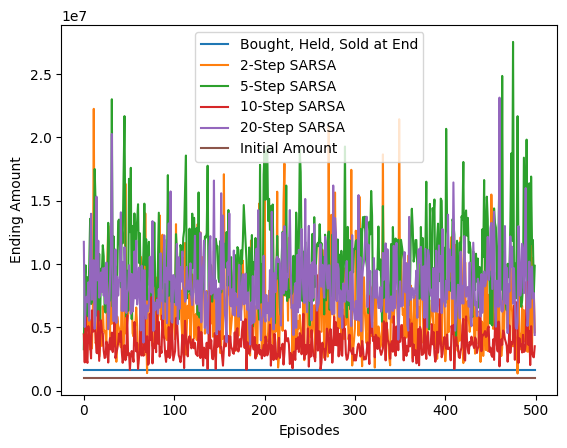

In [289]:
starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), two_step_sarsa_final_amounts, label='2-Step SARSA')
plt.plot(list(range(EPISODES)), five_step_sarsa_final_amounts, label='5-Step SARSA')
plt.plot(list(range(EPISODES)), ten_step_sarsa_final_amounts, label='10-Step SARSA')
plt.plot(list(range(EPISODES)), twenty_step_sarsa_final_amounts, label='20-Step SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

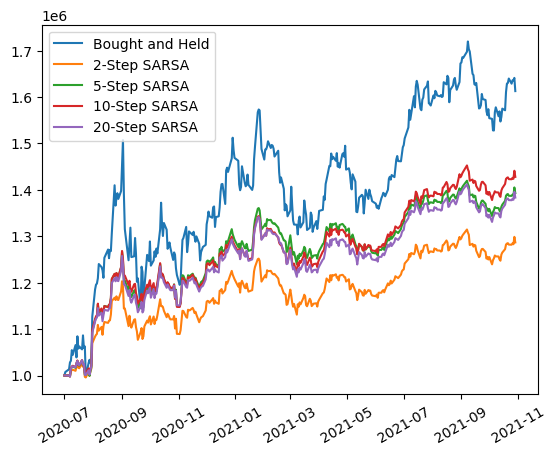

In [293]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
plt.plot(dates, avg_two_step_sarsa_test_values, label="2-Step SARSA")
plt.plot(dates, avg_five_step_sarsa_test_values, label="5-Step SARSA")
plt.plot(dates, avg_ten_step_sarsa_test_values, label="10-Step SARSA")
plt.plot(dates, avg_twenty_step_sarsa_test_values, label="20-Step SARSA")
plt.xticks(rotation=30)
plt.legend()
plt.show()


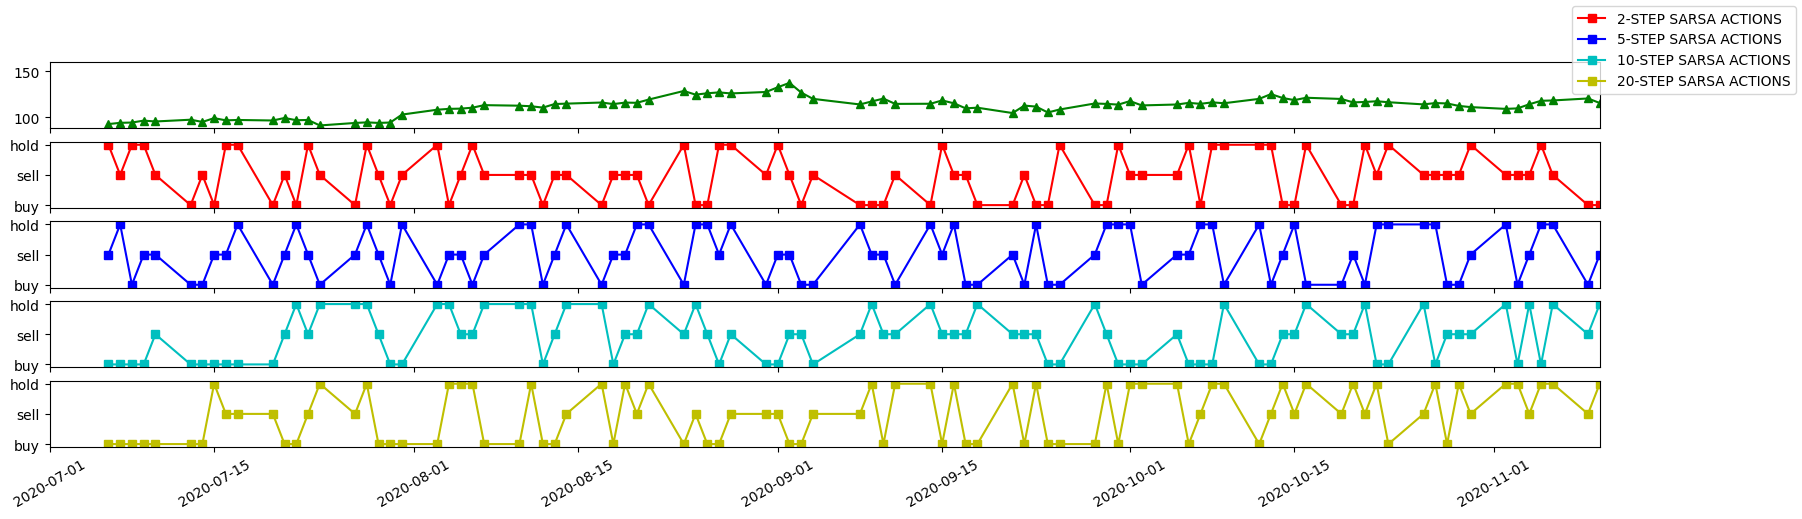

In [291]:
# ACTIONS OVER TEST
two_step_sarsa_test_actions = []
five_step_sarsa_test_actions = []
ten_step_sarsa_test_actions = []
twenty_step_sarsa_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in two_step_sarsa_test_episode[0]:
    action = step[1]
    two_step_sarsa_test_actions.append(action)
for step in five_step_sarsa_test_episode[0]:
    action = step[1]
    five_step_sarsa_test_actions.append(action)
for step in ten_step_sarsa_test_episode[0]:
    action = step[1]
    ten_step_sarsa_test_actions.append(action)
for step in twenty_step_sarsa_test_episode[0]:
    action = step[1]
    twenty_step_sarsa_test_actions.append(action)
fig, axs = plt.subplots(nrows=5, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, two_step_sarsa_test_actions, marker = 's', label = '2-STEP SARSA ACTIONS', c='r')
axs[2].plot(action_dates, five_step_sarsa_test_actions, marker = 's', label = '5-STEP SARSA ACTIONS', c='b')
axs[3].plot(action_dates, ten_step_sarsa_test_actions, marker = 's', label = '10-STEP SARSA ACTIONS', c='c')
axs[4].plot(action_dates, twenty_step_sarsa_test_actions, marker = 's', label = '20-STEP SARSA ACTIONS', c='y')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])


In [292]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT